<a href="https://colab.research.google.com/github/wevertonrs/document-classification/blob/master/Classificador_de_documentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ** Classificador de Documentos **

Mineração de Textos - 1/2024


## Parte 0: Montando o ambiente

In [ ]:
# @title Instalação de bibliotecas e import

required_packages = [
    'gnews',
    'unidecode',
    'transformers',
    'datasets',
    'umap-learn',
    'openai',
    'tiktoken',
]

with open('requirements.txt', 'w') as f:
    for package in required_packages:
        f.write(package + '\n')

# Instalando os pacotes listados em requirements.txt
%pip install -r requirements.txt
#%pip install --upgrade ipykernel
%pip install --force-reinstall httpx==0.27.2
%pip install --upgrade openai==1.55.3

!python -m spacy download pt_core_news_sm

import os
import io
import re
import string
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files, userdata
from tqdm import tqdm
import gdown

# Ignorando warnings
warnings.filterwarnings("ignore")

# Processamento de texto e NLP
import unidecode
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
import tiktoken

# Machine Learning e métricas
import torch
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    balanced_accuracy_score,
    classification_report,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Modelos pré-treinados e embeddings
from gensim.models import KeyedVectors
from transformers import AutoTokenizer, AutoModel

# Redução de dimensionalidade
from umap import UMAP

# Ferramentas externas
from gnews import GNews
from openai import OpenAI

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.0 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.6/389.6 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.57.4
    Uninstalling openai-1.57.4:
      Successfully uninstalled openai-1.57.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 78.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Parte 1: Obtenção das notícias classificadas pelo portal e criação das chave de classificação

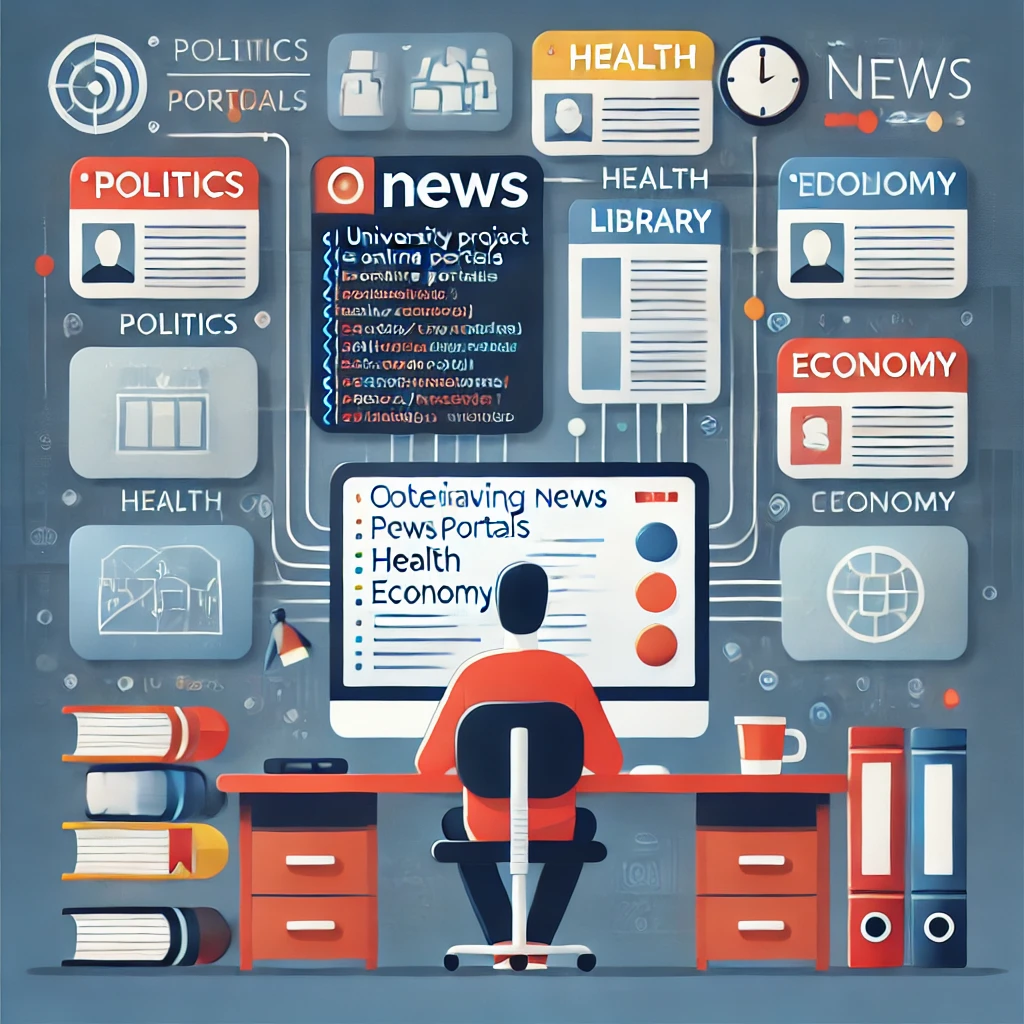

In [ ]:
google_news = GNews(
    language='pt-419',
    country='BR',
    period='5y',
    start_date=None,
    end_date=None,
)


In [ ]:
topics = [
    'WORLD', 'NATION', 'BUSINESS', 'TECHNOLOGY', 'ENTERTAINMENT', 'SPORTS',
    'SCIENCE', 'HEALTH', 'POLITICS', 'CELEBRITIES', 'TV', 'MUSIC', 'MOVIES',
    'THEATER', 'SOCCER', 'CYCLING', 'MOTOR SPORTS', 'TENNIS',
    'COMBAT SPORTS', 'BASKETBALL', 'BASEBALL', 'FOOTBALL', 'SPORTS BETTING',
    'WATER SPORTS', 'HOCKEY', 'GOLF', 'CRICKET', 'RUGBY', 'ECONOMY',
    'PERSONAL FINANCE', 'FINANCE', 'DIGITAL CURRENCIES', 'MOBILE', 'ENERGY',
    'GAMING', 'INTERNET SECURITY', 'GADGETS', 'VIRTUAL REALITY', 'ROBOTICS',
    'NUTRITION', 'PUBLIC HEALTH', 'MENTAL HEALTH', 'MEDICINE', 'SPACE', 'WILDLIFE',
    'ENVIRONMENT', 'NEUROSCIENCE', 'PHYSICS', 'GEOLOGY', 'PALEONTOLOGY',
    'SOCIAL SCIENCES', 'EDUCATION', 'JOBS', 'ONLINE EDUCATION',
    'HIGHER EDUCATION', 'VEHICLES', 'ARTS-DESIGN', 'BEAUTY', 'FOOD', 'TRAVEL',
    'SHOPPING', 'HOME', 'OUTDOORS', 'FASHION'
]

dataframes = []

for topic in topics:
    news = google_news.get_news_by_topic(topic)
    df = pd.DataFrame(news)
    df['label'] = topic
    dataframes.append(df)

final_df = pd.concat(dataframes, ignore_index=True)

print(final_df.head())

                                               title  \
0  Rússia anuncia prisão de suspeito pelo assassi...   
1  VÍDEO: Avião sai da pista e pega fogo após pou...   
2  'Centenas' de soldados norte-coreanos foram mo...   
3  Presidente da Turquia afirma que seu país e o ...   
4  Aviões batem em aeroporto dos Estados Unidos; ...   

                                         description  \
0  Rússia anuncia prisão de suspeito pelo assassi...   
1  VÍDEO: Avião sai da pista e pega fogo após pou...   
2  'Centenas' de soldados norte-coreanos foram mo...   
3  Presidente da Turquia afirma que seu país e o ...   
4  Aviões batem em aeroporto dos Estados Unidos; ...   

                  published date  \
0  Wed, 18 Dec 2024 10:27:37 GMT   
1  Wed, 18 Dec 2024 17:32:03 GMT   
2  Wed, 18 Dec 2024 09:52:52 GMT   
3  Wed, 18 Dec 2024 22:18:18 GMT   
4  Wed, 18 Dec 2024 14:54:39 GMT   

                                                 url  \
0  https://news.google.com/rss/articles/CBMitgFBV... 

In [ ]:
topics_pt = [
    'MUNDO', 'LOCAIS', 'NEGÓCIOS', 'TECNOLOGIA', 'ENTRETENIMENTO', 'ESPORTES',
    'CIÊNCIA', 'SAÚDE', 'POLÍTICA', 'CELEBRIDADES', 'TV', 'MÚSICA', 'FILMES',
    'TEATRO', 'FUTEBOL', 'CICLISMO', 'ESPORTES MOTORIZADOS', 'TÊNIS',
    'ESPORTES DE COMBATE', 'BASQUETE', 'BEISEBOL', 'FUTEBOL AMERICANO',
    'APOSTAS ESPORTIVAS', 'ESPORTES AQUÁTICOS', 'HÓQUEI', 'GOLFE', 'CRÍQUETE',
    'RÚGBI', 'ECONOMIA', 'FINANÇAS PESSOAIS', 'FINANÇAS', 'MOEDAS DIGITAIS',
    'MÓVEL', 'ENERGIA', 'JOGOS', 'SEGURANÇA NA INTERNET', 'GADGETS',
    'REALIDADE VIRTUAL', 'ROBÓTICA', 'NUTRIÇÃO', 'SAÚDE PÚBLICA',
    'SAÚDE MENTAL', 'MEDICINA', 'ESPAÇO', 'VIDA SELVAGEM', 'MEIO AMBIENTE',
    'NEUROCIÊNCIA', 'FÍSICA', 'GEOLOGIA', 'PALEONTOLOGIA', 'CIÊNCIAS SOCIAIS',
    'EDUCAÇÃO', 'EMPREGOS', 'EDUCAÇÃO ONLINE', 'EDUCAÇÃO SUPERIOR', 'VEÍCULOS',
    'ARTES-DESIGN', 'BELEZA', 'COMIDA', 'VIAGENS', 'COMPRAS', 'LAR',
    'AR LIVRE', 'MODA'
]

len(topics_pt)

64

In [ ]:
mapping = dict(zip(topics, topics_pt))
final_df['label_pt'] = final_df['label'].map(mapping)

In [ ]:
final_df = final_df.drop(columns = ['description', 'published date',
                                    'url', 'publisher', 'label'])

In [ ]:
final_df.drop_duplicates(subset='title', inplace=True)

In [ ]:
final_df.head(20)

title label_pt
0   Rússia anuncia prisão de suspeito pelo assassi...    MUNDO
1   VÍDEO: Avião sai da pista e pega fogo após pou...    MUNDO
2   'Centenas' de soldados norte-coreanos foram mo...    MUNDO
3   Presidente da Turquia afirma que seu país e o ...    MUNDO
4   Aviões batem em aeroporto dos Estados Unidos; ...    MUNDO
5   'Espiga de milho iluminada': tradicional árvor...    MUNDO
6   Vanuatu sofre segundo forte terremoto em menos...    MUNDO
7   Trump afirma que anexar e transformar o Canadá...    MUNDO
8   Acidente com avião monomotor no Havaí deixa do...    MUNDO
9   Ciclone Chido provoca pelo menos 45 mortes em ...    MUNDO
10  FOTO: Google Maps flagra assassino transportan...    MUNDO
11  Presidente da Coreia do Sul não comparece a au...    MUNDO
12  Pedra que teria gravados os Dez Mandamentos é ...    MUNDO
13  Luigi Mangione, suspeito de matar CEO, é indic...    MUNDO
14  Drones nos EUA: o que são os ‘objetos misterio...    MUNDO
15  VÍDEO – Rússia faz atividades militares com bo...    MUNDO
16  Suprema Corte da França mantém condenação de S...    MUNDO
17  Mayotte vive falta de comida e medo de doenças...    MUNDO
18  O Assunto #1369: A crise das democracias liber...    MUNDO
19  Irã pausa implementação de nova "lei do hijab"...    MUNDO

In [ ]:
categorias = {
    "Notícias/Atualidades": [
        'MUNDO', 'LOCAIS', 'POLÍTICA', 'CELEBRIDADES', 'ECONOMIA', 'FINANÇAS',
        'CIÊNCIAS SOCIAIS', 'FINANÇAS PESSOAIS'
    ],
    "Tecnologia/Inovação": [
        'TECNOLOGIA', 'MOEDAS DIGITAIS', 'MÓVEL', 'ENERGIA', 'JOGOS',
        'SEGURANÇA NA INTERNET', 'GADGETS', 'REALIDADE VIRTUAL', 'ROBÓTICA',
        'ESPAÇO'
    ],
    "Saúde/Bem-estar": [
        'SAÚDE', 'SAÚDE PÚBLICA', 'SAÚDE MENTAL', 'MEDICINA', 'NUTRIÇÃO'
    ],
    "Esportes": [
        'ESPORTES', 'FUTEBOL', 'CICLISMO', 'ESPORTES MOTORIZADOS', 'TÊNIS',
        'ESPORTES DE COMBATE', 'BASQUETE', 'BEISEBOL', 'FUTEBOL AMERICANO',
        'APOSTAS ESPORTIVAS', 'ESPORTES AQUÁTICOS', 'HÓQUEI', 'GOLFE',
        'CRÍQUETE', 'RÚGBI',
    ],

    "Educação/Ciência": [
        'CIÊNCIA', 'ESPACO', 'VIDA SELVAGEM', 'MEIO AMBIENTE', 'NEUROCIÊNCIA',
        'FÍSICA', 'GEOLOGIA', 'PALEONTOLOGIA', 'EDUCAÇÃO', 'EMPREGOS',
        'EDUCAÇÃO ONLINE', 'EDUCAÇÃO SUPERIOR'
    ],
    "Lazer/Outros": [
        'NEGÓCIOS', 'VEÍCULOS', 'ARTES-DESIGN', 'BELEZA', 'COMIDA', 'VIAGENS',
        'COMPRAS', 'LAR', 'AR LIVRE',  'MODA', 'TV', 'ENTRETENIMENTO',
        'MÚSICA', 'FILMES', 'TEATRO',
    ]
}

## Gerando 6 categorias de classificação

categoria_map = {}
for categoria, itens in categorias.items():
    for item in itens:
        categoria_map[item] = categoria

final_df['final_label'] = final_df['label_pt'].map(categoria_map)


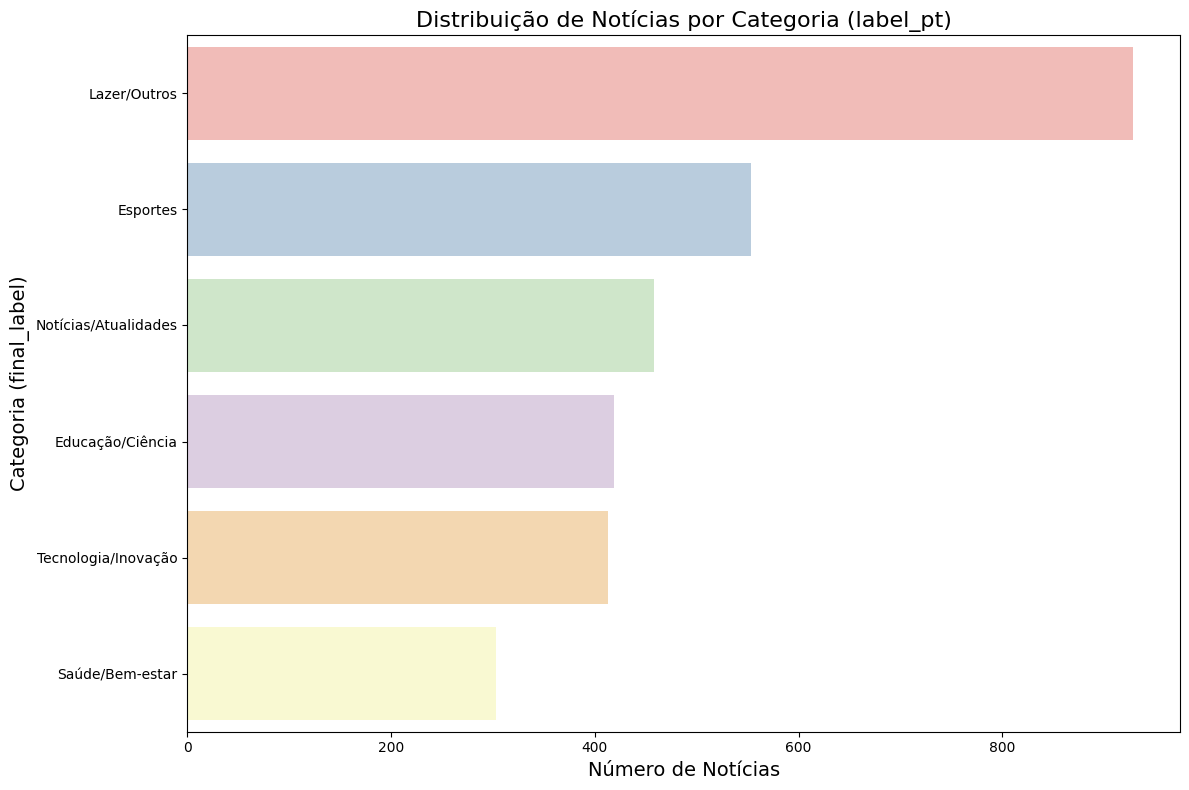

In [ ]:
# Contar a frequência de cada categoria em label_pt
label_counts = final_df['final_label'].value_counts()

# Configurar o tamanho do gráfico
plt.figure(figsize=(12, 8))
sns.barplot(x=label_counts.values, y=label_counts.index, palette='Pastel1')

# Adicionar título e rótulos
plt.title('Distribuição de Notícias por Categoria (label_pt)', fontsize=16)
plt.xlabel('Número de Notícias', fontsize=14)
plt.ylabel('Categoria (final_label)', fontsize=14)

# Exibir o gráfico
plt.tight_layout()
plt.show()

In [ ]:
final_df.rename(columns={'title': 'documento', 'final_label': 'categoria'}, inplace=True)
final_df.drop(columns=['label_pt'], inplace=True)

In [ ]:
final_df['documento'] = final_df['documento'].str.replace('"', "'", regex=False)

In [ ]:
def remove_source(text):
    # Regex para encontrar o padrão " - xxxx" no final da string
    # O padrão (?i) torna a busca case-insensitive
    # O padrão ( - \1)? remove a repetição do nome do portal de notícia
    return re.sub(r' - (.+?)( - \1)?$', '', text, flags=re.IGNORECASE)

final_df['documento'] = final_df['documento'].apply(remove_source)

In [ ]:
final_df.to_csv("news_train.csv", index=False)

## Parte 2: Treinamento dos modelos e predição
### É possível executar o código de trenamento a partir dessa célula (auto-geração do dataset)

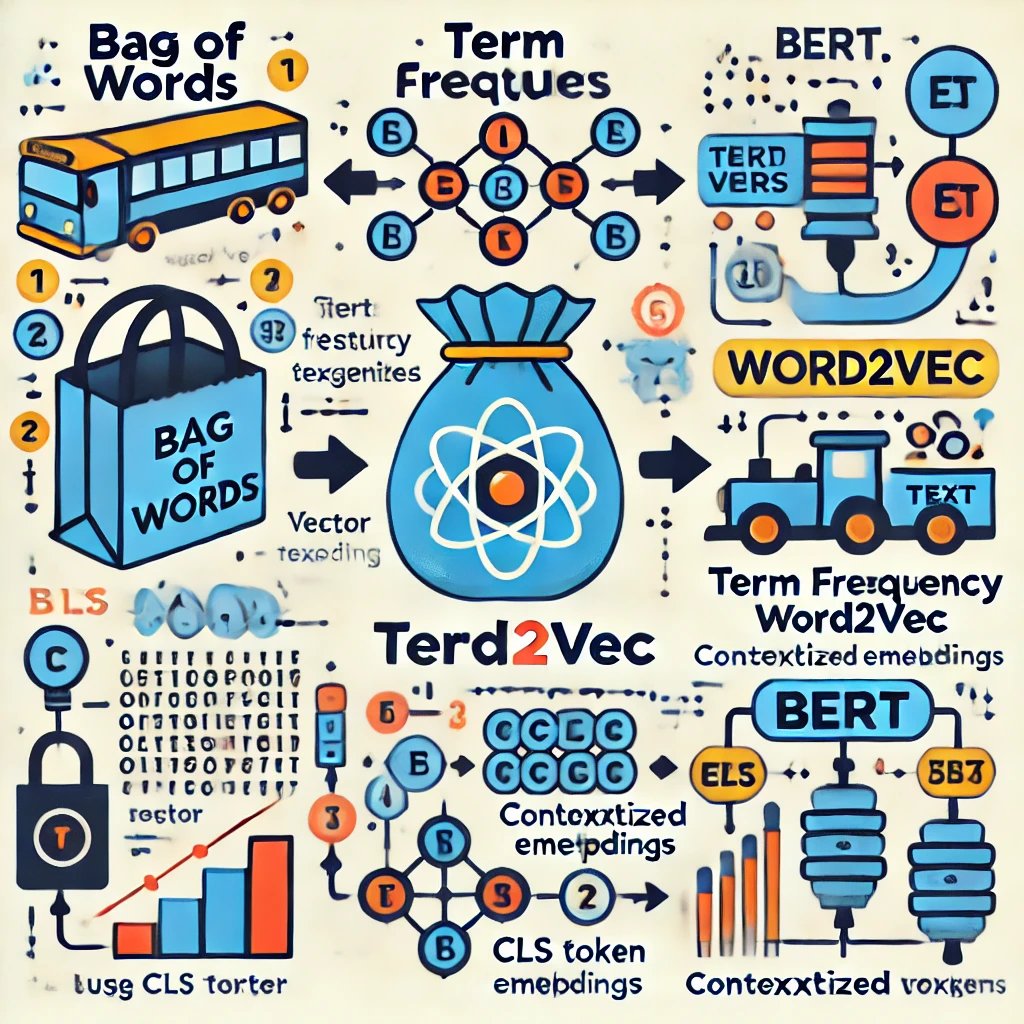

Categorias escolhidas:

    "Notícias/Atualidades": [
        'MUNDO', 'LOCAIS', 'POLÍTICA', 'CELEBRIDADES', 'ECONOMIA', 'FINANÇAS',
        'CIÊNCIAS SOCIAIS', 'FINANÇAS PESSOAIS'
    ],
    "Tecnologia/Inovação": [
        'TECNOLOGIA', 'MOEDAS DIGITAIS', 'MÓVEL', 'ENERGIA', 'JOGOS',
        'SEGURANÇA NA INTERNET', 'GADGETS', 'REALIDADE VIRTUAL', 'ROBÓTICA',
        'ESPAÇO'
    ],
    "Saúde/Bem-estar": [
        'SAÚDE', 'SAÚDE PÚBLICA', 'SAÚDE MENTAL', 'MEDICINA', 'NUTRIÇÃO'
    ],
    "Esportes": [
        'ESPORTES', 'FUTEBOL', 'CICLISMO', 'ESPORTES MOTORIZADOS', 'TÊNIS',
        'ESPORTES DE COMBATE', 'BASQUETE', 'BEISEBOL', 'FUTEBOL AMERICANO',
        'APOSTAS ESPORTIVAS', 'ESPORTES AQUÁTICOS', 'HÓQUEI', 'GOLFE',
        'CRÍQUETE', 'RÚGBI',         
    ],

    "Educação/Ciência": [
        'CIÊNCIA', 'ESPACO', 'VIDA SELVAGEM', 'MEIO AMBIENTE', 'NEUROCIÊNCIA',
        'FÍSICA', 'GEOLOGIA', 'PALEONTOLOGIA', 'EDUCAÇÃO', 'EMPREGOS',
        'EDUCAÇÃO ONLINE', 'EDUCAÇÃO SUPERIOR'
    ],
    "Lazer/Outros": [
        'NEGÓCIOS', 'VEÍCULOS', 'ARTES-DESIGN', 'BELEZA', 'COMIDA', 'VIAGENS',
        'COMPRAS', 'LAR', 'AR LIVRE',  'MODA', 'TV', 'ENTRETENIMENTO',
        'MÚSICA', 'FILMES', 'TEATRO',
    ]

In [ ]:
# @title CSV de treinamento hardcoded para evitar dependencias externas (3073 notícias, 2 colunas: documento e categoria), de acordo com as 6 categorias extraídas.
# Gerando o arquivo news_train.csv

news_text = """documento,categoria
"Chanceler alemão perde voto de confiança, abrindo caminho para eleições antecipadas em fevereiro",Notícias/Atualidades
Bashar al-Assad afirma ter sido forçado a deixar a Síria,Notícias/Atualidades
Ataque de Israel causa explosão gigante em território da Sìria,Notícias/Atualidades
ONU pede transição de governo ‘confiável e inclusiva’ na Síria,Notícias/Atualidades
Criança de 9 anos morre após comer nhoque em restaurante na Itália,Notícias/Atualidades
"Navio russo derrama mais de 4,3 mil toneladas de petróleo no Mar Negro",Notícias/Atualidades
Putin diz que Rússia tomou 189 localidades da Ucrânia em 2024 e fala em ‘ano de referência’ para a guerra,Notícias/Atualidades
Catástrofe no Índico: ciclone arrasa ilha e mortos podem ser centenas,Notícias/Atualidades
Ucrânia registra ataques massivos de norte-coreanos em Kursk,Notícias/Atualidades
Vice-premiê do Canadá renuncia ao cargo por 'diferenças' com Trudeau sobre tarifas de Trump,Notícias/Atualidades
Mansões de Bashar Al-Assad revoltam sírios: 'Gastava todo esse dinheiro enquanto nós vivíamos como miseráveis',Notícias/Atualidades
"Presidente interino sul-coreano quer tranquilizar aliados e investidores, diz professor",Notícias/Atualidades
Maior iceberg do mundo volta a se mover no Oceano Antártico após décadas,Notícias/Atualidades
Novo caso de abusos sexuais abala a Igreja da Inglaterra,Notícias/Atualidades
Off,Notícias/Atualidades
Brasileiro é vítima de tráfico humano na Ásia: 'Quero ir embora ou morrer',Notícias/Atualidades
Tráfico de drogas sustentava regime de Bashar al-Assad na Síria,Notícias/Atualidades
Israel fecha embaixada na Irlanda,Notícias/Atualidades
Venezuela entrega corpo de preso político em decomposição a filho,Notícias/Atualidades
Jornalista da Al Jazeera é morto em ataque israelense na Faixa de Gaza,Notícias/Atualidades
Insatisfação com seguradoras de saúde nos EUA limita empatia por morte de CEO,Notícias/Atualidades
Papa na missa em Ajácio: quem se considera justo não se renova,Notícias/Atualidades
Medicamento que faz crescer dentes perdidos entra em testes no Japão,Notícias/Atualidades
"Macron tem um novo primeiro-ministro, mas os mesmos problemas de sempre",Notícias/Atualidades
Polícia da Geórgia investiga morte de doze pessoas em resort de esqui,Notícias/Atualidades
Ex-jogador do Manchester City é eleito presidente da Geórgia,Notícias/Atualidades
Netanyahu reafirma posição de Israel sobre a Síria e o Hezbollah em conversa com Trump,Notícias/Atualidades
Lula: Jornal britânico compara presidente brasileiro a Biden e diz que estado de saúde gera dúvidas sobre candidatura em 2026,Notícias/Atualidades
'Jogavam os mortos em caçambas': ex-detentos turcos relatam os horrores das prisões sírias de Assad,Notícias/Atualidades
"Rússia toma a região de Shevchenko na Ucrânia, diz mídia estatal",Notícias/Atualidades
Giorgia Meloni é criticada após conceder cidadania italiana a Javier Milei,Notícias/Atualidades
Congresso dos EUA alerta Apple e Google: TikTok deve ser banido em janeiro,Notícias/Atualidades
Prédios residenciais e hotéis de luxo começam a afundar em Miami,Notícias/Atualidades
Refúgio russo de Assad é mistério 7 dias após fuga da Síria,Notícias/Atualidades
"“Estamos assistindo à morte de uma nação, que é a Síria, e os abutres estão se deliciando', diz Pepe Escobar",Notícias/Atualidades
"Jamil Chade: FBI e CIA agiram para sufocar movimento negro nos EUA, mostram documentos",Notícias/Atualidades
FT: Assad enviou US$ 250 milhões em dinheiro vivo da Síria para Moscou,Notícias/Atualidades
TV americana pagará U$ 15 milhões a Trump após acordo judicial,Notícias/Atualidades
"Avanço de aposta on-line é expansão de liberdade individual, diz ‘Economist’",Notícias/Atualidades
Cantora iraniana é presa por fazer show sem hijab; VEJA,Notícias/Atualidades
Jovem de 16 anos mata família inteira e liga bêbado à polícia para confessar o crime,Notícias/Atualidades
Quem deve representar o governo Lula na posse de Trump,Notícias/Atualidades
Atenas: A cidade que nasceu da mitologia e moldou a civilização,Notícias/Atualidades
Norwegian Star chega ao Brasil para temporada de despedida,Notícias/Atualidades
Todos a Bordo: 10 vendidos: o avião que virou o maior fracasso comercial da história,Notícias/Atualidades
Partiu Japão? Por que Tóquio quer que cidadãos trabalhem menos,Notícias/Atualidades
Terra à vista!: Como um homem que viveu antes de Jesus sacode as fronteiras da Europa hoje,Notícias/Atualidades
"CEO viraliza com discurso antes de festa da firma: ‘Eu uso drogas, mas não nos eventos do trabalho’",Notícias/Atualidades
O lamento da esquerda pelo fim da ditadura de Bashar Assad,Notícias/Atualidades
Estrategista de Trump desmaia ao vivo durante evento; VEJA VÍDEO,Notícias/Atualidades
Nova bandeira da Síria está sendo pintada nos aviões da empresa aérea nacional após a queda de Assad,Notícias/Atualidades
Indígenas do Canadá lutam para preservar memória de crianças mortas em escolas,Notícias/Atualidades
"Dá pra 'recongelar' o Ártico? Startup tem plano, mas cientistas são contra",Notícias/Atualidades
Rage-Baiting: como influencers ganham dinheiro provocando ódio nos seguidores,Notícias/Atualidades
Boeing 777 da LATAM que foi danificado na Itália ficará fora de operação até março,Notícias/Atualidades
Voo mais curto do mundo com Airbus A350 tem apenas 24 km e dura menos de 10 minutos,Notícias/Atualidades
Família de vendedor de arte acusa amante dele de matá-lo de fome para roubar fortuna de R$ 300 milhões nos EUA,Notícias/Atualidades
Cidadania portuguesa 2024-2025: nova plataforma promete agilizar o processo!,Notícias/Atualidades
Trump nomeia CEO da própria rede social e outro aliado para cargos no governo dos EUA,Notícias/Atualidades
Mulheres suecas estão abandonando trabalho para se dedicar a casa; entenda,Notícias/Atualidades
Veja o que cidadãos cubanos e americanos podem fazer em cada país hoje,Notícias/Atualidades
Arqueólogos encontram sarcófago do 'verdadeiro Papai Noel',Notícias/Atualidades
Governo Trump vai tomando forma: veja perfil dos auxiliares escolhidos,Notícias/Atualidades
As Cidades Mais Atraentes para Brasileiros no Exterior em 2024!,Notícias/Atualidades
Combate ao tédio com vídeos: solução ou armadilha?,Notícias/Atualidades
Síria é primeiro novo desafio para a política externa de Trump,Notícias/Atualidades
"Eleito como a maior história de amor do cinema de todos os tempos, a obra-prima de Victor Fleming está no Prime Video",Notícias/Atualidades
App de IA sugere que adolescente mate os próprios pais,Notícias/Atualidades
Revista da “direita woke” publica Karl Marx em pegadinha de crítico,Notícias/Atualidades
Sapos com superpoderes: entenda por que os anfíbios de Chernobyl não sofrem tanto com a radiação,Notícias/Atualidades
Moraes prorroga inquérito das fake news por mais seis meses,Notícias/Atualidades
Operação desarticula esquema de policiais contra extorsão de comerciantes no Brás,Notícias/Atualidades
"“Extremamente grave”, diz médico de Lula sobre sangramento e risco de morte",Notícias/Atualidades
"Empresário preso com mala de R$ 1,5 milhão em avião com destino a Brasília disse à PF que queria comprar maquinário",Notícias/Atualidades
Aceno de Bolsonaro é visto como recado para Braga Netto não delatar,Notícias/Atualidades
"Evandro Leitão anuncia secretários de Juventude, Infraestrutura e Esporte; veja nomes",Notícias/Atualidades
Concurso Correios: gabaritos oficiais são divulgados; confira,Notícias/Atualidades
"'Ele chegou com dor, mas a triagem foi mal feita', diz pai de paciente morto em sala de espera de UPA no Rio",Notícias/Atualidades
Haddad diz que apelo do governo é para que medidas fiscais não sejam desidratadas pelo Congresso,Notícias/Atualidades
Mutirão nacional de renegociação de dívidas começa nesta segunda; veja regras,Notícias/Atualidades
Incêndio de grandes proporções destrói mais de 100 casas e fogo preocupa no litoral de São Paulo; VÍDEO,Notícias/Atualidades
Gleisi critica Globo por ter dito que Lula teve direito de defesa,Notícias/Atualidades
Tarcísio anuncia que irá disputar a reeleição ao governo de SP,Notícias/Atualidades
"Mourão reconhece a existência de planos golpistas, mas minimiza: 'conspiração tabajara'",Notícias/Atualidades
Mais de 400 cidades de MG podem enfrentar tempestade com queda de granizo,Notícias/Atualidades
Órgão de defesa do patrimônio histórico revisa tombamento e permite condomínio nos Jardins,Notícias/Atualidades
Aeroporto Internacional Salgado Filho retoma totalmente as atividades nesta segunda-feira,Notícias/Atualidades
Vídeo mostra como foi temporal isolado que atingiu São Francisco do Sul e fez barco virar,Notícias/Atualidades
Prefeito reeleito no interior de SP morre 16 dias antes da posse,Notícias/Atualidades
Atrás do 'pessoal do agro': PF rastreia transações em espécie em Goiânia e Brasília para identificar financiadores do golpe,Notícias/Atualidades
STJ anula prisão por tráfico após analisar câmeras corporais da PM e identificar confissão sob tortura; veja vídeo,Notícias/Atualidades
Justiça nega prisão de suspeitos de atirar em família argentina no RJ,Notícias/Atualidades
Gêmeos separados e briga na Justiça: o que se sabe sobre bebês trocados em hospital de AL,Notícias/Atualidades
Gonet vai reagir caso anistia a golpistas seja aprovada pelo Congresso,Notícias/Atualidades
Semana de despedida da primavera tem chuva e calor em SP e em boa parte do país,Notícias/Atualidades
Saiu o listão da UFRGS: veja quem são os aprovados no vestibular de 2025,Notícias/Atualidades
Ciclone provoca impactos 'severos' na rede elétrica da CEEE,Notícias/Atualidades
"Luiz Fux, do STF, dá aula de jiu-jitsu para o Bope e jovens do Complexo da Maré",Notícias/Atualidades
IPVA 2025 SP: Como obter o desconto de 3% no pagamento à vista,Notícias/Atualidades
Veja onde mais vai ter chuva no Brasil nesta semana,Notícias/Atualidades
Avião da Gol com falha técnica faz pouso de emergência na Base Aérea de Canoas durante Ciclone Biguá,Notícias/Atualidades
Rodoviários da Região Metropolitana fazem paralisação; acompanhe ao vivo,Notícias/Atualidades
Stedile diz que MST cansou da retórica do governo Lula e chama gestão da reforma agrária de vergonhosa,Notícias/Atualidades
Delegada explica como homem entrou com enteada de 11 anos em motel,Notícias/Atualidades
Grande BH: briga por ciúmes termina com mulher esfaqueada,Notícias/Atualidades
Brasil terá maior alíquota do mundo após reforma tributária no Senado,Notícias/Atualidades
Quem era a jovem estudante de engenharia que morreu após passar mal em festa em SC,Notícias/Atualidades
Fuvest 2025: provas do 1º dia da 2ª fase exigem análise crítica e maturidade dos estudantes,Notícias/Atualidades
Inscrições abertas para concursos da Embrapa e do ICMBio,Notícias/Atualidades
Ex-governador do Tocantins é preso por indícios de que fugiria para o exterior,Notícias/Atualidades
Butantan pede à Anvisa registro de vacina de dose única contra a dengue,Notícias/Atualidades
Dino cita filme 'Ainda Estou Aqui' e defende que anistia não se estenda aos casos de ocultação de cadáver,Notícias/Atualidades
Quanto vai ser o valor do BPC em 2025? Veja agora!,Notícias/Atualidades
O horizonte de Caiado após ser declarado inelegível,Notícias/Atualidades
Homem é atacado e jogado no chão durante arrastão em Guarujá (SP),Notícias/Atualidades
Bolsa Família 2025: o que muda nas regras de inscrição e atualização,Notícias/Atualidades
"Em IA, Brasil pensa pequeno, e a Índia sonha gigante",Notícias/Atualidades
Policial federal saca arma e acaba com evento no Sudoeste; vídeo,Notícias/Atualidades
"Dois jovens de 24 anos morrem afogados na Praia Mansa, em Matinhos",Notícias/Atualidades
Governo afasta direção de presídio após fuga de 16 detentos,Notícias/Atualidades
"BC vende mais US$ 4,6 bilhões em leilões para segurar cotação do dólar",Lazer/Outros
Datafolha: gestão Haddad na economia é aprovada por 27% dos brasileiros e rejeitada por 34%,Lazer/Outros
"Mercado financeiro eleva previsão da inflação de 4,84% para 4,89%",Lazer/Outros
"Mesmo com novas altas de impostos para atingir metas fiscais, governo prevê déficit nas contas até o fim do governo Lula",Lazer/Outros
MEIs têm até janeiro para evitar exclusão do Simples Nacional,Lazer/Outros
"Dow Jones Futuro sobe, em início de semana marcada por decisão de juros nos EUA",Lazer/Outros
Segunda parcela do 13º é paga até sexta (20); veja valor e quem recebe,Lazer/Outros
Mega-Sena acumula prêmio para R$ 16 milhões enquanto Paraná celebra apostas premiadas na quina,Lazer/Outros
Bitcoin dispara após Trump sugerir criação de reserva estratégica,Lazer/Outros
Estresse fiscal e exterior devem afastar estrangeiro da bolsa em 2025,Lazer/Outros
Tempo Real: Ibovespa tem última semana agitada antes do Natal,Lazer/Outros
Automob (AMOB3) dispara mais de 200% em estreia na B3,Lazer/Outros
Tesouro Direto dá 'circuit breaker' em dia de prefixados a 15% e IPCA+ perto de 8%,Lazer/Outros
Mega da Virada pagará o maior prêmio de toda a história,Lazer/Outros
Lotofácil: concurso 3270 sorteia um dos maiores prêmios de 2024,Lazer/Outros
Mega da Virada: fazer aposta múltipla aumenta chances de ganhar na Mega-Sena?,Lazer/Outros
Crusoé: Tarcísio com Elon Musk no centro de São Paulo?,Lazer/Outros
"Soja tem início de semana com leves ganhos em Chicago, na esteira dos grãos e farelo",Lazer/Outros
Banco Central leiloará US$ 3 bilhões nesta segunda-feira para segurar o dólar,Lazer/Outros
Bolsa e Tesouro lançam vale-presente para compra de títulos públicos,Lazer/Outros
Dois apostadores de Mato Grosso ganham R$ 85 mil na Mega-Sena,Lazer/Outros
CPF na Nota 2024: veja como conferir se você tem prêmios acumulados para resgatar,Lazer/Outros
BREAKING: Ultra promove Pizzinatto a CEO; Lutz vira chairman executivo,Lazer/Outros
Salário mínimo 2025: novos valores foram confirmados em diversas cidades do país,Lazer/Outros
"RD Saúde, B3, CCR, Sabesp, Kora Saúde, Rede D’or e mais ações para acompanhar hoje",Lazer/Outros
GPA (PCAR3) dispara mais de 20% após Tanure montar posição na varejista,Lazer/Outros
"BNDES aprova R$ 1,1 bi para exportação de 8 aviões da Embraer à Azorra",Lazer/Outros
Veja os carros mais vendidos da primeira quinzena de dezembro,Lazer/Outros
Governo Lula parte para cima de Mercado Livre e Amazon por celulares piratas,Lazer/Outros
"Comércio está otimista com vendas de Natal, apesar de dólar caro e juros altos",Lazer/Outros
"Após seca recorde, setor elétrico inicia recuperação e conta de luz deve ficar sem taxa extra em quase todo 2025",Lazer/Outros
Número de ações trabalhistas volta a crescer. Veja os motivos,Lazer/Outros
FGTS 2025: regras e dados para o Saque-Aniversário que você precisa conhecer,Lazer/Outros
"“Correios foram sucateados no governo Bolsonaro”, diz entidade",Lazer/Outros
“Onde Investir em 2025”: as projeções da XP para ficar de olho no próximo ano,Lazer/Outros
Comunicado para beneficiários que recebem o Bolsa Família e Vale-Gás em dezembro,Lazer/Outros
Dólar a R$ 7 virou realidade na cabeça dos investidores; entenda,Lazer/Outros
Tarcísio ciente: Isenção de IPVA em São Paulo é confirmada a lista de carros da Fiat e Volkswagen para 2025,Lazer/Outros
Veja lista das 10 decepções tecnológicas de 2024,Lazer/Outros
Governo divulga calendário do abono salarial PIS/Pasep 2025; confira,Lazer/Outros
Estudar no Reino Unido: por que universidades estão sendo acusadas de aceitar alunos que não entendem bem inglês,Lazer/Outros
O empreendedor brasileiro que quer competir com a Patek e a Rolex,Lazer/Outros
Compras de fim de ano: 7 dicas para garantir a segurança no pagamento via Pix,Lazer/Outros
Fabio Brito assume comando da Leo Burnett Brasil,Lazer/Outros
Azul Fidelidade oferece 300% de bônus na compra de pontos,Lazer/Outros
Comunicado do Banco Central traz fim a cartões e novo substituto,Lazer/Outros
Alta de ICMS eleva taxação total sobre importados para até 100%,Lazer/Outros
Colecionadores estão pagando quase um salário mínimo nessa moeda de R$ 1,Lazer/Outros
"Morre Isak Andic, Fundador da Mango, Aos 71 Anos em Acidente Trágico",Lazer/Outros
Salário mínimo de 2025 é reajustado para R$ 1.518? Governo responde,Lazer/Outros
É o FIM dos atestados médicos no Brasil para 2025! Veja qual vai ser a nova solução,Lazer/Outros
Caixa endurece regras e encarece financiamento imobiliário em 2025,Lazer/Outros
BlackRock recomenda alocação de 1% a 2% de Bitcoin nas carteiras,Lazer/Outros
Quem compra coisas pela internet precisa saber desta informação,Lazer/Outros
Golpe do combustível: 8 coisas que você deve saber para não ser enganado ao encher o tanque,Lazer/Outros
"Loteria Americana: jogue e concorra a R$ 4,5 bilhões na Mega Millions",Lazer/Outros
Quem é a Mulher Que Vai Liderar 140 Produtores de Algodão na Bahia,Lazer/Outros
Ford Escort RS volta à vida com 296 cv e custa R$ 2 milhões; entenda,Lazer/Outros
Retrofit é saída para fugir de disputa por terrenos em SP,Lazer/Outros
Alunos da UFRJ vencem desafio do Banco Safra,Lazer/Outros
"Grupo Mateus adquire dois terrenos na Parangaba e Messejana, em Fortaleza, para novas lojas",Lazer/Outros
Falência e demolição: O fim de shoppings rivais do Bourbon em SP,Lazer/Outros
Assessores de Trump querem encolher ou eliminar reguladores bancários,Lazer/Outros
"Está acabando importante serviço do Nubank, veja como ainda aproveitar em 2024",Lazer/Outros
BYD atinge marca histórica de 70 mil veículos eletrificados vendidos no Brasil em 2024,Lazer/Outros
"Eleita mulher fitness perfeita pela IA, influencer desembolsa mais de R$ 20 mil em treino: '2.500 agachamentos por semana'",Tecnologia/Inovação
Bitcoin atinge novo recorde vai a US$ 106 mil após Trump sugerir a criação de uma 'reserva estratégica' da criptomoeda,Tecnologia/Inovação
Testamos drone de R$ 100 que promete fotos e vídeos em 4K; saiba se é bom,Tecnologia/Inovação
Atestados médicos com os dias contados? O que vai substituir o papel?,Tecnologia/Inovação
Feriados 2025: descubra qual será o primeiro e quando cairá,Tecnologia/Inovação
Comunicado importante da Microsoft para quem utiliza Windows 11,Tecnologia/Inovação
WhatsApp deixará de funcionar nestes celulares Android em 2025: Veja se o seu está na lista?,Tecnologia/Inovação
Abono PIS/Pasep 2025: veja calendário proposto pelo Governo Federal,Tecnologia/Inovação
10 profissões que devem 'bombar' nos próximos 5 anos,Tecnologia/Inovação
Jovem que denunciou ChatGPT é encontrado morto em casa,Tecnologia/Inovação
O que se sabe sobre drones misteriosos que sobrevoam Nova Jersey,Tecnologia/Inovação
Empresa multinacional alemã oferece oportunidade para quem deseja começar carreira FORA do Brasil,Tecnologia/Inovação
Motorista reage a assalto e motoqueiro morre prensado contra uma parede em Salvador; saiba detalhes,Tecnologia/Inovação
Adeus carros elétricos da Toyota? A montadora japonesa surpreende o mercado automotivo ao anunciar novo motor a combustão com o dobro da eficiência energética dos propulsores atuais,Tecnologia/Inovação
Tim e Estrela apresentam nova versão do Genius clássico brinquedo dos anos 80,Tecnologia/Inovação
"LEGO Horizon Adventures chegará ao Xbox em breve, diz rumor",Tecnologia/Inovação
"Decreto da ANATEL confirma fim de serviço da Vivo, Claro e Tim",Tecnologia/Inovação
Empresa de Franca constrói casas com impressora 3D,Tecnologia/Inovação
8 profissões que têm vagas sobrando por falta de mão de obra,Tecnologia/Inovação
‘Jeitinho brasileiro’ para economizar energia: pague menos na conta de luz em 2025,Tecnologia/Inovação
"Apple, Google e mais: veja quais são as 20 empresas mais valiosas do mundo em 2024",Tecnologia/Inovação
Motociclista passa mal e morre enquanto ia entregar açaí na Capital,Tecnologia/Inovação
Atualizações no WhatsApp trazem recursos inéditos para chamadas de vídeo,Tecnologia/Inovação
Cansou de varrer? Veja 6 robôs aspiradores que valem a pena ainda em 2024,Tecnologia/Inovação
"Governo do Estado contrata instituto por R$ 2,6 milhões para suporte ao ensino",Tecnologia/Inovação
Brasileiro lucra 800% em 5 dias e ganha ‘a grana da sua vida’ com criptomoeda recomendada pela Empiricus,Tecnologia/Inovação
10 sinais de que sua inteligência é muito acima da média,Tecnologia/Inovação
Detran de SP revela as regras e calendário de pagamento do IPVA 2025,Tecnologia/Inovação
Empresas enfiam a mão no bolso com iPhone e show de presente,Tecnologia/Inovação
Florianópolis: O novo destino para empreendedores no Brasil,Tecnologia/Inovação
Ministério da Justiça vai usar inteligência artificial em presídios,Tecnologia/Inovação
Nova tecnologia em terminal de Curitiba gera economia de R$ 800 mil ao ano,Tecnologia/Inovação
"Tarcísio de Freitas usa imagem com Elon Musk, feita por IA, para anunciar nova sede do governo de SP",Tecnologia/Inovação
"Moto G75 vs Redmi Note 13 Pro: resistência e desempenho, ou tela e bateria? | Comparativo",Tecnologia/Inovação
Coisas que você nunca deve fazer no WhatsApp,Tecnologia/Inovação
“IA from Goiás” conquista empresas e coloca o Brasil no mapa global da inovação,Tecnologia/Inovação
O terror das blogueiras: Instagram desabilitará filtros de embelezamento em janeiro de 2025,Tecnologia/Inovação
Governo determina que Amazon e Mercado Livre removam anúncios de celulares vendidos sem nota fiscal,Tecnologia/Inovação
Renault faz a alegria de todos e anuncia novo caminhão elétrico!,Tecnologia/Inovação
Homem bêbado bate o carro e tenta usar ‘celular invisível’; vídeo,Tecnologia/Inovação
"Motorola lança Moto G15 no Brasil com 256 GB, Android 15 e bateria para 40 horas",Tecnologia/Inovação
"Segunda fase da Fuvest tem pergunta sobre narradores de futebol, Inteligência Artificial e necropolítica",Tecnologia/Inovação
"RTX 5090 com 32GB GDDR7 aparece no site da Zotac, junto com 5080 e 5070 também",Tecnologia/Inovação
Petrobras vai monitorar Margem Equatorial com tecnologia da Nasa,Tecnologia/Inovação
Iphones furtados em show na Pedreira Paulo Leminski são recuperados pela Guarda Municipal,Tecnologia/Inovação
Fenômeno climático perde força: La Niña deve ser fraco em 2025,Tecnologia/Inovação
"Após ser excomungada 3 vezes, Madonna aparece em imagens de IA em 'chamego' com Papa Francisco",Tecnologia/Inovação
'Encerrar': FIM de serviço popular do Carrefour é confirmado,Tecnologia/Inovação
Baiana cria edtech e quer faturar R$10 milhões em 2025,Tecnologia/Inovação
Excesso de opções produz angústia e estimula o imobilismo,Tecnologia/Inovação
"Governo do Estado contrata instituto por R$ 2,6 milhões para formar professores",Tecnologia/Inovação
"Por ser muito bom, Elon Musk é impedido de jogar Path of Exile 2",Tecnologia/Inovação
Casal brasileiro inova e fatura milhões com tecnologia que economiza água,Tecnologia/Inovação
É o fim do ar-condicionado? Empresa francesa anuncia opção mais sustentável,Tecnologia/Inovação
Que tal trabalhar em casa? O Sicredi oferece vaga home office com 14º e 15º + participação nos lucros e benefícios exclusivos; Confira como se candidatar,Tecnologia/Inovação
Mina de ouro e energias renováveis elevam empregos em Currais Novos,Tecnologia/Inovação
Quem comprou o WhatsApp? Conheça o dono da maior rede social do Brasil,Tecnologia/Inovação
Inscrições para 640 vagas em cursos técnicos da Seciteci começam hoje,Tecnologia/Inovação
Elon Musk: o homem mais rico dos EUA e sua jornada rumo a Marte,Tecnologia/Inovação
Filha de Silvio Santos mostra bastidores de ida à Globo,Lazer/Outros
"Após alta do filho, Viih Tube se emociona ao tomar decisão sobre amamentação",Lazer/Outros
Concurso elege sósia da atriz Fernanda Torres no Rio,Lazer/Outros
"System of a Down, que mescla metal e música armênia, vem ao Brasil",Lazer/Outros
Reviravoltas surpreendentes agitam os próximos capítulos de Mania de Você,Lazer/Outros
"Família de Gugu anuncia fim da disputa sobre herança de R$ 1,4 bilhão do apresentador",Lazer/Outros
"Silo é renovada para 3ª e 4ª temporada, as últimas da série do Apple TV+",Lazer/Outros
Enquete A Fazenda 16: Vanessa sobe em votação após defender Sacha Bali,Lazer/Outros
The White Lotus | 3ª temporada ganha pôster inédito,Lazer/Outros
Volta por Cima: Jão acusa Neuza e é acolhido por Madá,Lazer/Outros
Justiça manda retirar música de Adele por plagiar Martinho da Vila,Lazer/Outros
"Com 'invasão' do SBT, Melhores do Ano tem maior ibope da era Luciano Huck",Lazer/Outros
Rafael Portugal reassume quadro no BBB após três anos e flop de Dani Calabresa,Lazer/Outros
Air será exibido na Tela Quente da Globo; saiba horário do filme,Lazer/Outros
"Da cadeirada ao SBT: perto de acerto com emissora, Marçal deve ser colega de Datena",Lazer/Outros
Paulo Vieira faz piada com prisão de Braga Netto e 'cadeirada' do Datena no 'Melhores do Ano',Lazer/Outros
Filha de cantora famosa ganha vida dando faxina em restaurante; Veja quem é,Lazer/Outros
Ainda Estou Aqui | Filme leva premiação nos EUA e bate Emilia Pérez,Lazer/Outros
Braga Netto preso: público pede 'sem anistia' em show de Caetano e Bethânia,Lazer/Outros
Sortudas são elas! César Tralli e Chay Suede roubam a cena com declarações apaixonadas no 'Melhores do Ano': 'Românticos',Lazer/Outros
Harry Potter | Musical A Criança Amaldiçoada será lançado no Brasil; veja teaser,Lazer/Outros
A Fazenda 16: Sidney se revolta com Sacha após pedido: 'Perverso',Lazer/Outros
"Réveillon da Paulista terá shows de Bruno e Marrone, Gloria Groove e MC Livinho; confira a programação",Lazer/Outros
Garçom acusado pela morte de Liam Payne admite ter usado droga com o artista,Lazer/Outros
Jovem viraliza ao receber 'cantada' de homem que mora em Santos e ganha comentário de Bruna Marquezine; VÍDEO,Lazer/Outros
Patrícia Abravanel ignora suposta rixa e fala de Lívia Andrade na TV Globo,Lazer/Outros
"Em Belém, Pabllo Vittar rebate fala de Manu Bahtidão",Lazer/Outros
Mulher que se negou a trocar de assento em voo revela quanto ganha: 'publicidades de R$ 30 mil',Lazer/Outros
Gusttavo Lima encerra turnê ‘Buteco Despedida’ com show histórico e convidados de peso no Está ...,Lazer/Outros
Superman | Filme de James Gunn ganha primeiro pôster,Lazer/Outros
Ex de Camila Pitanga muda de nome: 'Algo morreu em mim nos últimos anos',Lazer/Outros
"'Fico com cara de dor porque estou tentando contar as notas', diz baterista do U2 diagnosticado com discalculia",Lazer/Outros
Nivea Stelmann cita namoro com ex-jogador da seleção como seu maior erro: 'Fomos parar no tribunal',Lazer/Outros
Cirurgia para retirada de tumores de Preta Gil é adiada,Lazer/Outros
"A Fazenda 16: Albert é eliminado com rejeição recorde de 0,85%",Lazer/Outros
Ticiane Pinheiro rebate acusações de 'rixa familiar' envolvendo filha,Lazer/Outros
Vera Viel mostra cicatriz após retirada de tumor e relata desconforto durante radioterapia: 'Sou mais forte',Lazer/Outros
Ex-BBBs Elieser e Kamilla revelam resultado de teste de DNA,Lazer/Outros
Série sobre Senna desaparece da Netflix e motivo vem à tona,Lazer/Outros
Mulher que fez sexo com 101 homens em 14 horas desabafa: ‘muito estranho’,Lazer/Outros
Luciana Gimenez choca ao revelar valor da fatura do cartão,Lazer/Outros
William Bonner e César Tralli quebram protocolo no ‘Melhores do Ano’,Lazer/Outros
"Touro, gêmeos, câncer: quais signos que devem ter mais sorte em 2025",Lazer/Outros
Tatá Werneck precisou ser medicada após acusação de assédio,Lazer/Outros
"De lingerie, Luana Piovani surpreende fãs ao surgir com cabelo colorido; veja novo visual",Lazer/Outros
Mercado da Bola: Corinthians trabalha por negociação e vê Pogba disposto a jogar no Brasil,Esportes
Vini Jr ou Rodri? Fifa anuncia vencedor do The Best nesta terça,Esportes
Ranking da Conmebol: Palmeiras e Flamengo estão no Top-4 com River e Boca,Esportes
Mário confirma permanência de Mano Menezes no comando do Fluminense,Esportes
Abel braga se manifesta sobre um retorno e a confusão com Vegetti no Inter,Esportes
Vini Jr é denunciado após provocar torcida Rayo Vallecano em jogo do Real Madrid,Esportes
"Boatos, que Abel negocia com o Sporting, não são levados a sério, por Leila Pereira. A presidente do Palmeiras tenta até antecipar renovação",Esportes
Mário admite erro e confirma novo perfil de contratações: “Time mais físico”,Esportes
"SAF, Richarlison, Mano e saídas: presidente do Fluminense projeta 2025",Esportes
"Brasileirão 2024 anotou a segunda maior média de público da história, veja lista",Esportes
Gaviões da Fiel anuncia mudança e promete novidade na campanha arrecadação da Arena; confira,Esportes
"Flamengo será 'SAF' no futebol com BAP, e diretores já estão escolhidos",Esportes
"Corinthians sonda Lucas Veríssimo, mas zagueiro quer completar temporada no Al-Duhail",Esportes
"Na mira do Fluminense, Tiquinho Soares toma decisão sobre futuro no Botafogo",Esportes
Artur Jorge esconde negociação de John Textor e causa clima ruim no Botafogo,Esportes
Santos aposta em boa relação com Palmeiras para contratar Zé Rafael,Esportes
Quanto Rayssa Leal Faturou Ao se Tornar Tricampeã Mundial de Skate Street,Esportes
Guardiola desabafa após derrota de virada para o United: 'Não sou bom o suficiente',Esportes
Como imprensa italiana reagiu ao título mundial do Sada Cruzeiro contra o Trentino,Esportes
Vinda de Roger Guedes gera impasse entre Filipe Luís e Flamengo,Esportes
"Cruzeiro: Mattos se reúne com empresário para contratar Rodriguinho, do América",Esportes
"Presidente do Peñarol garante que Terans, do Fluminense, não irá para rival uruguaio; entenda!",Esportes
Azedou? Decisão de título nacional coloca pedreira no caminho do Bahia na Libertadores,Esportes
Ele fica! Vitória anuncia permanência de atacante e desagrada a torcida,Esportes
"Pré-Libertadores 2025: Confira data, horário e onde assistir ao sorteio dos confrontos",Esportes
Sormani crava chegada de novo treinador e Quinteros será anunciado nas próximas horas no Santos,Esportes
Muito choro e dois gols: a despedida de Adriano Imperador no Maracanã,Esportes
Vasco planeja proposta de compra pro Cuello,Esportes
Mário Bittencourt esclarece situação de Jhon Arias para 2025,Esportes
Neymar abre o jogo sobre conflitos com torcida e direção do PSG e explica por que decidiu ir para o futebol saudita,Esportes
Ídolo do Cruzeiro rasga elogios a Dudu e Gabigol e faz projeção para 2025,Esportes
"Mercado da bola do Corinthians: Carrillo confirmado, temor por Yuri Alberto e mais de Paul Pogba",Esportes
Minas e Praia buscam 1º título do Mundial Feminino de Vôlei; veja ranking de campeões,Esportes
"Após tricampeonato, técnico ex-São Paulo vira 'Muricy mexicano'",Esportes
Mário confirma interesse em Richarlison e promete alto investimento em contratações,Esportes
Gols e assistências: veja números de Facundo Torres nas últimas temporadas,Esportes
Felipe Melo não segue no Fluminense para 2025,Esportes
"West Ham aceita vender Paquetá, e Flamengo pode avançar em contratação do meia",Esportes
Bahia cutuca o Vitória e agita torcida com indireta no ranking da CBF,Esportes
Grêmio descarta mais dois nomes da lista para treinador em 2025,Esportes
O dia decisivo para o acerto de Renato Portaluppi com novo clube,Esportes
"Stock Car: Felipe Baptista enaltece temporada de 2024, mas aguarda decisão que pode lhe dar titulo",Esportes
Adidas Cup: Flamengo enfrenta o Arsenal pela final do torneio,Esportes
"Nome de Léo Chu não empolgou Mano no Fluminense, conta jornalista",Esportes
Onde assistir Jaraguá x Praia Clube pela final da Liga Nacional de Futsal,Esportes
Corinthians deve registrar novo contrato de Memphis Depay na volta das férias; entenda,Esportes
Convite recusado,Esportes
Botafogo inclui jogadores e faz nova oferta ao Santos por Jair; veja detalhes,Esportes
Skatista colombiano Jhank Gonzalez sai imobilizado da arena durante final da SLS; veja,Esportes
"Eleição do Sport: veja candidatos, chapas, horário de votação e lista de sócios aptos",Esportes
City x United: Prodígio castiga erros de brasileiros e comanda virada espetacular,Esportes
Corinthians já está acertando com os tais 'reforços galácticos' para 2025,Esportes
Paysandu planeja reformulação total com até 15 contratações,Esportes
De olho no mercado: Portal indica cinco atacantes para suprir a possível saída de Wesley,Esportes
Remo e Paysandu decidem o Paraense de Basquete neste domingo,Esportes
Leila Pereira assina termo de posse e inicia segundo mandato à frente do Palmeiras,Esportes
Polêmica com Vini Jr: Real Madrid acusa La Liga de manipulação,Esportes
Craque Neto crava campeão da Libertadores em 2025: “Ganha dois títulos”,Esportes
Real Madrid x Pachuca: a grande final da Copa Intercontinental 2024,Esportes
Pai de Gabigol dá declaração sobre futuro do filho e agita torcedores; veja,Esportes
Ronaldo se sente pronto para concorrer à presidência da CBF: 'Preparado para assumir esse desafio',Esportes
Flamengo se movimenta nos bastidores para dar camisa 10 a Arrascaeta,Esportes
Crocodilo mais velho da história já teve 10 mil filhotes e faz 124 anos hoje,Educação/Ciência
Vida extraterrestre pode não parecer nada com a vida na Terra: como astrobiólogos lidam com o desafio?,Educação/Ciência
Nasa divulga as melhores imagens da Estação Espacial de 2024; veja as fotos,Educação/Ciência
Há quantos anos surgiu a roda? Invenção é mais antiga do que pensávamos,Educação/Ciência
Ossos achados em massacre de 4 mil anos revelam sinais de canibalismo,Educação/Ciência
"As 10 músicas mais felizes do mundo, segundo a ciência",Educação/Ciência
Por que o Garfield é laranja? A ciência finalmente encontrou uma resposta,Educação/Ciência
Plano de regeneração da amazônia vai incluir concessão florestal de áreas degradadas,Educação/Ciência
Curitiba vai ganhar novo parque alagável para enfrentar mudanças climáticas,Educação/Ciência
Escolhido de Trump para comandar a Nasa é mais do que só um fã da SpaceX,Educação/Ciência
Empresa anuncia venda de ações de fóssil de estegossauro nos EUA; cada uma por R$ 415,Educação/Ciência
'Interação extrema': o que ocorre quando dois ciclones colidem?,Educação/Ciência
Estudante de engenharia química morre após festa em Santa Catarina,Educação/Ciência
Qual é a idade máxima que podemos alcançar? A ciência explica,Educação/Ciência
Veja o ‘pedacinho’ mais antigo do nosso planeta (e descubra sua idade),Educação/Ciência
"Equipe “importada” deixa pacientes à míngua na Santa Casa, denuncia neurologista",Educação/Ciência
"Candidatos acham prova tranquila, mas deslizam em português e matemática",Educação/Ciência
Uso de carimbos pode ser um dos elos perdidos da origem da escrita na Mesopotâmia,Educação/Ciência
Qual a relação entre pesadelo e a saúde do cérebro?,Educação/Ciência
"Com 640 vagas, inscrições para cursos técnicos começam nesta segunda-feira (16)",Educação/Ciência
James Webb faz descoberta surpreendente no sistema solar TRAPPIST-1,Educação/Ciência
A dura realidade matemática: Ou o Brasil acerta a trajetória fiscal ou o país explode,Educação/Ciência
Última lua cheia do ano: veja fotos do fenômeno astronômico em MS,Educação/Ciência
China planeja ser a primeira a trazer amostras de Marte para a Terra em 2031,Educação/Ciência
Neandertais e humanos modernos tiveram só uma grande fase de 'namoro',Educação/Ciência
Pacote aprovado na Câmara prevê castração química e permissão para que investigados tenham armas; conheça principais propostas,Educação/Ciência
Agrônomo cava solo da Antártida para 'plantar' sondas climáticas,Educação/Ciência
"Diagnóstico de Lula não é raro em pessoas idosas, aponta neurologista",Educação/Ciência
Polo norte magnético está se movendo cada vez mais rápido; cientistas estão perplexos com o fenômeno,Educação/Ciência
MUDANÇAS FÍSICAS: Como o espaço afeta o corpo dos astronautas de formas incríveis,Educação/Ciência
Cientistas pedem que pesquisas com vida espelhada parem: 'risco sem precedentes',Educação/Ciência
10 Hábitos para Evitar o 'Brain Rot' e Turbinar o Seu Cérebro,Educação/Ciência
Nova lei elimina cobrança de reteste clínicos inconclusivos no DETRAN,Educação/Ciência
"Oracle reabre programa de cursos gratuitos e online para formar 40 mil brasileiros no setor de TI, Inteligência Artificial, Ciência de dados e mais!",Educação/Ciência
Não pense em um elefante rosa! Teste avalia poder de controlar pensamentos,Educação/Ciência
Influenciadora Fernanda Britto tem quadro neurológico grave após AVC,Educação/Ciência
'Por que fico tão cansado depois de interagir com pessoas?' Essa psicóloga tem a resposta,Educação/Ciência
Solstício de inverno: fenômeno poderá ser visto em observatório astronômico milenar no Amapá,Educação/Ciência
Nasa oferece R$ 17 milhões para qualquer pessoa do mundo que consiga pensar em uma solução inovadora para um problema que persiste desde 1969,Educação/Ciência
Morador registra 'dois sóis' no céu do Pará. Entenda o fenômeno!,Educação/Ciência
SDRC: saiba o que é a síndrome que afeta nervos e causa dor intensa,Educação/Ciência
Cientistas desvendam os segredos de uma baleia rara,Educação/Ciência
A Terra pode sair da atmosfera do Sol? Entenda o cenário,Educação/Ciência
Engenheiros do Japão construíram uma máquina de lavar humana com IA que limpa o corpo em 15 minutos,Educação/Ciência
Autoridades estimam 'várias centenas' de mortos após passagem de ciclone em território ultramarino da França,Educação/Ciência
"Longevidade humana extrema em algumas áreas do planeta é uma farsa, diz cientista",Educação/Ciência
Uma a cada 3 famílias diz que filhos não aprendem o esperado na escola,Educação/Ciência
Qual a fase da lua hoje: 15/12/2024,Educação/Ciência
Comportamentos de pessoas inteligentes! 7 sinais de que sua inteligência está acima da média,Educação/Ciência
Pesquisadores indígenas brasileiros publicam na Science pela primeira vez,Educação/Ciência
FACHASUL/Anhanguera promove festa natalina a funcionários e colaboradores. São 22 anos levando o conhecimento a Chapadão do Sul e Região,Educação/Ciência
ENGANO BABILÔNICO: Um erro geométrico de 4 mil anos revela a revolução do conhecimento,Educação/Ciência
Tesouro de ouro descoberto em edifício de 2.300 anos surpreende arqueólogos,Educação/Ciência
Estudante do CE ganha ouro e é eleita melhor competidora em olimpíada internacional de matemática no México,Educação/Ciência
Fórmula da LONGEVIDADE: Quais os MELHORES EXERCÍCIOS para VIVER mais tempo?,Educação/Ciência
Podemos sentir alguém nos olhando? Veja o que diz a ciência sobre isso,Educação/Ciência
A matemática das apostas esportivas: entenda as odds das bets e como elas não favorecem você,Educação/Ciência
Instituto Vital Brazil abre inscrições para a 25ª edição das Férias Científicas,Educação/Ciência
Sonda da NASA detecta lava ativa em uma das luas de Júpiter,Educação/Ciência
Estudo revela nova estratégia para captar carbono,Educação/Ciência
Cientistas encontram 'misteriosos' ovos negros a 6.200 metros de profundidade no oceano Pacífico; entenda,Educação/Ciência
Operação Leite Compen$ado prende “Mago do Leite” no RS e revela adulteração com soda cáustica; Veja as marcas distribuídas,Educação/Ciência
"SC tem 10 aves com risco de extinção, reclassificadas devido às mudanças climáticas",Educação/Ciência
Retrospectiva 2024: as 6 descobertas médicas que trouxeram esperança para a humanidade,Educação/Ciência
O brasileiro e o gosto pelo mais ou menos (por Gaudêncio Torquato),Educação/Ciência
Fim de ano nas redes sociais: como escapar da armadilha da comparação,Educação/Ciência
O maior especialista mundial em longevidade revela os quatro alimentos que nunca comeria: “são a receita para o fracasso”,Saúde/Bem-estar
Filho de Viih Tube é diagnosticado com enterocolite; entenda o que é a doença,Saúde/Bem-estar
"Samu negou socorro a homem que morreu esperando atendimento em UPA do Rio, diz amigo da vítima",Saúde/Bem-estar
Camila Moura perde 5 kg em um mês e detalha processo de emagrecimento: 'Mais disposta e confiante',Saúde/Bem-estar
"Brasil registra uma morte de idoso a cada 4 horas devido ao uso abusivo de álcool, diz pesquisa",Saúde/Bem-estar
Maternidade no Rio realiza segundo parto de pessoa trans por projeto do SUS,Saúde/Bem-estar
Câncer de pâncreas é um dos menos comuns: veja os sinais e como tratar,Saúde/Bem-estar
Anvisa anuncia proibição para realização de autotestes em farmácias,Saúde/Bem-estar
Quase 40 pessoas morrem por consumo de álcool adulterado,Saúde/Bem-estar
Médico pede beijos para paciente durante consulta e é preso; áudio,Saúde/Bem-estar
Médicos estudam epidemia global de acidentes com patinetes elétricas,Saúde/Bem-estar
Afastamento das redes sociais: O caso de Kaká Diniz dois meses após acontecido,Saúde/Bem-estar
Ultraprocessados ricos em óleo podem ser uma das causas da 'epidemia de câncer colorretal' em jovens,Saúde/Bem-estar
Amigos de Fernanda Britto denunciam descaso médico e familiar após internação no Rio,Saúde/Bem-estar
"Trabalhe menos, ganhe MAIS! Confira vaga de emprego INCRÍVEL para atuar na área da saúde",Saúde/Bem-estar
Rodrigo Constantino: saiba quais são os sintomas de câncer na língua,Saúde/Bem-estar
A transformação de Xand Avião: Uma jornada de saúde,Saúde/Bem-estar
Hospital privado em Florianópolis passa a atender alguns serviços pelo SUS; veja quais,Saúde/Bem-estar
Criança de 1 ano morre após receber medicação em UPA na Bahia; família aponta negligência médica,Saúde/Bem-estar
Nicotinismo: Unesp cria programa para combater epidemia de vapes,Saúde/Bem-estar
Serra-talhadense enfrenta luta contra o câncer e amigos fazem corrente de fé,Saúde/Bem-estar
Opinião,Saúde/Bem-estar
"Em parceria com Fiocruz, SUS decide abrir vagas em curso gratuito para formar novos profissionais; inscreva-se",Saúde/Bem-estar
Médicos ficam chocados com doença misteriosa que faz mulheres e adolescentes tremerem,Saúde/Bem-estar
Risco de intoxicação: ANVISA proíbe 2 suplementos nº 1 das 45+,Saúde/Bem-estar
5 razões para comer ora-pro-nóbis,Saúde/Bem-estar
Servidores da Saúde receberão pagamento de progressão e promoção no Amazonas,Saúde/Bem-estar
Totens com protetor solar gratuito serão instalados em Florianópolis; veja lugares,Saúde/Bem-estar
Falta de atualização dos dados de saúde pode SUSPENDER o Bolsa Família: confira,Saúde/Bem-estar
Descoberta horrível obriga gorila a parar no dentista; entenda,Saúde/Bem-estar
Abilio visita HMC e flagra lotação e aparelhos parados; vídeos,Saúde/Bem-estar
"Trabalhe de segunda a sexta no Mercado Livre e ganhe R$ 3.500 + vale-alimentação, plano de saúde e outros benefícios. Processo seletivo oferece mais de 390 vagas presenciais e home office em todo o Brasil!",Saúde/Bem-estar
"Festas de fim de ano: Silenciosa, Síndrome do Coração Festeiro requer atenção",Saúde/Bem-estar
Moradora divulga rifa para tratamento de saúde,Saúde/Bem-estar
"Jejum intermitente pode transformar sua saúde, mas é seguro para todos?",Saúde/Bem-estar
"Cursos técnicos e de qualificação profissional, atendimentos de saúde e mais: saiba onde encontrar serviços gratuitos no Grande Recife",Saúde/Bem-estar
Tosse ou chiado? Médicos alertam para doença pulmonar que afeta mais de 400 mil brasileiros,Saúde/Bem-estar
"Brasil registra menor mortalidade por Aids em uma década, diz Ministério da Saúde",Saúde/Bem-estar
Jovem de Santaluz é morto a tiros em Camaçari; polícia investiga,Saúde/Bem-estar
Casos de câncer colorretal crescem em três décadas; homens são os mais afetados,Saúde/Bem-estar
"Caso você use pano de prato, secar a louça pode estar prejudicando sua saúde",Saúde/Bem-estar
Por que comer esta fruta diminui a chance de infecção urinária?,Saúde/Bem-estar
"Falta de remédios, alimentos e salário: crise na saúde em Fortaleza afeta pacientes e funcionários",Saúde/Bem-estar
6 hábitos que podem aumentar a expectativa de vida em 20 anos,Saúde/Bem-estar
‘Raio X’ aponta melhora na saúde financeira de prefeituras de Minas Gerais,Saúde/Bem-estar
4 alimentos com pouca gordura e muita proteína para incluir na dieta,Saúde/Bem-estar
Searaense precisa da ajuda da comunidade para tratamento de saúde e retirada de tumor,Saúde/Bem-estar
Família de Jaraguá do Sul luta contra doenças crônicas e pede ajuda,Saúde/Bem-estar
Concurso SESAP RN: 419 vagas para o setor de saúde pública,Saúde/Bem-estar
Jovem de 21 anos é morto a tiros enquanto trabalhava em loja de Camaçari,Saúde/Bem-estar
"Alerta! Ficar sentado demais pode prejudicar sua saúde, mesmo se você for jovem e ativo",Saúde/Bem-estar
Virginia surge no hospital após ter problemas com chip contraceptivo: 'Sangrando',Saúde/Bem-estar
"'Desconheço essa situação de colapso', diz Kalil sobre risco apontado por TCE",Saúde/Bem-estar
XEC: nova variante da Covid-19 é mais transmissível,Saúde/Bem-estar
Criminosos invadem igreja e furtam equipamentos de som em Camaçari},Saúde/Bem-estar
"IGESDF abre novos editais; remuneração de até R$ 15,2 mil",Saúde/Bem-estar
Escândalo em Conquista com verbas da saúde,Saúde/Bem-estar
"Cachorro-quente, Coca-Cola, pizza... Cientistas calculam quanto tempo de vida perdemos ao consumir certas bebidas e alimentos processados",Saúde/Bem-estar
Estudo aponta para 3 momentos na vida em que acontece um envelhecimento cerebral acelerado,Saúde/Bem-estar
Médico é denunciado por assédio sexual ao arrancar blusa de enfermeira,Saúde/Bem-estar
Saiba qual hábito de sono aumenta risco de derrame,Saúde/Bem-estar
Por que homens têm dificuldades em buscar tratamentos de saúde?,Saúde/Bem-estar
Quatro dicas práticas para a creatina fazer efeito de verdade,Saúde/Bem-estar
"Saúde de Lula atrasa nomes para agências, e Planalto corre com envio",Saúde/Bem-estar
"Lula recebe alta, mas permanecerá em São Paulo para monitoramento médico",Notícias/Atualidades
Lira marca votação do projeto que regulamenta reforma tributária para terça-feira,Notícias/Atualidades
Lula volta a criticar nível da taxa de juros,Notícias/Atualidades
Parlamento alemão decide sobre fim do governo Scholz – Mundo,Notícias/Atualidades
O ministro de Lula que deve perder espaço na dança das cadeiras,Notícias/Atualidades
"Mourão admite que houve pensamento de ruptura entre os militares, mas não ação golpista",Notícias/Atualidades
Corrida para votar reforma tributária antes do recesso,Notícias/Atualidades
"Lula fez apelo para que medidas fiscais não sejam desidratadas, diz Haddad Por Reuters",Notícias/Atualidades
Moro rebate Lula: 'Teve garantido o direito de defesa',Notícias/Atualidades
"'Não basta retórica. Queremos medidas que solucionem problemas reais', diz Stedile sobre política agrária do governo Lula",Notícias/Atualidades
Discussão inflamável sobre 'general de Lula' viraliza post de Carlos Bolsonaro: Gonçalves Dias é visto como em situação controversa no 8 de janeiro,Notícias/Atualidades
STF arquiva ação contra marqueteiro que atuou para Lula e Calheiros,Notícias/Atualidades
A mesa de diálogo dissolvida antes mesmo de existir,Notícias/Atualidades
DCO: Alysson Mascaro foi vítima da ditadura do cancelamento,Notícias/Atualidades
Planalto fez pagamento a jato de emendas para aplacar Congresso e aprovar pacote,Notícias/Atualidades
Presidente do TRF3 ataca PEC contra supersalários: 'Atentado à Constituição',Notícias/Atualidades
Opositores pedem a Lula 'senso de urgência' sobre Venezuela,Notícias/Atualidades
Esther Dweck rebate editorial de 'O Globo' sobre estatais,Notícias/Atualidades
"Acordo entre Mercosul e UE era 'questão de honra', diz Lula",Notícias/Atualidades
"Filho de Romeu Tuma, que prendeu Lula na ditadura, faz parte da equipe médica do presidente",Notícias/Atualidades
Dino cita Rubens Paiva e defende que Lei da Anistia da ditadura não vale para ocultação de cadáver,Notícias/Atualidades
Unificar Secom fragmentada é desafio para sucessor de Paulo Pimenta,Notícias/Atualidades
VÍDEO: Influenciador potiguar Ivan Baron faz críticas ao governo Lula e vira alvo de esquerdistas nas redes sociais,Notícias/Atualidades
"Aos golpistas, o destino que os democratas teriam com o retorno de uma ditadura",Notícias/Atualidades
"Um mês após explosões, STF mantém estacionamentos fechados e grades",Notícias/Atualidades
Bate-boca e intrigas: sessão da Alece que aprovou Onélia no TCE é marcada por tensão,Notícias/Atualidades
Globo sai em defesa da PEC da Segurança do governo Lula,Notícias/Atualidades
Jayme Campos avalia que anistia a golpistas perdeu força no Congresso após indiciamento de Bolsonaro,Notícias/Atualidades
Janones detona Veja por sensacionalismo contra Lula: ‘Bosta de revista’,Notícias/Atualidades
Mourão elogia José Múcio: ‘Escolha acertada de Lula em meio a desconfianças’,Notícias/Atualidades
Crusoé: Maduro monta operação de guerra para nova posse,Notícias/Atualidades
"65% dos brasileiros estão 'pouco' ou 'nada informados' sobre as investigações da trama golpista, diz Ipec",Notícias/Atualidades
Augusto de Arruda Botelho acaba com Alexandre Garcia com duas frases,Notícias/Atualidades
Erundina defende Lula e rebate colunista da Folha após crítica: 'Nordestino como eu',Notícias/Atualidades
Domingos Sávio critica atuação do governo no Orçamento e diz que pode ser favorável ao corte de gastos,Notícias/Atualidades
Presidente da Coreia do Sul ignora intimação de promotores,Notícias/Atualidades
"Por que Bolsonaro insiste no impedimento de Alexandre de Moraes, mesmo com derrota certa",Notícias/Atualidades
"Na batalha das emendas, governo entregou os anéis e os dedos, mas o Congresso exige mais para votar pacote de corte de gastos",Notícias/Atualidades
Saiba detalhes da participação de Patrícia Abravanel na TV Globo,Notícias/Atualidades
Climão! Paulo Vieira faz piada da prisão de Braga Netto ao vivo na Globo; assista,Notícias/Atualidades
"Filho de Gugu revela solidão após ganhar 75% de R$ 1,4 bilhão de patrimônio",Notícias/Atualidades
Lívia Andrade revela presente deixado por Patrícia Abravanel em camarim da Globo,Notícias/Atualidades
Fonte revela reação de Brad Pitt a oferta multimilionária para atuar ao lado de Angelina Jolie,Notícias/Atualidades
"Mineira, do Vale do Jequitinhonha, Larissa Bocchino é eleita 'Revelação do Ano' na Globo",Notícias/Atualidades
"Justiça decide sobre denúncia de plágio contra Adele de hit de Martinho da Vila, e anuncia medidas imediatas",Notícias/Atualidades
"Jeniffer Castro, da polêmica pelo assento do avião, surpreende ao revelar quanto tem ganhado com publi após viralizar",Notícias/Atualidades
Léo faz 5 anos! Filho de Marília Mendonça celebra a vida com festa especial,Notícias/Atualidades
"Filho de Sandy pratica surf com o pai, Lucas Lima",Notícias/Atualidades
Ex-assistente do Lady Night volta atrás após acusar Tatá Werneck de assédio,Notícias/Atualidades
"Após teste de DNA de Eliéser, Kamilla Salgado diz que ‘Deus é seu escudo’",Notícias/Atualidades
'BBB 25': Globo anuncia mais dois nomes do reality; confira quem são os famosos,Notícias/Atualidades
Ator ex-Globo muda de nome: “Muito demarcado no masculino”,Notícias/Atualidades
"Milionário, Zé Felipe revela por que não compra carros mais luxuosos: 'Nunca liguei'",Notícias/Atualidades
William Bonner revela ‘favorito’ para seu lugar quando se aposentar,Notícias/Atualidades
Giovanna Pitel conta como se aproximou de Alane após rompimento com Fernanda Bande,Notícias/Atualidades
"Luana Piovani promete ficar careca, mas aparece com cabelos cor-de-rosa; confira",Notícias/Atualidades
Gloria Groove exibe foto rara do seu namorado ao completar 10 anos de união,Notícias/Atualidades
Luísa Sonza realiza festa de confraternização para os funcionários,Notícias/Atualidades
Carol Peixinho posta fotos curtindo praia e ganha elogios: 'Oitava maravilha do mundo',Notícias/Atualidades
"Madrinha da Vai-Vai, Luciana Gimenez revela dificuldade para sambar após quebrar dedo do pé",Notícias/Atualidades
Sidney se incomoda com ‘simpatia do G3’ e reprende Nêssa: ‘Cada um faz o que quer' | A Fazenda 16,Notícias/Atualidades
Jamie Foxx é agredido em jantar de aniversário e precisa levar pontos no rosto,Notícias/Atualidades
Camilla Camargo exibe o filho após raspar todo o cabelo e explica,Notícias/Atualidades
Vera Viel revela reações a radioterapia e desabafa: 'Tenho sofrido',Notícias/Atualidades
Zendaya dá detalhes sobre seu beijo a três em 'Challengers',Notícias/Atualidades
Filha da cantora Vanusa trabalha em restaurante fazendo faxina,Notícias/Atualidades
Ana Maria Braga revela como conheceu o namorado: 'Ele me olhou',Notícias/Atualidades
Maitê Proença volta a criticar Faustão por expor assassinato da mãe na TV: 'Virei outra pessoa',Notícias/Atualidades
Rodrigo Faro desmonta camarim na Record após anunciar saída da emissora,Notícias/Atualidades
Marina Ruy Barbosa vai morar com noivo em apê milionário em SP; veja foto,Notícias/Atualidades
Testemunha relata trauma após presenciar queda fatal de Liam Payne em hotel,Notícias/Atualidades
VÍDEO: David Brazil protagoniza 'briga' com Zeca Pagodinho por assento em avião: 'Estou filmando',Notícias/Atualidades
'Fiz uma cirurgia': por que Tata Werneck não foi ao Melhores do Ano?,Notícias/Atualidades
Cristiana Oliveira publica fotos ousadas às vésperas do aniversário de 61 anos,Notícias/Atualidades
Manaus no Domingo Legal: Multidão lota Ponta Negra para gravação de 'Eita Lucas!',Notícias/Atualidades
Câncer na língua: O que se sabe sobre doença de Rodrigo Constantino?,Notícias/Atualidades
Concurso reúne sósias de Wagner Moura em Salvador e elege vencedora inusitada; saiba detalhes,Notícias/Atualidades
Filho de Luciano Huck leva a namorada ao Melhores do Ano,Notícias/Atualidades
Sydney Sweeney rebate comentários maldosos sobre corpo e publica vídeos de treino pesado,Notícias/Atualidades
"De biquíni, Giovanna Antonelli esbanja beleza na natureza",Notícias/Atualidades
Veja o Top 5 das piscinas mais caras dos famosos no Brasil,Notícias/Atualidades
"'Meu sonho é ultrapassar o Sérgio Reis no Google', diz bailarino homônimo do cantor",Notícias/Atualidades
Eduardo Sterblitch comete inconfidência com Juan Paiva no Melhores do Ano,Notícias/Atualidades
"De biquíni, Dany Bananinha exibe corpo escultural e mostra ansiedade para o verão",Notícias/Atualidades
Mayara Magri desabafa sobre cabelos brancos e revela segredo para escurecer os fios rapidamente,Notícias/Atualidades
Gabriel O Pensador pede Gabriela Vicente em casamento,Notícias/Atualidades
Viih Tube esclarece diagnóstico de Ravi e revela quadro traumático,Notícias/Atualidades
Esse rapaz é filho de uma das cantoras mais famosas,Notícias/Atualidades
Virginia Fonseca surge em hospital e revela sangramento,Notícias/Atualidades
Claudia Ohana posa com a filha e semelhança chama atenção: 'Parecem irmãs',Notícias/Atualidades
Tieta: relembre a morte de cinco estrelas do elenco da novela,Notícias/Atualidades
João Guilherme comemora compra de carro avaliado em R$ 230 mil; veja fotos,Notícias/Atualidades
Virginia Fonseca encanta com golfinhos nas Bahamas,Notícias/Atualidades
A Fazenda 16: Sacha Bali faz revelação sobre trajetória no reality,Notícias/Atualidades
Luciano Huck relembra 'quase morte' em acidente de avião: 'Silêncio',Notícias/Atualidades
Ticiane Pinheiro rebate seguidora após crítica sobre relação de Rafa Justus com família,Notícias/Atualidades
"Nicole Bahls batiza cabritos com nomes de Virginia e Zé Felipe, e influenciadora reage",Notícias/Atualidades
Gil do Vigor anuncia entrada para a política e revela cargo,Notícias/Atualidades
"Luma, filha de Elaine Mickely e Cesar Filho, faz chá de lingerie. Fotos!",Notícias/Atualidades
A Fazenda 16: Sacha e Gui debocham de Gilsão após estratégia para Roça,Notícias/Atualidades
"'Como posso amar assim?', questiona Iza em vídeo com a filha Nala; assista",Notícias/Atualidades
"VÍDEO: Ivete e Daniela Mercury dão beijão em cima do palco: 'botei a língua, foi uma loucura'",Notícias/Atualidades
"De biquíni, Larissa Manoela abre álbum de fotos na praia; veja",Notícias/Atualidades
Maya Massafera revela próximo procedimento estético: 'Vai desaparecer',Notícias/Atualidades
'A Fazenda 16': Enquete aponta disputa acirrada entre os peões; veja quem deve sair,Lazer/Outros
Mania de Você hoje (16): veja resumo do capítulo desta segunda-feira,Lazer/Outros
Garota do Momento: Beatriz recebe diagnóstico terrível após sabotagem de Bia,Lazer/Outros
Volta por Cima hoje (16): veja resumo do capítulo desta segunda-feira,Lazer/Outros
Ana Maria Braga debocha de Tati Machado ao vivo e gera revolta na web; apresentadora pede desculpas,Lazer/Outros
Mania de Você ignora fim de ano e apela para sequestro e morte em pleno Natal,Lazer/Outros
Peões detonam Sacha por 'querer ser fofo' na reta final: 'Me dá nojo',Lazer/Outros
'A Fazenda 16': saiba quem foi eliminado na roça branca,Lazer/Outros
Fim das brigas? Patrícia Abravanel deixa presente e cartão para Lívia Andrade em camarim da Globo,Lazer/Outros
"Resumo da novela Mania de Você: Grávida de Rudá, Filipa é enganada por Mavi",Lazer/Outros
"Em 'Volta por cima', Rosana expulsa Edson de casa ao descobrir que ele é o pai de Jão",Lazer/Outros
Garota do Momento: ‘Marmita da Anita’ causa ciúmes e reviravolta,Lazer/Outros
"Ana Maria: especial tem choro de diretor, filha reclusa e IA; bastidores",Lazer/Outros
Chaves faz milagre e vira a maior audiência de toda a programação do SBT,Lazer/Outros
Lucas Lima julga receitas com café no MasterChef Confeitaria; assista,Lazer/Outros
Veja como foram as primeiras horas de Flor e Luana fora de A Fazenda 16,Lazer/Outros
José Loreto baba pela filha em apresentação de balé,Lazer/Outros
Débora Falabella faz homenagem para Adriana Esteves no dia do aniversário da atriz,Lazer/Outros
"'Várias vezes pensei em desistir', revela Yuri para Juninho sobre sua trajetória em A Fazenda 16",Lazer/Outros
Record planeja demissão de Luiz Bacci e convoca substituto às pressas,Lazer/Outros
"Resumo da novela 'Força de Mulher' de segunda-feira (16/12): Bahar passa mal, esconde dos filhos, e algo ruim acontece",Lazer/Outros
Atriz Gaby Spanic confirma retorno de 'A Usurpadora' no SBT,Lazer/Outros
Mania de Você: Volney tenta colocar Mércia contra Mavi,Lazer/Outros
Ana Maria Braga relembra diagnóstico de câncer: ‘Tinha 10% de chance’,Lazer/Outros
Igor Angelkorte se reinventa como Angel Ferreira e redefine sua carreira artística,Lazer/Outros
"Confira as audiências consolidadas de domingo, 15 de Dezembro de 2024",Lazer/Outros
Malcolm in the Middle ganhará revival pela Disney,Lazer/Outros
'The Masked Singer Brasil': especial de Natal e nova temporada terão Eliana como apresentadora e Tony Ramos entre os jurados,Lazer/Outros
'Malhação' de 2001 está de volta: por onde anda o elenco principal?,Lazer/Outros
"Nesta segunda-feira (16), César termina namoro com Elisa",Lazer/Outros
"Confira as audiências consolidadas de sexta-feira, 13 de Dezembro de 2024",Lazer/Outros
"Confira as audiências consolidadas de sábado, 14 de Dezembro de 2024",Lazer/Outros
Estrela da Globo perde tudo e vende empadas no RJ para sobreviver,Lazer/Outros
Lisa Kudrow revela que elenco de 'Friends' se reuniu apenas UMA vez após o término da série,Lazer/Outros
Assista à íntegra da 1ª edição do JR 24 Horas desta segunda (16),Lazer/Outros
Eliana destaca conexão com o público feminino: 'Falo muito com as mulheres',Lazer/Outros
'Volta por cima': Joyce é baleada a mando de Violeta,Lazer/Outros
Veja 5 estrelas do Zorra Total que morreram com a mesma doença,Lazer/Outros
Confira cinco dicas de novelas e séries turcas para assistir,Lazer/Outros
'Rei do Marketing': Bambam afirma que ex-BBBs estão em extinção,Lazer/Outros
Ator diz que saída de Kevin Costner tornou filmagens de série muito mais fáceis: 'Já era hora',Lazer/Outros
"'Minas no Mundo': programa especial conta história de ousadia, paixão e pioneirismo de Tubal de Siqueira Silva à frente da TV Integração, 1ª afiliada Rede Globo",Lazer/Outros
"Novelas de hoje deveriam falar de política, diz Paulo Betti, que volta à Globo com 'Tieta'",Lazer/Outros
"Cena do castigo de Claire em Eu, a Patroa e As Crianças é ainda mais engraçada no original",Lazer/Outros
Saiba quando Dona Beja entrará no catálogo da MAX Brasil,Lazer/Outros
'Sessão da Tarde' na TV Globo: veja os filmes da semana de 16 a 20 de dezembro de 2024,Lazer/Outros
"Friends: Quais são as idades de Rachel, Monica, Phoebe, Joey, Chandler e Ross na 1ª temporada?",Lazer/Outros
"Após investigação, Beatriz fica em choque ao descobrir que Bia não é filha biológica de Clarice",Lazer/Outros
Mãe de Isabelle Nogueira fica presa em tiroteio. Veja o vídeo!,Lazer/Outros
"Climão no 'The Masked Singer Brasil'! Tatá Werneck irrita Eliana por motivo inusitado, afirma jornalista",Lazer/Outros
Rodrigo Faro se emociona ao desmontar camarim na Record após anunciar saída da emissora,Lazer/Outros
'Garota do Momento': Juliano manda Beatriz alisar o cabelo e tem reação inesperada,Lazer/Outros
Autora de Reis divulga pôster da décima terceira e última temporada da série,Lazer/Outros
5 motivos para assistir à série ‘Cem Anos de Solidão’,Lazer/Outros
Volta por Cima vira filme de terror com direito até a 'brinquedo assassino',Lazer/Outros
Globo decide se vai acabar com Mania de Você após baixa audiência,Lazer/Outros
Domingo Espetacular desvenda o mistério das 'latinhas de ar' italianas,Lazer/Outros
A Fazenda 16: Adriane Galisteu reforça cuidados após problema de saúde,Lazer/Outros
Seu Barriga explica sucesso de 'Chaves': 'Somos iguais aos personagens',Lazer/Outros
Passagem pelo Zorra ajuda Flavia Reis em primeiro papel cômico em novelas,Lazer/Outros
Grupo Silvio Santos apresenta sua nova CEO,Lazer/Outros
Vanessa insiste em paixão por Sidney e conta expectativas: 'Lá fora',Lazer/Outros
System of a Down anuncia shows no Brasil em 2025,Lazer/Outros
Policial aposentado encontra gravações de músicas inéditas do Michael Jackson,Lazer/Outros
'Vitória histórica': Defesa de brasileiro sobre música de Adele proibida,Lazer/Outros
"De Beyoncé a Boogarins, os 24 discos imperdíveis de 2024",Lazer/Outros
Michael Kiske fala sobre como é trabalhar com 'dois vocalistas e meio' no Helloween,Lazer/Outros
Veja bastidores da despedida de Nicko McBrain do Iron Maiden,Lazer/Outros
Taylor Swift conquista título de artista do ano da Billboard; confira o top 10,Lazer/Outros
The Pretenders confirmam shows solo no Brasil,Lazer/Outros
Melhores do Ano 2024: artistas se encontram nos bastidores da premiação; confira looks,Lazer/Outros
YouTube divulga os vídeos de k-pop mais vistos em 2024,Lazer/Outros
"The Town trará Bruce Dickinson, vocalista do Iron Maiden, para próxima edição",Lazer/Outros
Pitty defende Liniker após polêmica com fã no Prêmio Multishow: “Injusto”,Lazer/Outros
Sul-coreanos celebram impeachment de presidente com k-pop e samba nas ruas,Lazer/Outros
RAFAEL SATIÊ E LEANDRO NARLOCH | PÂNICO – 16/12/2024,Lazer/Outros
"Rede Clube FM Brasil estreia afiliada em Altamira, no Pará",Lazer/Outros
"A técnica adotada pelo Heavy Metal o Kiss já usava desde o começo, conforme Gene Simmons",Lazer/Outros
Surpresa! Lady Gaga faz versão rock para clássico natalino,Lazer/Outros
"Porão do Rock 2025 tem Stone Temple Pilots (EUA), Sepultura e CPM22",Lazer/Outros
Legião Urbana: 'O Descobrimento do Brasil' e o começo da despedida de Renato Russo,Lazer/Outros
"Udo Dirkschneider regrava álbum 'Balls to the Wall', do Accept, com convidados",Lazer/Outros
Carla Emanoele Colla Sirena,Lazer/Outros
Ludmilla fala sobre ter sido esquecida por Ivete Sangalo em prêmio: ‘Tudo resolvido’,Lazer/Outros
Dream Theater faz celebração épica de 3h em São Paulo,Lazer/Outros
VÍDEO: Lady Gaga participa do “A Carpool Karaoke Christmas”,Lazer/Outros
Nova FM do Grupo Bandeirantes em Porto Alegre adota formato popular e slogan “A Sua Rádio”,Lazer/Outros
A música de Lenny Kravitz que foi criada em minutos e se tornou um de seus grandes hits,Lazer/Outros
Simone Mendes comemora prêmio de 'Música do Ano' e responde sobre retorno com Simaria,Lazer/Outros
"Ozzy Osbourne pretende reunir todo o Black Sabbath em show de despedida, diz baixista",Lazer/Outros
Max Cavalera ficou incomodado com a fama alcançada na época de 'Roots',Lazer/Outros
JOEL PAVIOTTI E LEONARDO SIQUEIRA | PÂNICO – 12/12/2024,Lazer/Outros
OUÇA: Semana será marcada por temperaturas abaixo da média,Lazer/Outros
Os 10 Melhores Discos Internacionais de Metal em 2024,Lazer/Outros
Beatles | Ridley Scott deixa escapar envolvimento de Paul Mescal em cinebiografia,Lazer/Outros
"Confira 5 curiosidades sobre Taylor Swift, cantora que tem título de doutorado e faz aniversário nesta sexta (13)",Lazer/Outros
Simone Mendes garante 2ª vitória consecutiva e leva prêmio Música do Ano: “Honrada”,Lazer/Outros
Kerry King conta porque não falou sobre reunião do Slayer,Lazer/Outros
Metallica: o álbum de Thrash Metal “definitivo” para Rob Trujillo,Lazer/Outros
MARTY FRIEDMAN diz ter ficado furioso com oferta salarial para tentativa de reunião do MEGADETH,Lazer/Outros
Hoje é Dia: economia solidária e relações entre EUA e Cuba se destacam,Lazer/Outros
Elton John revela o que quer escrito na lápide,Lazer/Outros
Strategy mostra que o TWICE é bom até quando não se esforça muito para ser,Lazer/Outros
Vendas de veículos recuperam patamar pré-pandemia,Lazer/Outros
Morrissey explica por que quis reunir The Smiths,Lazer/Outros
'Música perdida' gravada há 32 anos por Prince e Kylie Minogue é divulgada primeira vez; ouça,Lazer/Outros
Três pessoas ficam feridas após colisão entre carros no bairro Vitória,Lazer/Outros
"K-Pop: Jimin, do BTS, empata recorde de “Gangnam Style” do PSY na Billboard",Lazer/Outros
K-pop e K-dramas: entenda como cultura da Coréia do Sul se consolida cada vez mais em Goiás,Lazer/Outros
Jack White comemora 50 anos de Meg White com texto emocionante,Lazer/Outros
Brasileiro interpreta Michael Jackson em musical na Alemanha,Lazer/Outros
Brasileiros recebem prêmio inédito da Apple por app de IA para músicos; conheça,Lazer/Outros
"Saiba quem é Tarciana Medeiros, única brasileira na lista das 100 mulheres mais poderosas do mundo",Lazer/Outros
Taylor Swift: A rainha do pop descansa a coroa,Lazer/Outros
Radialista morre enquanto apresentava programa ao vivo em rádio de BH,Lazer/Outros
Acordo entre Mercosul e União Europeia deve impactar positivamente Santa Catarina,Lazer/Outros
Camerata Florianópolis apresenta ‘Especial Beatles’ em Criciúma,Lazer/Outros
Ações estratégicas no Centro de São Paulo podem gerar receita de R$ 5 bilhões,Lazer/Outros
RS terá tempo instável neste domingo,Lazer/Outros
Câncer avança e Isabel Veloso deverá antecipar o parto de Arthur,Lazer/Outros
A música pode mudar a forma como você se lembra de vivências passadas,Lazer/Outros
Duovizinhense morre após grave acidente de trânsito em Nova Esperança do Sudoeste,Lazer/Outros
Valdemar Costa Neto e Marcelo Câmara prestam depoimento à PF nesta quinta-feira,Lazer/Outros
Ana Castela celebra Grammy Latino e anuncia álbum pop para 2025,Lazer/Outros
127 anos de BH: confira os eventos e a programação do aniversário da capital mineira,Lazer/Outros
Milionário na vida real: Round 6K agita São Paulo e premia vencedor com R$ 1 milhão,Lazer/Outros
"Onde termina a Avenida Afonso Pena, em BH? Resposta surpreende e lembra cobertura marcante da Itatiaia",Lazer/Outros
Ministério das Comunicações prorroga até 14 março prazo para interessados em operar rádios comunitárias,Lazer/Outros
Paulo Miklos mostra sinais de recuperação após internação por gastroenterite,Lazer/Outros
"Criolo, Rael e Mano Brown anunciam encontro emblemático do rap em São Paulo",Lazer/Outros
"Google divulga os assuntos mais buscados no Brasil em 2024; veja lista com memes, personalidades e assuntos",Lazer/Outros
'É sobre moleques como nós': como Os Garotin levaram São Gonçalo ao Grammy,Lazer/Outros
‘Moana 2’ ultrapassa US$ 700 milhões nas bilheterias mundiais,Lazer/Outros
Kraven consegue fracasso pior que Morbius e Madame Teia em estreia,Lazer/Outros
Harry Potter | HBO está perto de anunciar trio de protagonistas,Lazer/Outros
"Vingadores: Doomsday | Jovens Vingadores devem estar no filme, segundo rumor",Lazer/Outros
Explorando O Senhor dos Anéis: A Guerra dos Rohirrim,Lazer/Outros
Capitão América 4 acaba de ganhar um novo trailer inédito e deixa todos ansiosos,Lazer/Outros
"O que é verdade e o que é ficção em 'Inexplicável', filme que conta história real de menino que sobreviveu a doenças gravíssimas",Lazer/Outros
Luigi Mangione | Assassino de CEO terá história contada em documentário,Lazer/Outros
Atrizes de 'Eu sei o que Vocês Fizeram no Verão Passado' quebram silêncio após rumores de guerra fria entre as duas,Lazer/Outros
Sexta-feira 13: confira filmes de terror para assistir na data,Lazer/Outros
Explorando o universo de Divertida Mente e sua nova produção 'Produção de Sonhos',Lazer/Outros
Clássico filme de zumbis 'Extermínio' ganhará sequência com trailer já disponível,Lazer/Outros
'Nosferatu': Refilmagem de clássico de terror apavorou ator ao 'escalar' milhares de ratos,Lazer/Outros
"Filme da Sessão da Tarde hoje (10/12): Baseado em fatos reais, Eternos Companheiros usa recursos melodramáticos para tocar seu coração",Lazer/Outros
Demolidor: Renascido | Herói aparece de uniforme em novas imagens,Lazer/Outros
'Ainda Estou Aqui' aparece entre melhores filmes de 2024 da BBC,Lazer/Outros
Novo filme aguardado de comédia estreia no dia 25 de dezembro e promete alegrar a todos,Lazer/Outros
"Homem-Aranha | Sony pode revender direitos do herói para a Marvel, segundo rumor",Lazer/Outros
Thunderbolts* | Sentinela aparece em novas imagens do filme,Lazer/Outros
As Polacas: Filme conta a história de judias vítimas do tráfico sexual no Brasil,Lazer/Outros
Homem-Borracha | Ben Schwarz diz que toparia viver 'Deadpool da DC',Lazer/Outros
"Jim Carrey aceitaria voltar a Grinch e Máskara, mas com condições",Lazer/Outros
Vingadores: Doomsday pode ter retorno de Hayley Atwell como Agente Carter,Lazer/Outros
Quando a Morte Sussurra 2: o terror retorna com força tota,Lazer/Outros
Reexibição da Trilogia 'O Senhor dos Anéis' nos Cinemas; Confira onde assistir por apenas R$ 15,Lazer/Outros
"No Prime Video: belíssimo drama com Anthony Hopkins e Anne Hathaway, na Netflix",Lazer/Outros
"Famoso ator revela que quase foi escolhido para viver Jack em 'Titanic', mas foi preterido por Leo DiCaprio; saiba quem",Lazer/Outros
Top 1 mundial em 24 horas: o filme da Netflix que quebrou recordes em 100 países em 2024,Lazer/Outros
De Capitão América até uma fortuna bilionária: O que aconteceu com o elenco de Quarteto Fantástico?,Lazer/Outros
‘Esqueceram de Mim’: Atores da família McCallister se reúnem após mais de 30 anos,Lazer/Outros
Ryan Reynolds revela detalhes de sua próxima colaboração com Hugh Jackman,Lazer/Outros
O Trem Italiano da Felicidade: Conheça o livro que inspirou o filme,Lazer/Outros
Famosa franquia de terror volta às telas no dia 16 de maio de 2025 e alegra os espectadores,Lazer/Outros
Daqueles filmes que você precisa assistir e recomendar: a joia rara da Netflix que vai tocar sua alma,Lazer/Outros
Filme de 'Star Trek' estrelado por Michelle Yeoh ganha novo trailer,Lazer/Outros
Jurassic World 4: Como continua a história da franquia de dinossauros com Scarlett Johansson,Lazer/Outros
“Blindado” afunda nas críticas: O pior filme de Stallone até agora?,Lazer/Outros
"Gemma Arterton, de 007: Quantum of Solace, não aprova versão feminina de James Bond",Lazer/Outros
Documentário sobre Miyazaki aprofunda o drama interior do diretor,Lazer/Outros
Filme 'A Última Sessão' é melhor quando se afasta de 'Cinema Paradiso',Lazer/Outros
Projeto Música Eficiente comemora 12 anos com pré-lançamento de documentário emocionante,Lazer/Outros
Esse filme injustiçado de Steven Spielberg fracassou por causa do Homem-Aranha,Lazer/Outros
Homem de 42 anos faz teste para papel de Hermione em série de 'Harry Potter',Lazer/Outros
Skeleton Crew: Confira onde assistir à nova série do universo Star Wars,Lazer/Outros
Desvendando Mufasa: O Rei Leão: 3 coisas reveladoras no trailer do live-action que chega em breve nos cinemas,Lazer/Outros
'Melhores do Ano' e série de 'Divertida Mente': o que assistir neste domingo,Lazer/Outros
Daniel Craig teve problemas quando começou a interpretar James Bond: 'A fama é estranha',Lazer/Outros
Os 6 filmes e 6 séries na Netflix em destaque neste fim de semana (14/12),Lazer/Outros
Três filmes de ação imperdíveis de Denzel Washington a um clique,Lazer/Outros
"ICÔNICO personagem pode fazer sua estreia no MCU com a ambiciosa série 'Nova', aponta insider",Lazer/Outros
"Live-action de ‘Enrolados’ está em desenvolvimento; Michael Gracey, de ‘O Rei do Show', deve dirigir",Lazer/Outros
Superman | James Gunn lança mailing para novidades da DC Studios,Lazer/Outros
Loki | Quadrinho derivado pode ser uma continuação direta da série,Lazer/Outros
O filme de ação da Netflix que mistura John Wick e James Bond: Menos de uma hora e meia de puro entretenimento,Lazer/Outros
"Mufasa: O Rei Leão, Terrifier 3 e mais! Veja lançamentos de filmes e séries",Lazer/Outros
10 filmes que foram os queridinhos do público e bombaram em 2024 no Brasil,Lazer/Outros
Branca de Neve ganha novo trailer com magia live-action da Disney,Lazer/Outros
Franquia icônica de terror anuncia grande expansão e anima espectadores,Lazer/Outros
Animação “A Outra Forma” fala sobre mundo onde todos somos quadrados (literalmente),Lazer/Outros
"Após 10 anos, Christopher Nolan reassistiu Interestelar",Lazer/Outros
Importante ator indiano é preso após morte de fã em estreia de filme,Lazer/Outros
"Não é “Ainda Estou Aqui”: uma das atuações mais brilhantes de Fernanda Torres no cinema, em filme de Walter Salles, na Netflix",Lazer/Outros
“O filme crucial que eu nunca poderia fazer”: Brad Pitt desistiu de uma potencial obra-prima por Tróia – e mudou toda a sua carreira,Lazer/Outros
TV 247 lança novo documentário que aponta como a facada de Juiz de Fora deu origem à Abin paralela,Lazer/Outros
Casa Gucci: Entenda por que o filme não agradou Patrizia Reggiani,Lazer/Outros
"O filme que parece um livro de Agatha Christie: o melhor mistério de 2024 vai te deixar de boca aberta, na Netflix",Lazer/Outros
"353 dias no Top 10 mundial: o filme do século arrecadou 5 bilhões nas bilheterias e levou 250 milhões de pessoas aos cinemas, no Prime Video",Lazer/Outros
Uma história de amor como nenhuma outra: o filme da Netflix que encantou Tarantino e Lars von Trier,Lazer/Outros
Como Jim Carrey conseguiu queimar sua fortuna e teve até que sair da aposentadoria em 'Sonic 3',Lazer/Outros
'Harry Potter e a criança amaldiçoada': peça estreia no Brasil em 2025 e abre testes para elenco,Lazer/Outros
"Morre, aos 91 anos, o ator e produtor teatral Orlando Miranda",Lazer/Outros
Restauro do Teatro Nacional Claudio Santoro preserva o tombamento do espaço,Lazer/Outros
'O Auto da Compadecida 2' fabula o sertão com Selton Mello e zomba de eleições,Lazer/Outros
"Alexandre Borges fala de peça no Teatro Oficina, da paternidade e da relação com Julia Lemmertz, sua ex",Lazer/Outros
'Mar Aberto' e 'Esperando Godot' são destaques da semana nos teatros de SP,Lazer/Outros
Juliano e Leticia Cazarré marcam presença em pré-estreia de ‘O Auto da Compadecida 2',Lazer/Outros
"Angel Ferreira, ex-Igor Angelkorte, fala de mudança de nome e peça que só teve 12 espectadores: 'Discursos de ódio'",Lazer/Outros
Teatro da Cidade inicia programação de apresentações gratuitas em Marília,Lazer/Outros
Teatro-D será reaberto no Hotel Jaraguá com solo de Maria Fernanda Cândido,Lazer/Outros
Prefeitura de Cubatão assina ordem de serviço para finalização do Teatro do Anilinas,Lazer/Outros
"Gabriel Braga Nunes recebe irmã em espetáculo, e semelhança impressiona",Lazer/Outros
"Quase 2 anos após fechamento da sala principal para reformas, teatro de Piracicaba terá nova reabertura",Lazer/Outros
Musical ‘Pedro e Paula’ no Teatro Amazonas: inclusão dentro e fora do palco,Lazer/Outros
Escola de Artes Cênicas de Santos anuncia espetáculos de formatura gratuitos no Teatro Guarany,Lazer/Outros
Espetáculo “SOU ARTE” acontece a partir das 20h neste sábado (14) em frente ao Teatro Municipal,Lazer/Outros
SP Escola de Teatro abre edital para seus estudantes que desejam circular com suas peças pelo Estado de São Paulo,Lazer/Outros
Alunos do Teatro para Todos se apresentam na Mostra de Cenas,Lazer/Outros
José Celso Cavalieri encerra 2024 de olho no futuro,Lazer/Outros
11ª edição do FestinBau segue até 15 de dezembro com programação gratuita em Bauru,Lazer/Outros
Emílio Orciollo Netto opina sobre a chegada de influenciadores na TV,Lazer/Outros
"Franca terá fim de semana com teatro, shows e atividades; confira",Lazer/Outros
"Peça com Heloísa Perissé e Marcelo Serrado, shows de Sepultura, Zeca Baleiro e Wado, Festival Virtuosi e mais: confira a agenda cultural",Lazer/Outros
Cia Musical Schubert apresenta o espetáculo cênico-musical Mamma Mia nesta sexta-feira,Lazer/Outros
"Em turnê nacional, espetáculo de comédia chega ao Teatro Elias Angeloni neste sábado",Lazer/Outros
Monólogo “Adalgisa – A mulher que ousou nascer sem orifícios” terá apresentação gratuita neste sábado em Poços,Lazer/Outros
"Após décadas de incertezas, o Cine-Teatro Jandaia pode se tornar novo epicentro de cultura e arte da capital baiana",Lazer/Outros
O Teatro Mágico quer promover 'catarse coletiva' em volta aos palcos,Lazer/Outros
Crianças e adultos participam de mostra de teatro em Bauru,Lazer/Outros
Espetáculo teatral 'A Mágica Lenda do Natal' acontece hoje em Cruzeiro do Oeste,Lazer/Outros
Paulo Betti quer novela com personagem comunista que fale sobre Marx,Lazer/Outros
Complexo de Dramaturgia da Seriella Productions recebe executivos de TV líder na Colômbia,Lazer/Outros
Barbacena recebe apresentação de teatro de sombras,Lazer/Outros
Teatro no Theatro – Retratos de Carolina no Canindé,Lazer/Outros
Musical emocionante sobre a vida de Ray Charles em cartaz em SP!,Lazer/Outros
EM CARTAZ – Wicked: Parte Um,Lazer/Outros
Carlos Nunes e Kayete sobem ao palco para fazer rir e refletir,Lazer/Outros
"Sucesso de 'O Quebra-Nozes', com ingressos esgotados em sete minutos, leva Theatro Municipal a montar telão em área externa",Lazer/Outros
Detalhes de Nós Dois no Teatro Adolpho Bloch: assinante O GLOBO tem 50% de desconto,Lazer/Outros
Fim do ano em NY: 4 musicais da Broadway imperdíveis,Lazer/Outros
Dramaturgia Em Leituras: Hora De Clarice,Lazer/Outros
Fundação Casa de Jorge Amado: personagens do autor ganham vida em peça,Lazer/Outros
Dalton Trevisan será homenageado pelo Teatro Guaíra no Festival de Curitiba,Lazer/Outros
Cynthia Erivo revela que dormia até três horas por causa de 'Wicked',Lazer/Outros
Espetáculo O Mágico de Oz Encanta no Teatro Usina Gravatá em Divinópolis,Lazer/Outros
Carroça Teatral encanta Sete Lagoas com espetáculo natalino gratuito,Lazer/Outros
“Uma Juventude Fascinante” levou 15 anos para chegar ao palco em seu melhor momento,Lazer/Outros
Hunter x Hunter ganhará terceira peça de teatro no Japão,Lazer/Outros
"Adeus ao professor Roberto, um guardião das artes e da democracia",Lazer/Outros
Estudantes do Curso de Teatro promovem Mediação Cultural na zona Leste,Lazer/Outros
As nuances do preconceito,Lazer/Outros
"Após se apresentar para 12 pessoas no teatro, ator desabafa: 'não entendo?'",Lazer/Outros
Wicked | Nova temporada do musical no Brasil ganha novas datas,Lazer/Outros
"Vera Holtz, Maitê Proença, Nívea Maria e mais: as peças em cartaz no Rio",Lazer/Outros
Projeto no Rio capacita mais de 200 alunos em situação de vulnerabilidade social e vira peça de teatro na Ação da Cidadania,Lazer/Outros
Escola Parque 313/314 sul encanta público com peça da ‘Pequena Sereia’,Lazer/Outros
Sesc SP recebe a 4ª edição da Scena,Lazer/Outros
Mi Casa Su Teatro recebe exibição do curta Pioneiros do Teatro de Ipatinga,Lazer/Outros
"Teatro do Iguatemi Campinas terá show com tenores, humor e espetáculos infantis no fim de semana",Lazer/Outros
"Teatro Nelson Castro, em Rio Preto, recebe o espetáculo ‘Natal em Nós’",Lazer/Outros
"Palcos da semana: Little Wimmin entre guerra e Cruz, tão Portátil como a morna",Lazer/Outros
Morte de familiar de membro do elenco suspende peça no Teatro da Trindade em Lisboa,Lazer/Outros
Presidentes de Teatro Nacional D. Maria II e do Opart serão reconduzidos,Lazer/Outros
"Nove atores, duas línguas e dois intérpretes fazem 'A Revolução do Silêncio'",Lazer/Outros
Novo espetáculo de Bruno Aleixo chega para resolver os problemas da plateia,Lazer/Outros
"Um skatepark , um snack-bar sul-coreano e Monteverdi no Teatro Municipal do Porto 2025",Lazer/Outros
Rede 'Um Teatro em Cada Bairro' faz dois anos e conta com um programa especial,Lazer/Outros
Athletico-PR faz proposta ao Vasco por Léo e pode envolver o zagueiro Mateo Gamarra,Esportes
Campeão argentino recebe menos de 20% do que quem quase caiu no Brasileirão,Esportes
Diego Ribas afirma que Flamengo “está em boas mãos” após eleição de Bap,Esportes
Entenda por que Vini Jr. pode ser punido após ouvir gritos de 'Bola de Praia',Esportes
"Ídolo do Cruzeiro, Alex manda recado para técnico tricampeão nacional",Esportes
"Palmeiras acerta venda de Zé Rafael ao Santos, crava Sormani: 'Só falta botar no papel'",Esportes
Jornalista divulga nomes de três atacantes na mira do Fluminense,Esportes
Fluminense pode envolver jovens jogadores em negociação com o Tottenham por Richarlison,Esportes
"Despedida do Adriano tem homenagens, emoção e vitória do Flamengo sobre a Itália",Esportes
Renato Gaúcho é o favorito para assumir o Vasco,Esportes
"Yara Fantoni: Ex-atacante, goleira pega pênalti e leva Flu ao título da Copinha Feminina",Esportes
"Mercado da Bola: São Paulo adia renovações, e atletas podem ficar livres",Esportes
Staff de Wallace Fortuna: 'Não chegou nada até o momento',Esportes
Os clubes que mais perderam posições no ranking da CBF: veja lista,Esportes
"Vasco estende empréstimo de Maxsuell Alegria, que está inscrito na Copa São Paulo",Esportes
Veja como fica o elenco do Palmeiras sem Dudu e com Facundo Torres,Esportes
Definidos os clubes argentinos que jogarão a Sul-Americana em 2025; Fluminense disputará,Esportes
FIFA confirma realização da próxima Copa do Mundo no Brasil,Esportes
Corinthians pode cruzar com gigante argentino na pré-Libertadores; confira,Esportes
Responsável pela carreira de Zé Ivaldo responde sobre sondagens: 'Eu não...',Esportes
Vargas rebate crítica de ex-Atlético e diz que só entrava em campo com o time perdendo,Esportes
São Paulo toma decisão final sobre troca com o Santos entre Luciano e Lucas Barbosa,Esportes
"Abel Ferreira, Diniz e Ceni gostam do futebol de Léo",Esportes
"De férias, titular do Atlético renova votos com esposa em resort de luxo",Esportes
Os 10 jogadores que mais atuaram pelo Atlético em 2024,Esportes
"100% oficial, está confirmado: Alberto Guerra surpreende e acerta com 4 reforços no Grêmio Feminino",Esportes
Candidatos à associação do Coritiba querem 'trazer de volta expertise no futebol',Esportes
Clube mineiro deseja contratação do atacante Sassá para a temporada 2025,Esportes
Flamengo: Pedro conta como está recuperação e revela ansiedade pelo Mundial,Esportes
"Últimas do Corinthians: renovação confirmada, preocupação interna e possível cruzamento na Liberta",Esportes
Scarpa sobre derrota na final: 'Inadmissível. Estávamos com um a mais',Esportes
"Boca Juniors anuncia a contratação de Palacios; Vasco receberá cerca de R$ 14,5 milhões pela transferência",Esportes
Romário pede permanência de Gabigol no Flamengo: ‘Nova diretoria pode repensar’,Esportes
"Com 'figurinhas repetidas', Tuna apresenta mais 5 reforços",Esportes
Léo Jardim é eleito o melhor jogador do ano no Vasco,Esportes
"United vira em cima do City, se recupera, e amplia crise do rival",Esportes
Gringo faz postagem enigmática e levanta rumores de acerto com o Bahia; entenda,Esportes
Atlético: Deyverson revela provocação a Gallardo que causou fúria no River Plate,Esportes
Depois dessa pode ter certeza que o pogba tá acertando com o Timão,Esportes
Edmundo brilha no time 'Ídolos do Vasco' em amistoso no Ceará,Esportes
Roni faz análise realista e confia em sucesso no Corinthians: 'Não sou o mesmo de um ano atrás',Esportes
"Estreante na elite, clube do Campeonato Mineiro contrata goleiro ex-Atlético",Esportes
Vasco pode ter adversário de 'camisa pesada' na Sul-Americana em 2025,Esportes
"Ex-Fluminense relembra as broncas de Muricy: “Já são 10 da manhã, vai acordar que horas?#8221;",Esportes
Permanência de Daniel Félix no Vasco em 2025 dependerá do novo técnico,Esportes
"CEO do Botafogo, Thairo Arruda promete construção de novo estádio: 'Estrutura incomparável no Brasil”",Esportes
R$ 91 milhões: Alessandro Barcellos pode entrar 2025 faturando bolada para o Internacional,Esportes
Romário relembra ida para o Flamengo: 'Não veremos algo assim tão cedo',Esportes
Conselheiro da Eagle Football vibra com títulos do Glorioso: ‘Botafogo revolucionou o futebol brasileiro para sempre’,Esportes
"Maicon defende Renato Gaúcho, alvo do Vasco: 'Ele treina...'",Esportes
Romário brinca com Adriano sobre quem faria mais gols jogando juntos,Esportes
"Lucas Paquetá tem interesse em voltar ao Flamengo, mas West Ham quer usá-lo como moeda de troca por Igor Jesus, do Botafogo",Esportes
Cruzeiro anuncia saída de mais três atletas,Esportes
Jornal: Artur Jorge mostrou sondagem à direção do Botafogo em outubro e ainda não aceitou oferta do Catar; John Textor ‘estica a corda’,Esportes
Augusto Melo abre o jogo sobre Fred Luz no Corinthians e admite ‘ameaça’ interna,Esportes
Fora Romeu Tuma Jr,Esportes
50% de Moreira envolvidos em troca no São Paulo,Esportes
Timão negócia com lateral Caio Henrique,Esportes
Vegetti tem sondagens para receber o dobro do que ganha no Vasco,Esportes
Corinthians publicou um vídeo da vírgula e a Esportes da Sorte comentou,Esportes
Entorno de São Januário recebeu o festival Todo Mundo Tem Direitos no último sábado,Esportes
"Ex-Corinthians e Flamengo, Vitor Pereira negocia com time da Premier League",Esportes
Alberto Guerra se ‘anima’ com venda de meio-campista para Ásia,Esportes
Recurso da A-Cap contra liminar que suspendeu o contrato da Vasco SAF será julgado em 29/01,Esportes
"Com River Plate garantido na fase de grupos, Gallardo pretende levar 'pacotão' do Galo; confira 3 nomes na mira",Esportes
"Em fim de contrato, Breno se despede: ‘Sinto que poderia ter ajudado muito mais. Botafogo sempre estará no meu coração’",Esportes
Polêmica Mogi-Bertioga: ciclistas são barrados de seguir viagem por rodovia sem acostamento,Esportes
Definida empresa que irá implantar rotas de cicloturismo em Caxias do Sul,Esportes
Bora de Bike São Paulo 2024 – Record,Esportes
Itapema estreia novo circuito de cicloturismo para explorar belezas naturais e culturais,Esportes
"Conhecidos os vencedores da etapa final do Circuito Planalto Médio de MTB, realizada em Ibiaçá",Esportes
VÍDEO: ciclista é arremessado em ciclovia por carro que passa a preferencial,Esportes
Van Rysel RCR-F: conheça a primeira bike aero da marca,Esportes
Ciclista juiz-forano irá a Portugal para seguir carreira profissional,Esportes
Quando a ciclovia não é para o ciclista,Esportes
Gabriel e Luís Henrique: a ascensão de dois jovens talentos do MTB em Anaurilândia,Esportes
Ciclista campeão mundial se declara culpado em processo de morte da esposa,Esportes
"Passeio ciclístico Pedala Green, acontece em Rondonópolis e reunirá centenas de ciclistas",Esportes
Aleix Espargaró define futuro pós-MotoGP e entra para equipe profissional de ciclismo,Esportes
Pedala Rio Branco reúne ciclistas e simpatizantes em Rio Branco | ac24horas,Esportes
Ciclovia de Bogotá: a revolução da bicicleta que inspirou o mundo há 50 anos,Esportes
“Não concluí o percurso”: os desafios para iniciantes do pedal | ac24horas,Esportes
Ciclista bicampeão olímpico que teve múltiplas fraturas por 'portada' de van dos 'Correios belgas' estrela campanha de alerta sobre 'dooring',Esportes
Amam bicicletas: As cidades mais 'bike-friendly' do mundo,Esportes
João Almeida já estreou a nova bicicleta de 16.000 euros da Emirates (vídeo),Esportes
Primoz Roglic elege Giro e Tour como objetivos de um 2025 que arranca no Algarve,Esportes
Patrick Lefevere deixa direção da Soudal Quick-Step,Esportes
Eddy Merckx fratura anca em queda de bicicleta,Esportes
Lucas Lopes e o êxito no ciclismo pelo caminho mais longo,Esportes
Tadej Pogacar vai tentar 'tetra' no Tour e disputar outra grande Volta,Esportes
UCI quer impedir uso de monóxido de carbono pelos ciclistas,Esportes
Cronoescalada com final no Malhão encerra Volta ao Algarve com uma 'nova' Fóia,Esportes
João Almeida já sabe que grandes Voltas correrá em 2025,Esportes
Campeã olímpica sofre incrível acidente na Liga dos Campeões de ciclismo de pista. Ora veja,Esportes
TopCycling com Afonso Eulálio no estágio da Bahrain,Esportes
Ciclista em estado grave após queda na Fonte do Bispo,Esportes
"Ayuso avisa: «Não dependo de Pogacar, não me interessa se vai ou não ao Giro»",Esportes
Stock Car confirma datas para provas em 2025; veja quando será a etapa de BH,Esportes
Martín controla expectativas com Aprilia: “Não estou convencido de que possa triunfar”,Esportes
Tsunoda recusa perguntas sobre rumores de Perez,Esportes
Investigação pode paralisar acordo da Liberty com a MotoGP,Esportes
Gabriel Casagrande conquista título da Stock Car em Interlagos,Esportes
Fórmula 1: Gabriel Bortoleto correrá com o número 5 na Sauber,Esportes
Promotor foca em homologação de Goiânia para receber MotoGP: “É nosso dever de casa”,Esportes
Presidente da FIA elogia Verstappen e estuda transformar ações sociais em algo obrigatório,Esportes
MotoGP: Acosta é preocupado com situação financeira da KTM,Esportes
Expectativa do SPORTBAY Paranaense de Motocross 2024,Esportes
Mato-grossense conquista título em Interlagos e está na Stock Series,Esportes
Como são feitas as cenas de automobilismo em Senna? Bastidores viralizam nas redes,Esportes
"Equipes veem “vantagem inicial”, mas projetam “tarefa enorme” para Cadillac até 2026",Esportes
F1,Esportes
Domenicali elogia ditador visando GP de Ruanda,Esportes
Reunião em posto de gasolina: Piastri revela detalhes de acordo com McLaren na F1,Esportes
McLaren destaca “pressão” nos boxes e diz que ficou a “0s7 de perder campeonato” na F1,Esportes
Ricciardo anuncia o fim definitivo de sua carreira na F1,Esportes
Ralf Schumacher vê Verstappen acima de Hamilton e Vettel na F1: “Faz a diferença”,Esportes
"F1: Foto com Verstappen e Russell juntos 'foi de propósito', afirma Wurz",Esportes
MotoGP,Esportes
Aston Martin culpa carro “superdifícil” e diz: “Não há tanta diferença entre Stroll e Alonso”,Esportes
Verstappen sobre o tetracampeonato: 'Lugar certo na hora certa',Esportes
Bearman celebra aprendizado na Super Fórmula em Suzuka e elogia: “F1 sem o DRS”,Esportes
F1: Balanço de 2024 para Mercedes deixa sentimento de 'oportunidade perdida',Esportes
Verstappen sobre tempos na Red Bull: 'Mais bons do que ruins',Esportes
"Carros de F1 foram mais rápidos que o esperado para 2024, afirma Pirelli",Esportes
F1: Briatore analisa por que Sainz não foi escolhido por uma equipe de ponta,Esportes
"Retrospectiva 2024: Yamaha sofre de novo, mas investe para retomar glórias na MotoGP",Esportes
Bottas critica “bagunça” em projeto da Audi e aponta chassi como problema para F1 2026,Esportes
Adriane Galisteu posa com réplica do capacete de Senna: 'Bolsa dos sonhos',Esportes
MOTO1000GP retornou a Interlagos encerrando temporada 2024,Esportes
"Fórmula 1: Red Bull negocia saída de piloto titular, afirma jornal",Esportes
F1: Norris e Leclerc acreditam que Sainz 'voltará ao topo' do pódio em breve,Esportes
Amigas fazem sucesso com perfil de notícias sobre Fórmula 1 e conhecem ator da série 'Senna': 'Mudou a nossa vida',Esportes
Alonso recorda vice em 2010 e diz que Abu Dhabi recompensou Stella: “Ele merece”,Esportes
"Caso Horner 'certamente teve um impacto negativo' na Red Bull, afirma ex-engenheiro da F1",Esportes
Vídeo: Martín entra de moto em estádio e é recepcionado por torcida do Atlético de Madrid | MotoGP,Esportes
Senna na Zona Norte de SP: ex-piloto teve 3 'casas' na região; veja fotos,Esportes
Dança das cadeiras MXGP 2025 por Jean Ramos,Esportes
Bearman recorda estreia na F1 como substituto de Sainz e admite 'síndrome do impostor',Esportes
Piloto cearense Bernardo Gentil ganha Copa São Paulo Light de Kart,Esportes
Senna é homenageado pela Ford em anúncio de Mustang manual,Esportes
Passo-fundenses fazem bonito nas 12 Horas de Tarumã,Esportes
"Belém ganhará complexo automobilístico que contará com circuito de kart, arquibancadas e espaço gastronômico",Esportes
5 pilotos livres de contrato da F1 que fracassaram; confira,Esportes
Viñales recorda maus momentos na Yamaha na MotoGP: “Pedia para não mexerem na moto”,Esportes
"VÍDEO: 'Qual estilo de pista devo treinar', por Leandro Silva",Esportes
AMA Supercross: últimas notícias dos bastidores por Jean Ramos,Esportes
Retrospectiva 2024: Martín e Bagnaia apimentam MotoGP em reedição de duelo,Esportes
Marc Márquez lembra plano contra sucesso de Lorenzo na Ducati: “Falei para Honda pegá-lo”,Esportes
Álex Rins revela nova cirurgia e brinca:'Presente de aniversário',Esportes
Oliveira culpa curto circuito na moto da Aprilia por queda na Indonésia que causou fratura,Esportes
“Ele é uma pessoa realmente horrível”,Esportes
Atualizações no regulamento da Fórmula 1 para 2026,Esportes
"F1 hoje: Ferrari com ambição, impacto na Williams e mudanças na Red Bull",Esportes
Botuveraense de 14 anos é campeão brasileiro de velocross,Esportes
'O Michael está aqui': o que se sabe sobre o estado de saúde de Schumacher?,Esportes
"Stock Car volta a ter uma mulher na categoria principal, veja",Esportes
F1: Button diz que Verstappen tem de 'pensar nele mesmo' na Red Bull,Esportes
"F1 hoje: Ricciardo se despede, Alonso quase foi para a Williams e mais destaques",Esportes
'Está certo': Horner defende Ben Sulayem após críticas de pilotos,Esportes
"F1, Balanço da época 2024: Williams",Esportes
F1: Lista da FIA confirma novo nome da RB e vaga aberta na equipe para 2025,Esportes
Massa crítica política na Stock Car: “Não acredito que seja correto passar por tudo isso”,Esportes
A Fórmula 1 não se faz só de homens. Conheça as jovens que também sabem ser rápidas ao volante,Esportes
Retrospectiva 2024: Ducati ofusca concorrência em ano quase perfeito,Esportes
Retrospectiva 2024: Honda amarga limbo na MotoGP e vê esperança de dias melhores sumir,Esportes
"Namorado da brasileira Kelly Piquet, Max Verstappen brilha na Fórmula 1 com ganhos de US$ 70 milhões e sol ...",Esportes
'Checo' Peréz dá prejuízo de quase cinco milhões à Red Bull só em arranjos do carro,Esportes
"Next Gen já teve conquistas de Alcaraz, Sinner e Tsitsipas",Esportes
João Lucas Reis é campeão da Procopio Cup e garante vaga no Rio Open,Esportes
Lenda do tênis se arrisca em carreira fora do esporte,Esportes
Djokovic e Kyrgios jogarão juntos nas duplas em Brisbane,Esportes
"Previsões 2025 apostam em Sinner, Alcaraz e Sabalenka",Esportes
"Espanha derrota o Brasil, vai à final da Copa do Mundo de Beach Tennis e faz história",Esportes
Candiotto conquista seu primeiro título profissional em Mogi das Cruzes,Esportes
"Agassi compara Alcaraz ao Big 3: “Tem o melhor de cada um, mas isso não garante que será tão bom”",Esportes
Polícia investiga se jogadora dopou adversárias em torneio amador de beach tennis em Belém; VÍDEO,Esportes
Sofia Perovani entra no ranking e Brasil tem 20 tenistas na WTA,Esportes
Zverev se pronuncia e nega ataques a Lendl,Esportes
Bia concorre a melhor jogada no ano na WTA com Swiatek e Zheng,Esportes
Thiago Monteiro supera Jannik Sinner e vence eleição de 'Ponto do Ano' da ATP,Esportes
"“Acho justo comparar Sinner e Alcaraz ao Big 3”, afirma Kokkinakis",Esportes
Kyrgios promete criar o caos contra Sinner na Austrália: “Vou fazer de tudo”,Esportes
Espanhol e tcheca conquistam o tradicional Orange Bowl,Esportes
Pronto para a ação: a (renovada) equipe técnica de Alcaraz para atacar 2025,Esportes
Tsonga: “Não vencemos um Grand Slam porque não éramos bons o suficiente”,Esportes
"“Jannik consegue tornar óbvio o que não é óbvio”, afirma o capitão italiano",Esportes
Jantar de Encerramento do Tênis premiou os campeões do Ranking em noite de confraternização,Esportes
Dudu Ribeiro é o grande campeão do Santa Cruz Open,Esportes
Roddick critica Djokovic por anunciar Murray na aposentadoria de Nadal,Esportes
Roddick faz crítica a Alcaraz e a todos os que se exibem durante as férias,Esportes
Analista ressalta velocidade da bola de Sabalenka: 'Maior que a dos homens',Esportes
Henman afirma que foi o momento certo para Nadal se aposentar,Esportes
Humbert conta que meta de ir ao ATP Finals atrapalhou sua temporada,Esportes
"Alcaraz conta o que daria para Sinner, Djokovic e Nadal de presente de Natal",Esportes
Felipe Meligeni celebra o casamento com Gabriela Takita,Esportes
Kudermetova lamenta temporada ruim e relembra ausência olímpica,Esportes
Schwartzman acrescenta mais um torneio em sua despedida do circuito,Esportes
Djokovic relembra melhores momentos e destaca grandes sequências,Esportes
Circuito da WTA tem planos para triplicar sua renda até 2029,Esportes
Marcelo Ferreira faz história com máxima certificação de encordoadores,Esportes
Melo vai começar a temporada de 2025 em Adelaide com Matos,Esportes
Nadal estará no Next Gen Finals como embaixador da Federação Saudita,Esportes
Zverev não descarta possível parceria com Becker e deixa porta aberta,Esportes
Wild fica na lista de espera nos ATP do começo da temporada,Esportes
Wawrinka e australianos em ascensão recebem convites para o Australian Open,Esportes
Fonseca foi o grande momento brasileiro em 2024,Esportes
Parceria Murray-Djokovic e Paolini foram ‘surpresas do ano’,Esportes
Nadal e o recorde que Djokovic ainda não bateu,Esportes
Naná já mira seu primeiro título profissional,Esportes
Draper sofre acidente e desfalca de última hora a pré-temporada de Alcaraz,Esportes
Alcaraz confirma presença em Barcelona e vai em busca do tricampeonato,Esportes
Jakub Mensik vence o prêmio de revelação do ano de 2024 na ATP,Esportes
"Wada altera Código Antidoping, mas mudança não afeta julgamento de Sinner",Esportes
"Nastase: “Seria diferente se Sinner fosse romeno, ficaria 2 ou 3 anos suspenso”",Esportes
Nick Kyrgios Reflete Sobre Seu Relacionamento Conturbado com o Tênis: 'Nunca Fui Tão Apaixonado',Esportes
Thiem ganha o Prêmio Humanitário Arthur Ashe,Esportes
Eric Babolat revela pedido de Nadal para suas raquetes,Esportes
Veja calendário masculino para 2025 e os atuais campeões,Esportes
Aberto da Cidade do México é eleito o challenger do ano na ATP,Esportes
O dia dos brasileiros: veja os resultados desta sexta,Esportes
Arena Ibirapuera foi palco do Champs Open de beach tennis,Esportes
As 10 atletas mais ricas do mundo em 2024,Esportes
Prodígio francês de 15 anos garante final num dos maiores torneios de juniores,Esportes
Davydenko se posiciona contra a igualdade de prêmios entre homens e mulheres nos Grand Slams,Esportes
[VÍDEO] Medvedev aproveita pré-temporada num parque de diversões com a filha,Esportes
Rune revela em que está trabalhando para melhorar sua imagem em 2025,Esportes
Gauff usa comentários negativos na internet como combustível,Esportes
Dimitrov ganha Prêmio Stefan Edberg de Esportividade,Esportes
"Top 300, Karue Sell detalha gastos e prejuízo que teve na temporada",Esportes
Fognini arrepia na Dança dos Famosos da Itália,Esportes
"'Não sinto falta nenhuma do tênis', diz ex-top 10 Goerges",Esportes
"Pelo segundo ano seguido, Sinner é eleito favorito dos fãs",Esportes
Ferrero surpreende e aparece a treinar com Nike e Babolat,Esportes
Novak Djokovic junta-se a Sinner no ATP 500 de Doha,Esportes
Henrique Rocha na Arábia Saudita como alternate do Next Gen ATP Finals,Esportes
Nuno Borges define calendário para o início de 2025,Esportes
Fux dá aula de jiu-jítsu para policiais do Bope e jovens no Rio,Esportes
Polícia prende lutador de MMA acusado de agredir ex-namorada,Esportes
Atleta e sensei em Marília brilha no Campeonato Brasileiro de Karatê,Esportes
Botafogo se torna campeão no primeiro nacional de Jiu-jitsu de clubes,Esportes
"Após saída do UFC, Massaranduba assina com o GFL e busca novos desafios no MMA",Esportes
UFC Tampa: Joaquin Buckley vence Colby Covington por nocaute técnico após interrupção médica,Esportes
Noite do UFC Tampa teve saldo amargo para brasileiros,Esportes
Bia Ferreira bate francesa e mantém cinturão de campeã mundial de boxe,Esportes
"Após derrota para Jake Paul, casa de apostas processa Mike Tyson em R$ 10 milhões",Esportes
Matheus Camilo vence tajique por decisão unânime no Z-Fight Night e ganha contrato no UFC,Esportes
'100% garantido': Dana White 'dobra aposta' e crava Jones x Aspinall em superluta dos pesados no UFC,Esportes
Mike Tyson admite: ‘não me lembro da luta contra Jake Paul’,Esportes
"Depois de castigar brasileiro, Kape manda recado a Dana White e desafia Pantoja: 'Eu sou o melhor'",Esportes
Mike Tyson voltou aos ringues inspirado por experiência com veneno de sapo,Esportes
Papo Cruzado: MC Gui quer enfrentar Whindersson Nunes em evento de boxe,Esportes
Brasil é bicampeão por equipes na Copa do Mundo de taekwondo na China,Esportes
Jovem brumadinhense Miguel Eduardo vence o Campeonato Mineiro de Jiu-Jitsu,Esportes
Lutador de Rio do Oeste conquista cinturão no Aspera N1 e faz história no MMA,Esportes
VÍDEO: Lutador brasileiro que nasceu sem parte do braço choca o mundo com nocaute brutal | SUPER LUTAS,Esportes
Karatê conquista cinco medalhas; boxe disputa duas finais,Esportes
"Veterano do UFC vence com nocaute impressionante, 'desafia' Dana White e promete: 'Vou chegar no topo'",Esportes
Adesanya encara Imavov na luta principal do UFC Arábia Saudita em fevereiro,Esportes
Floyd Mayweather é hostilizado em Londres ao demonstrar apoio a Israel,Esportes
Cyril Gane exibe estrago no pé após lesão sofrida no UFC 310; confira o raio-x,Esportes
"Aos 41 anos, Cub Swanson vence luta no UFC Tampa com nocaute avassalador e recebe bônus; veja",Esportes
Bahia realiza neste sábado seleção para campeonato de MMA; saiba como participar,Esportes
"Amigos há anos, Wagner Moura e Vladimir Brichta treinam jiu-jítsu ao lado de Felipe Ricca",Esportes
MMA SOLIDÁRIO: Porto Velho recebe maior evento de luta livre da região Norte neste sábado,Esportes
"Aos 7 anos, promessa de Jacareí vence Mundial Kids de jiu-jitsu e sonha com carreira no esporte",Esportes
"Após desafio recusado, Alexandre Pantoja propõe treino a Demetrious Johnson",Esportes
"Dana White confirma evento do UFC no Brasil em 2025, mas faz mistério sobre sede",Esportes
"Elogiado por Dana White, brasileiro tem data de estreia no UFC definida",Esportes
ONE: Bibiano Fernandes faz luta de despedida do MMA contra antigo rival,Esportes
Campeão nacional de taekwondo vira símbolo de adoção tardia no ES,Esportes
"Ana Paula Minerato posta treino de jiu-jítsu, diz estar '1% melhor' e apaga",Esportes
Luto! Boxeador tem morte precoce aos 37 anos,Esportes
"Escola Beatriz Rodrigues realiza Festival Brincar de Capoeira neste sábado, 20",Esportes
FMS mira estádio de Futebol em São Paulo para realizar luta de Boxe entre Popó x Marçal,Esportes
Centro de Lutas Marciais Chute Boxe envia nota de esclarecimento,Esportes
Poatan de olho! Ex-campeão enfrenta promessa dos meio-pesados no UFC em março,Esportes
"Mateus Munhoz, do Arte da Luta, é campeão brasileiro de peso-pesado profissional",Esportes
Jake Paul oferece quase R$ 50 milhões para fazer revanche com único algoz no Boxe: 'Você fugiu',Esportes
Pedro 'Magrelo' vence luta disputada em Guarulhos na categoria super médio,Esportes
Roraima terá representante no maior evento de MMA da América Latina,Esportes
Coletivo Aruandê celebra força feminina na roda de capoeira em Sete Lagoas,Esportes
E o Boxe? Pablo Marçal promete novo desafio a Popó: ‘Pra que tomar porrada na cabeça?’,Esportes
"Influenciado pelo avô, são-carlense é vice-campeão de karatê",Esportes
Lutador Leandro Ribeiro conquista dois títulos estaduais para Amambai no Jiu-Jitsu,Esportes
Notícia: Lavras mais uma vez no lugar mais alto do pódio no Sul-americano de Karatê,Esportes
"'Desculpa, professor': Ian Machado Garry abraça do Bronx após derrota no UFC 310",Esportes
Jon Jones x Tom Aspinall no UFC? Poatan diz o que espera de possível luta,Esportes
Maior lutador da história do Bellator pede liberação para assinar com o UFC,Esportes
"Após duras críticas por atuação no UFC 310, Kron Gracie rompe o silêncio e ataca: 'Nos odeiam'",Esportes
Briga de família e agressão com arma: Irmão de Sidney Magal e ex-UFC Vinny Magalhães pode pegar até 18 anos de prisão nos EUA,Esportes
Camila Dionísio: a primeira faixa preta feminina de Jiu-Jitsu em Sete Lagoas,Esportes
Mike Tyson e Jake Paul entram na lista de mais procurados no Google,Esportes
Academia Santana de Lafaiete brilha no 15º Campeonato Sul-Americano de Karatê Kyokushin em Brasília,Esportes
Boxe de Araçatuba conquista medalhas nos Jogos Abertos do Interior,Esportes
"Goteiras em ginásio de Cuiabá, interrompe competições do campeonato de 'Karatê-Do Tradicional'",Esportes
COMPETIÇÃO: Karatecas de Cabixi brilham na Copa Mumberger de Karatê em Vilhena,Esportes
Lutador invicto desafia José Aldo após vitória no UFC Tampa: ‘Quando você quiser’,Esportes
"Filho de brasileira, Tokkos sucumbe à pressão de parceiro de treino de Adesanya e perde segunda no UFC",Esportes
Mais três campeões mundiais de Jiu-Jitsu expõem professor preso acusado de estupro; veja,Esportes
Rio Summer Open abre a temporada 2025 da CBJJD e lança projeto Atleta Mineirinho Gold Team; saiba mais,Esportes
Jundiaí conquista pratas no caratê e atletismo nos Jogos Abertos,Esportes
Atletas baianos ganham medalhas em competição de karatê no Chile,Esportes
"Adeus, Kayo: Menino era apaixonado por animais e lutava jiu-jitsu",Esportes
"Ana Vitória bate adversária argentina e conquista o Open Fight Latam XI, no Chile",Esportes
Mestre Valdecir Saretta recebe diploma de reconhecimento internacional no karatê,Esportes
Final do playoff de basquete entre Remo e Paysandu tem data definida pela federação,Esportes
Seleção feminina fica com bronze na AmeriCup de basquete 3×3,Esportes
Epitaciolândia vence e se aproxima das semis no Acreano de Basquete; Ufac vence 1º turno no feminino,Esportes
Sada Cruzeiro vence o Trentino e é pentacampeão do Mundial,Esportes
Copa da NBA: Milwaukee Bucks e Oklahoma City Thunder vencem e avançam à decisão,Esportes
Lakers x Grizzlies: Onde assistir ao vivo o jogo de hoje na NBA,Esportes
NBA: Jared McCain rompe menisco e desfalca os Sixers por tempo indeterminado,Esportes
Sensação da NBA diz que ex-time é 'amaldiçoado': 'Ainda bem que saí de lá',Esportes
Remo vence o Paysandu e conquista título do Paraense de Basquete,Esportes
Seleção brasileira feminina de basquete conquista o bronze na AmeriCup 3 x 3 com cesta no final,Esportes
Vôlei: Sada Cruzeiro vence Trentino e é pentacampeão do Mundial de Clubes,Esportes
"Bicampeão mundial de basquete, Amaury Passos morre um dia após completar 89 anos",Esportes
Flamengo vence Boca Juniors na estreia da Champions League Américas,Esportes
Santos mostra sua força no esporte em domingo recheado de troféus nos Jogos Abertos,Esportes
Corinthians renova contrato com André Carrillo até 2026,Esportes
Toros de Chiriquí – Flamengo,Esportes
Corinthians tem semana com rodada dupla no basquete jogando fora de casa; veja agenda,Esportes
"JUBs Norte: Amazonas arrasta ouro no basquete 3x3, beach tennis, futsal, futevôlei e vôlei de praia",Esportes
Futebol feminino,Esportes
Minas vira no último quarto e vence Quimsa com autoridade,Esportes
Handebol feminino é medalha de bronze nos Jogos Abertos,Esportes
Craque Neto é homenageado com busto no Parque São Jorge,Esportes
CBB anuncia americana para o comando da seleção brasileira feminina de basquete,Esportes
"Há 10 anos, Rogério Trinca inspira gerações pelo basquete em Valinhos",Esportes
Corinthians perde da Unifacisa no estouro do cronômetro,Esportes
Corinthians é destaque na premiação do troféu Bola de Prata da ESPN,Esportes
USC Masculino de Basquete Domina Montana com Vitória de 89-63,Esportes
Seleção Brasileira de Basquete Masculino enfrenta o Panamá no Mangueirinho,Esportes
Basquete catarinense anuncia os novos beneméritos no encerramento da temporada 2024,Esportes
Time de Basquete Masculino do Havai Triunfa Sobre Texas A&M-Corpus Christi com Uma Sólida Performance em Casa,Esportes
Doncic anota triplo-duplo e Mavs vencem Warriors,Esportes
"PoropoPOD recebe Deives, ídolo do Futsal do Timão, nesta terça-feira (10)",Esportes
Ação no Basquete da Stanford Esquenta: Uma Semana Cheia de Emoções!,Esportes
"No Mangueirinho, Seleção Brasileira de Basquete Masculino vence o Uruguai",Esportes
"Pontuações finais dos esportes do ensino médio de Minnesota para basquete masculino, basquete feminino e hóquei no ensino médio",Esportes
NBB: Vasco supera o Minas e quebra invencibilidade de 12 jogos do rival,Esportes
Os Cinco Principais Jogadores de Basquete Masculino da Classe 4A para Ficar de Olho Nesta Temporada,Esportes
Jovem com carreira na Europa é apresentado ao vôlei brasileiro,Esportes
"R$ 4,5 bilhões por 15 anos: como astro dominicano destruiu o recorde de maior negócio da história do beisebol",Esportes
Yankees adquirem Devin Williams em troca com os Brewers,Esportes
Kyle Tucker deixa o Houston Astros após troca com o Chicago Cubs,Esportes
Max Fried acerta com os Yankees em contrato de oito anos,Esportes
"Yankees miram troca por Cody Bellinger, dos Cubs",Esportes
"Palpites NFL Semana 15: Jogos, Onde Assistir E Análise",Esportes
Avião de time da NFL revolta jogadores do Botafogo; um deles deitou no chão,Esportes
"Em jogo sem touchdowns, Los Angeles Rams vence San Francisco 49ers no TNF",Esportes
Packers dominam Seahawks no Sunday Night Football da semana 15,Esportes
"Bill Belichick: Lenda da NFL, técnico mais vitorioso do Super Bowl volta ao futebol americano em time universitário",Esportes
Cowboys e Warriors são os times mais valiosos do mundo em 2024,Esportes
"Em espetáculo ofensivo, Bills superam Lions por 48 a 42",Esportes
Saquon Barkley em busca do recorde de jardas na história da NFL,Esportes
"Mahomes sente tornozelo, sai no fim e Chiefs batem os Browns",Esportes
Joe Burrow sobre invasão à sua casa: ‘Sinto que minha privacidade foi violada de várias formas’,Esportes
Travis Hunter é eleito o vencedor do Heisman Trophy de 2024,Esportes
Os rivais da 'Batalha da Pensilvânia' que se uniram por causa da guerra e formaram os 'Steagles',Esportes
Ja'marr Chase comanda vitória do Cincinnati Bengals sobre Dallas Cowboys no Monday Night Football,Esportes
Lattimore vai estrear pelos Commanders neste domingo,Esportes
NFL: 5 possíveis destinos para Odell Beckham Jr. após sua dispensa nos Dolphins,Esportes
Falcons não querem acelerar titularidade de Michael Penix Jr.,Esportes
AFC Oeste: time da NFL encaminha título,Esportes
O surreal renascimento de Sam Darnold,Esportes
Ja’Marr Chase e a busca pela tríplice coroa em 2024,Esportes
A volta da discussão: vale pagar running backs?,Esportes
NFL: O dono do Raiders deixa algo claro sobre o papel de Tom Brady em Las Vegas,Esportes
Buffalo Bills e Miami Dolphins são primeiros times da NFL a vender participação a investidores,Esportes
O que dá para salvar do Tennessee Titans de 2024?,Esportes
"Panthers, enfim, estão no caminho certo",Esportes
Hollywood Brown volta aos treinos e pode reforçar os Chiefs,Esportes
Lenda da NFL aparece irreconhecível e anuncia batalha contra o câncer,Esportes
De’Vondre Campbell se negou a jogar pelos 49ers no TNF,Esportes
Deebo Samuel nega má fase e cita falta de oportunidades nos 49ers,Esportes
A.J. Brown diz que relacionamento com Jalen Hurts é ‘bom’,Esportes
Steven Nelson sai da aposentadoria e assina com os Chiefs,Esportes
Steelers conseguirão permanecer no topo da AFC Norte?,Esportes
Kyle Shanahan reafirma desejo de permanecer no cargo de treinador dos 49ers,Esportes
Caleb Williams pode se tornar o quarterback mais sacado da história em uma única temporada da NFL,Esportes
Imagens de bodycam mostram cenas de tareia entre equipas de futebol americano,Esportes
"Lazio x Internazionale Palpites – Onde Assistir, Horário e Escalações 16/12",Esportes
Porto x Estrela Amadora Palpites – Onde Assistir e Escalações 16/12,Esportes
Palpite Atalanta x Real Madrid – Liga dos Campeões – 10/12/2024,Esportes
Palpite Rayo Vallecano x Real Madrid x LaLiga 14/12/2024,Esportes
Palpite Barcelona x Leganés x LaLiga 15/12/2024,Esportes
CPI das Bets pode ser encerrada antes do previsto,Esportes
"Vélez Sársfield x Huracán Palpites – Onde Assistir, Horário e Escalações 15/12",Esportes
Palpite PSG x Lyon – Ligue 1 – 15/12/2024,Esportes
Palpite Mainz x Bayern de Munique – Bundesliga – 14/12/2024,Esportes
Palpite Roma x Braga – Liga Europa – 12/12/2024,Esportes
Palpite Club Brugge x Sporting – Liga dos Campeões – 10/12/2024,Esportes
Manchester City x Manchester United: aposte para Haaland marcar primeiro,Esportes
"Atlético de Madrid x Getafe: palpites, onde assistir e escalações – La Liga – 15/12/2024",Esportes
Palpite Liverpool FC x Fulham x Premier League 14/12/2024,Esportes
"Timemania: Apostas de PE e SC levam R$ 7,8 milhões; veja números e time",Esportes
"Mercado da Bola: veja as principais novidades deste sábado, dia 14",Esportes
"Juventus x Venezia: palpites, onde assistir e escalações – Serie A – 14/12/2024",Esportes
"Mercado da Bola: confira as principais novidades deste domingo, dia 15 de dezembro",Esportes
Palpite CA Vélez Sarsfield x CA Central Cordoba x Taça da Argentina 11/12/2024,Esportes
Maioria do STF desobriga Deolane Bezerra de depor em CPI que investiga apostas esportivas,Esportes
"Bayer Leverkusen x Inter de Milão Palpites – Onde Assistir, Horário e Escalações 10/12",Esportes
Palpite Southampton FC x Tottenham x Premier League 15/12/2024,Esportes
Palpite Sevilla x RC Celta De Vigo x LaLiga 14/12/2024,Esportes
"Atlético Madrid x Slovan Bratislava Palpites – Onde Assistir, Horário e Escalações 11/12",Esportes
Palpite Valladolid x Valencia – La Liga – 13/12/2024,Esportes
Palpite Washington Wizards x Boston Celtics x NBA 15/12/2024,Esportes
"Empoli x Torino Palpites – Onde Assistir, Horário e Escalações 13/12",Esportes
Palpite Orlando Magic x NY Knicks x NBA 15/12/2024,Esportes
Freiburg x Wolfsburg – Palpite da Bundesliga 24/25 – 13/12,Esportes
"Lyon x Eintracht Frankfurt Palpites – Onde Assistir, Horário e Escalações 12/12",Esportes
Bets autorizadas têm endereços iguais e até os mesmos sócios,Esportes
"Borussia Dortmund x Barcelona Palpites – Saiba Onde Assistir, Horário e Escalações 11/12",Esportes
Palpite Ludogorets x AZ Alkmaar x Liga Europa 12/12/2024,Esportes
Palpite Shakhtar Donetsk x Bayern Munique x Champions League 10/12/2024,Esportes
"Petrocub Hincesti x Betis Palpites – Saiba Onde Assistir, Horário e Escalações 12/12",Esportes
Palpite Fenerbahce SK x Athletic Bilbao x Liga Europa 11/12/2024,Esportes
"Real Sociedad x Dinamo Kiev Palpites – Saiba Onde Assistir, Horário e Escalações 12/12",Esportes
"DPMG ataca apostas nas ‘bases’ do Galo, Cruzeiro e América",Esportes
Últimas corridas de 2024 do Cavalo Árabe agitam o Jockey Club de São Paulo neste sábado (14/12),Esportes
"Mercado da Bola: veja as principais novidades deste domingo, dia 15",Esportes
Palpite Sporting x Boavista x Liga Portugal 14/12/2024,Esportes
Palpite AC Milan x Génova x Italia Série A 15/12/2024,Esportes
Palpite AVS Futebol SAD x Benfica x Liga Portugal 15/12/2024,Esportes
Novas Plataformas de 5 Reais para Apostar em 2024,Esportes
Palpite Fiorentina x Lask – Conference League – 12/12/2024,Esportes
Código promocional Betfair: veja ofertas para apostar,Esportes
"Benfica x Bologna Palpites – Saiba Onde Assistir, Horário e Escalações 11/12",Esportes
Aprenda o que é o Handicap asiático no mercado de apostas,Esportes
Juventus x Manchester City: aposte no gol de Haaland na bet365,Esportes
Palpite Borussia Dortmund x Hoffenheim x Bundesliga 15/12/2024,Esportes
Lei de Incentivo ao Esporte corre risco de acabar e gera preocupação,Esportes
Astana x Chelsea – Palpite da Conference League 24/25 – 12/12,Esportes
Guia Completo VBet: Como Começar A Apostar?,Esportes
Ajax x Lazio – Palpite da Europa League 24/25 – 12/12,Esportes
Girona x Liverpool – Palpite da Champions League 24/25 – 10/12,Esportes
Lance! Bet Vip: a nova era das apostas esportivas,Esportes
Monza x Udinese – Palpite da Serie A 24/25 – 09/12,Esportes
Bournemouth x West Ham – Palpite da Premier League 24/25 – 16/12,Esportes
Casa de apostas processa Mike Tyson em R$ 10 milhões,Esportes
Palpite Leipzig x Eintracht Frankfurt x Bundesliga 15/12/2024,Esportes
Corinthians: CPI das Apostas pede acesso ao inquérito do caso Vai de Bet,Esportes
Chelsea x Brentford – Palpite da Premier League 24/25 – 15/12,Esportes
Rangers x Tottenham: aposte no gol de Son na bet365,Esportes
UFC: Veja corte sofrido por Covington que decretou o fim do duelo contra Buckley,Esportes
Palpite Vasco da Gama x Brasilia Basquete x NBB 12/12/2024,Esportes
Palpite Arsenal FC x Everton FC x Premier League 14/12/2024,Esportes
Olympique de Marseille x Lille – Palpite da Ligue 1 24/25 – 14/12,Esportes
Guilherme Caribé fatura segunda prata no Mundial de piscina curta,Esportes
Frederico Morais partilha detalhes sobre a sua lesão e recuperação,Esportes
Fratus justifica aposentadoria da natação aos 35 anos: 'Meu auge passou',Esportes
Natação: Título internacional coroa grande temporada de Leonardo Moreira; saiba mais,Esportes
Atletas da Vila Olímpica da Mangueira participam de circuito de natação 'Rei e Rainha do Mar',Esportes
Brasil abre com 9 medalhas no Mundial Militar da Alemanha,Esportes
Natação: Gabriel Delahaye representou o Vasco no Brasileiro Júnior e Sênior,Esportes
'Raia Livre Firjan Sesi de Natação' agita o domingo em Resende,Esportes
Manu é vice-campeã do Campeonato Brasileiro de Natação,Esportes
"Morre, aos 62 anos, Taiu Bueno, pioneiro do surfe de ondas gigantes no Brasil",Esportes
"Nadando ‘em casa’, Lucas Dé quebra três recordes brasileiros de categoria na natação",Esportes
Travessia do Canal a Nado espera mais de 400 atletas em Santos neste sábado,Esportes
Baiana de 17 anos sonha em participar dos Jogos Olímpicos,Esportes
Comunicado,Esportes
Circuito Surf Talentos Oceano 2024 terá sua última etapa neste final de semana na Prainha em São Chico,Esportes
Sunset Sessions balança Ribeirão Preto,Esportes
Victor Bernardo domina,Esportes
Projeto Bombeiros do Futuro teve dia de natação em Juína,Esportes
Quase 700 atletas no Troféu Renaldo Malta em Maceió,Esportes
Atualizando os Recordes Estaduais e Brasileiros batidos na semana passada,Esportes
Janela aberta na Cantábria,Esportes
Jordan Crooks fez o que Caeleb Dressel tentou 3x de traje tecnológico e não conseguiu,Esportes
Nadadores Carol Santiago e Gabriel Araújo são os melhores do ano no Prêmio Paralímpicos 2024,Esportes
Notícia: 1º Desafio pelas Águas do Funil será realizado neste sábado,Esportes
Rio ganha ondas artificiais,Esportes
Equipe de Natação do Sesc Sete Lagoas garante 2º lugar geral em torneio estadual colocando o Sesc MG em destaque,Esportes
Equipe mutuense conquista 17 medalhas no Campeonato Estadual de Natação,Esportes
Goleira Isabela Mendes jogará a temporada em time de Pamplona,Esportes
Corinthians é campeão do Campeonato Sênior de Natação de Verão de 2024,Esportes
"Festival Internacional HaBaWaBa, realizado pela ABDA, começa hoje",Esportes
Resultados do Campeonato Paulista Master de Verão (corrigido),Esportes
Macumba ou Canto do Recreio?,Esportes
Estrelas do Norte,Esportes
Virado no Jiraya,Esportes
Seleção escalada,Esportes
Italo marca presença,Esportes
Natação: Brasileiro Master aconteceu no parque aquático de São Januário,Esportes
Oásis de cloro no deserto,Esportes
Tubos de chocolate,Esportes
Vento nordeste,Esportes
Bruna Kajiya é pentacampeã mundial de kitesurfe freestyle,Esportes
Jovens nadadores de Varginha brilham em campeonatos mineiros,Esportes
Diamantes secretos,Esportes
Luís Perloiro explora o Rio de Janeiro pelos olhos do amigo e surfista local Samuel Igo,Esportes
Recordistas de águas bravas,Esportes
Albertinho deixa cargo de selecionador nacional e já há substituto,Esportes
João Costa despede-se da alta competição: 'O corpo já não é o que era',Esportes
Diogo Ribeiro bate recorde nacional dos 50 metros mariposa,Esportes
Francisca Martins com 23.º tempo nos 200 livres nos Mundiais de piscina curta,Esportes
Gretchen Walsh já soma nove recordes do mundo em piscina curta nos Mundiais de Budapeste,Esportes
Mulher do bodyboarder português desaparecido na Tailândia desmente noticia do seu aparecimento,Esportes
Matias Canhoto na O2 Surftown MUC em Munique,Esportes
Norte-americano Luke Hobson bate o mais antigo recorde individual em piscina curta,Esportes
Uma dúzia de golos na Marinha Grande,Esportes
Benfica entra a perder na Liga dos Campeões feminina de hóquei em patins,Esportes
Sporting vence HC Braga e avança para os quartos de final da WSE,Esportes
Champions de Hóquei: Benfica vence Oliveirense e lidera grupo,Esportes
Hóquei em patins: FC Porto regressa às vitórias na Liga dos Campeões,Esportes
Oliverense avança na Taça de Portugal com vitória por... 23-0,Esportes
"Hóquei em Patins: resultados, classificação e próxima jornada",Esportes
Liga dos Campeões de hóquei em patins: Barcelos ganha de virada,Esportes
Manrubia no sapatinho azul-e-branco,Esportes
"A resiliência de Rainha, agora na AP Minho",Esportes
Golfista Tiger Woods regressa às competições para jogar com o filho,Esportes
Comentarista inglesa se desculpa por chamar jogador indiano astro do críquete de 'primata'; vídeo,Esportes
"Râguebi: Encontrado corpo de Tom Voyce, jogador inglês que estava desaparecido desde o último fim de semana",Esportes
"Justiça argentina absolve jogadores de rugby franceses acusados de estupro: 'Resolução limpa 100% a imagem dos atletas', diz advogado",Esportes
"Mercado projeta nova alta dos juros em 2025, aponta Boletim Focus",Notícias/Atualidades
"China tem espaço para cortar ainda mais taxa do compulsório, diz diretor do BC local",Notícias/Atualidades
"Contas públicas de 2025 e 2026 terminarão no vermelho, diz Tesouro",Notícias/Atualidades
"Produção industrial da China agrada em novembro, mas vendas no varejo decepcionam",Notícias/Atualidades
"Inflação perde força nas faixas de renda média e baixa, diz Ipea",Notícias/Atualidades
Trump cita Brasil como país que ‘taxa demais’ e avisa que vai taxar ‘de volta’,Notícias/Atualidades
"Preço do café terá novas altas nos próximos 60 dias, projeta setor",Notícias/Atualidades
"Setor da construção civil cresce 4,1% em 2024",Notícias/Atualidades
"'Prévia do PIB' do Banco Central registra alta de 0,1% em outubro e mostra desaceleração",Notícias/Atualidades
"PIB recua 0,5% de setembro para outubro, diz FGV",Notícias/Atualidades
"Cinco coisas que você precisa saber para começar esta segunda-feira, 16 de dezembro",Notícias/Atualidades
Cesta de Natal sobe o dobro da inflação; carne aumenta 11% e comércio aceita parcelar até o carnaval,Notícias/Atualidades
Como Grécia e Espanha superaram crise econômica e agora puxam crescimento da União Europeia,Notícias/Atualidades
Produção industrial cai em quatro dos 15 locais pesquisados pelo IBGE,Notícias/Atualidades
"'Os três poderes têm responsabilidade por esse buraco', diz ex-diretor do BC",Notícias/Atualidades
Mão de obra da construção civil encarece 69% em 10 anos no Brasil sob ameaça de apagão,Notícias/Atualidades
"Redução menos ‘drástica’ de jornada traz benefícios para desenvolvimento infantil, diz economista",Notícias/Atualidades
Boi gordo começa semana com redução no preço da arroba,Notícias/Atualidades
"Mercado automotivo brasileiro é o que mais cresce no mundo em 2024, diz Anfavea",Notícias/Atualidades
Investimentos estrangeiros no turismo brasileiro crescem 231% em 2024,Notícias/Atualidades
Cesta básica encarece 7% em Boa Vista em novembro com alta do tomate e da carne,Notícias/Atualidades
"O que vai bombar no mercado de trabalho em 2025, segundo esta especialista",Notícias/Atualidades
Política econômica traz argentinos para Foz e freia brasileiros em Puerto Iguazú,Notícias/Atualidades
Exclusivo: dólar revela por que foi a R$ 6,Notícias/Atualidades
Não é preciso nem euforia e nem catastrofismo sobre o cenário econômico do Brasil,Notícias/Atualidades
Gringos já trabalham com dólar a R$ 7,Notícias/Atualidades
"Varejo nacional tem queda de 0,2% em novembro, mostra índice da Stone",Notícias/Atualidades
Números macroeconômicos da Argentina escondem vulnerabilidade social,Notícias/Atualidades
Classe média no Brasil: Saiba qual é a sua renda atual,Notícias/Atualidades
Mercado de trabalho: desafios na contratação de profissionais qualificados,Notícias/Atualidades
"Ibovespa desaba com Copom, na maior queda em quase dois anos; apenas Hapvida se salva",Notícias/Atualidades
"Desemprego de ‘6,8%’ do IBGE exclui 44 milhões",Notícias/Atualidades
Produtor de soja do BR precisa reduzir sua exposição ao risco diante de pressão consistente de Chicago e do dólar,Notícias/Atualidades
"Reservas internacionais do Brasil são adequadas do ponto de vista precaucional, diz IFI Por Estadão Conteúdo",Notícias/Atualidades
"PIB do Ceará terá alta de 5,5% em 2024, projeta governador Elmano de Freitas",Notícias/Atualidades
"Estrangeiro que ainda olhava o Brasil jogou a toalha após ‘pacotinho’, diz economista do Goldman",Notícias/Atualidades
"The Economist: De Apple à Starbucks, o sonho das empresas ocidentais na China está morrendo",Notícias/Atualidades
"Dias mais negros da inflação já ficaram para trás, diz Lagarde",Notícias/Atualidades
"Empréstimo para pagar dívidas: 21% dos brasileiros estão utilizando crédito, diz pesquisa",Notícias/Atualidades
"Aluguel residencial volta a subir em novembro, segundo o Índice FipeZAP; confira as cidades com maiores altas",Notícias/Atualidades
Governo Lula e o risco de repetir a Argentina,Notícias/Atualidades
"Com dólar alto, indústria já prevê elevar preços a partir de janeiro, com impacto na inflação",Notícias/Atualidades
Descubra o que impulsiona a riqueza de uma das maiores metrópoles brasileiras,Notícias/Atualidades
Brasil cai em ranking global de competitividade no primeiro ano de Lula,Notícias/Atualidades
Brasil terá maior alíquota do mundo após reforma tributária no Senado,Notícias/Atualidades
"Efeito Lula: eletroeletrônicos têm faturamento de R$ 226,7 bilhões em 2024",Notícias/Atualidades
"Brasil atinge maior taxa de aluguel em 42 anos, aponta IBGE",Notícias/Atualidades
Argentina de Milei terá maior queda de PIB entre países que não estão em guerra em 2024,Notícias/Atualidades
Articulações com quatro líderes ganham foco de Lula para ampliar base para 2026,Notícias/Atualidades
"Novas estimativas sobre DRU e regra do mínimo já fazem economia de pacote aumentar R$ 4,5 bi",Notícias/Atualidades
A perversa dicotomia brasileira diante do capital estrangeiro. Por Marco Aurélio de Carvalho,Notícias/Atualidades
"Litro da gasolina vai a R$ 6,15 e bate recorde no governo Lula 3",Notícias/Atualidades
"232 mil nomes a menos na lista da inadimplência, aponta Fecomércio",Notícias/Atualidades
"'A taxa de juros do Brasil é distorcida para cima', diz Rafael Lucchesi",Notícias/Atualidades
O modelo industrial alemão e o modelo social francês estão em crise,Notícias/Atualidades
"Vendas de veículos financiados crescem 12,4% em novembro",Notícias/Atualidades
A confiança do consumidor e a popularidade dos presidentes embalando a reeleição,Notícias/Atualidades
O dia em direto nos mercados e na economia – 16 de dezembro,Notícias/Atualidades
"Portugal tem uma das maiores crises habitacionais da Europa, revela estudo",Notícias/Atualidades
"Portugal tem uma das maiores crises habitacionais da Europa, diz estudo",Notícias/Atualidades
Crédito à economia moçambicana com primeira queda em seis meses em outubro,Notícias/Atualidades
"Próximo ano trará desaceleração da inflacção mas também a desvalorização do kwanza, antecipa a Oxford Economics",Notícias/Atualidades
Novos créditos ao consumo sobem para 760 milhões em outubro,Notícias/Atualidades
"Euribor sobe a três, seis e 12 meses após descida das taxas de juro",Notícias/Atualidades
Regresso ao défice? “É difícil acreditar que estão todos errados',Notícias/Atualidades
Preço da gasolina no Japão deve ter grande aumento nos próximos dias após fim de subsídios,Notícias/Atualidades
CANGULO DO MPLA TEM SÍMBOLO DA FERRARI,Notícias/Atualidades
Como fica a divisão da herança bilionária de Gugu? Família chega a um acordo,Notícias/Atualidades
INSS de Dezembro: saiba quando a consulta da parcela será liberada,Notícias/Atualidades
INSS e auxílio-doença: novas diretrizes do CRPS beneficiam segurados,Notícias/Atualidades
Veja dez principais dúvidas sobre a previdência privada antes de começar a investir,Notícias/Atualidades
O aumento do ITCMD e os planejamentos sucessórios após a reforma tributária,Notícias/Atualidades
Planejamento financeiro: especialista orienta sobre impostos e organização para 2025,Notícias/Atualidades
Aposentadoria: regras do INSS vão mudar em janeiro,Notícias/Atualidades
Beneficiários do INSS podem antecipar benefício; Entenda,Notícias/Atualidades
Quais benefícios das Forças Armadas devem se manter intactos mesmo com aprovação do pacote do governo?,Notícias/Atualidades
BTG absorve a Clave e troca comando de sua asset,Notícias/Atualidades
"‘PEC do Andador’: Ministros do STF avaliam possibilidade de elevar aposentadoria para 80 anos, diz colunista",Notícias/Atualidades
Funcef aprova adequação da meta atuarial,Notícias/Atualidades
Abono extra alivia o bolso e permite a realização de sonhos,Notícias/Atualidades
Finanças pessoais: Veja dicas para administrar o dinheiro e construir um futuro financeiro sólido,Notícias/Atualidades
TCU: Forças Armadas pagam R$ 43 milhões por ano em pensão fora da lei,Notícias/Atualidades
Entenda como recorrer caso benefício não seja aprovado no INSS,Notícias/Atualidades
"Gestora BlueLine, de ex-diretores do J.P. Morgan, fecha as portas após cinco anos",Notícias/Atualidades
"Ajuste fiscal do governo causa revolta no Judiciário e pode desencadear aposentadoria em massa, gerando caos e comprometendo a reposição de magistrados no Brasil!",Notícias/Atualidades
Reforma tributária: texto aprovado pelo Senado mantém a isenção dos fundos de pensão,Notícias/Atualidades
Servidores e personalidades são agraciadas com a Medalha do Mérito Previdenciário Eloy Chaves,Notícias/Atualidades
Comunicado importante para quem tem CPF e recebe do INSS,Notícias/Atualidades
Compras de Natal: planejamento é essencial para não se endividar; veja opções de presentes,Notícias/Atualidades
Trabalhador pode fazer portabilidade de previdência privada ao sair da empresa; veja regras,Notícias/Atualidades
Adiantamento de herança: imposto de renda é devido pelo doador?,Notícias/Atualidades
Qual investimento devo fazer para viver de renda daqui 10 ou 15 anos?,Notícias/Atualidades
Aposentadoria militar: comandante da Marinha recebe R$ 1 milhão após ir para a reserva,Notícias/Atualidades
A saída é capitalizar a Previdência,Notícias/Atualidades
Pensionista da PBH nascido em dezembro deve fazer prova de vida até dia 31,Notícias/Atualidades
É possível somar tempo rural e urbano para a aposentadoria?,Notícias/Atualidades
"Geração Alpha já está economizando para aposentadoria, diz estudo",Notícias/Atualidades
Aposentadoria especial de servidor com TEA independe de capacidade laborativa,Notícias/Atualidades
Prefeitura tira do Fundo de Aposentadorias para conseguir pagar 13º aos servidores,Notícias/Atualidades
"Eliana desiste de herança, decisão incomum no Brasil; veja regras e o que diz a lei",Notícias/Atualidades
Como descobrir se tem herança no nome? Confira algumas dicas,Notícias/Atualidades
"A mulher de 4 nomes, 3 pensões militares e uma fraude de R$ 5 milhões",Notícias/Atualidades
Versus: Suposto herdeiro de fundador da Unip e Objetivo negocia quinhão do inventário a fundos,Notícias/Atualidades
"STF impõe PIS/Cofins sobre as EFPCs, sem especificar abrangência",Notícias/Atualidades
"53,3% das empreendedoras controlam finanças do negócio em anotações; veja 6 dicas para se organizar",Notícias/Atualidades
"Do turismo à assessoria de investimentos, ela hoje tem sob sua gestão R$ 4,5 bi",Notícias/Atualidades
CNPC aprova fim da obrigatoriedade de fundos de pensão marcarem títulos a mercado,Notícias/Atualidades
Instituto cobra no Congresso Nacional mudanças no PL que altera regras do BPC/Loas,Notícias/Atualidades
"INSS emite comunicado importante para idosos acima de 65 anos que recebem R$ 1.412,00",Notícias/Atualidades
Homem deixa herança milionária para cidade apenas porque tinham o mesmo nome,Notícias/Atualidades
Novo plano do Governo para reduzir fila do INSS,Notícias/Atualidades
Comunicado INSS 16/12: O que todos os aposentados precisam saber!,Notícias/Atualidades
FGTS e PIS liberados para aposentados do INSS: aprenda a sacar em 4 etapas,Notícias/Atualidades
Atrasos no pagamento do INSS e como resolver de forma rápida,Notícias/Atualidades
A polêmica em torno da herança do cantor Chrystian,Notícias/Atualidades
"Se ninguém reivindicar, o governo leva: entenda o que é a herança vacante",Notícias/Atualidades
Anderson Soares transforma educação financeira ao liderar AJX Capital,Notícias/Atualidades
Marco Paulo- Herança não ultrapassa os 500 mil euros? “Adeus 60 milhões”,Notícias/Atualidades
"INE confirma subida de 3,9% para maioria das pensões em 2025",Notícias/Atualidades
"IRS Jovem, extra das pensões e subida do CSI têm impacto de 1,5% no rendimento dos portugueses",Notícias/Atualidades
"Maioria das pensões vai ter aumento de 3,9% em 2025",Notícias/Atualidades
Pensão média subiu 1% ao ano em termos reais,Notícias/Atualidades
Ex-ministros alertam para tentações de usar almofada da Segurança Social para tapar défice da CGA,Notícias/Atualidades
Recebeu dinheiro de uma herança e não sabe o que fazer? Pedro Andersson dá algumas dicas,Notícias/Atualidades
Portugal é dos países da UE onde mais se trabalha após a reforma por necessidade,Notícias/Atualidades
"BC vende US$ 3 bi em leilão de linha, na 3ª sessão seguida com intervenção",Notícias/Atualidades
"Rumo aos US$ 110 mil? Bitcoin (BTC) bate novo recorde; cripto avança 3,8% e ultrapassa US$ 107 mil",Notícias/Atualidades
"Tudo sobre IPVA 2025 SP: quando pagar, valores e descontos",Notícias/Atualidades
Nova prévia do Ibovespa mantém entrada de Marcopolo e saída de Alpargatas e Eztec Por Reuters,Notícias/Atualidades
Receita alerta MEIs com pendências para o risco de perder o CNPJ,Notícias/Atualidades
Nova isenção do IR beneficiará maioria dos servidores públicos,Notícias/Atualidades
Investimento indexado à Selic deve impulsionar renda fixa em 2025,Notícias/Atualidades
"Bolsa hoje tem alta discreta com apoio de ação da B3, mas fiscal ainda preocupa",Notícias/Atualidades
IR: novo mecanismo antifraude da RFB combate recibos médicos falsos,Notícias/Atualidades
"Livelo oferece até 13 pontos por real gasto na Insider Store, Boticário, Decathlon e mais 16 parceiros",Notícias/Atualidades
"Recuperação da Dogecoin para US$ 0,50 é iminente após as condições de 'sobrecompra' do DOGE esfriarem",Notícias/Atualidades
Vale a pena investir nos EUA com o dólar acima de R$ 6?,Notícias/Atualidades
Ação do Pão de Açúcar (PCAR3) dispara quase 25% após gestora ligada a Tanure aumentar participação na varejista,Notícias/Atualidades
"Automob (AMOB3) estreia na B3 por R$ 0,20 e sobe 130% no pregão",Notícias/Atualidades
Luciana Gimenez diz que costuma pagar R$ 10 mil na fatura do cartão: 'Não sou gastona',Notícias/Atualidades
Reforma tributária: produtos da cesta básica com isenção de impostos prometem ficar mais baratos,Notícias/Atualidades
B3 (B3SA3) sobe mais de 1% após anunciar recompra de ações e guidance,Notícias/Atualidades
Futuro de Bitcoin (BITZ24): Confira os pontos de suporte e resistência para hoje (16),Notícias/Atualidades
e-CAC: RFB acolhe sugestão do CFC para monitorar inconsistências,Notícias/Atualidades
Luigi Mangione: o que assassinato de Brian Thompson revela sobre raiva contra planos de saúde nos EUA,Notícias/Atualidades
Disparada de 19%: Ações da Kora Saúde (KRSA3) saltam após proposta de OPA para fechamento do capital,Notícias/Atualidades
Trader de criptomoedas transforma US$ 27 em US$ 52 milhões com investimento inteligente na memecoin Pepe,Notícias/Atualidades
Caixa inaugura novas instalações na agência de Capinzal,Notícias/Atualidades
"Três impostos estaduais e outras taxas poderão pagos com Pix: IPVA, ICMS e ITD",Notícias/Atualidades
Baleias de Bitcoin Migram para FX Guys: $FXG Pode Alcançar $2 na Próxima Semana?,Notícias/Atualidades
"Gráfico de preço do XRP aponta para US$ 15 com padrão de 'bandeira de alta', apesar da fase de consolidação",Notícias/Atualidades
"Gerdau (GGBR4), Azzas 2154 (AZZA3) e mais 16 empresas pagam dividendos e JCP esta semana",Notícias/Atualidades
4 Métricas apontam que preço do Ethereum pode romper os US$ 5 mil ainda em 2024,Notícias/Atualidades
Banco Central emite comunicado importante para quem utiliza cartão de crédito,Notícias/Atualidades
10 criptomoedas prontas para explodir até 100.000% em semanas: ‘Joias escondidas’,Notícias/Atualidades
"BBAS3: Ações do Banco do Brasil caem 3,85% em 2024; veja até onde o seu preço pode ir",Notícias/Atualidades
Prazo para repatriar recursos no exterior acaba neste domingo,Notícias/Atualidades
Limites de juros levam bancos a restringirem crédito consignado do INSS,Notícias/Atualidades
"Dólar tem novo recorde de fechamento e chega a R$ 6,08",Notícias/Atualidades
"Tempo Real: Ibovespa cai mais de 1% com Vale (VALE3); dólar sobe e fecha a R$ 6,03 após leilão do BC",Notícias/Atualidades
Parecer técnico da ANS de 2023 já pedia mudança para coibir rescisão imotivada de planos de saúde,Notícias/Atualidades
BC leiloará US$ 4 bi de reservas internacionais para segurar dólar,Notícias/Atualidades
Falha no aplicativo do Bradesco faz dinheiro de clientes 'sumir' da conta e gera reclamações nas redes,Notícias/Atualidades
ANS divulga dados econômico-financeiros relativos ao 3º trimestre de 2024,Notícias/Atualidades
Sonhando em zerar o cartão de crédito?,Notícias/Atualidades
SBT se pronuncia sobre cancelamento do plano de saúde de Mingau; decisão final partiu das filhas de Silvio Santos,Notícias/Atualidades
ETF de Bitcoin com dividendos mensais: conheça a nova opção da bolsa,Notícias/Atualidades
Planos de saúde podem ter reajustes além do índice anual,Notícias/Atualidades
"Plano de saúde individual deve ter aumento de 6,5% em 2025, diz jornal",Notícias/Atualidades
"A partir de janeiro, Ipasgo Saúde tem nova tabela de planos",Notícias/Atualidades
Juros futuros têm forte queda com alívio do prêmio de risco,Notícias/Atualidades
"Trader que já fez R$ 1,8 milhão ao vivo, em 72 horas, revela seu método para buscar ganhos rápidos na bolsa",Notícias/Atualidades
Trump pode decretar o Bitcoin como ativo de reserva dos EUA no 'primeiro dia' do novo governo – Até onde o preço do BTC pode ir?,Notícias/Atualidades
Prazo para atualizar valor de imóvel na declaração do IR acaba hoje,Notícias/Atualidades
Nubank encerra serviço em 31 de dezembro: saiba o que muda,Notícias/Atualidades
Presidente do BB é a única brasileira entre as 100 mulheres mais poderosas do mundo,Notícias/Atualidades
Azzas 2154 (AZZA3) vai descontinuar marcas em revisão de portfólio,Notícias/Atualidades
MicroStrategy Inc. adquiriu aproximadamente 15.350 bitcoins adicionais Por Investing.com,Notícias/Atualidades
Supermercado Zona Sul do RJ começa a aceitar criptomoedas como pagamento,Notícias/Atualidades
Eletrobras (ELET3): 'era dos dividendos' prestes a começar?,Notícias/Atualidades
O que se sabe sobre as denúncias do Itaú contra o ex-diretor financeiro – Economia,Notícias/Atualidades
Santander demite e substitui quatro diretores-executivos,Notícias/Atualidades
"Reserva de Bitcoin dos EUA será como a de Petróleo, diz Trump – alta de US$ 15 trilhões prevista",Tecnologia/Inovação
Binance reforça a aposta em investidor institucional no Brasil,Tecnologia/Inovação
"Com o Bitcoin em US$ 100 mil, qual a fortuna de Daniel Fraga hoje?",Tecnologia/Inovação
"Stablecoin RLUSD aumentará demanda por XRP, afirma cofundador da Axelar",Tecnologia/Inovação
As escolhas cripto do Papai Noel: Moedas meme prontas para uma valorização além de 5.000%,Tecnologia/Inovação
Shiba Inu (SHIB) tem queda de 11% no preço; confira,Tecnologia/Inovação
"De HAWK a JASON, como as moedas meme impulsionadas por celebridades transformaram sonhos em pesadelos",Tecnologia/Inovação
Marathon Digital compra 11.774 Bitcoins,Tecnologia/Inovação
Token dispara 370% com listagem em exchanges,Tecnologia/Inovação
Baleias de Cardano estão se movimentando; abocanham US$ 100 milhões em ADA,Tecnologia/Inovação
Investidor perde R$ 500 mil em 3 minutos após comprar memecoin,Tecnologia/Inovação
Como o corte de juros do Fed pode impactar as criptomoedas nesta semana,Tecnologia/Inovação
Receita intercepta no aeroporto R$ 400 mil em equipamentos para minerar Bitcoin,Tecnologia/Inovação
"Criptomoedas e IA estão entre as 10 decepções tech do ano, segundo MIT Tech Review BR",Tecnologia/Inovação
O Bitcoin está em alta e esses países estão considerando uma reserva nacional,Tecnologia/Inovação
"As 5 criptomoedas mais promissoras para 2025, segundo o BTG Pactual",Tecnologia/Inovação
Projeto cripto de Trump compra milhões de dólares em tokens – e preços disparam,Tecnologia/Inovação
USDe da Ethena supera a DAI e se torna a 3ª maior stablecoin,Tecnologia/Inovação
Analista prevê forte alta para a criptomoeda SUI,Tecnologia/Inovação
Previsão de preço do Dogwifhat ($WIF) para as últimas semanas do ano,Tecnologia/Inovação
Fundos de criptomoedas do Brasil captam R$ 150 milhões e se destacam em ranking global,Tecnologia/Inovação
"Bitcoin valorizou mais de 26.000% nos últimos 10 anos, mas lucros nem sempre são garantidos, aponta CoinGecko",Tecnologia/Inovação
Mercado Bitcoin é vencedor do Prêmio Reclame Aqui,Tecnologia/Inovação
Neymar investe R$ 230 mil em criptomoeda que pode ajudar a multiplicar o seu dinheiro por até 9.900% em 9 meses,Tecnologia/Inovação
Desenvolvedor diz ter derrubado 69% da rede Dogecoin usando notebook velho,Tecnologia/Inovação
Hunter cripto faz a boa e lucra US$ 2 milhões com airdrop da Magic Eden,Tecnologia/Inovação
"‘Bitcoin (BTC) vai chegar a US$ 200 mil em 2025’, afirma banco britânico; veja as criptos que podem se beneficiar deste ciclo de alta",Tecnologia/Inovação
TC Ensina: como comprar criptomoedas com o Nubank,Tecnologia/Inovação
"Brasil deve ser o 1º país a tokenizar sua economia e ser a primeira economia global a se tornar 100% tokenizada, diz Valor Capital Group",Tecnologia/Inovação
"Microsoft vai investir em Bitcoin (BTC)? Se depender dos acionistas, a respostas é ‘não’",Tecnologia/Inovação
Ibovespa Ao Vivo: Bolsa oscila com fiscal ainda no radar; VALE3 cai e PCAR3 salta,Tecnologia/Inovação
‘Caçador’ encontra baleias prestes a impulsionar 5 criptomoedas em até 10.000%: ‘Sabiam da listagem na Binance e Coinbase’,Tecnologia/Inovação
Chainlink retorna das cinzas e dobra de preço,Tecnologia/Inovação
Essas altcoins ficaram acima da média na última semana,Tecnologia/Inovação
Conhece a Bonnie & Clyde da Bitcoin? Valor roubado vale cerca de 10 mil milhões de dólares,Tecnologia/Inovação
Palavra do Dia: teste seus conhecimentos sobre a 'Adoção de Criptomoedas' para ganhar Pontos da Binance e muito mais!,Tecnologia/Inovação
Apple revela quais foram os aplicativos e jogos mais baixados na App Store em 2024,Tecnologia/Inovação
Galaxy S25 tem data de lançamento vazada; evento teria mais do que celulares,Tecnologia/Inovação
Exclusivo: Realme quer lançar mais celulares topo de linha no Brasil em 2025,Tecnologia/Inovação
Especialistas apoiam proibição de celular em sala de aula,Tecnologia/Inovação
Xiaomi Redmi Note 14: revelados preços europeus dos novos smartphones,Tecnologia/Inovação
Saiba como aumentar ou reduzir os limites do Pix no Nubank,Tecnologia/Inovação
Comunicado importante para brasileiros que utilizam cartão de crédito e PIX,Tecnologia/Inovação
"Após instabilidade, usuários reclamam que foram banidos do WhatsApp",Tecnologia/Inovação
Senacon determina retirada de oferta de celulares irregulares da Amazon e do Mercado Livre,Tecnologia/Inovação
"Apple libera iOS 18.2, iPadOS 18.2 e macOS Sequoia 15.2 com mais recursos de IA",Tecnologia/Inovação
Viih Tube desabafa após alta de Ravi: 'Estresse pós-traumático',Tecnologia/Inovação
Alerta de Oferta: Motorola Edge 50 por R$ 2.690,Tecnologia/Inovação
Nubank (ROXO34) testa PIX por áudio e mensagem de texto; veja funciona,Tecnologia/Inovação
Vazamento aponta renderização e especificações de novos celulares da POCO,Tecnologia/Inovação
"iPhone dobrável chegará em 2026 e 'Air/Slim' custará menos que o Pro, afirma WSJ",Tecnologia/Inovação
Lula recebe alta e é liberado para trabalhar de casa,Tecnologia/Inovação
"MetaMask inova e lança cartão cripto no Brasil que permite usar USDC, USDT e WETH para pagar compras",Tecnologia/Inovação
Mercado Pago avança em território do Nubank em batalha de gigantes em LatAm,Tecnologia/Inovação
One UI 7.0: beta deve receber mais três versões até o final de 2024,Tecnologia/Inovação
Iphones avaliados em mais de R$ 1 milhão são apreendidos na Ponte da Amizade,Tecnologia/Inovação
Novo baratinho? HMD Arc é listado no site oficial com especificações básicas,Tecnologia/Inovação
"Honor GT é anunciado com Snapdragon 8 Gen 3, 16 GB de RAM e bateria com carga de 100W",Tecnologia/Inovação
Pix quebra recorde e movimenta mais de R$ 124 bilhões em um único dia,Tecnologia/Inovação
7 novos recursos do WhatsApp que podem chegar em 2025,Tecnologia/Inovação
Ofertas do dia: tem celular em promoção! Aproveite até 22% off em smartphones!,Tecnologia/Inovação
"PIX cresce 62% no 1º semestre de 2024 e movimenta R$ 11,9 trilhões, mas ainda perde para TED",Tecnologia/Inovação
OPPO Find N5 será lançado com Snapdragon 8 Elite e maior bateria entre dobráveis,Tecnologia/Inovação
Redmi Note 13 Pro 5G e POCO X6 recebem atualização global com HyperOS 2.0,Tecnologia/Inovação
Sucesso! Realme Neo 7 bate recorde de vendas do antecessor em apenas 5 minutos,Tecnologia/Inovação
Prisão de Braga Netto: veja quem mais já foi preso na investigação da tentativa de golpe,Tecnologia/Inovação
"Nova regra do pix bloqueia valores acima de R$ 200,01; confira quem será afetado",Tecnologia/Inovação
7 coisas que você precisa saber sobre o Moto G84 antes de comprar,Tecnologia/Inovação
PicPay anuncia ex-Cielo como VP de serviços financeiros PJ,Tecnologia/Inovação
Huawei Nova 13 e 13 Pro chegam ao mercado global com FreeBuds Pro 4 e mais,Tecnologia/Inovação
Atenção! O WhatsApp vai deixar de funcionar nestes celulares a partir de 2025,Tecnologia/Inovação
Milly Lacombe: Histórias bonitas também terminam,Tecnologia/Inovação
PagBank adiciona suporte ao Apple Pay para seus cartões de crédito e débito,Tecnologia/Inovação
"Tales: Sem autoridade, Pimenta tem problema do tamanho de um bonde",Tecnologia/Inovação
Zélia dá tiro certeiro e descobre segredo de Bia em 'Garota do Momento',Tecnologia/Inovação
Mercado Pago é o novo patrocinador oficial dos jogos do Campeonato Brasileiro pela RECORD,Tecnologia/Inovação
"Realme 14 Pro Plus recebe certificação com carga de 80W, Snapdragon 7s Gen 3 e mais",Tecnologia/Inovação
Desenvolvedores apostam em códigos verdes para diminuir impacto ambiental de aplicativos,Tecnologia/Inovação
Lembra do Caramelo? Cavalo foi adotado e ganhou oficialmente um novo lar,Tecnologia/Inovação
Aplicativo pode ajudar deficientes auditivos a consumir música,Tecnologia/Inovação
Celular Seguro: MJSP e governo do Piauí avançam na elaboração de protocolo para recuperação de aparelhos,Tecnologia/Inovação
Oferta: iPhone 15 (128GB) com desconto de 20%,Tecnologia/Inovação
"Honor 400 Pro deve ter Snapdragon 8s Elite, tela de 1,5K e bateria grande",Tecnologia/Inovação
"Pix Automático será o débito em conta para as massas, diz CEO da Matera",Tecnologia/Inovação
Novo iPhone SE terá modem próprio da Apple com desempenho inferior ao da Qualcomm,Tecnologia/Inovação
"Furto de celular em Niterói chega a 3,3 por dia em 2024",Tecnologia/Inovação
iPhone 17 Air poderá ser 25% mais fino que iPhones atuais,Tecnologia/Inovação
4 celulares da Honor que 'roubaram a cena' de Samsung e Apple,Tecnologia/Inovação
"Ofertas do dia: iPhone, dispositivos com Alexa e mais com até 50% off!",Tecnologia/Inovação
Unpacked 2025: evento da linha Galaxy S25 ganha todos os detalhes em novo vazamento,Tecnologia/Inovação
Xiaomi 15 Ultra tem bateria de 6.000 mAh e carga de 90W revelados em vazamento,Tecnologia/Inovação
GWM Ora 03 ganha nova versão limitada a 200 unidades; saiba o que muda,Tecnologia/Inovação
Lançamento na CCXP: app promete facilitar a gestão das suas assinaturas e economizar dinheiro!,Tecnologia/Inovação
Cores do Galaxy S25 Ultra: vazamento revela nomes e inclui volume de produção,Tecnologia/Inovação
Galaxy S25 Slim: novos rumores apontam que celular será lançado globalmente,Tecnologia/Inovação
Tinder vai mudar para conter queda de assinantes; novo app de namoro chega ao Brasil,Tecnologia/Inovação
"Nada de Mini! Redmi deve lançar apenas celulares com tela maior que 6,5 polegadas",Tecnologia/Inovação
Redmi 14 4G e POCO M7 4G recebem nova certificação e podem ser lançados em 2025,Tecnologia/Inovação
Huawei Pura 70: linha quebra recorde e ultrapassa os 10 milhões de unidades vendidas,Tecnologia/Inovação
Alerta de Oferta: Motorola Edge 50 Ultra a partir de R$ 4.093,Tecnologia/Inovação
Realme 13 Plus tela OLED recarrega em apenas 19 minutos sai 45% OFF,Tecnologia/Inovação
Análise: Agenda verde das eólicas em alto-mar deixa rastro sujo e pressiona conta de luz,Tecnologia/Inovação
Rompimento de tubulação deixa rua parcialmente interditada na Zona Centro-Sul de Manaus,Tecnologia/Inovação
"Cea Equatorial realiza manutenção elétrica em Macapá, Pracuúba e Oiapoque; veja",Tecnologia/Inovação
Longe de uma solução no RJ: Abastecimento de água pode ficar comprometido,Tecnologia/Inovação
Maioria em Minas rejeita privatização da Copasa,Tecnologia/Inovação
Imposto de importação: cotas com isenção estão esgotadas,Tecnologia/Inovação
Petroleiros russos à deriva provocam vazamento de óleo no Mar Negro,Tecnologia/Inovação
"Pomerode tem interrupções no abastecimento de água nesta segunda-feira, dia 16",Tecnologia/Inovação
Queda de eucalipto rompe adutora e afeta abastecimento nos bairros Vila Tanque e Areia Preta,Tecnologia/Inovação
"Gama, Sobradinho e Asa Sul ficarão sem energia nesta segunda (16/12)",Tecnologia/Inovação
Loja da ENEL em Campos agora tem novo endereço,Tecnologia/Inovação
Setor elétrico começa a se recuperar da seca e conta de luz deve ficar mais barata em 2025,Tecnologia/Inovação
Emenda na tributária favorece grupo que comprou refinaria da Petrobras,Tecnologia/Inovação
Três bairros e ramal na BR-174 ficarão sem energia nesta terça-feira,Tecnologia/Inovação
Petrobras vai monitorar Margem Equatorial com tecnologia da Nasa,Tecnologia/Inovação
Estaleiros da região vão construir navios híbridos pra Petrobras em contratos bilionários,Tecnologia/Inovação
"Subsídios na conta de luz devem somar R$ 40,6 bilhões em 2025, diz Aneel",Tecnologia/Inovação
"Auxílio Gás de dezembro de 2024 começa após atraso com pagamento de R$ 104 para mais de 5,49 milhões de fa ...",Tecnologia/Inovação
"Petrobras (PETR4) define como distribuir R$ 17,1 bi em proventos; veja como será",Tecnologia/Inovação
Mais de mil bairros de BH e cidades da região metropolitana ficam sem água hoje; veja lista,Tecnologia/Inovação
Petrobras e Senai oferecem 740 vagas em 11 cursos de nível técnico e qualificação com bolsas de até R$ 858; saiba como se inscrever,Tecnologia/Inovação
"Fim dos lixões, uma promessa reciclada",Tecnologia/Inovação
"CPFL combate 'gatos' e evita desvio de energia com regularização de 4,7 mil ligações em Bauru e região",Tecnologia/Inovação
"Indignados, moradores reclamam da falta de coleta no Morin.",Tecnologia/Inovação
Mutirão para coleta de lixo é realizado em Palmas após dias de paralisação do serviço,Tecnologia/Inovação
Celesc é risco para o verão devido a repetidas falhas no fornecimento de energia,Tecnologia/Inovação
"Aneel aprova aumento de 13,7% na conta de luz do Amapá",Tecnologia/Inovação
Moradores fecham rua com lixo em Ananindeua,Tecnologia/Inovação
Governo adia decisão sobre retomada das obras da usina nuclear Angra 3,Tecnologia/Inovação
Coleta de lixo em Mogi das Cruzes começará mais cedo nos dias 24 e 31 de dezembro,Tecnologia/Inovação
'Mala nuclear': como funciona acessório que voltará para as mãos de Trump,Tecnologia/Inovação
Sabesp diz que não foi notificada sobre liminar que suspende rescisão de contrato,Tecnologia/Inovação
Recado para quem está com a conta de luz atrasada: novidade ajuda a quitar a dívida,Tecnologia/Inovação
Transição energética: Senado aprova programa de incentivo a fontes renováveis — Senado Notícias,Tecnologia/Inovação
Petrobras assina contrato de US$ 800 milhões com SLB para serviços em campos offshore,Tecnologia/Inovação
‘Maior problema da transição energética é a escala e o ritmo de seu avanço’,Tecnologia/Inovação
"Eletrobras e Copel fecham acordo de R$ 5,5 bilhões",Tecnologia/Inovação
RS segue com 230 mil pontos sem luz depois de passagem de ciclone,Tecnologia/Inovação
Projeto que muda regra na área de petróleo e gás é aprovado na Câmara,Tecnologia/Inovação
Regiões do DF terão mudanças na escala da coleta de resíduos. Veja,Tecnologia/Inovação
Caminhão de lixo é ‘engolido’ por cratera após tubulação se romper na avenida Coronel Teixeira,Tecnologia/Inovação
Grandes bairros de Curitiba ficam sem água até segunda-feira,Tecnologia/Inovação
CEEE Equatorial realiza melhoria na rede que atende a zona norte de Porto Alegre,Tecnologia/Inovação
Aneel diz que Brasil teve recorde na expansão da geração de energia em 2024,Tecnologia/Inovação
"Mais de um milhão de estudantes não têm água potável nas escolas, aponta estudo",Tecnologia/Inovação
Tarifa Social de Água e Esgoto entra em vigor e vai beneficiar famílias de baixa renda em Poços,Tecnologia/Inovação
Cedae interrompe abastecimento de água em partes de Nova Iguaçu e Belford Roxo nesta terça-feira,Tecnologia/Inovação
Furto de cabos deixa parte do Centro e Zona Sul do Rio sem luz e coloca Santa Casa em alerta,Tecnologia/Inovação
Abastecimento de água na capital é prejudicado devido desbarrancamento na captação da ETA 1,Tecnologia/Inovação
Sete blocos do pré-sal são incluídos na Oferta Permanente da ANP,Tecnologia/Inovação
Descarte irregular na Vila União e Alpestre,Tecnologia/Inovação
Semiárido em alerta: a mídia e o silêncio sobre os danos das energias renováveis,Tecnologia/Inovação
Três anos de privatização da Refinaria Mataripe,Tecnologia/Inovação
"'Se Brasil parar de produzir, mundo vai consumir petróleo que emite mais', defendem petroleiras",Tecnologia/Inovação
Aneel analisa soluções para reforçar rede elétrica contra eventos climáticos; veja quais,Tecnologia/Inovação
Quer trabalhar na Transpetro apenas 4 a 6 horas diárias? Processo seletivo está aberto na subsidiária da Petrobras sem necessidade de concurso,Tecnologia/Inovação
Queda de árvore deixa mais de 50 casas sem luz em BH,Tecnologia/Inovação
Veja quais bairros de Salvador recebem ação de desconto de energia,Tecnologia/Inovação
"Cemig prevê investimentos de R$ 39,2 bi para período de 2025 a 2029",Tecnologia/Inovação
CCJ do Senado reduz alíquota para serviços de água e esgoto,Tecnologia/Inovação
Brumadinho volta a ter falta d’água durante esta terça-feira,Tecnologia/Inovação
Petroleiros da P-37 realizam confraternização que marca possível descomissionamento da unidade,Tecnologia/Inovação
Acúmulo de lixo fora dos contêineres gera nova reclamação em Santa Cruz,Tecnologia/Inovação
"Aneel multa ONS e 23 empresas de energia solar e eólica em R$ 132,5 milhões por apagão de 2023",Tecnologia/Inovação
Bairros das zonas oeste e sul ficarão sem água no domingo,Tecnologia/Inovação
"Nome da moda, hidrogênio verde está longe ser solução para o Brasil",Tecnologia/Inovação
"Mais de 20 bairros de Varginha podem ficar sem água neste sábado (14/12), informa a Copasa",Tecnologia/Inovação
Órigo financia R$ 225 milhões para construir 22 fazendas solares,Tecnologia/Inovação
KRUG entregou Caminhão Compactador de Resíduos e veículos à secretarias na manhã de hoje em Chapadão do Sul,Tecnologia/Inovação
ESL aumenta premiações para 2025 e inclui incentivo aos clubes; veja mudanças,Tecnologia/Inovação
"CEO da Game Science, de Black Myth, critica TGA por não ganhar “jogo do ano”",Tecnologia/Inovação
m0NESY se declara para NiKo: 'Vou sentir falta dele',Tecnologia/Inovação
Elden Ring Nightreign não terá suporte para crossplay,Tecnologia/Inovação
Riot autoriza patrocínio de bets para times do VCT Americas e EMEA em 2025,Tecnologia/Inovação
Spirit é campeã do Perfect World Shanghai Major,Tecnologia/Inovação
CD Projekt RED justifica escolha de Ciri em The Witcher 4,Tecnologia/Inovação
Sega lamenta a decepção chamada Sonic Superstars – Games,Tecnologia/Inovação
Novo jogo do criador de Shadow of the Colossus é revelado com trailer,Tecnologia/Inovação
Virtua Fighter 5 R.E.V.O. chega em janeiro ao PC,Tecnologia/Inovação
Hangar13 cita importância da UE5 em Mafia: The Old Country,Tecnologia/Inovação
Jogos da Team17 em oferta na Steam com até 90% de desconto,Tecnologia/Inovação
"Após vice, ropz relembra que ajudou zont1x a montar PC em 2022: 'Machuca, mas é merecido'",Tecnologia/Inovação
"Codiguin Free Fire: Códigos para Resgatar em 16 de Dezembro de 2024, Segunda-feira",Tecnologia/Inovação
Final Fantasy 7 Rebirth a 4K e 60fps no PC não é para qualquer um,Tecnologia/Inovação
Os 8 melhores JRPGs com vários protagonistas para você jogar no PlayStation,Tecnologia/Inovação
Mercado da Bala: tudo sobre a janela de transferências,Tecnologia/Inovação
Infinity Nikki atinge 20 milhões de downloads em 10 dias,Tecnologia/Inovação
GTA 6 | Produtoras estão apreensivas com data de lançamento do jogo,Tecnologia/Inovação
Morel é destaque do novo trailer de Hunter x Hunter Nen x Impact,Tecnologia/Inovação
Criador de Final Fantasy ‘profundamente comovido’ ao lançar seu novo RPG no Xbox,Tecnologia/Inovação
"De Predator a Planet of Lana, Prime Gaming prepara Natal com oferta de novos jogos grátis",Tecnologia/Inovação
Michel Ancel e o que aconteceu com Wild e BGE2 – Games,Tecnologia/Inovação
Forza Horizon 4 é removido da Steam e do Game Pass,Tecnologia/Inovação
"Após Onimusha e Okami, Capcom planeja reviver outras franquias",Tecnologia/Inovação
Hideki Kamiya sem interesse especial em jogos AAA,Tecnologia/Inovação
Sonic x Shadow Generations recebe DLC inspirado em Sonic 3: O Filme,Tecnologia/Inovação
PC para jogar Indiana Jones: veja requisitos do game com gráficos absurdos,Tecnologia/Inovação
GTA Online: Agents of Sabotage já disponível,Tecnologia/Inovação
No Man’s Sky: críticas “muito positivas” no Steam pela primeira vez e DLC grátis até o dia 19 de dezembro,Tecnologia/Inovação
Ninja Gaiden Ragebound é revelado na TGA 2024,Tecnologia/Inovação
Fitness Boxing 3: Your Personal Trainer vai queimar as suas gordurinhas? Análise / Review,Tecnologia/Inovação
EA FC Mobile: brasileiro vence primeiro torneio presencial sul-americano,Tecnologia/Inovação
Nintendo mostra a visão geral de Donkey Kong Country Returns HD em trailer oficial,Tecnologia/Inovação
"'Black Desert Online' vai receber sua primeira classe 'atiradora' muito em breve, além de nova região épica e mais novidades",Tecnologia/Inovação
Lançamentos da semana: jogos para consoles e PC chegando de 16 a 20 de dezembro,Tecnologia/Inovação
"Carros de corrida reais são fáceis de dirigir, diz criador do Gran Turismo",Tecnologia/Inovação
Spirit faz 'dobradinha' com título no academy,Tecnologia/Inovação
Intergalactic terá banda sonora de Trent Reznor e Atticus Ross,Tecnologia/Inovação
"Na mira da Falcons, Jimpphat tem futuro indefinido: 'Não sei se ficarei na MOUZ'",Tecnologia/Inovação
Como as mulheres estão moldando o mercado dos games ?>,Tecnologia/Inovação
"'Catly', MMO de gatos anunciado no The Game Awards, divide opiniões e gera suspeitas de ser uma farsa",Tecnologia/Inovação
"Rival da Epic e Steam, GOG libera The Whispered World de graça para resgate no PC",Tecnologia/Inovação
TSM coloca trio à venda e avalia opções para 2025,Tecnologia/Inovação
"Fora do ar há mais de um ano, MMORPG 'Sword Art Online Variant Showdown' vai retornar com grandes novidades",Tecnologia/Inovação
EXCLUSIVO: Associação de devs do Ceará define missão para Gamescom e criação de hub de games em dois anos,Tecnologia/Inovação
"TGA 2024 | Dispatch é novo jogo com Aaron Paul, Jeffrey Wright e grande elenco",Tecnologia/Inovação
Notas da Atualização 9.11 do VALORANT,Tecnologia/Inovação
E-Sports: Vasco disputará showmatch beneficente no próximo sábado,Tecnologia/Inovação
Stalker 2: Heart of Chornobyl é milagre em meio à guerra,Tecnologia/Inovação
Steam começa Promoção de Primavera; veja 25 jogos por até R$50,Tecnologia/Inovação
The Last of Us Part II Remastered será lançado para PC em 2025,Tecnologia/Inovação
"Mark of the Deep, novo metroidvania brasileiro, chega em janeiro",Tecnologia/Inovação
Assassin’s Creed Shadows ganha trailer focado na jogabilidade,Tecnologia/Inovação
Rangchu: Primeiro Rei do Punho de Ferro de TEKKEN 8!,Tecnologia/Inovação
Xbox pode não ter mais jogos exclusivos no futuro,Tecnologia/Inovação
Tixinha Invitational: FURIA derrota MIBR e é campeã,Tecnologia/Inovação
pleets deixa a THE 7,Tecnologia/Inovação
"Elden Ring, Prince of Persia, Silent Hill: Os melhores jogos de videogame de 2024",Tecnologia/Inovação
City Tales,Tecnologia/Inovação
Tropa do TACO se classifica para próxima ESL Challenger League,Tecnologia/Inovação
Double Dragon Revive chega no fim de 2025 com gráficos atualizados,Tecnologia/Inovação
"O que você vai jogar neste fim de semana? Indiana Jones e o Grande Círculo, Legacy of Kain Remastered ou algo mais?",Tecnologia/Inovação
War Room ao vivo: preparando líderes para crises cibernéticas,Tecnologia/Inovação
US$ 10 Mi pelo hacker de 81 mil firewalls,Tecnologia/Inovação
Grupo hacker reivindicou autoria de ataque ao governo federal,Tecnologia/Inovação
Fortinet compra Perception point por US$ 100Mi,Tecnologia/Inovação
Pentest é uma peça crucial,Tecnologia/Inovação
H2HC reuniu top hackers do Brasil e do mundo,Tecnologia/Inovação
SAP corrige falha crítica do NetWeaver,Tecnologia/Inovação
Software de transferência Cleo está sob ataque na web,Tecnologia/Inovação
Por que usar uma VPN é essencial para a segurança da sua rede doméstica,Tecnologia/Inovação
PEC da segurança cibernética cumpre a terceira sessão de discussão no Plenário,Tecnologia/Inovação
A história da cascavelense que tentou escapar de um empréstimo culpando “hackers”,Tecnologia/Inovação
"Parece um cabo normal, mas é uma armadilha para invadir seu celular",Tecnologia/Inovação
Cibersegurança no Ensino Básico e Secundário em Portugal?,Tecnologia/Inovação
Travados centenas de ataques informáticos planeados para o Natal,Tecnologia/Inovação
Ransomware Interlock: qual o impacto e quem são as vítimas,Tecnologia/Inovação
Altos responsáveis e decisores na Conferência DN sobre Cibersegurança,Tecnologia/Inovação
"Empresário roubado em 42 mil euros durante ciberataque. “Foi um ataque meticuloso, nada aleatório”",Tecnologia/Inovação
“Hacker” mais valioso do mundo é de Coimbra e acaba de angariar quatro milhões de euros,Tecnologia/Inovação
Cibersegurança: sabe o que é um SIEM (Security Information and Event Management)?,Tecnologia/Inovação
"Apple Watch Ultra 3 terá comunicação por satélite e detecção de hipertensão, segundo analista",Tecnologia/Inovação
Acompanhamento personalizado no pulso? Relógio Garmin pode oferecer isso e muito mais,Tecnologia/Inovação
★ A excepcional longa duração da bateria dos smartwatches da HUAWEI,Tecnologia/Inovação
Huawei Watch 4 recebe beta do HarmonyOS com novas funções para atividades físicas,Tecnologia/Inovação
Smartwatches de Fullmetal Alchemist trazem estilo e nostalgia em um só acessório,Tecnologia/Inovação
Ofertas do dia: festival de smartwatches em promoção! Aproveite até 35% off!,Tecnologia/Inovação
Smartwatch para presentear: 7 sugestões por menos de R$ 300,Tecnologia/Inovação
Amazfit GTR 4 com bateria para até 12 dias sai agora 10% OFF,Tecnologia/Inovação
"watchOS 11.2, tvOS 18.2 e HomePod 18.2 estão disponíveis com diversas novidades",Tecnologia/Inovação
AirTag 2 está a caminho! E poderá vir com 3 vezes mais alcance,Tecnologia/Inovação
Xiaomi quer muito que o Apple Watch funcione com o Android e faz por isso,Tecnologia/Inovação
Xiaomi ou Samsung? Estes 2 smartwatches davam boas prendas de Natal,Tecnologia/Inovação
Queres um Smart Ring? Conhece aqui as vantagens e desvantagens antes de comprares,Tecnologia/Inovação
Novo smartwatch da Casio chega com novidade inesperada: uma bracelete à prova de fogo,Tecnologia/Inovação
"Smartwatch UBIQ GPS: antes 89,99€! Agora custa apenas 36 euros",Tecnologia/Inovação
O relógio inteligente da rainha Maria Antonieta,Tecnologia/Inovação
Google lança Android XR com Gemini integrado para headsets de realidade virtual,Tecnologia/Inovação
Projeto com realidade aumentada integra astronomia e tecnologia em Muniz Freire,Tecnologia/Inovação
Google Glass de volta? Patente revela novo óculos inteligente do Google,Tecnologia/Inovação
Vila Velha vai sediar final de torneio nacional de robótica no fim de semana,Tecnologia/Inovação
Robô deprimido 'tenta suicídio' ao se jogar da escada,Tecnologia/Inovação
Folhas magnéticas manipulam objetos sem precisar agarrá-los,Tecnologia/Inovação
Robô da China RT-G: A incrível esfera de 125kg que patrulha a 35 km/h e enfrenta impactos de 4 toneladas para caçar criminosos,Tecnologia/Inovação
Equipes de Jundiaí vencem etapa regional do ‘Torneio Sesi de Robótica’,Tecnologia/Inovação
Centro de Inovação e Sustentabilidade da Seduc reúne estudantes de escolas da rede em primeira ‘Mostra de Robótica’,Tecnologia/Inovação
Alunos das Escolas de tempo integral participam da 1ª Mostra Interativa de Robótica Educacional,Tecnologia/Inovação
Alunos de Colatina brilham em Feira Tecnológica com campeonato de robótica,Tecnologia/Inovação
China realiza produção de robôs humanoides e resultado é impressionante,Tecnologia/Inovação
"Pássaro-robô que voa, anda e salta promete revolucionar missões de resgate e monitoramento em terrenos extremos com tecnologia de ponta!",Tecnologia/Inovação
Robótica: Sesi São José abre 180 vagas para novos alunos,Tecnologia/Inovação
Cão-robô chinês pode ficar de pé e ainda desce barranco – assista,Tecnologia/Inovação
Torso 2 da Clone é o Robô Android Mais Avançado Até Agora,Tecnologia/Inovação
"Fim da era do trabalho braçal: Mercado Livre começa a usar robôs que trabalham 8 horas seguidas, carregam 600 kg e separam mais de 80 mil pacotes por dia!",Tecnologia/Inovação
Robôs humanoides: entenda o que são e por que a criação de IA multitarefas gera preocupações éticas e de segurança,Tecnologia/Inovação
Robot da Toyota faz 'história' no Guinness e a razão vai-te surpreender (Vídeo),Tecnologia/Inovação
"Escola Sesi Corumbá aposta no futuro com ensino de robótica, inglês estendido e educação empreendedora",Tecnologia/Inovação
Cientistas deram um corpo robótico para este cogumelo e agora ninguém segura,Tecnologia/Inovação
Robot da Tesla ia dando 'tombo' mas esta foi a sua reação (Vídeo),Tecnologia/Inovação
Projecto de Robótica leva docentes da Escola Brazão de Castro à Croácia,Tecnologia/Inovação
Como tornar os robôs mais humanos? Investigação da Universidade da Flórida revela quatro dimensões essenciais,Tecnologia/Inovação
"Creatina não é só pra quem malha, esses são os 7 benefícios dessa substância que muita gente não conhece",Saúde/Bem-estar
Nutricionista dá dicas para evitar exageros e manter equilíbrio nas festas de fim de ano,Saúde/Bem-estar
"As 5 frutas mais saudáveis do mundo e seus benefícios, segundo estudo da Universidade William Paterson",Saúde/Bem-estar
Benefícios do ovo: confira 6 motivos para incluir o alimento na dieta,Saúde/Bem-estar
Marcas de Whey Protein são retiradas por adulteração,Saúde/Bem-estar
Nutricionista Marcela Muller lança detox para bom início de ano em 2025,Saúde/Bem-estar
Cinco alimentos que aceleram o envelhecimento e 'detonam' a pele,Saúde/Bem-estar
Fazer jejum intermitente é associado a desejo intenso por comida e compulsão alimentar,Saúde/Bem-estar
Dez alimentos anti-inflamatórios e desintoxicantes para as festas e o verão,Saúde/Bem-estar
Harvard revela 5 alimentos para controlar o colesterol naturalmente,Saúde/Bem-estar
3 benefícios que a banana pode trazer para sua saúde; veja receitas,Saúde/Bem-estar
Whey protein: o que acontece se você exagerar no suplemento todo dia,Saúde/Bem-estar
"Com prato de ovos, Virginia desabafa sobre dieta: 'Vontade de comer doce'",Saúde/Bem-estar
"Pinhão contém prebióticos, compostos benéficos à saúde",Saúde/Bem-estar
Beterraba: vegetal pra lá de poderoso,Saúde/Bem-estar
Confira dois alimentos ricos em colágeno para melhorar a saúde da pele,Saúde/Bem-estar
"'80% é a alimentação', diz nutricionista sobre rendimento em treinos",Saúde/Bem-estar
Comer salsicha faz mal à saúde? Entenda o que dizem os profissionais médicos e cientistas,Saúde/Bem-estar
Entenda 'febre de proteínas' e importância do nutriente na alimentação,Saúde/Bem-estar
"Evita retenção de líquidos, elimina inchaço e equilibra glicemia: os benefícios do alho-poró à saúde",Saúde/Bem-estar
"Nem pão, nem suco: isto é o que você deve comer no café da manhã para viver mais e ter boa saúde",Saúde/Bem-estar
"Modera açúcar no sangue, reforça coração e reduz inflamação: os benefícios da pera à saúde",Saúde/Bem-estar
Nutricionista revela benefícios incríveis dos cogumelos para a saúde,Saúde/Bem-estar
"Ajuda a eliminar gorduras, reduz colesterol e evita fraturas: os benefícios da escarola à saúde",Saúde/Bem-estar
"Diminui problemas cardíacos, fortalece imunidade e protege olhos: os benefícios da melancia à saúde",Saúde/Bem-estar
"Reduz inchaço excessivo, elimina inflamação e controla açúcar: os benefícios do pepino à saúde",Saúde/Bem-estar
3 benefícios que a ameixa pode trazer para sua saúde; veja receitas,Saúde/Bem-estar
Conheça os perigos dos alimentos destinados às crianças,Saúde/Bem-estar
"Pão low carb de frigideira: café ou lanche leve, sem farinha",Saúde/Bem-estar
Mercado de marmitas saudáveis cresce em São Paulo,Saúde/Bem-estar
Nutricionistas de Timóteo recebem prêmio por alimentação escolar em 2024,Saúde/Bem-estar
O que acontece no corpo de quem consome pouca vitamina C,Saúde/Bem-estar
Padoca: empreendimento é especializado em produtos sem glúten e lactose,Saúde/Bem-estar
É 'permitido' ou não comer pão à noite? Nutricionista esclarece,Saúde/Bem-estar
Evento no HMRSP – Nutrição e HIV: Superalimentação que salva vidasENTAÇÃO QUE SALVA VIDAS,Saúde/Bem-estar
‘Cozinha Saudável’: curso vai ensinar receitas fit e simples para facilitar sua rotina,Saúde/Bem-estar
Caso Virginia Fonseca: criança pode tomar whey protein e colágeno?,Saúde/Bem-estar
O maior especialista mundial em longevidade revela os quatro alimentos que nunca comeria: 'são a receita para o fracasso',Saúde/Bem-estar
Alimento poderoso combate o colesterol alto e ajuda a prevenir o diabetes,Saúde/Bem-estar
"Evita catarata nos olhos, reduz colesterol e estimula melanina: os benefícios da cenoura à saúde",Saúde/Bem-estar
Dieta que ajuda a preservar sua idade biológica,Saúde/Bem-estar
"5 alimentos que podem ajudar a prolongar sua vida, segundo Harvard",Saúde/Bem-estar
Probióticos podem ser bons aliados nas festas de fim de ano,Saúde/Bem-estar
"Esta vitamina diminui o risco de câncer de intestino, indica estudo",Saúde/Bem-estar
"Remove moléculas de gordura, elimina acne e reduz colesterol: os benefícios da linhaça à saúde",Saúde/Bem-estar
"Indicada para consumo de gestantes, regula níveis de glicose e fortalece imunidade: os benefícios da goiaba à saúde",Saúde/Bem-estar
Coloque no seu cardápio! Os benefícios nutricionais e saborosos das tâmaras,Saúde/Bem-estar
Cansaço aumentou no fim de ano? Aposte nestes alimentos para mais energia,Saúde/Bem-estar
Renova a pele? Entenda os benefícios do colágeno como suplemento,Saúde/Bem-estar
Benefícios dos derivados do coco; óleo pode ser vilão,Saúde/Bem-estar
"Regula hormônio da fome, fortalece coração e aumenta imunidade: os benefícios da jabuticaba à saúde",Saúde/Bem-estar
Ótimas dicas sobre alimentação para melhorar seu humor,Saúde/Bem-estar
9 razões para comer feijão,Saúde/Bem-estar
Pode tomar suplemento pré-treino todo dia? Nutricionistas esclarecem,Saúde/Bem-estar
Quer melhorar seu humor? Descubra essas dicas sobre alimentação,Saúde/Bem-estar
"Refrigerante, bolo ou café: qual tem o açúcar mais prejudicial à saúde",Saúde/Bem-estar
Indisposição? Médica diferencia cansaço da falta de vitaminas,Saúde/Bem-estar
Esta é a quantidade de água que você deve ingerir se quer emagrecer,Saúde/Bem-estar
Veja a principal dica para evitar exageros nas refeições,Saúde/Bem-estar
"Elimina mau hálito, fortalece coração e reduz colesterol: os benefícios do jiló à saúde",Saúde/Bem-estar
Sofre com a queda de cabelo? Esses alimentos ajudam a promover o crescimento dos fios,Saúde/Bem-estar
"Substitui carboidrato nas refeições, estabiliza açúcar no sangue e fortalece dentes: os benefícios da abobrinha à saúde",Saúde/Bem-estar
Mercado de suplementos alimentares cresceu 8% apenas em 2024,Saúde/Bem-estar
5 alimentos que entopem as artérias e podem causar problemas graves; fique longe,Saúde/Bem-estar
"Nem uma semana, nem um mês: quanto tempo duram os ovos na geladeira",Saúde/Bem-estar
Passou dos 30? Veja como certos alimentos podem estar sabotando sua saúde,Saúde/Bem-estar
Excelentes dicas sobre alimentação para melhorar seu humor,Saúde/Bem-estar
"Dengue: Brasil registra 6,6 mi de casos; aumento de 400% em relação a 2023",Saúde/Bem-estar
Operação Leite Compen$ado: Vigilância Sanitária solicita recolhimento de produtos de cinco marcas,Saúde/Bem-estar
"Rolante: fiscalização do MPRS apreende quase 1,5 tonelada de alimentos impróprios para consumo",Saúde/Bem-estar
Fiscalização apreende 400 kg de alimentos impróprios para consumo em frigorífico de Maceió,Saúde/Bem-estar
Calor e período chuvoso aumentam ocorrências com animais peçonhentos,Saúde/Bem-estar
Pouso Alegre realiza marcha contra a dengue. Aumento de casos dispara o alerta,Saúde/Bem-estar
Não haverá prorrogação do prazo para adequação do setor calçadista às normas da NR-12,Saúde/Bem-estar
Operação da Vigilância Sanitária apreende mais de 760kg de carne imprópria para consumo,Saúde/Bem-estar
"Abertura da 4ª CNGTES: Ministério da Saúde anuncia pacto pelo trabalho digno, decente e humanizado",Saúde/Bem-estar
Infestação de percevejos: equipe de zoonoses da Vigilância Sanitária monitora problema na cidade,Saúde/Bem-estar
Vigilância em Saúde do Estado promove ações de conscientização sobre a dengue na abertura da Operação Verão Total,Saúde/Bem-estar
"Com investimento de R$ 2,4 bi, Mais Acesso a Especialistas tem adesão de todos os estados",Saúde/Bem-estar
"“Doença X” é grande preocupação de saúde pública no Congo, diz agência africana",Saúde/Bem-estar
Saúde: Projeto de Lei para criar agência única é apresentado,Saúde/Bem-estar
Nota Pública: Conselho Nacional de Saúde se posiciona contra o PL 551/2024,Saúde/Bem-estar
Ministério da Saúde apresenta o Programa de Atenção à Saúde da População Trans,Saúde/Bem-estar
Prefeitura alerta sobre a importância da proteção contra a coqueluche,Saúde/Bem-estar
Corte no Fundo Constitucional pode agravar saúde pública do Distrito Federal,Saúde/Bem-estar
InfoGripe: SRAG aumenta em dez capitais brasileiras e seis estados,Saúde/Bem-estar
PSD e CDS-PP querem corrigir Lei de Bases da Saúde para impedir 'uso abusivo' do SNS por estrangeiros,Saúde/Bem-estar
Sesau reforça atualização de dados pessoais de pacientes do SUS,Saúde/Bem-estar
Proposta de incentivo aos agentes comunitários e de combate às endemias foi apresentada em reunião de frente parlamentar,Saúde/Bem-estar
Ministério da Saúde reabre 100% dos serviços de atendimento no território Yanomami,Saúde/Bem-estar
Vigilância em Saúde faz alerta sobre incidência de escorpião amarelo em Esteio,Saúde/Bem-estar
Mais de 10 bairros de Manaus apresentam alto risco para Aedes aegypti,Saúde/Bem-estar
"A pedido de Ana Pimentel, ministério encaminha tablets para agentes comunitários de saúde",Saúde/Bem-estar
Vigilância Sanitária alerta para população não consumir água de minas,Saúde/Bem-estar
“COMUNICADO EAP Nº 721/2024,Saúde/Bem-estar
Dirigentes sindicais participam de reuniões da CIPAMIN em unidades da CMOC,Saúde/Bem-estar
"Em reunião com a Abrasco, ministra reforça importância do diálogo com a sociedade civil — Ministério da Saúde",Saúde/Bem-estar
Profissionais de saúde participam de capacitação sobre controle da tuberculose,Saúde/Bem-estar
Presidente do SINDIACSE conquista incentivo para Agentes de Saúde e de Combate as Endemias,Saúde/Bem-estar
Comissão de Participação Popular analisa reclamações sobre o PSF Rio Negro,Saúde/Bem-estar
Prefeitura promove capacitação de agentes para reforçar combate à dengue,Saúde/Bem-estar
Saúde Sem Fronteiras: novo episódio debate o Direito Universal à Saúde e o Desafio do Financiamento da Integralidade do Cuidado,Saúde/Bem-estar
"Em Timbó, Noraldino pede ajuda para não passar 6 anos na fila de espera do SUS",Saúde/Bem-estar
"Sesab registra aumento de 394,9% nos casos de dengue; chikungunya tem 6,7%",Saúde/Bem-estar
Anvisa: abacaxi e laranja são os alimentos com mais resíduos de agrotóxico,Saúde/Bem-estar
"Por conta da mudança de endereço, serviços da Vigilância Sanitária e Ambiental estão suspensos até esta sexta-feira, 13",Saúde/Bem-estar
Governo australiano apura desaparecimento de centenas de amostras de vírus mortais,Saúde/Bem-estar
Suposta intoxicação por monóxido de carbono deixa 12 mortos em estação de esqui na Geórgia,Saúde/Bem-estar
Diretor-presidente da UnitedHealth pede reforma do sistema de saúde dos EUA,Saúde/Bem-estar
Empresas terão de ter mais atenção à saúde mental dos trabalhadores em 2025; entenda o que muda,Saúde/Bem-estar
Fiji está em alerta para intoxicação por bebidas alcóolicas,Saúde/Bem-estar
Mutirão da Saúde da Prefeitura de Catalão chega ao Bairro Ipanema neste sábado (14),Saúde/Bem-estar
"Alimentos vencidos, bolor e sangue no chão em comércios de Niterói e SG",Saúde/Bem-estar
"Opas se preocupa com aumento de casos de dengue, oropouche e gripe aviária nas Américas",Saúde/Bem-estar
Cresce risco de surto de dengue em áreas do Distrito Federal,Saúde/Bem-estar
Saúde intensifica ações em Roraima para enfrentar impactos da seca e estiagem,Saúde/Bem-estar
Estudo revela toxicidade em itens de cozinha feitos de plástico preto,Saúde/Bem-estar
PBH apresenta ações assistência social e segurança alimentar para 2025,Saúde/Bem-estar
Oropouche: Sesa orienta população a evitar cidades. Saiba quais,Saúde/Bem-estar
Secretário visita HEL e debate atendimento de saúde em Luziânia e municípios do Entorno do DF,Saúde/Bem-estar
Eca! Fiscais encontram rato frito em lanchonete durante visita,Saúde/Bem-estar
Agentes de saúde cobram prefeitura por repasse de verba federal,Saúde/Bem-estar
Secretaria de Saúde orienta sobre método de denúncias da Vigilância Sanitária,Saúde/Bem-estar
"Enong 2024: Eliminação da aids como problema de saúde pública exige esforço conjunto com foco em justiça social e garantia de direitos, afirmam especialistas – Agência AIDS",Saúde/Bem-estar
UE processa Portugal por falhas no uso de substâncias perigosas,Saúde/Bem-estar
Torne-se um expert em segurança do trabalho SEM sair de casa e de graça! UEMA convoca mais de 250 pessoas para Graduação em Segurança do Trabalho,Saúde/Bem-estar
Saúde em alerta devido à subida de casos de cólera,Saúde/Bem-estar
Pelo menos 18 pessoas sofrem intoxicação alimentar em Águeda,Saúde/Bem-estar
Pedro Nuno Santos critica negação de serviços de saúde a estrangeiros,Saúde/Bem-estar
"Pedro Nuno Santos critica negação de serviços de saúde a estrangeiros. 'Uma coisa é cobrar, outra é não sermos humanos'",Saúde/Bem-estar
Substâncias químicas perigosas: como a UE as fiscaliza (ou não),Saúde/Bem-estar
Governo reclama poupanças na saúde com ganhos de escala nas compras para o SNS,Saúde/Bem-estar
Fórum TSF: o estado do SNS e os alertas da Fundação para a Saúde,Saúde/Bem-estar
PS recusa mexer na Lei de Bases da Saúde,Saúde/Bem-estar
Eurico Castro Alves sai da comissão que avalia o plano de emergência da saúde,Saúde/Bem-estar
Governo anuncia que médicos de lares já podem passar receitas e exames pelo SNS,Saúde/Bem-estar
Síndrome de final de ano: psicóloga explica como lidar com a angústia e o estresse no período festivo,Saúde/Bem-estar
Allan Souza Lima expõe crises de ansiedade: 'Entrei em colapso',Saúde/Bem-estar
"Recém-separado, Diego Grossi relembra luta contra vício em jogo: 'Libertação'",Saúde/Bem-estar
"Perdi R$ 42 mil e pensei em suicídio, diz dependente de ‘bets’ | Diário do Grande ABC",Saúde/Bem-estar
‘Projeto pode prejudicar desinternações do manicômio judiciário’,Saúde/Bem-estar
Wanessa Camargo conta como descobriu ansiedade: \'Procurei na internet\',Saúde/Bem-estar
"Viih Tube diz que está com estresse pós-traumático após internação do caçula Ravi, de apenas um mês",Saúde/Bem-estar
Campo Grande realiza 1º Fórum da Rede de Atenção Psicossocial nesta sexta-feira (13) – CGNotícias,Saúde/Bem-estar
Dá para acreditar que ele tem 70 anos? Venceu a depressão malhando,Saúde/Bem-estar
Hormônio do crescimento e ansiedade: estudo da USP revela nova função,Saúde/Bem-estar
Mariana Rios descobre doença após pico de estresse; especialista faz alerta: 'Não ignorar os sinais que o corpo dá',Saúde/Bem-estar
Monique Evans e sua luta pela saúde mental: um exemplo de superação e resiliência,Saúde/Bem-estar
Entenda como jogos de azar online fazem perder dinheiro e saiba como procurar ajuda na região de Campinas,Saúde/Bem-estar
Câmara aprova assistência psicológica a profissionais de segurança,Saúde/Bem-estar
O ano passou voando? Entenda o que pode te dar a sensação de que tempo está acelerado e como isso afeta sua saúde mental,Saúde/Bem-estar
36% dos profissionais dizem que programas de saúde mental são ineficazes,Saúde/Bem-estar
Especialistas esclarecem dúvidas comuns sobre antidepressivos,Saúde/Bem-estar
"'Temo pela minha vida e pela de meus irmãos', diz filho de mulher com esquizofrenia; MPE pede internação compulsória",Saúde/Bem-estar
Por que discutir questões emocionais em escolas impacta nos cuidados com a saúde mental das meninas?,Saúde/Bem-estar
Justiça permite remoção de servidora com depressão para perto da família; entenda o caso,Saúde/Bem-estar
Queda de cabelo por estresse: médica revela como combater,Saúde/Bem-estar
Transtorno ligado ao Trabalho mais que dobra no segundo semestre em Marília,Saúde/Bem-estar
Ansiedade na infância e adolescência: atendimento dispara 465% em 8 anos; veja sinais e cuidados,Saúde/Bem-estar
"Núbia Oliiver fala sobre saúde mental, depressão e pressões estéticas",Saúde/Bem-estar
"Saúde mental, lucrativo filão das Big Techs",Saúde/Bem-estar
"Excesso de energéticos pode afetar saúde mental, dizem especialistas",Saúde/Bem-estar
Como o sistema público pode melhorar a oferta para atender mulheres na saúde mental,Saúde/Bem-estar
Capacitação em Saúde Mental fortalece atuação da Atenção Primária em Cuiabá,Saúde/Bem-estar
Arapongas ganha centro de saúde mental para crianças e adolescentes,Saúde/Bem-estar
VT Kebradeira é internado após suposto surto psicótico e atropelamento em JP,Saúde/Bem-estar
"'Não há nada pior para um ansioso do que ser excluído', explica cientista",Saúde/Bem-estar
Últimos dias para municípios responderem questionário sobre política de saúde mental,Saúde/Bem-estar
Pesquisa comprova eficácia do toque no alívio da depressão e ansiedade,Saúde/Bem-estar
Quando e como buscar ajuda psicológica para crianças?,Saúde/Bem-estar
Pesquisa revela o que pode estar por trás da depressão na gravidez,Saúde/Bem-estar
Este tipo de depressão não responde bem a medicamentos,Saúde/Bem-estar
7 sinais de burnout para ficar atenta no mês mais movimentado do ano,Saúde/Bem-estar
Polícia busca internação de jovem com esquizofrenia encontrada acorrentada a árvore em Palmeirais,Saúde/Bem-estar
É possível aliviar a ansiedade com a comida de forma saudável? Harvard garante que sim,Saúde/Bem-estar
Médica ressalta que familiares são fundamentais no processo de tratamento de pessoas com problemas de saúde mental,Saúde/Bem-estar
Rede de salão de beleza demite 100 pessoas que se disseram estressadas em pesquisa e depois recua,Saúde/Bem-estar
Saúde mental dos colaboradores está relacionada com produtividade,Saúde/Bem-estar
São Pedro da Aldeia participa de congresso brasileiro sobre Saúde Mental,Saúde/Bem-estar
Empresas que promovem saúde emocional ganham destaque no mercado – Do Micro Ao Macro,Saúde/Bem-estar
8 dicas para se recuperar dos efeitos do estresse,Saúde/Bem-estar
Pessoas que tiveram ansiedade na infância geralmente apresentam estes 5 comportamentos quando adultas,Saúde/Bem-estar
Amizade animal: criança é curada da depressão com ajuda de cão,Saúde/Bem-estar
A Cultura do Cancelamento e o Impacto na Saúde Mental,Saúde/Bem-estar
As redes sociais estão te deixando mais estressado e ansioso? A leitura pode ser a solução,Saúde/Bem-estar
Indicadores de saúde mental dos estudantes melhoraram face a 2022,Saúde/Bem-estar
Saiba Como as Redes Sociais Influenciam na Sua Saúde Mental,Saúde/Bem-estar
Se precisa de relaxar experimente a app Chill para gerir o stress e o sono,Saúde/Bem-estar
Pesadelo sem fim: Manuela Moura Guedes relata como vive com uma depressão há 15 anos,Saúde/Bem-estar
"De olho em Abel Ferreira, Sporting bate Boavista e segue na liderança do Português",Saúde/Bem-estar
Phelipe Siani faz desabafo sobre doença mental: 'Destrutivo',Saúde/Bem-estar
Quais os benefícios de exercitar a memória para o ambiente de trabalho?,Saúde/Bem-estar
5 sinais de que a saúde mental não está bem e quando buscar ajuda,Saúde/Bem-estar
Viciado em apostas online recebe indemnização de 84 mil euros do médico,Saúde/Bem-estar
"Um em cada quatro universitários toma medicação psiquiátrica, aponta estudo",Saúde/Bem-estar
"'Fala de perturbações mentais, há uma morte e coisas normais que acontecem na vida'",Saúde/Bem-estar
"Pintar, desenhar, moldar o barro e falar sobre saúde mental no centro de arte que 'funciona como uma terapia, um escape'",Saúde/Bem-estar
"Porque 'as doenças não esperam', investigadores tentam acelerar aprovação de tratamentos com psicadélicos",Saúde/Bem-estar
"Em lágrimas, Fanny Rodrigues revela diagnóstico de depressão: 'Eu pedi ajuda, sim, mas tarde'",Saúde/Bem-estar
Depressão Dorothea aproxima-se do Minho,Saúde/Bem-estar
Apoio mental sem tabus,Saúde/Bem-estar
"França proíbe a venda de ibuprofeno, paracetamol e outros antigripais sem receita médica",Saúde/Bem-estar
"Ozempic, Wegovy, Mounjaro e Zepbound: vendas dos remédios de última geração cresceu 92% neste ano, diz nova pesquisa",Saúde/Bem-estar
Vai levar remédios na viagem? Veja quais são os cuidados necessários,Saúde/Bem-estar
Medicamentos não incorporados no SUS mais judicializados são de doenças raras,Saúde/Bem-estar
"Famosos como Elon Musk, Maya Massafera e Wesley Safadão transformam visual com Ozempic; confira quem já admitiu uso para emagrecer",Saúde/Bem-estar
Quadrilha vendia medicamentos falsificados em Minas para todo o Brasil,Saúde/Bem-estar
Deslocamento para retirar medicamentos em farmácia não é função da Enfermagem,Saúde/Bem-estar
Pacheco prorroga vigência de MP que reduz Imposto de Importação de medicamentos,Saúde/Bem-estar
Remédio mais caro do mundo: família de menino se emociona ao vencer na justiça; vídeo,Saúde/Bem-estar
5 benefícios da planta barbatimão para a saúde e como usá-la,Saúde/Bem-estar
Reforma tributária vai zerar alíquota para medicamentos oncológicos,Saúde/Bem-estar
Muito além de tempero: o alecrim ajuda a fortalecer sua memória; saiba como usá-lo,Saúde/Bem-estar
Castração química: como funciona o procedimento aprovado pela Câmara para pedófilos condenados,Saúde/Bem-estar
José Paulo Kupfer: Dose alta do remédio de juros aplicada pelo BC pode virar veneno,Saúde/Bem-estar
Nísia Trindade diz ser contra criação de agência para avaliar novos remédios na saúde pública e privada,Saúde/Bem-estar
Novidade! Serviço inédito em Porto Alegre permite solicitações rápidas de medicamentos via WhatsApp,Saúde/Bem-estar
Venda de remédios em mercados pode 'estrangular' Anvisa,Saúde/Bem-estar
Tribunal do Cade condena cartel no setor de medicamentos — Conselho Administrativo de Defesa Econômica,Saúde/Bem-estar
Pacientes buscam perder peso com doses menores de Ozempic para evitar efeitos colaterais,Saúde/Bem-estar
Guia elaborado pela Univasf orienta população sobre como usar medicamentos de forma segura,Saúde/Bem-estar
Oito patentes de medicamentos perderão validade em 2025,Saúde/Bem-estar
Fabricante do Ozempic investirá mais R$ 500 mi em fábrica de MG,Saúde/Bem-estar
MUSICOTERAPIA: A MÚSICA COMO PROCESSO TERAPÊUTICO,Saúde/Bem-estar
Os genéricos são mais baratos. Têm a mesma eficácia?,Saúde/Bem-estar
Estação SUS: 40º episódio do programa aborda Saúde Digital na Assistência Farmacêutica,Saúde/Bem-estar
STF realiza nova rodada de conciliação sobre medicamento Elevidys,Saúde/Bem-estar
Remédios para emagrecer com venda proibida pela Anvisa são alvo de ação policial em Canela,Saúde/Bem-estar
"Municípios registram falta de medicamentos; governo prometeu regularizar, diz FNP",Saúde/Bem-estar
"Paracetamol aumenta o risco de doenças fatais, diz estudo",Saúde/Bem-estar
Prossegue a luta da família para comprar medicamento certificado pela Anvisa,Saúde/Bem-estar
Novo mecanismo traz mais prevenção para pacientes com HIV,Saúde/Bem-estar
Comissão da Câmara aprova PL que facilita a retirada de remédios,Saúde/Bem-estar
"Uma semana após medicamentos serem reabastecidos, fila continua grande no CEM",Saúde/Bem-estar
Estudantes desenvolvem pomada cicatrizante à base de romã e aroeira,Saúde/Bem-estar
6 maneiras de utilizar óleos essenciais,Saúde/Bem-estar
Conheça planta medicinal que ajuda a reduzir os níveis de açúcar no sangue,Saúde/Bem-estar
Medicamento que previne infecção por HIV é eleito maior avanço de 2024,Saúde/Bem-estar
Rosto de Ozempic: remédio muda a qualidade da pele das pessoas?,Saúde/Bem-estar
Texas processa médica que prescreveu pílula abortiva em teleconsulta,Saúde/Bem-estar
Nota de Esclarecimento: falta do medicamento Dipirona Sódica 500mg,Saúde/Bem-estar
Estado | Novo medicamento contra Hemofilia A é aplicado pela 1ª vez na rede pública do Tocantins,Saúde/Bem-estar
"Todas as UBSs de Teresina sofrem com falta de medicamentos, diz CRM",Saúde/Bem-estar
Farmácia vendia medicamentos proibidos na região central de Campo Grande,Saúde/Bem-estar
"Chá de gervão: para que serve, benefícios e como fazer",Saúde/Bem-estar
Britânico viciado em apostas online recebe indemnização do seu médico,Saúde/Bem-estar
'Um em cada dez portugueses não compra os medicamentos que necessita' por falta de dinheiro. Veja como pode ajudar,Saúde/Bem-estar
Um alerta a ter em conta: estes são os sinais de perigo que se devem ter em atenção ao tomar Nolotil,Saúde/Bem-estar
'Grande meteoro' ilumina os céus de Braga,Tecnologia/Inovação
Lua hoje: confira a fase da Lua nesta segunda-feira 16/12/2024,Tecnologia/Inovação
"Europa lança o Iris², programa de satélite que rivaliza com a Starlink, de Elon Musk",Tecnologia/Inovação
Nasa divulga as melhores imagens da Estação Espacial em 2024; veja fotos,Tecnologia/Inovação
Misterioso surto de crescimento do Universo está a deixar físicos intrigados,Tecnologia/Inovação
Nasa descobre causas de acidente do helicóptero em Marte,Tecnologia/Inovação
'Cometa negro': Nasa descobre 7 novos objetos; conheça corpo que intriga astrônomos,Tecnologia/Inovação
Descoberta sobre sistema solar vizinho ao nosso intriga a Ciência,Tecnologia/Inovação
"Planetário realiza observação do céu noturno na segunda, 16",Tecnologia/Inovação
Meteorito marciano descoberto na Terra em 2011 revela novo segredo de Marte,Tecnologia/Inovação
NASA pode ter acidentalmente acabado com a vida em Marte: a surpreendente teoria de um astrobiólogo alemão,Tecnologia/Inovação
Cientistas descobrem'estruturas em forma de L' e 'coisas estranhas' próximo de um buraco negro gigante — Revela novas imagens épicas do telescópio Hubble,Tecnologia/Inovação
SpaceX 'decola' valuation para US$ 350 bilhões e vira empresa privada mais valiosa do mundo,Tecnologia/Inovação
"Senado aprova criação da Alada, empresa pública para impulsionar o programa espacial brasileiro",Tecnologia/Inovação
"Por que os foguetes são lançados no Cabo Canaveral, na Flórida?",Tecnologia/Inovação
Petrobras vai monitorar Margem Equatorial com tecnologia da Nasa,Tecnologia/Inovação
Telescópio Hubble da Nasa faz registro de galáxia rara,Tecnologia/Inovação
Temperaturas elevadas anunciam tempestades de poeira em Marte,Tecnologia/Inovação
Astronauta da NASA tira foto de galáxias vistas da janela de nave da SpaceX,Tecnologia/Inovação
Qianfan: conheça a ‘Starlink da China’ que planeja ‘megaconstelação’ de satélites para desafiar Musk,Tecnologia/Inovação
Starlink de Elon Musk tem rival na Bielorrússia? Sistema 'Kulisa' promete conexão via satélite com tecnologia de 35 anos,Tecnologia/Inovação
Missão Tianwen-3: China pretende trazer amostras de Marte em 2031,Tecnologia/Inovação
Telescópio James Webb detecta galáxia com 600 milhões de anos semelhante à Via Láctea,Tecnologia/Inovação
Mercúrio é o protagonista do céu neste domingo (15),Tecnologia/Inovação
"Voyager 1: astrônomos amadores detectam sinal da espaçonave a 24,9 bilhões de km de distância",Tecnologia/Inovação
'Arroto' do primeiro buraco negro fotografado revela segredos cósmicos,Tecnologia/Inovação
Círculo bizarro de rádio descoberto há pouco tempo ganha subtipo menor,Tecnologia/Inovação
Tempestades gigantes em Júpiter podem mudar a aparência do planeta,Tecnologia/Inovação
Sonda Lucy se aproxima da Terra pela última vez antes de 2030 – saiba como vê-la passar,Tecnologia/Inovação
Quanto tempo leva para chegar à Lua?,Tecnologia/Inovação
"Após 55 anos, a NASA prepara novos astronautas na Lua, mas primeiro pouso agora só em 2027",Tecnologia/Inovação
ESPETÁCULO À PARTE: Fotos da Terra são tirados a cada 10 minutos,Tecnologia/Inovação
Sucesso! Rover Perseverance chega ao topo da borda da cratera Jezero em Marte,Tecnologia/Inovação
Esta será a nova forma de chegar à Lua com a Space X,Tecnologia/Inovação
Eclipse artificial: conheça a missão inédita dos novos satélites da Agência Espacial Europeia,Tecnologia/Inovação
"Blue Origin, de Jeff Bezos, vai tentar pousar megafoguete já no primeiro voo; conheça o primeiro rival reutilizável da SpaceX",Tecnologia/Inovação
Satélite da NASA mostra trajetória do ciclone Biguá,Tecnologia/Inovação
"Nasa está cada vez mais perto de descobrir se há vida além da Terra, diz executiva",Tecnologia/Inovação
Ligação direta com o céu,Tecnologia/Inovação
Enorme cratera na Lua pode ser muito maior do que pensávamos,Tecnologia/Inovação
A sonda que tocou no Sol! Conheça a Parker Solar Probe e a missão de entender o Sol,Tecnologia/Inovação
James Webb Registra Galáxias Colidindo A Milhões de Km/H,Tecnologia/Inovação
"Com foguetes de Elon Musk, EarthDaily Analytics põe constelação de satélites no céu para iluminar pontos cegos do agro",Tecnologia/Inovação
Cientistas dizem ter descoberto origem das luas de marte,Tecnologia/Inovação
NASA quer vencer o pó mais teimoso do Universo com truques inovadores,Tecnologia/Inovação
NASA atualiza bases de dados para a exploração do Espaço profundo,Tecnologia/Inovação
Lixo espacial coloca em perigo futuras missões ao mundo exterior,Tecnologia/Inovação
Moscas na estação espacial chinesa Tiangong 🛰️,Tecnologia/Inovação
O que são as luzes estranhas que a NASA está a detetar no Polo Norte?,Tecnologia/Inovação
Tráfego da Starlink mais do que triplicou em 2024,Tecnologia/Inovação
SpaceX disparou os motores do foguetão mais poderoso do mundo e há vídeo e fotos,Tecnologia/Inovação
Satélites da Starlink de Elon Musk novamente avistados nos céus de Portugal,Tecnologia/Inovação
Portuguesa Neuraspace lança telescópio ótico no Chile para cobertura global,Tecnologia/Inovação
Grande meteoro registado em Braga,Tecnologia/Inovação
Descobertas de missão espacial histórica da Índia apoiam teoria antiga sobre a Lua,Tecnologia/Inovação
Japonesa Space One volta a adiar tentativa de colocar satélites em órbita,Tecnologia/Inovação
Estranhas auroras azuis e rosa vistas no Japão desafiam o que sabemos sobre a sua origem,Tecnologia/Inovação
Garça resgatada com copo preso no pescoço é solta na natureza após cirurgia,Educação/Ciência
Moradora de Cianorte flagra onça-parda caminhando perto do Parque,Educação/Ciência
"Mais de 2 m e 180 kg: como foi a chegada do gorila Bubu, que veio da Hungria em busca de uma parceira brasileira",Educação/Ciência
Nova espécie de predador é descoberta nas profundezas do oceano,Educação/Ciência
Tigres se reencontram após serem deixados na natureza a 160 km um do outro,Educação/Ciência
"Invasor inusitado: macaco entra em chácara no interior do RN, quebra canos, bagunça casa, come queijo e foge",Educação/Ciência
Escorpião junto a 10 filhotes são encontrados em terreno baldio de Poços,Educação/Ciência
Onças-pintadas são flagradas tranquilonas às margens da BR-262,Educação/Ciência
Defesa Civil captura animal silvestre em via pública de Nova Esperança,Educação/Ciência
Além da Disney: navegue com tartarugas e jacarés pela Flórida selvagem,Educação/Ciência
Estado contrata captura e abates de javalis e javaporcos em cinco regiões,Educação/Ciência
Cientistas afirmam que baleia mais rara do mundo provavelmente morreu devido a ferimentos na cabeça,Educação/Ciência
INÉDITO: nascimento de filhotes de arara-azul é registrado pela primeira vez; veja VÍDEO,Educação/Ciência
Biólogo se surpreende com que encontra dentro de cobra-coral morta em SC,Educação/Ciência
Esquilo preso e louva-a-deus dançarino: veja as fotos escolhidas como mais engraçadas da vida selvagem,Educação/Ciência
Raro Urubu-Rei é flagrado na Estrada Parque de Piraputanga em Aquidauana,Educação/Ciência
Ibama apreende 342 animais silvestres em operação no Rio Grande do Sul,Educação/Ciência
Andreza Matais: Governo é derrotado e tem hoje última chance de barrar jabuti de R$ 25 bi,Educação/Ciência
Jiboia de 2 metros invade casa para comer pintinhos e acaba capturada por bombeiros,Educação/Ciência
"Onça morre atropelada na Rodovia Geraldo de Barros, que liga Piracicaba a São Pedro",Educação/Ciência
Filhote de jacaré é encontrado ferido em avenida na Ponta Negra,Educação/Ciência
"Laços sociais são fundamentais para macacos-prego aprenderem novas habilidades, aponta estudo",Educação/Ciência
Registro de curicaca com espinhos no pescoço gera debate em redes sociais,Educação/Ciência
Quatro rinocerontes morrem no Zimbábue após beberem água contaminada,Educação/Ciência
"Passeio em Família no RJ: Felinos selvagens são filmados em registro incrível, em Cachoeiras de Macacu-RJ",Educação/Ciência
Ave de 74 anos vai se tornar a mais velha a ter um filhote,Educação/Ciência
Ursos visitam a mesma casa todos os dias e atitude da moradora impressiona,Educação/Ciência
"Nem formiga, nem leão: conheça inseto 'engenheiro das areias'",Educação/Ciência
Retrospectiva 2024: as melhores fotos da vida selvagem no planeta este ano,Educação/Ciência
Herpetólogo documenta predação de filhote de cobra-preta por cobra-coral,Educação/Ciência
VÍDEO: Cobra mais venenosa do Brasil surpreende casal no Mirante de Joinville,Educação/Ciência
Vídeo: Cobra com uma das picadas mais letais do mundo é encontrada embaixo de travesseiro,Educação/Ciência
"742 novas espécies foram identificadas em uma década na Bacia do Congo, veja fot",Educação/Ciência
Sete botos-cinzas são encontrados mortos em Sergipe nos últimos dois meses,Educação/Ciência
Registro encantador: Coruja-buraqueira e filhotes são avistados no interior de Erechim,Educação/Ciência
VÍDEO: Aranha captura cobra ‘no ar’ em batalha impressionante,Educação/Ciência
"Bem tranquila, anta é vista se refrescando em fazenda de Mato Grosso do Sul",Educação/Ciência
Cientistas colocaram câmeras em ursos-de-óculos por 4 meses; imagens impressionam,Educação/Ciência
Os anciãos do reino animal: conheça espécies que desafiam o tempo e podem até viver para sempre,Educação/Ciência
Como os pássaros descansam durante voos sobre o oceano?,Educação/Ciência
Visita inesperada: tubarão de 100kg pula dentro de barco e assusta pescadores; veja o vídeo,Educação/Ciência
Corujinha debilitada é resgatada em Friburgo será devolvida ao seu habitat,Educação/Ciência
Animais Silvestres do Ibama correm risco de ficar com sede devido a crise no abastecimento de água em Seropédica,Educação/Ciência
Droga responsável por crise dos opioides nos EUA é encontrada em golfinhos,Educação/Ciência
De 'Medrosa' não tem nada! Onça-pintada salta mais de 8m de altura para pegar jacaré no Pantanal; veja vídeo,Educação/Ciência
Como tatu-canastra e abelhas do cerrado formaram amizade inesperada,Educação/Ciência
Coruja é flagrada caçando papagaio em plena luz do dia no Pantanal,Educação/Ciência
Sucuri peregrina por gramado até chegar a rio de água cristalina,Educação/Ciência
"Primeira desova de tartaruga marinha na Praia Seca, Araruama, é comemorada",Educação/Ciência
"Cobras e escorpiões entram em casas e assustam moradores de bairro próximo a universidade em Vilhena, biólogo faz alerta",Educação/Ciência
Braskem atua para reparar e mitigar efeitos em Maceió,Educação/Ciência
Veja vídeo impressionante de ninho de onças,Educação/Ciência
"Após mil expedições em 15 anos, cientistas encontram animal que acreditavam estar extinto",Educação/Ciência
CRAS/Imasul acolhe filhote de macaco-prego com fratura e inicia cuidados intensivos para recuperação,Educação/Ciência
Cruzamento de graxaim-do-campo com cachorro gerou animal híbrido que impressionou pesquisadores,Educação/Ciência
Ave africana mata os irmãos e caça até crocodilos,Educação/Ciência
"Baleia-jubarte faz a maior migração já registrada para a espécie, percorrendo mais de 13 mil km em cinco anos",Educação/Ciência
"Mais uma onça, agora no Rio Quibebe",Educação/Ciência
Símbolo de nota e ‘quase ameaçado’ de extinção: conheça o maior felino das Américas,Educação/Ciência
Quando uma onda de calor marinha matou quatro milhões de aves no Alasca,Educação/Ciência
Morador encontra tucano ferido em calçada do São Jorge da Lagoa,Educação/Ciência
Tatu-Canastra: barriga tem segredo que garante proteção e sobrevivência,Educação/Ciência
A beleza da natureza: veados e florestas vistos pelo olho de um drone,Educação/Ciência
Fim de ano em família: veja momentos fofos de animais do Pantanal,Educação/Ciência
"Íbis-eremita, 'uma das aves mais ameaçadas', foi avistada em Portugal",Educação/Ciência
Colónia de abutre-negro no Douro Internacional conta já com 22 ninhos artificiais,Educação/Ciência
"Há cerca de 300 lobos em Portugal, um número cada vez menor",Educação/Ciência
Europa abre caça aos lobos. Medida é “política” e não considera “questões científicas”,Educação/Ciência
Cientistas estão intrigados com série de recordes da temperatura,Educação/Ciência
"Marina Silva defende 'mapa do caminho' para financiamento de US$ 1,3 tri na COP30, em Belém",Educação/Ciência
"COP16 sobre desertificação termina sem acordo, em sequência de eventos frustrados da ONU",Educação/Ciência
Bioma do Ártico passou a emitir mais CO2 do que absorver,Educação/Ciência
Como as mudanças climáticas afetam nossa saúde e o que fazer para minimizar riscos,Educação/Ciência
"Mitigação das mudanças climáticas passa pelo uso inteligente do solo, afirma pesquisadora",Educação/Ciência
Centro de Ciência para o Desenvolvimento vai ajudar cidades a se adaptarem às mudanças climáticas,Educação/Ciência
Quando chegará o La Niña? Será suficiente para reduzir o calorão?,Educação/Ciência
O impacto das mudanças climáticas nas fronteiras dos alpes,Educação/Ciência
Países europeus tentam fugir a responsabilidades climáticas. Portugal fala no tribunal internacional nesta terça-feira,Educação/Ciência
Como os brasileiros percebem a emergência climática?,Educação/Ciência
Mudanças climáticas causam efeitos locais,Educação/Ciência
Como uma das principais cidades da Europa se protege para enfrentar o aquecimento global,Educação/Ciência
Inovações ambientais contra a crise climática são premiadas pela Assembleia Legislativa,Educação/Ciência
Mudanças climáticas põem em risco futuro de eventos esportivos,Educação/Ciência
FAPDF compromete projeto de C&T essencial para a conservação do Cerrado,Educação/Ciência
Alckmin pressiona UE para divulgar novas metas climáticas e aumentar financiamento,Educação/Ciência
Estudo aponta que 25 dos 35 sinais vitais da Terra estão em estado crítico,Educação/Ciência
‘Risco de aquecimento global é exagerado no curto prazo’: como Musk mudou sua visão climática,Educação/Ciência
"Dengue está em alta por causa do aquecimento global, diz Nísia Trindade",Educação/Ciência
Jovens são mais vulneráveis a mortes por calor extremo do que idosos,Educação/Ciência
Mais de 60% dos brasileiros desconhece que o Cerrado é o bioma mais desmatado do país,Educação/Ciência
Brasil sanciona mercado de carbono para combater mudanças climáticas,Educação/Ciência
"Pensar a História: Vida e obra de Augusto Ruschi, Patrono da Ecologia no Brasil",Educação/Ciência
Plano de Mudanças Climáticas de Natal prevê redução de 50% nas emissões de gases do efeito estufa até 2050,Educação/Ciência
Coreia do Sul projeta cidades flutuantes para enfrentar avanço do mar,Educação/Ciência
Brasil enfrenta a maior seca dos últimos anos,Educação/Ciência
Varginhense vai pesquisar a influência da Patagônia na regulação do clima do Brasil,Educação/Ciência
Mudanças climáticas e seus impactos nestes destinos turísticos,Educação/Ciência
Fórum Econômico Mundial Aponta Que Crise Climática Pode Reduzir Lucro Corporativo Global em 7% até 2035,Educação/Ciência
"Calor extremo põe em risco os trabalhadores das fábricas de vestuário, revela estudo",Educação/Ciência
Colapso da circulação Meridional do Atlântico pode ter efeitos devastadores no clima global e brasileiro,Educação/Ciência
Mudanças climáticas deixam Serra da Estrela sem neve,Educação/Ciência
Fórum de Mudanças Climáticas garante transparência sobre políticas públicas,Educação/Ciência
Buraco na camada de ozono sobre a Antártida volta ao normal em 2024,Educação/Ciência
"Conheça o novo 'rei' da infernal caverna Movile, o ecossistema mais isolado (e tóxico) do Planeta",Educação/Ciência
Litigância climática: Portugal já acordou para o direito do clima?,Educação/Ciência
Lula opera o cérebro: por que órgão desafia a Ciência,Educação/Ciência
Neurociência brasileira destaca-se no cenário global,Educação/Ciência
"Sono profundo ajuda na memória, desvendam os cientistas",Educação/Ciência
Cartografia cerebral made in India,Educação/Ciência
"Próxima grande onda da inovação científica é o cérebro humano”, diz Miguel Nicolelis",Educação/Ciência
"Órgão de fiscalização dos EUA reabre investigação sobre Neuralink, empresa de Elon Musk",Educação/Ciência
Pessoas que leem bem têm cérebros diferentes,Educação/Ciência
Google Lança O Novo Chip Quântico Willow,Educação/Ciência
Acelerador de partículas revela fóssil de peixe com 240 milhões de anos,Educação/Ciência
Fotografado novo tipo de magnetismo que pode revolucionar dispositivos digitais,Educação/Ciência
Massa ou energia? Descoberta partícula que só tem massa quando se move numa direção,Educação/Ciência
Ordem no caos: Experimento comprova existência de padrões ordenados no caos,Educação/Ciência
Experimento com infrassom de 17 Hz causa repulsa e medo nas pessoas,Educação/Ciência
"China lança Tianyan-504, o computador quântico mais poderoso do mundo",Educação/Ciência
Nasa vai realizar teste com jatos por ondas supersônicas para reduzir estrondos de alta velocidade; entenda,Educação/Ciência
A Marinha dos EUA quer utilizar computadores quânticos para jogos de guerra (e muito mais),Educação/Ciência
Novo marco para a computação quântica: maior entrelaçamento de sempre,Educação/Ciência
Como o entrelaçamento quântico está criando um NOVO tipo de motor com 25% mais eficiência e sem queimar combustíveis,Educação/Ciência
O Problema Do Último Parsec Na Fusão de Buracos Negros Supermassivos,Educação/Ciência
"Física quântica, Gaya de Medeiros, Meredith Monk ou Tiago Rodrigues na Culturgest em 2025",Educação/Ciência
Já sabemos de onde vem a poderosa energia dos raios cósmicos,Educação/Ciência
Terremoto de magnitude acima de 6 atinge o Chile,Educação/Ciência
Conheça vulcões ativos próximos a áreas habitadas,Educação/Ciência
As rochas em equilíbrio precário que desafiam a gravidade e ajudam a entender terremotos,Educação/Ciência
Região de BH entra alerta de risco geológico após chuvas; saiba qual,Educação/Ciência
Cientistas podem descobrir cavernas e túneis abaixo de buraco no fundo do oceano,Educação/Ciência
Primeiros estudos do Serviço Geológico do Brasil apontam 33 áreas de risco em Canela e 68 em Nova Petrópolis,Educação/Ciência
Vulcão entra em erupção pela 2ª vez nas Filipinas e força evacuação de 90 mil pessoas,Educação/Ciência
Caruaru registra tremor de terra com magnitude de 2.1 na escala Ritcher,Educação/Ciência
Big One: conheça o futuro terremoto que deve assolar o estado da Califórnia nos EUA,Educação/Ciência
Aquíferos: Onde ficam os maiores reservatórios de água do planeta,Educação/Ciência
Um Enigma Geológico que Pode Dividir a África!!! Que ira acontecer depois desse fenômeno?,Educação/Ciência
Acidente durante passagem do tatuzão abre cratera em obra de metrô em SP,Educação/Ciência
5 maiores terremotos que já aconteceram no Brasil,Educação/Ciência
"Descobrem a terceira maior jazida de nióbio e terras raras do planeta: capaz de produzir 170 mil toneladas anualmente, promete revolucionar a mineração no mundo",Educação/Ciência
Descoberta em vulcões revela que magma pode conter até 200 VEZES mais terras raras: O futuro da tecnologia em risco!,Educação/Ciência
Cânion mais profundo do planeta impressiona até os cientistas,Educação/Ciência
Ilha submersa no litoral brasileiro pode ter sido do tamanho da Islândia,Educação/Ciência
Cristais alcançam 58°C em caverna no México: visita tem que ser relâmpago ou mata,Educação/Ciência
Cor azul das safiras pode ter origem nos vulcões,Educação/Ciência
Acredite se quiser: Minas Gerais já foi praia! Mas como?,Educação/Ciência
Sismo registado a sudoeste da Ribeira Brava,Educação/Ciência
Especialistas alertam sobre mais terremotos fortes na Península de Noto em Ishikawa,Educação/Ciência
"Nova espécie de humanos chegou à Europa há 45 mil anos, mas desapareceu misteriosamente. Erupção vulcânica pode ter sido a causa",Educação/Ciência
'Gruta de Santana'. Nova cavidade vulcânica descoberta na ilha do Pico,Educação/Ciência
Imagens impressionantes mostram cidade nas Filipinas coberta de cinzas após vulcão Kanlaon entrar em erupção,Educação/Ciência
HBU faz tomografia em fóssil de tartaruga de aproximadamente 80 milhões de anos,Educação/Ciência
As descobertas que estão mudando o que sabemos sobre os neandertais,Educação/Ciência
Reconstrução de dieta pré-histórica revela que mamutes eram o prato principal,Educação/Ciência
O mundo deu um grande salto tecnológico… há 900 mil anos: a Pedra 2.0,Educação/Ciência
Nova espécie de dinossauro com pescoço longo de 75 milhões de anos é encontrada,Educação/Ciência
Cientistas descobrem fóssil de nova espécie de mosca,Educação/Ciência
O Tiranossauro que nunca rugiu: o que a ciência nega sobre Jurassic Park,Educação/Ciência
Menino de 6 anos encontrou uma rocha numa praia. É um machado neandertal com 50 mil anos,Educação/Ciência
Fósseis de hipopótamos anões impressionam pesquisadores,Educação/Ciência
Fósseis desenterrados na China revelam segredos da evolução humana,Educação/Ciência
Pegadas de homens primitivos de 300 mil anos são descobertas na Alemanha,Educação/Ciência
De quem é este crânio? Descoberta de possível espécie desconhecida está a desafiar as teorias da evolução humana,Educação/Ciência
Paleontólogo abriu uma rocha e descobriu um anfíbio pré-histórico de 230 milhões com uma estratégia de sobrevivência inteligente,Educação/Ciência
"Mais de 30% das casas não têm acesso à internet em Tejupá, Coronel Macedo e Ribeirão Branco, aponta IBGE",Notícias/Atualidades
SC é 6º estado com mais pessoas morando em casas de madeira; veja cidades que lideram,Notícias/Atualidades
"Crescimento populacional: por que o país com 1,4 bilhão de habitantes quer mais crianças",Notícias/Atualidades
Psicóloga explica a síndrome do fim de ano e seu impacto no bem-estar emocional,Notícias/Atualidades
Fundeb é um dos destaques na Reunião Técnica do Censo Escolar,Notícias/Atualidades
Cidade adere à semana de trabalho de 4 dias para tentar solucionar crise populacional; saiba mais,Notícias/Atualidades
Pessoas com altas habilidades costumam ter essas quatro manias sem saber que são reflexo de sua inteligência,Notícias/Atualidades
Pesquisas do IBGE retratam a rede urbana do país há quase seis décadas,Notícias/Atualidades
Censo dos Concursos 2024 mostra alta de 30% nos editais e mais!,Notícias/Atualidades
Canaã lidera ranking de bairros mais populosos de Ipatinga,Notícias/Atualidades
Ingeborg Maus: despedida da teórica da soberania popular,Notícias/Atualidades
Pirâmide descoberta durante as obras de construção de uma estrada no México,Notícias/Atualidades
"Hábito crônico de reclamar afeta saúde mental e física, adverte psicóloga",Notícias/Atualidades
Arqueólogos acreditam ter encontrado sarcófago de 'Papai Noel da vida real',Notícias/Atualidades
A maioria das pessoas não tem filhos simplesmente porque não quer,Notícias/Atualidades
"MS tem a 5ª maior proporção de pessoas residindo em casas, aponta IBGE",Notícias/Atualidades
"Mato-grossenses vivem mais que o restante da população do país, aponta pesquisa",Notícias/Atualidades
Cidade em que mais de 50% das casas não têm banheiro ainda é realidade no país,Notícias/Atualidades
Projeto de lei propõe exames psicológicos para renovação da CNH,Notícias/Atualidades
Tese defendida na Ciência Política da UFMG vence edição especial do Prêmio Capes de Tese,Notícias/Atualidades
‘Quebra-cabeça de ossos’: descoberta de esqueleto formado por 8 pessoas intriga cientistas,Notícias/Atualidades
"O Principal Erro dos Pais Ao Criar os Filhos, Segundo Psicoterapeuta",Notícias/Atualidades
Conselho Federal de Psicologia apresenta ao Congresso Nacional posicionamento contra o PL 551/2024,Notícias/Atualidades
Tempos Modernos,Notícias/Atualidades
Censo 2022: IBGE divulga resultados sobre a população indígena e localidades indígenas no RJ,Notícias/Atualidades
"Topo do ranking nacional: 70% da população de Palmas em idade de trabalhar tem ocupação, diz IBGE",Notícias/Atualidades
Cidades chinesas passam por envelhecimento rápido: jovens saem e poucos bebês nascem,Notícias/Atualidades
Município do Rio lança censo cadastral para segurados e pensionistas,Notícias/Atualidades
"IBGE: 8,1% da população de SE vive em extrema pobreza",Notícias/Atualidades
"Consumo: o que é a neofobia, aversão a novidades que muda comportamento de compra",Notícias/Atualidades
Mistérios da Mente Humana: Qual é a origem dos nossos pensamentos?,Notícias/Atualidades
Maior parte das casas de Uberaba tem menos de três moradores,Notícias/Atualidades
Feridas emocionais e suas cicatrizes (Coluna da psicóloga e psicanalista Adriana Ferreira),Notícias/Atualidades
Arco e flecha pré-históricos de 7 mil anos são encontrados na Espanha,Notícias/Atualidades
Solidão afeta 6 em cada 10 pessoas na Alemanha,Notícias/Atualidades
Arqueólogos encontram tábua com idioma nunca antes visto,Notícias/Atualidades
Cientistas italianos descobrem um dos motores da empatia,Notícias/Atualidades
Misteriosa espada da Idade do Bronze é encontrada em pântano na Dinamarca,Notícias/Atualidades
Da origem aos dias atuais: a Psicologia segue fazendo história na Faculdade ISEPE RONDON,Notícias/Atualidades
Baby Boomers: conheça a geração que transformou o mundo,Notícias/Atualidades
IBGE oferece oficinas de férias na Casa Brasil IBGE SUDENE (PE),Notícias/Atualidades
Veja os artistas mais escutados em Brasília no Spotify em 2024,Notícias/Atualidades
UNEB divulga análise detalhada de dados da Educação Superior a partir do Censo 2023,Notícias/Atualidades
IDADE DO BRONZE: Arqueólogos encontram espada milenar em cemitério alemão,Notícias/Atualidades
"Naufrágio de 2.500 anos é descoberto na Sicília, na Itália",Notícias/Atualidades
"Caverna foi centro de rituais há 35 mil anos, aponta novo estudo",Notícias/Atualidades
"Um terço da geração Z enfrenta descontrole financeiro e não tem bem-estar no trabalho, diz pesquisa",Notícias/Atualidades
Achado arqueológico de 1.800 anos intriga pesquisadores na Inglaterra,Notícias/Atualidades
Metade dos jovens japoneses chegará aos 100 anos. Como sustentar todo mundo?,Notícias/Atualidades
CasaFolha lança curso de comunicação persuasiva com campeões de oratória e debate competitivo,Notícias/Atualidades
Descoberta arqueológica: Uma nova Cleópatra?,Notícias/Atualidades
Estudo descobre o que seu cérebro aprende ao vivenciar a rejeição,Notícias/Atualidades
Arqueólogos encontram esgoto romano de 2.250 anos em funcionamento em cidade na Turquia (FOTO),Notícias/Atualidades
"Pessoas que cresceram com muitos amigos na infância podem apresentar esses 6 comportamentos sem saber, diz a psicologia",Notícias/Atualidades
"Paraíba é o nono estado com o maior número de moradores em casas próprias, e economista destaca crescimento da construção civil",Notícias/Atualidades
Hábito em troca de mensagens indica se você tem mais inteligência emocional; entenda,Notícias/Atualidades
3 motivos para cursar Psicologia em 2025 na UNINASSAU,Notícias/Atualidades
"Por que as pessoas se apaixonam por criminosos (ou suspeitos, como Luigi Mangione)? Psiquiatra explica",Notícias/Atualidades
"Egípcios já ficavam “chapados” há 2 mil anos, acompanhe este estudo",Notícias/Atualidades
Processo seletivo da Fiocruz abre vaga para psicólogo em Manaus,Notícias/Atualidades
Por que a música pode mudar nossas lembranças do passado,Notícias/Atualidades
Cidade de interior é definida como a pior de todo o País para se viver,Notícias/Atualidades
Quais são as palavras mais usadas por pessoas menos inteligentes?,Notícias/Atualidades
Você não é obrigado a confraternizar com quem só sabe te infernizar,Notícias/Atualidades
"O que significa mexer muito as pernas quando se está parado, segundo a psicologia",Notícias/Atualidades
Concurso Correios: taxa de comparecimento é de quase 60%,Educação/Ciência
Concurso Embrapa: edital passa pela primeira retificação; veja,Educação/Ciência
Segunda fase da Fuvest 2025: candidatos enfrentam as disciplinas específicas nesta segunda-feira,Educação/Ciência
"42 concursos reúnem 4,9 mil vagas que abrem inscrições nesta semana",Educação/Ciência
Quem é o youtuber de direita que foi proibido de frequentar aulas da UnB por dois meses,Educação/Ciência
Almoço nas férias: SP anuncia merenda para alunos da rede estadual em janeiro,Educação/Ciência
O dia seguinte ao celular,Educação/Ciência
Fatec oferece mais de 20 mil vagas em 97 cursos gratuitos,Educação/Ciência
Concurso Ebserh tem quadro de pessoal ampliado; edital iminente!,Educação/Ciência
"Tocantins tem vários Concursos abertos para diversas áreas com salários de até R$ 12,8 mil | Gazeta do Cerrado",Educação/Ciência
Pism 2025: UFJF encerra maior edição da história,Educação/Ciência
"USP afasta temporariamente professor de direito acusado de assédio sexual: 'Há fortes indícios de materialidade dos fatos', diz nota",Educação/Ciência
Prefeitura anuncia novo Concurso Público com 255 vagas diversificadas,Educação/Ciência
Termina na segunda-feira prazo para efetivar matrícula na Reme,Educação/Ciência
Encontro em Natal discute modelo de educação que não reprove estudante,Educação/Ciência
"Unespar abre concurso público com salários que chegam a R$ 7,6 mil",Educação/Ciência
"Concursos no Ceará: salários iniciais de até R$ 14,7 mil; veja 9 editais abertos",Educação/Ciência
Processo seletivo 2025/01 – aberto o período de envio de documentação da pré-matrícula,Educação/Ciência
Rede Municipal de Ensino encerra ano letivo nesta segunda; aulas voltam em 10/02,Educação/Ciência
Comunidade escolar participa da escolha de novos diretores em Alegrete,Educação/Ciência
Qualidade de vida em jogo: o que aguarda os estudantes brasileiros na Argentina?,Educação/Ciência
Investigação em universidade federal mineira aponta para irregularidades milionárias em contratos,Educação/Ciência
Prefeitura de Guarapari – ES: 2 editais de seletivo abertos,Educação/Ciência
UNIR abre Processo Seletivo com 2.662 vagas em 64 cursos gratuitos de graduação para ingresso em 2025,Educação/Ciência
Apenas uma escola da região aprova adesão ao 'Parceiro da Escola',Educação/Ciência
Matrículas 2025: Confira as Próximas Etapas do Cronograma na Rede Municipal de Paulista,Educação/Ciência
Vestibular da Uece: estudantes chegam ao Itaperi para segunda fase,Educação/Ciência
Tese de doutorado de rio-pardense recebe prêmio internacional de tecnologia,Educação/Ciência
Concurso Senappen: novo edital em breve? Confira informações do órgão!,Educação/Ciência
"SEMED divulga calendário para Chamada Escolar, Matrículas e Rematrículas 2024/2025",Educação/Ciência
Pai agride professor e diretor após reprovação de filha em escola de São Gonçalo (RJ),Educação/Ciência
Escola de Vila Nova de Colares tem destaque em competição nacional de foguetes,Educação/Ciência
Pré-vestibular Cecierj tem mais de 8 mil vagas abertas,Educação/Ciência
USP é a 8ª universidade com mais visibilidade do mundo; confira top 10,Educação/Ciência
Eduardo Carvalho: Educação como direito: é preciso crer e lutar por isso,Educação/Ciência
"Em novo edital de intercâmbio, UFJF abre 81 vagas para 11 países",Educação/Ciência
Diretora de escola é condenada por agredir alunos durante horário de descanso,Educação/Ciência
Escolas estaduais abrem matrículas para novos alunos em 2025; saiba como se inscrever,Educação/Ciência
"Em reunião ampliada, Diretoria da Apufsc e Reitoria da UFSC tratam do plano de saúde",Educação/Ciência
‘Salvou minha vida’: aluno faz homenagem comovente a professor na Bahia; veja vídeo,Educação/Ciência
Trabalhos acadêmicos da Faculdade de Ciências Farmacêuticas são premiados em congresso internacional da área de Farmácia,Educação/Ciência
Últimos dias: inscrições para 400 vagas de graduação na Uncisal se encerram na próxima quarta-feira,Educação/Ciência
FLÓRIDA: “Alunos e Professores Nota 10” são premiados em evento,Educação/Ciência
Fábio Mitidieri anuncia construção da Universidade estadual de Sergipe,Educação/Ciência
Direção da E.E. Padre José Daniel de Vicentina parabeniza alunos que se destacaram por participarem de projetos,Educação/Ciência
"Com destaque nacional, veja o desempenho das melhores escolas do Ceará no Enem",Educação/Ciência
Guarda Municipal de Niterói: confira o simulado com 10 questões de Língua Portuguesa e prepara-se para o concurso,Educação/Ciência
"Atenção, concurseiros: MS tem 1,1 mil vagas em concursos com salário de R$ 17,8 mil",Educação/Ciência
Concurso Senado: último edital tem validade prorrogada,Educação/Ciência
Estudantes brasileiros nos EUA mudam planos temendo nova política migratória de Trump,Educação/Ciência
Gabarito TJ-MT 2024: Saiba como consultar pela FGV,Educação/Ciência
Começam hoje as inscrições para a especialização gratuita a distância 2025 da UFABC,Educação/Ciência
10 cursos da Universidade de Stanford para fazer online e de graça,Educação/Ciência
Processo seletivo em Balneário Camboriú: inscrições vão até hoje,Educação/Ciência
Inscrições para vagas em creches de Manaus têm data definida,Educação/Ciência
Inscrição do concurso da Agência Nacional de Mineração vai até dia 17,Educação/Ciência
"Médica e professora, filha de Fachin assumirá vice-reitoria da UFPR",Educação/Ciência
"Só dez colégios aprovaram o Parceiro da Escola, mas Ratinho Jr. pretende terceirizar 93",Educação/Ciência
Universidade Federal do Ceará completa 70 Anos transformando vidas e impulsionando o Ceará,Educação/Ciência
"No Brasil, 1,4 milhão de estudantes não têm água tratada na escola",Educação/Ciência
Para passar no vestibular é preciso entender de subcultura,Educação/Ciência
Fundo Constitucional do DF: entenda o impacto dos cortes na educação,Educação/Ciência
Camareira a recepcionista: 400 vagas de emprego em Foz do Iguaçu,Educação/Ciência
PR conta com mais de 20 mil vagas de emprego nesta semana,Educação/Ciência
Vaga para operador de caixa é destaque no Balcão de Empregos desta segunda (16),Educação/Ciência
Confira as 138 vagas de emprego que o Sine-RR oferece nesta segunda-feira,Educação/Ciência
RJ: Novo concurso para o Corpo de Bombeiros é anunciado,Educação/Ciência
"Seleção do SESC abre vagas para vigia, professor e videomaker",Educação/Ciência
Confira as vagas disponíveis nesta segunda na Agência do Trabalhador de Umuarama,Educação/Ciência
"Com salários de até R$ 3,5 mil, DF tem 649 vagas de emprego nesta 2ª",Educação/Ciência
"Região: Supermercado disponibiliza 150 vagas de emprego, confira",Educação/Ciência
Inscrições no concurso da prefeitura de Pedras de Fogo começam hoje,Educação/Ciência
"Veja 236 vagas de emprego disponíveis em Petrolina, Araripina e Salgueiro nesta segunda-feira",Educação/Ciência
Empresas apostam em soft skills como diferencial,Educação/Ciência
Trabalhadores temporários têm contratos com regras específicas nas 450 mil vagas temporárias no fim de ano,Educação/Ciência
"Com salário de até 4 mil, prefeitura está com vagas abertas no interior",Educação/Ciência
Sine oferece 506 vagas de emprego em Porto Alegre,Educação/Ciência
Empregos: Sine de Campina Grande tem mais de 970 oportunidades,Educação/Ciência
"Com servidores públicos, Brasil criou 1,9 milhão de vagas formais em 2023, diz Ministério do Trabalho",Educação/Ciência
Inscrições para processo seletivo de professores temporários começam nesta segunda-feira (16/12),Educação/Ciência
Confira vagas para motoristas no Sine em Poços,Educação/Ciência
Está procurando uma renda extra no final de ano? Sine oferece vagas temporárias com remuneração de até R$ 2.440,Educação/Ciência
TJ SP anuncia processo seletivo 2025 com vagas para todos os níveis,Educação/Ciência
NAT oferta mais de 90 vagas de emprego em Sergipe,Educação/Ciência
Concurso ALEMS: presidente confirma certame em 2025,Educação/Ciência
Sintergs suspende na justiça processo seletivo para contratação temporária do Governo do RS,Educação/Ciência
Agência do Trabalhador oferece 447 vagas de emprego em Paranavaí,Educação/Ciência
Semana começa com vagas de trabalho para 194 funções distintas,Educação/Ciência
"Quer trabalhar no SESI com salário de R$5.362,65 + benefícios? O Sesi anuncia vaga de emprego; Veja como enviar seu currículo",Educação/Ciência
SEDUC SP abre edital com centenas de vagas de estágio,Educação/Ciência
Semana começa com 444 vagas de emprego no Cpat Campinas,Educação/Ciência
Assaí Atacadista abre vagas de emprego em Hortolândia,Educação/Ciência
"Quer trabalhar com a Melissa? Vaga home office para Analista de Conteúdo com salário de R$ 4.500,00 + benefícios; 40 horas semanais e inscrições até 05 de janeiro de 2025",Educação/Ciência
Sine de Brumadinho divulga novas vagas de emprego disponíveis,Educação/Ciência
Saiba quais foram as 20 profissões que ganharam mais e trabalharam menos em 2024,Educação/Ciência
"Sines do Noroeste e Norte do ES ofertam 1.051 vagas de emprego, 80 são de Colatina",Educação/Ciência
Emprega Bauru tem 64 novas vagas de trabalho nesta semana,Educação/Ciência
Assistente contábil e mais: Sine Manaus divulga 417 vagas para esta quinta,Educação/Ciência
"Mais de 4,7 mil vagas de emprego na região de Jundiaí; confira!",Educação/Ciência
Cemil anuncia vagas de emprego para contratação imediata em diversas áreas,Educação/Ciência
Prefeitura de Porto Real abre Processo Seletivo para área de Saúde na segunda-feira,Educação/Ciência
"Hotel Senac oferece vagas para Auxiliar de Limpeza com salário de R$ 1.662,00 + R$ 564,80 de insalubridade; inscrições até 18 de dezembro",Educação/Ciência
PERMUTA 2025,Educação/Ciência
Unimed-BH abre processo de seleção para médicos; veja como se inscrever,Educação/Ciência
Confira as vagas da Agência do Trabalhador desta segunda-feira (16),Educação/Ciência
Líder em soluções Microsoft abre 400 vagas de emprego na área de tecnologia,Educação/Ciência
Semana inicia com 457 vagas de emprego no Sine/IDT de Juazeiro do Norte,Educação/Ciência
"Processo seletivo aberto com vaga para atuar como auxiliar de sala com remuneração de R$ 1.800 + 17,00 ao dia de vale alimentação – Realize a sua inscrição!",Educação/Ciência
Coopervaço publica edital de convocação no Vale do Aço,Educação/Ciência
Precisa de emprego? Veja as 2 mil vagas na região de Piracicaba,Educação/Ciência
Spoleto abre vaga para Ajudante de Cozinha em Bragança Paulista,Educação/Ciência
Paraíba tem quatro concursos com inscrições abertas com mais de 800 vagas esta semana,Educação/Ciência
Emprego: vagas e oportunidades desta semana em Muriaé,Educação/Ciência
Vagas de emprego no Sul de Santa Catarina,Educação/Ciência
"Região de Ribeirão Preto, Franca e Sertãozinho tem 594 vagas abertas; veja como se inscrever",Educação/Ciência
Semana inicia em Aquidauana com 29 vagas de emprego,Educação/Ciência
Presidente do Sintraima cobra progressões atrasadas dos servidores públicos estaduais,Educação/Ciência
JBS abre seletivo com salários de até R$ 5 mil e vagas em todo o país; Confresa na lista,Educação/Ciência
Cursos gratuitos de tecnologia têm 300 vagas abertas em Campina Grande; veja como se inscrever,Educação/Ciência
Navezinhas Cariocas oferecem 2.000 vagas em cursos de tecnologia gratuitos,Educação/Ciência
Curso de Operadora de Computador: inscrição aberta em SJB,Educação/Ciência
Programa-piloto de ensino de IA e programação vai chegar a 10 concelhos,Educação/Ciência
USP afasta professor de direito suspeito de assediar e abusar alunos,Educação/Ciência
O que caiu no Pism?,Educação/Ciência
Exemplo de inspiração: idosa de 74 anos apresenta TCC de Direito,Educação/Ciência
Vestibular 2025 da Unioeste confirma interesse dos jovens pelo ensino superior de qualidade,Educação/Ciência
USP é a 5ª mais sustentável do mundo; veja ranking,Educação/Ciência
UFMS revalida diplomas de 27 médicos formados em instituições do exterior,Educação/Ciência
"Com Argentina 'insustentável', estudantes de medicina voltam ao Brasil com esperança de concluir o curso",Educação/Ciência
Faça um curso gratuito da USP! Universidade de São Paulo abre vagas em cursos presenciais e online! Veja como se inscrever,Educação/Ciência
Sisu 2025 no Maranhão: UFMA e IFMA vão oferecer mais de 8 mil vagas,Educação/Ciência
"Após vencer olimpíada do conhecimento, estudante conquista vaga em universidade pública sem prestar vestibular",Educação/Ciência
IFSul oferta graduação gratuita a distância em Tecnologia em Gestão Ambiental,Educação/Ciência
IFNMG-Campus Janaúba oferece curso gratuito sobre letramento racial com inscrições abertas até sexta-feira (20),Educação/Ciência
UFGD divulga resultado preliminar do Vestibular 2025,Educação/Ciência
SSA 1: veja gabaritos e abstenção do vestibular seriado da UPE,Educação/Ciência
Unesp aprova Orçamento de 2025 com previsão de 450 contratações,Educação/Ciência
Suspeita de falsificar diplomas para dar aulas em faculdades de Fortaleza é indiciada,Educação/Ciência
CAPES define valor de custeio para pós-doutorado — CAPES,Educação/Ciência
Deputada faz indicação para retomada do projeto de criação da Universidade Federal do Pantanal,Educação/Ciência
Programa de Bolsas de Pós-Graduação investe R$ 430 milhões e recebe propostas até 10 de fevereiro,Educação/Ciência
Ufal oferece 250 vagas para programa de residência na área de tecnologia,Educação/Ciência
Moradores da região podem se inscrever para graduação da Faculdade Sebrae,Educação/Ciência
Candidatos respondem às provas do PAS 1 neste domingo,Educação/Ciência
Processo seletivo SEED AP oferece 468 vagas para estudantes!,Educação/Ciência
Confira quem são os aprovados no PSS 2024 da UEPG,Educação/Ciência
Aluna da Esalq se destaca com pesquisa sobre preservação da fauna,Educação/Ciência
"IFMT de Várzea Grande está em fase final e será entregue em fevereiro, afirma reitor",Educação/Ciência
Estudantes de baixa renda da UFMG alegam falta de assistência e montam 'bandejão coletivo' com doações,Educação/Ciência
Colégio de Aplicação da UFRJ suspende sorteio de vagas para novos alunos em 2025 após erro,Educação/Ciência
Escola do Consenso é paradigma para a Justiça!,Educação/Ciência
Itália te espera: Universidade oferece bolsas integrais para brasileiros,Educação/Ciência
Processo seletivo vai pagar R$ 2.964/Mês para quem passar na prova,Educação/Ciência
"Londres lidera o ranking de melhor ensino do mundo, Veja!",Educação/Ciência
Universidades públicas de São Paulo avançam no mapeamento da equidade na ciência,Educação/Ciência
Posse da nova gestão da Reitoria da UnirG marca fase de expansão e fortalecimento da educação no Tocantins,Educação/Ciência
Começa o envio de documentos de classificados no Processo Seletivo Unificado (PSU 2025),Educação/Ciência
Investimento de 36 milhões de euros faz nascer novo campus tecnológico na antiga refinaria da Galp em Matosinhos,Educação/Ciência
Primeiro doutoramento em Inteligência Artificial,Educação/Ciência
“A velocidade a que a reflexão e o conhecimento cientifico são feitos nas universidades ainda é um bocadinho lenta para aquilo que são as necessidades atuais”,Educação/Ciência
UMinho: Escola de Economia e Gestão lança página de divulgação científica e adota IA,Educação/Ciência
O que esperar da nova versão “GLi Tecido” do Corolla 2025?,Lazer/Outros
"Baterias de carros elétricos podem durar 40% mais que o esperado, diz estudo",Lazer/Outros
Toyota Yaris Cross já tem data para ser lançado; veja detalhes do SUV híbrido,Lazer/Outros
Motos de até 170 cilindradas não pagam mais ipva em 2025,Lazer/Outros
Novos radares começam a operar hoje em Campinas,Lazer/Outros
Multas à vista? Novo radar de velocidade média começa a ser instalado pelo Brasil,Lazer/Outros
Shineray lança novo modelo que custa menos de R$ 24 mil e faz a alegria dos brasileiros,Lazer/Outros
BYD Dolphin 2025: Um novo visual para conquistar as ruas?,Lazer/Outros
Confira 20 lançamentos automotivos que vão agitar as pistas em 2025,Lazer/Outros
"Carro elétrico vendido no Brasil leva nota zero em teste de colisão e expõe riscos graves para cabeça, pescoço, peito e pernas!",Lazer/Outros
Carro elétrico pode andar na chuva?,Lazer/Outros
Elon Musk atinge US$ 400 bilhões em fortuna. Veja de onde vem o dinheiro,Lazer/Outros
"Yamaha Factor 2025, principal concorrente da Honda CG, chega por R$ 17.690",Lazer/Outros
Veja como se proteger de novo golpe nos postos de gasolina,Lazer/Outros
Correios e Stellantis entregam a primeira e maior frota de veículos elétricos para a estatal,Lazer/Outros
Motoristas que fizerem gestos obscenos no trânsito poderão ser multados,Lazer/Outros
"Até 2030, o mundo terá 32 milhões de veículos elétricos",Lazer/Outros
CAOA Chery Tiggo 7 tem novo aumento de preços em todas as versões; veja,Lazer/Outros
Etanol fica mais caro em 14 estados no mês de dezembro; veja se ainda vale a pena em relação a gasolina,Lazer/Outros
Combate ao excesso de velocidade é foco da Operação Rodovida da PRF,Lazer/Outros
Equipe de Trump planeja reversão das políticas de Biden para veículos elétricos,Lazer/Outros
Novas regras para o tráfego de máquinas agrícolas são definidas; conheça as mudanças,Lazer/Outros
Segunda motofaixa do Rio entra em operação na Zona Norte nesta segunda-feira,Lazer/Outros
"Estaleiro apresenta lancha mais veloz produzida no Brasil, que chega a 130 km/h",Lazer/Outros
Triumph surpreende com nova Bonneville Bobber TFC em edição limitada de apenas 750 unidades,Lazer/Outros
Recarga a jato: tecnologia de corrida deve mudar uso do carro elétrico,Lazer/Outros
Toyota RAV4 2026: O novo SUV que promete superar todos os limites,Lazer/Outros
O novo carro misterioso da Xiaomi,Lazer/Outros
Os carros híbridos mais vendidos em novembro de 2024,Lazer/Outros
"Nova lei de trânsito traz multa imperdoável de R$ 3 MIL, suspensão de 12 meses da CNH e vira pesadelo para motoristas brasileiros",Lazer/Outros
Ford Escort clássico é recriado como há 50 anos e com até 300 cv,Lazer/Outros
"Clássico russo, Lada Niva ganhará um novo motor após 48 anos de mercado; jipe 4×4 da era soviética ainda se mantém firme",Lazer/Outros
GWM Ora 03 faz 1 ano de Brasil e ganha série especial; veja preço,Lazer/Outros
Novo SUV elétrico da BYD aparece em fotos vazadas na China,Lazer/Outros
Novos radares de Belo Horizonte já estão em funcionamento; veja locais,Lazer/Outros
"Nissan tem condições especiais e descontos para Frontier, Sentra e Versa; ação de vendas vai até o dia 20 de dezembro",Lazer/Outros
Toyota Hilux GR-Sport de 224 cv deixa de ser vendida no Brasil,Lazer/Outros
Ações da Tesla disparam para recorde em meio a rali de R$ 3 trilhões em 6 semanas,Lazer/Outros
Triumph atinge mais um marco histórico no Brasil,Lazer/Outros
5 carros da Ford que serão lançados no Brasil em 2025,Lazer/Outros
Rodovias do DER na região terão radares a partir de 2025,Lazer/Outros
Paula Gama: Range Rover de R$ 18 mil? Como é o 'brinquedo' chinês proibido de rodar,Lazer/Outros
Novo Hyundai Creta 2025: como é o Destaque do Ano do Prêmio UOL Carros,Lazer/Outros
Leapmotor B10 será mais um SUV elétrico para brigar com a BYD,Lazer/Outros
"Governo Biden acelera investimentos em carregadores de EVs antes que Trump assuma, e anuncia empréstimo de US$ 1,25 bilhão para a EVgo",Lazer/Outros
Preço da Tesla Cybertruck despenca e expõe desafios de mercado com queda de até 66%,Lazer/Outros
Qual rodovia federal exige mais atenção em relação à segurança?,Lazer/Outros
"Motocicleta Kawasaki/Z800 é roubada na Rodovia Wilson Finardi em Araras, SP",Lazer/Outros
Veja 5 carros que não bebem muito e não pagam mais IPVA,Lazer/Outros
Carro secreto da Tesla pode chegar em 2025 com o nome Model Q,Lazer/Outros
"Buraco no asfalto, buraco no bolso: Dono de Tesla Cybertruck diz que após cair em um buraco, o conserto ficou em US$ 34.000",Lazer/Outros
Descubra os carros mais seguros do Brasil: modelos que protegem sua família,Lazer/Outros
Detran perde prazo e mais de 17 mil condutores não terão aberto processo de cassação da carteira de motorista no RS,Lazer/Outros
Picape do Toyota Corolla já tem data de lançamento no Brasil confirmada,Lazer/Outros
"Produção de motocicletas supera números de 2023, diz Abraciclo",Lazer/Outros
Comprar um híbrido em SP vale a pena agora?,Lazer/Outros
"Venda de carros dispara em 2024 e atinge recorde histórico, saiba o motivo",Lazer/Outros
Teste Hyundai HB20S: renovado e racional com motor 1.0 aspirado,Lazer/Outros
Elétricos chineses entopem portos do Brasil e indicam desafios,Lazer/Outros
BYD Song se torna o novo fenômeno dos SUVs (no Brasil e no mundo),Lazer/Outros
Jeep Commander Blackhawk: 5 razões para comprar e 5 motivos para fugir,Lazer/Outros
Donos de carros da Tesla estão usando adesivos para se distanciar de Elon Musk,Lazer/Outros
Polícia Rodoviária Federal reforça fiscalização das estradas com tecnologia,Lazer/Outros
Saiba nova proibição da ANP para postos de combustíveis,Lazer/Outros
Cidade nos EUA gasta quase R$ 10 mil para remover olhinhos colados em esculturas,Lazer/Outros
Os melhores projetos de arquitetura de 2024,Lazer/Outros
EDINA COSTA: Artista visual rondoniense participará de exposição em Portugal em 2025,Lazer/Outros
Nova galeria de arte quer ser templo punk entre as casas de Flávio de Carvalho,Lazer/Outros
Maior mutirão voluntário de arte urbana do mundo reúne artistas de diferentes continentes em Duque de Caxias,Lazer/Outros
Oficina gratuita de pintura oriental é ofertada nesta segunda-feira (16),Lazer/Outros
Nova galeria de arte vai reunir obras de 30 artistas em Vitória,Lazer/Outros
Conheça duas arquitetas que transformam as comunidades onde vivem,Lazer/Outros
VÍDEO: 'Ensaio Sobre o Sol': exposição imersiva é destaque no CCBB BH até 10 de fevereiro de 2025,Lazer/Outros
Morre o artista visual potiguar Vatenor Oliveira,Lazer/Outros
Esquilo entalado vence concurso de fotos de ‘comédia da vida selvagem’; veja outros ganhadores,Lazer/Outros
Cinco perguntas ainda sem respostas alimentam mistério do fotógrafo em Paris,Lazer/Outros
"'Reconhecimento da força para enfrentar obstáculos', diz arquiteto do AC que enfrentou e venceu câncer duas vezes",Lazer/Outros
Prêmio de Fotografia Ciência & Arte do CNPq: inscrições abertas até 10 de fevereiro,Lazer/Outros
"De prédio de dentistas a reduto das noivas, Edifício Mariana se transformou em 84 anos de história em BH",Lazer/Outros
"Pelotas sediará o Graphica 2024, congresso internacional de engenharia, artes e design",Lazer/Outros
Lançamento do Livro “Ritmo da Fé – Congadas” do fotógrafo Lucas Machado,Lazer/Outros
Casa de 15 m² surpreende com arquitetura sustentável e ótimas ideias para espaços pequenos,Lazer/Outros
A importância do branding para a longevidade das marcas,Lazer/Outros
Matriz é restaurada por arquitetos que trabalharam na Torre de Pisa da Itália,Lazer/Outros
Casa premiada e conectada à natureza parece flutuar no mar,Lazer/Outros
Fotografia potiguar ganha exposição no Ceará,Lazer/Outros
Festival gratuito celebra Dia do Arquiteto em Vitória neste sábado,Lazer/Outros
"'As portas estão sempre abertas', afirma Júlia Mazzutti sobre Cerrado Galeria",Lazer/Outros
Exposição em São Paulo (SP) reúne telas pintadas por antas,Lazer/Outros
Pintura em mural de 300 m² feito só por mulheres leva arte para bairro de Vitória,Lazer/Outros
Workshop gratuito de Desenho acontece neste domingo em Artur Nogueira,Lazer/Outros
Centro de lapidação de diamantes é o maior edifício de escritórios do mundo,Lazer/Outros
Exposição “Belo Bracher Horizonte” une paixão de pintor a aniversário da cidade,Lazer/Outros
Anderson Menezes: de Professor de Educação Física a fotógrafo esportivo,Lazer/Outros
As Kandangas realizam encontro com Malba Aguiar e Luiz Fernando Pontes,Lazer/Outros
CAU/RR incentiva construções com sistema ICF para melhorar qualidade de vida,Lazer/Outros
Acessórios Art Collab encantando as bajeenses,Lazer/Outros
Ilusão de ótica? Fachada de estação de metrô na Arábia Saudita simula vento na areia do deserto,Lazer/Outros
CAU/BR participa de Encontro de Empreendedorismo e Patrimônio Cultural,Lazer/Outros
Veneciana se destaca em São Paulo e Portugal com pinturas de tarô e telas,Lazer/Outros
Sala pioneira para engenheiros e arquitetos é inaugurada em Bagé,Lazer/Outros
Substituindo o plástico: O avanço das embalagens biodegradáveis,Lazer/Outros
"'É sobre o que ele representa, nada pessoal', diz autor de pintura com Papa e 'diabo' na Ufba",Lazer/Outros
"Jeceaba / Belo Horizonte – Ramal do Paraopeba é tema de dissertação do arquiteto Mateus Maia, mestrando pela UFMG.",Lazer/Outros
Ilustradores que estiveram na CCXP24 e que vale a pena acompanhar,Lazer/Outros
Museu de Arte do Rio apresenta “O DONO DO MAR”: Uma imersão na obra de Primo da Cruz,Lazer/Outros
Arquitetos expõem exigências de Anitta durante obra: 'Horrorosas',Lazer/Outros
"Luiz Buarque de Hollanda, o colecionador-raiz que chancelou as vanguardas",Lazer/Outros
Banca Catedral chama a atenção ao receber arte de Roberto Nass no centro de Patos,Lazer/Outros
VÍDEO: Projeto arquitetônico de ateliê para louceiras de Cajazeiras ganha destaque em toda Paraíba,Lazer/Outros
CCBB recebe exposição que conta trajetória de Nise da Silveira,Lazer/Outros
Fotografia analógica ganha destaque em Poços com evento inédito,Lazer/Outros
"Elias Tavares, o retratista que eternizou as paisagens e pessoas do Juruá nas últimas quatro décadas",Lazer/Outros
Fotógrafo Canindé Soares lança livro “Retratos do RN” com imagens singulares do nosso estado,Lazer/Outros
Leo Caldas registra raios imponentes em Águas Claras,Lazer/Outros
Como é a escultura em homenagem aos heróis voluntários da enchente no RS,Lazer/Outros
Americanense tem trabalho fotográfico exposto em Londres,Lazer/Outros
Que lindo! Artista chinês produz pinturas realistas que ‘desaparecem’ em belos cenários; veja,Lazer/Outros
Nova praça terá parque de esculturas monumentais do renomado artista plástico lafaietense Jorge Fonseca,Lazer/Outros
Arte Fora do Museu: Gugie Cavalcanti: a mulher por trás de murais coloridos que inspiram o Rio,Lazer/Outros
Artista Yara Tupynambá entrega quadro ao governador Romeu Zema,Lazer/Outros
As esculturas mais curiosas e diferentes do planeta,Lazer/Outros
Prodígio baiano com autismo pode entrar no Louvre,Lazer/Outros
Fotos no Pantanal vencem concurso internacional de fotografia selvagem,Lazer/Outros
"Maior estátua de bronze ao ar livre de Curitiba, Pegasus vai para ‘casa’; veja para onde",Lazer/Outros
"Rio Antigo: Rafael Bokor fala sobre o Edifício Itacolomy, na Glória",Lazer/Outros
"Talento em família: conheça o Milcent Arquitetura, escritório comandado por mãe e filha que é pentacampeão do Prêmio Núcleo Destaque",Lazer/Outros
"Colina Shop de Toledo abre vagas para Arte Finalista (Photoshop, Designer Gráfico) e Auxiliar de Almoxarifado; candidate-se aqui",Lazer/Outros
"'Brasília é o paraíso dos arquitetos', diz criador da maquete do Plano Piloto",Lazer/Outros
Curitibano transforma prédio do século XVIII em 14 apartamentos de luxo,Lazer/Outros
"'De um Traço, Trai'. Exposição de desenhos de Arte Pública de Júlio Pomar",Lazer/Outros
Filipinas vence mundial para misses trans realizado em São Paulo,Lazer/Outros
Cortar o cabelo está 30% mais caro nos salões de beleza de BH; variação chega a quase 700%,Lazer/Outros
VÍDEO – dono de SPA na Argentina ataca turistas que preferem o Brasil: “Não tem banheiro”,Lazer/Outros
Gari gato de Florianópolis é superado por concorrentes e mineiro leva coroa de Mister Brasil,Lazer/Outros
Luana Piovani muda cor do cabelo após dizer que ia raspar a cabeça,Lazer/Outros
Mato Grosso do Sul vence Miss Eco Brasil pelo 2º ano seguido,Lazer/Outros
Cidade de Minas Gerais é escolhida para receber a maior fábrica de cosméticos do mundo,Lazer/Outros
Record fecha com a Natura e chega a 11 marcas para transmissão do Brasileirão 2025,Lazer/Outros
Esnobada em candidato brasileiro mostra incoerência de concursos de mister,Lazer/Outros
França elege sua miss mais velha e quebra tabu sobre cabelo pelo 2º ano,Lazer/Outros
Óleo finalizador que promete maciez e brilho está por R$ 19; veja opiniões,Lazer/Outros
"Miss Universe Minas Gerais 2025: conheça Sara Monteiro, representante de Uberlândia",Lazer/Outros
Aprenda a cobrir fios brancos com apenas dois ingredientes naturais,Lazer/Outros
4 ideias de cortes de cabelo curto para fazer em 2025,Lazer/Outros
"Secador Taiff está por menos de R$ 200: 'Leve, potente e silencioso'",Lazer/Outros
Mel Maia mostra cabelo cacheado após transição capilar completa,Lazer/Outros
"Buço, fios no queixo e 'monocelha': saiba como mulheres estão derrubando o tabu dos pelos faciais",Lazer/Outros
"Cacheada com orgulho, Débora Nascimento tira frizz com truque surpreendente",Lazer/Outros
Quais os penteados que vão virar tendência no verão 2024/2025? Cabeleireira responde!,Lazer/Outros
"Fazer jejum intermitente prejudica a saúde do cabelo, sugere estudo",Lazer/Outros
5 cuidados para ter com os cabelos na praia e na piscina,Lazer/Outros
4 penteados para arrasar nas festas de final de ano,Lazer/Outros
Floco de Neve: A nova tendência sombra nas makes,Lazer/Outros
Gabriel Leone revela truques de maquiagem para se parecer com Senna em série,Lazer/Outros
Natura e Avon consolidam atuação conjunta; saiba quais produtos vendem mais em SC,Lazer/Outros
Baile de escolha das soberanas de São João do Oeste ocorre nesta quarta-feira,Lazer/Outros
Anvisa proíbe venda de Cosméticos e retira produtos das prateleiras de supermercados!,Lazer/Outros
Miss Universe Brasil 2025: data da grande final e novidade são divulgadas,Lazer/Outros
Indicada a prêmio: por onde anda Pamela Anderson e por que abandonou make?,Lazer/Outros
"O Boticário lança 60 opções de kits especiais a partir de R$ 39,90",Lazer/Outros
Virginia surta com mudança de cabelo de Zé Felipe,Lazer/Outros
Este coque da Bruna Marquezine é inspiração para festas de fim de ano,Lazer/Outros
A Miss Paraná 2024 é de Porto Rico,Lazer/Outros
A vencedora do concurso Miss SC 2024 é de Forquilhinha,Lazer/Outros
A Mais Bela Negra de Laguna disputará o Miss Santa Catarina,Lazer/Outros
Candidatas à Rainha da 38ª Festa da Maçã de Porto Amazonas são apresentadas,Lazer/Outros
Elmano sanciona lei que inclui o concurso Miss Gay Ceará no calendário oficial do Ceará,Lazer/Outros
"Concurso Miss Conselheiro Lafaiete 2025 destaca beleza, representatividade e histórias inspiradoras",Lazer/Outros
'Nevou' em Campo Grande: cabelos platinados dominam dezembro e chamam atenção pelas ruas,Lazer/Outros
Inauguração da loja física da Jequiti com filhas de Silvio Santos é adiada,Lazer/Outros
Rafaela Freitas é a nova rainha do Bairro São João,Lazer/Outros
Como fazer delineado com fita mesmo tendo 'pálpebra coberta',Lazer/Outros
"4 maneiras de usar o corte bob com mechas, a tendência que vai bombar em 2025 se você é morena",Lazer/Outros
MELHOR IDADE: Concurso Miss e Mister Viver Ativo acontece nesta sexta-feira (13),Lazer/Outros
Gaia Cosméticos e Presentes inaugura nova loja em Farroupilha,Lazer/Outros
Testamos modelador de cachos Philco: 'Cachos naturais que duram por horas',Lazer/Outros
Amy Adams revela pedidos da filha de 14 anos para ela não usar maquiagem: 'Só queria que eu fosse mãe',Lazer/Outros
"De iluminador a body splash! Dicas para te deixar fresquinha, iluminada e protegida neste verão",Lazer/Outros
11 produtos de maquiagem Mocha Mousse para apostar na cor tendência de 2025,Lazer/Outros
Como identificar quando uma pinta pode ser câncer de pele?,Lazer/Outros
'Tirou o frizz': por que esta máscara para cabelos lisos é campeã em vendas,Lazer/Outros
Emoção: Teresa realiza grande sonho de Jacira em 'Garota do Momento',Lazer/Outros
"Usar maquiagem, perfume e xampu vencidos é seguro? A verdade pode te surpreender",Lazer/Outros
Ideias de como estilizar o cabelo curto no verão e aproveitar o calor,Lazer/Outros
Natura deixa para 2025 decisão sobre Avon Internacional,Lazer/Outros
Mocha Mousse: Sephora revela os queridinhos com a cor do ano de 2025,Lazer/Outros
Mais um bilionário na China? Veja quem é o magnata da maquiagem do país que está muito perto disso,Lazer/Outros
Cosméticos brasileiros superam os internacionais e conquistam o mundo; entenda fenômeno,Lazer/Outros
Nova Miss Guarulhos destaca a emoção e a honra de poder representar a cidade,Lazer/Outros
Máscaras de cílios coloridas: Quais as cores mais em alta?,Lazer/Outros
2 tendências de luzes de cabelo que rejuvenescem e dão efeito lifting natural,Lazer/Outros
Sabe qual é o presente mais desejado deste Natal? O clone do Dyson Airwrap que está à venda na Amazon,Lazer/Outros
E os cabelos de “R$ 8 mil”? Susana Vieira surpreende e muda o visual para filme,Lazer/Outros
Vigilância Municipal apreende equipamentos proibidos em centros de bronzeamento na capital,Lazer/Outros
Inscrições abertas para o Miss Continente Brasil Plus Size 2025,Lazer/Outros
"Cadiveu, Wella ou L'Oréal: qual reconstrução capilar é melhor?",Lazer/Outros
Cabeleireira que faz sucesso na web devolve autoestima a telespectadora do Balanço Geral,Lazer/Outros
Novidades de beleza. Os lançamentos que vão revolucionar a sua rotina,Lazer/Outros
Azeite pode ficar até 20% mais barato,Lazer/Outros
Polícia apreende 7 mil garrafas de azeite falsificado produzido em SP e vendido no ES,Lazer/Outros
SOFT Ice Cream promete novas lojas no Paraná e faturamento gigante,Lazer/Outros
Conheça 7 comidas de natal para fazer em 2024,Lazer/Outros
Rabanada Recheada – Sabor de Vida,Lazer/Outros
Culinária típica italiana no Nações Shopping,Lazer/Outros
Azeite da Serra da Mantiqueira é eleito o melhor em concurso na Europa,Lazer/Outros
"Óleo de soja com imposto, erva-mate sem. Veja lista de produtos que terão isenção",Lazer/Outros
Receita prática de Empadão de brie com damasco,Lazer/Outros
Aprenda receita de quiche de frango para as festas de fim de ano,Lazer/Outros
Aprenda a fazer a massa de empadinha perfeita,Lazer/Outros
Saiba como preparar uma deliciosa receita de porco xadrez para as festas de fim de ano,Lazer/Outros
Aprenda a fazer o entremet: doce em formato de fruta,Lazer/Outros
Receitas natalinas: Como fazer farofa de banana com bacon?,Lazer/Outros
"Onde comer bem com entrada, prato principal e sobremesa por até R$ 99",Lazer/Outros
Suco de inhame com laranja: descubra os benefícios e como preparar,Lazer/Outros
Receita bolinho de mandioca com carne louca,Lazer/Outros
Receita fácil de bolo de chocolate 70% sem farinha,Lazer/Outros
Ideias de comida para a ceia de Natal: salmão folhado rápido,Lazer/Outros
Como fazer caipirinha simples? Confira uma receita prática para fazer em casa,Lazer/Outros
Sorvete de inhame fermentado sem lactose é patenteado pela Universidade Federal de Lavras,Lazer/Outros
Receita fácil e rápida de lombo recheado com linguiça,Lazer/Outros
Como Rita Lobo fez do Panelinha um negócio multiplataforma ?>,Lazer/Outros
Dicas para a ceia de Natal: chef responsável pela gastronomia de 'Mania de você' dá receitas inspiradas em Luma e Viola,Lazer/Outros
"Combate inflamação intestinal, estimula bile e controla açúcar: os benefícios da rúcula à saúde",Lazer/Outros
Salada de bacalhau com batata: receita fácil de entradinha para a ceia,Lazer/Outros
Montanha-russa e tudo na air fryer: as 10 receitas mais buscadas de 2024,Lazer/Outros
Receita fácil de torta de chocolate com massa de aveia,Lazer/Outros
"Óleo de soja tem aumento de 13,39% no mês de novembro em Natal",Lazer/Outros
Quitandas e Quitandeiras: aprenda a fazer panetone de doce de leite para festas de fim de ano,Lazer/Outros
Chef Guga Rocha ensina a fazer filé de frango recheado para as festas de fim de ano,Lazer/Outros
CEIA: Receita de uma deliciosa salada natalina,Lazer/Outros
Sonhos do Balanço: Mãe realiza sonho de ceia natalina para família,Lazer/Outros
Bala Chita vira picolé da Ice by Nice,Lazer/Outros
Receita de torta de cereja para o Natal,Lazer/Outros
Casa do sorveteiro inova com derivados de pistache,Lazer/Outros
Delicioso conchiglione recheado ao molho pesto,Lazer/Outros
"Canudinho de leite condensado: cremoso, simples e prático",Lazer/Outros
Como não errar na calda de caramelo?,Lazer/Outros
"Brigadeirão: sem leite, muito cremoso, derrete na boca",Lazer/Outros
Beats e Coco Leve criam gelo saborizado,Lazer/Outros
Esse é o ingrediente que promete destronar o pistache em 2025 e estrelar as receitas mais deliciosas,Lazer/Outros
Pavê natalino: a receita que renderá elogios até o ano que vem,Lazer/Outros
Prato Japonês faz sucesso na última edição da tradicional feira de Ivoti,Lazer/Outros
Arroz de forno natalino: veja a receita prática de acompanhamento,Lazer/Outros
Damasco recheado caramelado: a receita que é a cara do Natal,Lazer/Outros
Barquete de frango: saiba fazer a entradinha deliciosa,Lazer/Outros
"Chocolate Caribe ganha versão em picolé, aposta da Garoto para o verão",Lazer/Outros
Pavê trufado de maracujá: prepare em apenas 45 minutos,Lazer/Outros
Frango assado com laranja e batata: aposte no prato suculento,Lazer/Outros
Queijadinha Caseira é uma Receita Econômica e Saborosa,Lazer/Outros
Aprenda a fazer bacalhau gratinado para o fim de ano,Lazer/Outros
HZ | Sobremesas de pistache para o Natal vão de bolo a cheesecake; veja dicas,Lazer/Outros
"O ingrediente adicionado a muitos alimentos aumenta o crescimento de tumores, revela estudo",Lazer/Outros
"Controla açúcar no sangue, protege coração e diminui colesterol: os benefícios do azeite à saúde",Lazer/Outros
"Incêndio atinge restaurante no Leblon, Zona Sul do Rio",Lazer/Outros
Shopping ABC reforça mix gastronômico com a chegada do OUE Sushi,Lazer/Outros
Site elege melhores bolos de chocolate do mundo; e tem brasileiro na lista,Lazer/Outros
Havanna ingressa na categoria de sorvetes com linha ‘Helados’,Lazer/Outros
Patê de ricota: receita fácil e rápida,Lazer/Outros
Maior rodízio do ES terá de culinária japonesa a comida italiana,Lazer/Outros
4 receitas práticas com peixe para o Natal,Lazer/Outros
Vaca preta: conheça o drink antigo que promete ser tendência em 2025,Lazer/Outros
Ceia de Natal: aprenda como economizar nos ingredientes e quantidade,Lazer/Outros
Soda cáustica e água oxigenada no leite: essas são as marcas adulteradas alvo da operação do Ministério Público,Lazer/Outros
Comida japonesa na Praia Grande: as melhores de acordo com a nossa audiência,Lazer/Outros
Torta Glória se torna patrimônio cultural imaterial de Blumenau; saiba como fazer,Lazer/Outros
Receita fácil de quiche de três queijos para o almoço natalino,Lazer/Outros
Aeroporto de Porto Alegre retoma operação integral; primeiro voo internacional será na quinta (19),Lazer/Outros
Ministro entrega nova estrutura do Aeroporto de Teresina após reforma; veja melhorias,Lazer/Outros
"Metrô do Recife: ramal Camaragibe volta a operar após quatro dias, mas ramal Jaboatão é paralisado",Lazer/Outros
Avião da Gol faz pouso em condições de emergência em Porto Alegre,Lazer/Outros
"Túnel Santa Bárbara segue com uma faixa bloqueada, no sentido Centro, na manhã desta segunda-feira",Lazer/Outros
Transporte coletivo do DF se aproxima da renovação total com o reforço de 90 novos ônibus,Lazer/Outros
Classe Executiva Qsuite da Qatar Airways de Madri para Doha por R$ 1.581 ou 66 mil pontos LATAM Pass + taxas,Lazer/Outros
BR-101 em SC terá aumento de 51% de veículos; confira dias de maior movimento,Lazer/Outros
Mulher que se negou a trocar de assento em voo revela quanto ganha em publicidade e valor surpreende; saiba,Lazer/Outros
ANTT recebe propostas para 25 mil trechos de linhas de ônibus interestaduais,Lazer/Outros
Suíça brasileira? Conheça distrito considerado um dos mais acolhedores do mundo,Lazer/Outros
Voltou! Compre pontos Azul com até 300% de bônus e limite de até 4 milhões de pontos,Lazer/Outros
Área perto de praia deserta de Balneário Camboriú (SC) é vendida e pode virar parque de aves,Lazer/Outros
Vale-Pedágio vai mudar em janeiro; entenda as novas regras,Lazer/Outros
Congestionamentos no mês de dezembro crescem 9% neste ano em SP; lentidão média é a maior desde a pandemia,Lazer/Outros
Ainda dá tempo! Passagens nacionais baratas a partir de apenas R$ 325 ida e volta,Lazer/Outros
"Por falta de “brilho”, aeroporto de Dourados ficará sem voos comerciais",Lazer/Outros
"DNIT alerta para operações de Pare e Siga na BR-163, em Guaraciaba",Lazer/Outros
Quais são os destinos de viagem mais desejados para o Natal?,Lazer/Outros
"Após deslizamento de terra, tatuzão da Linha 6-Laranja já está no interior da estação Bela Vista",Lazer/Outros
Disneyland de Paris celebra reabertura de Notre Dame com espetáculo de drones; confira,Lazer/Outros
"Liberado o tráfego na Serra da Esperança, na BR-277/PR, em Guarapuava",Lazer/Outros
Projeto do Trem turístico Rio-Minas está entrando nos trilhos para se tornar realidade,Lazer/Outros
"Durante entrega de ônibus superarticulados da Carris, Melo sinaliza debate sobre reajuste da tarifa em 2025",Lazer/Outros
Terceira Perimetral terá alterações no trânsito a partir da terça-feira,Lazer/Outros
"ANTT nega pedidos de habilitação do TAR das empresas Graciosa, Expresso Brasil e BPA Transportes",Lazer/Outros
"Aeroporto de Belém registra recorde de 3,9 milhões de passageiros em 2024",Lazer/Outros
"Últimas horas! Compre milhas Smiles pagando a partir de R$ 14,73 no milheiro com a PaGol",Lazer/Outros
Interior de SP ganha 1º hotel com piscina de surfe da América Latina,Lazer/Outros
Ricardo Nunes sinaliza possibilidade de aumento da tarifa dos ônibus em 2025,Lazer/Outros
Especialistas pedem que trólebus sejam incluídos em PL de Milton Leite sobre metas de redução de poluição pelos transportes. Nesta segunda (16) tem audiência pública,Lazer/Outros
Por que tantas pessoas estão morando em hotéis-cápsula na Espanha,Lazer/Outros
"Sete a cada 10 praias de SC estão próprias para banho, aponta IMA",Lazer/Outros
5 cidades no Nordeste para conhecer num mochilão pela região,Lazer/Outros
"Goiânia (GO) recebe 46 novos ônibus nesta segunda (16) com presença do Ministro das Cidades, Jader Barbalho Filho",Lazer/Outros
Governo investirá R$ 24 mi para impulsionar turismo de estrangeiros,Lazer/Outros
"Hard Rock Hotel é multado em R$ 6,6 milhões por reajuste de parcela e saldo devedor",Lazer/Outros
Operação Verão: cidades do Litoral Norte de SP recebem reforço policial durante alta temporada,Lazer/Outros
Itnerol disponibiliza ônibus gratuitos para cabreuvanos se despedirem de Mangini,Lazer/Outros
Linha de ônibus experimental Niterói-Barra deve se tornar regular,Lazer/Outros
Semob adia oficinas de debate sobre melhorias no transporte coletivo,Lazer/Outros
Concessionária Tamoios faz alerta sobre pagamentos pendentes no Free Flow-Pedágio Eletrônico,Lazer/Outros
Calor e sol levam banhistas a prainha da Orla de Petrolândia neste domingo (15/12/2024),Lazer/Outros
Metrô de BH tem horário ampliado para compras de Natal: Confira programação,Lazer/Outros
BR-116 terá desvios em Camaquã para construção de viaduto,Lazer/Outros
Capital termal do Brasil fica no interior de SP; conheça,Lazer/Outros
Parque temático de Pomerode é o primeiro do Brasil a conquistar selo verde internacional,Lazer/Outros
Linha de ônibus especial 020 leva população da Praça Ary Coelho para a Cidade do Natal,Lazer/Outros
Ônibus com pacientes sem combustível e para em rodovia,Lazer/Outros
Beto Carrero World terá atrações imersivas com Bob Esponja,Lazer/Outros
Interdição de trânsito na região do Bom Prato começa nesta 2ª,Lazer/Outros
Trânsito na BR-376: rodovia é interditada temporariamente,Lazer/Outros
Trânsito na BR-101 no Sul de SC: veja o calendário de obras da semana,Lazer/Outros
Empresa revela planos para a rodoviária de Blumenau: 'Fazer algo que impacte',Lazer/Outros
Temporada de cruzeiros: navio com 2 mil turistas chega ao Porto do Recife neste domingo (15),Lazer/Outros
Litoral potiguar tem três pontos impróprios para o banho neste fim de semana,Lazer/Outros
Novidade! Cartões GOL Smiles passam a oferecer 5 milhas por real em reservas no Booking.com,Lazer/Outros
Trólebus 0 km para o ABC Paulista devem ter operação iniciada nos próximos dias. Audiência na capital discute metas de poluição e manutenção da rede. (VÁRIAS FOTOS),Lazer/Outros
"Patrimônios históricos, casas bandeiristas em Cotia estão abandonadas; veja VÍDEO",Lazer/Outros
Linha 11-Coral finalmente começa a operar até a estação Palmeiras-Barra Funda,Lazer/Outros
O que significa praia imprópria para banho e os riscos,Lazer/Outros
Rede Wish em até 12x! Hotéis por todo o Brasil a R$ 425 e pacotes a partir de R$ 1.454 por pessoa,Lazer/Outros
Confira os pontos de interdições em Campo Grande neste fim de semana,Lazer/Outros
Oportunidade! Promoção da Booking tem de 15% a 63% OFF em hotéis no Brasil e no exterior,Lazer/Outros
As praias de Florianópolis que têm a água mais quente,Lazer/Outros
Duas linhas retomam operação em Parnamirim e outra permanece com circulação suspensa,Lazer/Outros
Presente de Natal: Petrópolis passa a ter a tarifa de ônibus mais cara no Estado | Tribuna de Petrópolis,Lazer/Outros
"Hot Beach Olímpia vai inaugurar o seu maior toboágua, o ‘Embolada’",Lazer/Outros
Esmeralda avaliada em R$ 1 bilhão é vendida por R$ 50 milhões na Bahia,Lazer/Outros
"Vivara recebeu malotes de jóias um dia antes de ser roubada no Manauara Shopping, afirma fonte",Lazer/Outros
Criminosos furtam joias avaliadas em R$ 300 mil em SC,Lazer/Outros
Grupo Tacla Shopping anuncia investimento de R$ 520 milhões e prevê expansão em 2025,Lazer/Outros
Shoppings de Curitiba vão ficar abertos até mais tarde para o final do ano; veja os horários,Lazer/Outros
Lojas Brasileiras: que fim levou a empresa que era rival das Americanas?,Lazer/Outros
Americanas: acionistas aprovam ações judiciais contra ex-diretores por rombo de R$ 25 bilhões,Lazer/Outros
Zoe Sato desenha vestido para festa de aniversário criativa,Lazer/Outros
"Com mais de 90 lojas e conceito inédito, novo shopping em Campinas vai reunir produtos para o lar, de alimentos a material de construção",Lazer/Outros
Marca de roupas que pertenceu à Hering vai sair do mercado,Lazer/Outros
Shoppings com horário especial até o Natal na Grande Vitória,Lazer/Outros
"Mercado de shoppings tem espaço para novas fusões, afirma CEO da Allos",Lazer/Outros
Capítulo final de Venom e história do tênis Air Jordan: o que ver na TV na segunda,Lazer/Outros
Casas Bahia luta na Justiça para ‘manter loja’ em Cascavel,Lazer/Outros
Tênis: 6 tendências de consumo para ficar de olho em 2025,Lazer/Outros
Confira o horário especial do Palladium para o Natal,Lazer/Outros
Internacional e Adidas lançam linha de treino e viagem para 2025,Lazer/Outros
Trajes típicos e tradicionais são oficializados como vestimentas formais para eventos realizados pelo Ministério do Turismo,Lazer/Outros
"6 tendências de bolsas para esta temporada, segundo as passarelas internacionais",Lazer/Outros
Shopping Vale do Aço terá horário especial de funcionamento no fim de ano,Lazer/Outros
Rio Garden Mall dá início às programações de Natal,Lazer/Outros
Amostradinhos do mês: Havan divulga rosto de quem furtou em suas lojas no mês de Novembro,Lazer/Outros
"Maior promoção do ano da Monalisa, segunda edição da Big Sale começa dia 19",Lazer/Outros
Jovem empresária de Cáceres vem sendo destaque no segmento da moda feminina,Lazer/Outros
Chegou a L’GUDE MAGAZINE em Vila Pavão!,Lazer/Outros
Acessórios: veja 10 opções de chaveiros divertidos para decorar bolsas,Lazer/Outros
Moeda de ouro rara cunhada após a morte de Júlio César vai a leilão,Lazer/Outros
As incríveis luzes de Natal das lojas de departamento mais famosas do mundo,Lazer/Outros
5 jeitos estilosos de usar vestido nas festas de fim de ano,Lazer/Outros
6 itens baratos há uma década que hoje são luxos da classe média,Lazer/Outros
Shoppings estão de casa cheia de novo,Lazer/Outros
Radar Geek: compre Funko Pop! dos seus personagens favoritos com até 60% OFF,Lazer/Outros
Suas moedas de R$ 1 podem ser vendidas por até R$ 5 mil! Saiba o motivo,Lazer/Outros
Via Parque muda de gestão após queda de vendas e intensa concorrência na Barra,Lazer/Outros
A F.P. Journe e os relógios mais caros do mundo,Lazer/Outros
Moeda rara de R$ 1 pode chegar a valer até um salário mínimo; saiba qual,Lazer/Outros
Suspeitos de furtar mais de R$ 1 milhão em joias são presos,Lazer/Outros
“Erro de US$ 150 mi” de funcionário faz Macy’s reduzir previsão de lucro; ações caem,Lazer/Outros
"Após polêmicas, Shopping Popular inaugura espaço provisório",Lazer/Outros
Saiba qual o tênis mais usado em 2024 e o trecho no Rio que mais atraiu corredores,Lazer/Outros
"Os relógios de Ayrton Senna: da Seiko à Tag Heuer, os modelos usados pelo piloto ou inspirados nele",Lazer/Outros
"Manaíra Shopping anuncia nova fachada, seis pavimentos e jardim na cobertura",Lazer/Outros
"Carrefour (CRFB3) desliga 2,2 mil funcionários; GPA corta custos em 15%",Lazer/Outros
Moedas olímpicas de R$ 1 podem valer até R$ 900: descubra quais são as mais raras!,Lazer/Outros
"Com crédito em alta, Casas Bahia quebra recordes na Black Friday",Lazer/Outros
Fazendeiro descobre R$ 18 MILHÕES em moedas de ouro enterradas em seu quintal: Um tesouro histórico da Guerra Civil Americana!,Lazer/Outros
"Família dona do Walmart é a mais rica do mundo em 2024, segundo ranking das 25 maiores fortunas; veja lista",Lazer/Outros
O vestido da Pull&Bear na cor mais trendy de 2025 custa menos de 20€,Lazer/Outros
Nota de R$ 100 rara vale R$ 4.500: veja como identificar e quem compra,Lazer/Outros
ASICS GEL-KAYANO™ 14 Senna: Uma homenagem ao legado de Ayrton Senna,Lazer/Outros
Air Fryer de 5 litros e com painel digital em oferta na Magalu; aproveite!,Lazer/Outros
Vivara (VIVA3) abre 16 novas lojas entre outubro e novembro,Lazer/Outros
Top ofertas da Magalu: produtos de sucesso com desconto no site e no app da Magazine Luiza,Lazer/Outros
Pátio Shopping terá horários especiais de abertura neste fim de ano,Lazer/Outros
Da natureza à bancada do laboratório: produção de diamantes deixa de levar milhões de anos e agora acontece em apenas 15 minutos!,Lazer/Outros
Bora repensar as comprinhas?,Lazer/Outros
Melhores tênis de academia: 15 opções para comprar em 2024,Lazer/Outros
Cidade do interior de SP é a 'Capital Nacional da Joia Folheada'; conheça,Lazer/Outros
História gravada em pedra: Tábua dos Dez Mandamentos pode alcançar 2 milhões em leilão,Lazer/Outros
Os 7 melhores tênis de corrida da Mizuno 2024,Lazer/Outros
Esplendorosos e radiantes: Os diamantes pelo mundo,Lazer/Outros
Lojas do Centro Comercial de Aracaju ampliam horário de funcionamento,Lazer/Outros
"Nos Estados Unidos, o futuro dos shoppings é apostar em tudo, menos em lojas",Lazer/Outros
Esfera oferece até 10 pontos por real gasto em produtos selecionados na Casas Bahia e Polishop,Lazer/Outros
Álbum de figurinhas da capital começa a ser vendido nas Livrarias Curitiba,Lazer/Outros
Entretenimento e lazer ganham protagonismo nos centros de compra,Lazer/Outros
Descentralização de centros de compra para o interior se intensifica nos últimos dez anos,Lazer/Outros
"Lucro da Inditex até outubro cresce 8,5%, para €4,45 mil milhões",Lazer/Outros
Infestação de percevejos: bar onde caso foi registrado adota medidas preventivas em todas as filiais,Lazer/Outros
Infestação de Escorpiões Amarelos Preocupa Moradores do Caí,Lazer/Outros
"Adeus, ano velho! Veja 10 tendências de decoração para 2025",Lazer/Outros
Travessa central é apontada como 'point' de ratos em Piracicaba,Lazer/Outros
Tipos de cupins que você pode encontrar em casa e como se livrar da praga,Lazer/Outros
Suzano diz que vendas de papel higiênico à China afetaram demanda por celulose,Lazer/Outros
Infestação de cobras e escorpiões deixa moradores em risco na zona leste de SP,Lazer/Outros
Confira 8 dicas para prevenir focos do mosquito com apenas 10 minutos por semana | ac24horas,Lazer/Outros
"Gamer Victor Augusto, conhecido como Coringa, abre casa de 1,1 mil m² em São Paulo",Lazer/Outros
Espelho com 3 intensidades de luz está por R$ 55; o que diz quem comprou?,Lazer/Outros
Tendências de decoração para árvores de natal em 2024,Lazer/Outros
Dia D contra dengue: imóveis de BH passam por nova varredura neste sábado,Lazer/Outros
"ARTIGO | O calor e a seca, associados à volta das chuvas, e seus efeitos na ocorrência de lagartas em pastagens",Lazer/Outros
'TERROR das Pastagens',Lazer/Outros
Casa alugada: dicas para decorar o espaço sem precisar reformar,Lazer/Outros
Colchão casal por R$ 899; loja em Brusque faz mega promoção de fim de ano,Lazer/Outros
"Há 13 anos, casa no bairro Santo Antônio é decorada por Elizabeth com enfeites únicos de Natal",Lazer/Outros
Vizinhos fazem disputa por decoração mais bonita,Lazer/Outros
Brumadinhenses relatam infestação de escorpiões,Lazer/Outros
6 plantas resistentes ao calor para investir neste verão,Lazer/Outros
Aprenda a decorar com segurança e economizar energia neste Natal,Lazer/Outros
Moradores reclamam de infestação de pulgas em espaços públicos de Santa Maria de Itabira,Lazer/Outros
Só pipoca? Vídeo mostra o que faxineira encontra ao limpar salas de cinema,Lazer/Outros
Os melhores momentos do Casa Vogue Experience 2024,Lazer/Outros
Setor de produtos de limpeza prevê dificuldades para 2025,Lazer/Outros
"Veja como incorporar o mocha mousse, cor de 2025, na decoração de casa",Lazer/Outros
Peixinho-de-Prata: inseto oportunista pode invadir e destruir roupas e livros,Lazer/Outros
Slow Home: conheça o conceito que busca ‘desacelerar’ os lares,Lazer/Outros
Licitação para controle de controle de vetores e pragas urbanas é suspensa,Lazer/Outros
Pedreiro ensina como renovar a casa para 2025 gastando pouco,Lazer/Outros
Papel toalha deve ser substituído de vez nas cozinhas brasileiras por opção melhor e mais econômica; confira qual,Lazer/Outros
Antecipação da primeira aplicação de fungicida é fundamental para controle do complexo de Bipolaris no milho,Lazer/Outros
Colônia de cupins mais antiga do mundo revela ‘segredo’ da vida pré-histórica,Lazer/Outros
Perfil de Antônio Vicente Junior: do interior de Goiás à liderança no mercado colchoeiro,Lazer/Outros
Como se proteger e qual repelente usar para prevenir oropouche,Lazer/Outros
Atriz Bruna Spínola mostra lado arquiteta e revela decoração do quarto da filha Maria Luisa,Lazer/Outros
Dipladênia: A trepadeira que você precisa ter em casa,Lazer/Outros
Ratos e baratas saem de entulho e invadem casa de moradores: 'Convivendo com bichos dentro de casa',Lazer/Outros
Plantas para cultivar na cozinha,Lazer/Outros
Estas 20 plantas de interior são muito resistentes e ideais para quem sabe pouco de jardinagem,Lazer/Outros
É possível decorar a casa e manter o patudo seguro: 6 dicas para uma decoração natalícia pet friendly,Lazer/Outros
Segurança leva empresário a investir na remodelação de casas em Portugal,Lazer/Outros
Pense duas vezes antes de colocar as facas na máquina da loiça,Lazer/Outros
Praga de moscas em Muge afecta habitantes e comerciantes,Lazer/Outros
Os artigos da IKEA que marcaram 2024 e prometem continuar em destaque em 2025,Lazer/Outros
IKEA lança protetor de colchão que regula a temperatura da cama naturalmente. No frio e no calor,Lazer/Outros
No novo A3 Studio vai poder projetar toda a decoração da sua casa,Lazer/Outros
"Galho Seco: a loja no Grande Porto onde pode levar para casa um quilo de loiça por 2,7€",Lazer/Outros
O truque que deixa o forno limpo e como novo. Tem de experimentar,Lazer/Outros
Casas que são um sonho de Natal,Lazer/Outros
Pastilhas da máquina para limpar o forno? Olhe que não é boa ideia,Lazer/Outros
Itaipuaçu: Etapa final do Circuito de Pesca Esportiva reuniu pescadores locais e de outras cidades,Lazer/Outros
Alta Floresta: prefeitura divulga edital de licitação para aquisição de premiação do Festival de Pesca Esportiva 2025,Lazer/Outros
VÍDEO: Pescadores capturam peixe gigante no litoral do RN,Lazer/Outros
"Idoso é multado em mais de R$ 1 mil por pescar durante a Piracema, no Rio Paraná, em Panorama",Lazer/Outros
Homens são flagrados pescando durante época de piracema no Rio Iguaçu,Lazer/Outros
Dupla de Birigui está na final do 1º Torneio Paulista de Pesca,Lazer/Outros
"BRIGADA MILITAR FLAGRA PESCA PREDATÓRIA, EM SANTA TEREZA",Lazer/Outros
"VÍDEO: Robalo de 20 kg fisgado em Itajaí bate recorde e é arrematado por R$1,2 mil",Lazer/Outros
Rota da Pesca é reinaugurada em novo espaço com programação especial em Catalão,Lazer/Outros
Ilhéus recebe Torneio de Pesca Oceânica nessa sexta (13) e sábado (14),Lazer/Outros
Pescadores em Petrolina são flagrados atuando durante período da Piracema,Lazer/Outros
Camping de São Lourenço do Sul já tem data de reabertura,Lazer/Outros
"Pescou, registrou e liberou o peixe: no ES, isto não é história de pescador",Lazer/Outros
Pescadores portugueses voltam a poder pescar bacalhau no Canadá 32 anos depois,Lazer/Outros
Pescadores da sardinha contra encerramento da pesca sem esgotarem quota,Lazer/Outros
Parque de campismo em Portugal procura trabalhadores. Oferece salário de 2.000€ e casa grátis,Lazer/Outros
A caminhada para explorar uma Floresta Encantada às portas do Gerês,Lazer/Outros
Melhores do Ano 2024: confira os 10 melhores look dos famosos para a premiação,Lazer/Outros
10 tendências de moda que continuarão em alta em 2025,Lazer/Outros
Matthieu Blazy está fora da Bottega Veneta; Louise Trotter é a nova diretora criativa,Lazer/Outros
Patricia Abravanel recicla o look para ir ao Melhores do Ano. Compare as fotos,Lazer/Outros
"Grávida, Brunna Gonçalves mostra perrengue com roupas e revela truque: 'Não cabe'",Lazer/Outros
John Galliano confirma saída da Maison Margiela: o que vem a seguir?,Lazer/Outros
Paolla Oliveira encanta web ao usar look curtinho para final de ano; confira,Lazer/Outros
Pré-Baile da Vogue reúne famosos e fashionistas em São Paulo,Lazer/Outros
Por que as mulheres maduras 'estão na moda'?,Lazer/Outros
HZ | Miguel Paradella lança nova coleção inspirada no oceano em Vitória,Lazer/Outros
5 tênis tendência para 2025,Lazer/Outros
Ex-modelo internacional pede ajuda após rosto 'derreter': 'O que está acontecendo?',Lazer/Outros
Melhores do Ano 2024: qual seu look preferido na premiação? Vote!,Lazer/Outros
Naomi Campbell se declara ao Brasil ao publicar foto em ponto turístico,Lazer/Outros
5 Esmaltes Mocha Mousse para você apostar,Lazer/Outros
Prêmio F5 2024: Quem foi o ícone fashion do ano? Conheça os indicados e vote muito!,Lazer/Outros
Maisa usa look com vestido branco que é inspiração para Ano Novo,Lazer/Outros
"Tendências, peças e cores: o que bombou na moda em 2024",Lazer/Outros
Yasmin Brunet exibe resultado de treinos intensos nas redes sociais,Lazer/Outros
Jovem nascida em Elísio Medrado brilha nas passarelas na Bahia e em São Paulo,Lazer/Outros
Chay Suede exibe selfies no espelho e pede opinião,Lazer/Outros
Blusa peplum é a aposta das fashionistas para o verão 2025,Lazer/Outros
"Eleito o homem mais estiloso de 2024, Paul Mescal põe roupas a venda; saiba mais",Lazer/Outros
Claudia Salomão reúne mailing em almoço intimista com a grife Prada,Lazer/Outros
"Modelo de Botucatu, Beatriz Fernandes brilha em desfile e recebe convite internacional",Lazer/Outros
Retorno da pele animal é motivo de pressão nos bastidores da moda,Lazer/Outros
Saiba o que modelo Andressa Urach veio fazer em Joinville,Lazer/Outros
Carreira de Rick Owens é tema de retrospectiva em museu de moda,Lazer/Outros
Looks para formatura: 6 inspirações para arrasar com elegância,Lazer/Outros
Mariana Goldfarb mostra look para curtir domingo em Belém,Lazer/Outros
"Modelo do Alto Vale, Maria Carolina Klaumann, assina contrato com a agência Elite Paris",Lazer/Outros
Taxa das Blusinhas mais alta? Saiba o que muda com a nova regra,Lazer/Outros
Mãe relata insatisfação com agência de modelos após ação em Sete Lagoas,Lazer/Outros
Anttónia é eleita-mais bem-vestida de 2024: veja o top 5,Lazer/Outros
"Musa dos anos 90, ex-modelo vende empadas",Lazer/Outros
Veja 4 tendências de acessórios e penteados para o verão 2025,Lazer/Outros
Sabrina Carpenter usa look vintage com referência a série dos anos 90,Lazer/Outros
O que está na moda? : As tendências nos looks dos famosos na semana,Lazer/Outros
Conheça os cortes de cabelo masculinos que serão tendência em 2025,Lazer/Outros
Casa Gucci: O que aconteceu com Patrizia Reggiani?,Lazer/Outros
Look da intérprete da Viola de 'Mania de Você' no 'Domingão' divide opiniões: 'Credo',Lazer/Outros
Rita Cadillac desfila na Casa de Criadores em dia de moda urbana,Lazer/Outros
Sarah Jessica Parker brilha no tapete vermelho com item da personagem Carrie,Lazer/Outros
"Operação madrinha 2024: os looks de Marquezine, Angélica e mais",Lazer/Outros
Suely Tonarque lança livro de moda para idosas e redefine conceito de estilo para terceira idade,Lazer/Outros
"Em sessão de 'Ainda Estou Aqui', Fernanda Torres usa look avaliado em mais de 20 mil",Lazer/Outros
Hickmann e Tici Pinheiro exibem flor 3D em look para o Natal,Lazer/Outros
Bruna Marquezine e Sato cozinham de camisa e de tenniscore,Lazer/Outros
Sabrina Carpenter prova porque oncinha é a escolha perfeita para o seu look,Lazer/Outros
Sabrina Sato veste branquinho nada básico na festa de Zoe,Lazer/Outros
7 estilos de esmalte surpreendentes para usar no Natal 2024,Lazer/Outros
4 tendências de unhas que vão dominar 2025!,Lazer/Outros
"“Não vamos tomar atalho na estratégia só para agradar a qualquer custo”, diz CEO da Veste",Lazer/Outros
Médico explica tendência minimalista de famosas como Grazi Massafera e Lindsay Lohan,Lazer/Outros
Gisele Bündchen planeja casamento discreto na Costa Rica,Lazer/Outros
Fundador da marca de roupa espanhola Mango morre num acidente aos 71 anos,Lazer/Outros
Unhas coreanas compridas: tendência de 2025 para mulheres de todas as idades,Lazer/Outros
"Dries van Noten escolhe sucessor. É Julian Klausner, que conhece os cantos à casa",Lazer/Outros
Este terno com saia usado por Hailey Bieber é perfeito para o Natal,Lazer/Outros
Vanessa Hudgens faz 36 anos. Veja 36 looks arrasadores da atriz de 'High School Musical',Lazer/Outros
Pamela Anderson volta a adotar look natural em evento,Lazer/Outros
Líder europeu de moda online Zalando dá 1200 milhões pela About You,Lazer/Outros
O estilo atemporal de Cameron Diaz em 'O Amor Não Tira Férias': um ícone da moda até hoje,Lazer/Outros
"Nora de Luciano Huck e Angélica, Duda Guerra, exibe look escolhido para assistir 'Melhores do Ano 2024'",Lazer/Outros
"""

with open("news_train.csv", mode="w", encoding="utf-8") as arquivo:
    arquivo.write(news_text.replace("\\", "\\\\"))

### Carregando o treinamento do Repositório de Word Embeddings do NILC

In [ ]:
%%time
# Carregando o modelo NILC pré-treinado (disponível em http://nilc.icmc.usp.br/embeddings)
# Convertido em binário para otimizar a carga

def download_and_load_keyedvectors(drive_url, local_path, binary=True):
    """
    Faz o download de um arquivo do Google Drive e carrega como KeyedVectors.

    Args:
        drive_url (str): URL compartilhável do Google Drive para o arquivo.
        local_path (str): Caminho local para salvar o arquivo baixado.
        binary (bool): Define se o arquivo está no formato binário.

    Returns:
        KeyedVectors: Modelo carregado.
    """
    # Baixa o arquivo do Google Drive
    print("Baixando o modelo do Google Drive...")
    gdown.download(drive_url, local_path, quiet=False)

    # Carrega o modelo KeyedVectors
    print("Carregando o KeyedVectors...")
    model = KeyedVectors.load_word2vec_format(local_path, binary=binary)
    print("Modelo carregado com sucesso!")
    return model

# Exemplo de uso:
# URL do arquivo no Google Drive (certifique-se de ter o link de compartilhamento correto)
drive_url = "https://drive.google.com/uc?id=1nSCpyYj6_lpNEHl2jn04uPlmohN1nqyV"
local_path = "skip_s300.bin"

# Chama a função para baixar e carregar o modelo
pretrained_model300 = download_and_load_keyedvectors(drive_url, local_path, binary=True)

Baixando o modelo do Google Drive...


Downloading...
From (original): https://drive.google.com/uc?id=1nSCpyYj6_lpNEHl2jn04uPlmohN1nqyV
From (redirected): https://drive.google.com/uc?id=1nSCpyYj6_lpNEHl2jn04uPlmohN1nqyV&confirm=t&uuid=12574e6c-bb44-4f0a-8d6d-eda6069b62cb
To: /content/skip_s300.bin
100%|██████████| 1.12G/1.12G [00:25<00:00, 44.3MB/s]


Carregando o KeyedVectors...
Modelo carregado com sucesso!
CPU times: user 8.7 s, sys: 3.1 s, total: 11.8 s
Wall time: 38 s


In [ ]:
df = pd.read_csv("news_train.csv")

In [ ]:
def show_acc(dict):
  print(f'Acurácia: {dict["accuracy"] * 100:.2f}')

### Seperação de dados de treinamento e teste

In [ ]:
# @title Separação de dados de treinamento e teste (70/30)

X_train, X_test, y_train, y_test = train_test_split(df['documento'], df['categoria'],
                                                    test_size = 0.3,
                                                    shuffle = True,
                                                    random_state = 42)

### Classificador dummy

In [ ]:
# @title Primeira referência: classificador de maior frequencia nos dados de teste (dummy test)

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

dummy_metrics = classification_report(y_test, dummy_clf.predict(X_test), output_dict = True)
show_acc(dummy_metrics)

Acurácia: 31.02


### Bag of Words

In [ ]:
# @title Montando funções para limpeza e tokenização dos textos (POS e simples)

nltk.download('stopwords')
nltk.download('punkt_tab')

stop_words = list(set(stopwords.words('portuguese')))

nlp = spacy.load("pt_core_news_sm")

def clean_text(text):
    text = text.lower()
    text = unidecode.unidecode(text)
    text = ''.join([char for char in text if not char.isdigit()])
    text = ''.join([char for char in text if char not in string.punctuation])
    text = ' '.join(text.split())
    return text

def pos_tokenizer(text):
    allowed_postags = ['NOUN', 'PROPN', 'ADJ']  ## Conclusões do LDA
    text = clean_text(text)
    doc = nlp(text)
    final_tokens = [token.text for token in doc if token.pos_ in allowed_postags]
    return final_tokens

def simple_tok(text):
    text = clean_text(text)
    tokens = word_tokenize(text, language="portuguese")
    return tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# @title Limpeza do texto segundo o código do PWE
# https://github.com/nathanshartmann/portuguese_word_embeddings/blob/master/preprocessing.py

# Punctuation list

punctuations = re.escape('!"#%\'()*+,./:;<=>?@[\\]^_`{|}~')

#re_remove_brackets = re.compile(r'\{.*\}')
re_remove_brackets = re.compile(r'\{.*?\}')

re_remove_html = re.compile(r'<(\/|\\)?.+?>', re.UNICODE)

re_transform_numbers = re.compile(r'\d', re.UNICODE)

re_transform_emails = re.compile(r'[^\s]+@[^\s]+', re.UNICODE)

re_transform_url = re.compile(r'(http|https)://[^\s]+', re.UNICODE)
re_quotes_1 = re.compile(r"(?u)(^|\W)[‘’′`']", re.UNICODE)
re_quotes_2 = re.compile(r"(?u)[‘’`′'](\W|$)", re.UNICODE)
re_quotes_3 = re.compile(r'(?u)[‘’`′“”]', re.UNICODE)
re_dots = re.compile(r'(?<!\.)\.\.(?!\.)', re.UNICODE)
re_punctuation = re.compile(r'([,";:]){2},', re.UNICODE)
re_hiphen = re.compile(r' -(?=[^\W\d_])', re.UNICODE)
re_tree_dots = re.compile(u'…', re.UNICODE)

re_punkts = re.compile(r'(\w+)([%s])([ %s])' % (punctuations, punctuations), re.UNICODE)
re_punkts_b = re.compile(r'([ %s])([%s])(\w+)' % (punctuations, punctuations), re.UNICODE)
re_punkts_c = re.compile(r'(\w+)([%s])$' % (punctuations), re.UNICODE)

re_changehyphen = re.compile(u'–')
re_doublequotes_1 = re.compile(r'(\"\")')
re_doublequotes_2 = re.compile(r'(\'\')')
re_trim = re.compile(r' +', re.UNICODE)

def tokenizer_from_pwe(text):
    """Apply all regex above to a given string."""
    # Remover acentuação e transformar para minúsculas

    text = text.lower()
    text = text.replace('\xa0', ' ')  ## NBSP
    text = re_tree_dots.sub('...', text)
    text = re.sub('\.\.\.', '', text)
    text = re_remove_brackets.sub('', text)
    text = re_changehyphen.sub('-', text)
    text = re_remove_html.sub(' ', text)
    text = re_transform_numbers.sub('0', text)
    text = re_transform_url.sub('URL', text)
    text = re_transform_emails.sub('EMAIL', text)
    text = re_quotes_1.sub(r'\1"', text)
    text = re_quotes_2.sub(r'"\1', text)
    text = re_quotes_3.sub('"', text)
    text = re.sub('"', '', text)
    text = re_dots.sub('.', text)
    text = re_punctuation.sub(r'\1', text)
    text = re_hiphen.sub(' - ', text)
    text = re_punkts.sub(r'\1 \2 \3', text)
    text = re_punkts_b.sub(r'\1 \2 \3', text)
    text = re_punkts_c.sub(r'\1 \2', text)
    text = re_doublequotes_1.sub('\"', text)
    text = re_doublequotes_2.sub('\'', text)
    text = re_trim.sub(' ', text)
    text = text.strip()

    # Tokenização
    tokens = word_tokenize(text, language="portuguese")
    return tokens

In [ ]:
tokenizer_from_pwe("<html><body>Olá, <b>mundo</b>! Este é um <a href='link'>exemplo</a>.</body></html>")



['olá', ',', 'mundo', '!', 'este', 'é', 'um', 'exemplo', '.']

In [ ]:
re.UNICODE

re.UNICODE

In [ ]:
# @title Bag of Words (Limpeza padrão - sem acentos / lowercase / 2-grams)
# Vetorização dos documentos com BoW

vectorizer_bow = CountVectorizer(strip_accents="ascii",
                                 lowercase = True,
                                 analyzer = "word",
                                 ngram_range = (1, 2) )

X_train_bow    = vectorizer_bow.fit_transform(X_train)
X_test_bow     = vectorizer_bow.transform(X_test)

In [ ]:
# Treinando um modelo de regressão logística
classifier_bow = LogisticRegression(max_iter = 3000,
                                    class_weight='balanced',
                                    solver='lbfgs',)
classifier_bow.fit(X_train_bow, y_train)

# Fazendo previsões no conjunto de teste
y_pred_bow = classifier_bow.predict(X_test_bow)

# Avaliando o desempenho do modelo
bow_metrics = classification_report(y_test, y_pred_bow, output_dict = True)
show_acc(bow_metrics)

Acurácia: 58.13


In [ ]:
# @title Alternativa 1: limpando o texto com PoS

stop_words_postok = pos_tokenizer(" ".join(stop_words))

vectorizer_bow_postok = CountVectorizer(analyzer = "word",
                                        tokenizer = pos_tokenizer,
                                        stop_words = stop_words_postok)

X_train_bow_postok    = vectorizer_bow_postok.fit_transform(X_train)
X_test_bow_postok     = vectorizer_bow_postok.transform(X_test)

# Classificador
classifier_bow_postok = LogisticRegression(max_iter = 3000,
                                    class_weight='balanced',
                                    solver='lbfgs',)
classifier_bow_postok.fit(X_train_bow_postok, y_train)

# Fazendo previsões no conjunto de teste
y_pred_bow_postok = classifier_bow_postok.predict(X_test_bow_postok)

# Avaliando o desempenho do modelo
bow_postok_metrics = classification_report(y_test, y_pred_bow_postok, output_dict = True)
show_acc(bow_postok_metrics)

Acurácia: 62.58


In [ ]:
# @title Alternativa 2: limpeza simples

stop_words_simtok = simple_tok(" ".join(stop_words))


vectorizer_bow_simtok = CountVectorizer(analyzer = "word",
                                        tokenizer = simple_tok,
                                        stop_words = stop_words_simtok)

X_train_bow_simtok    = vectorizer_bow_simtok.fit_transform(X_train)
X_test_bow_simtok     = vectorizer_bow_simtok.transform(X_test)

# Classificador
classifier_bow_simtok = LogisticRegression(max_iter = 3000,
                                    class_weight='balanced',
                                    solver='lbfgs',)
classifier_bow_simtok.fit(X_train_bow_simtok, y_train)

# Fazendo previsões no conjunto de teste
y_pred_bow_simtok = classifier_bow_simtok.predict(X_test_bow_simtok)

# Avaliando o desempenho do modelo
bow_simtok_metrics = classification_report(y_test, y_pred_bow_simtok, output_dict = True)
show_acc(bow_simtok_metrics)

Acurácia: 62.69


In [ ]:
# @title Alternativa 3: limpeza do texto (PWE)
# Usando a limpeza de texto indicada no "Portuguese Word Embeddings:
# Evaluating on Word Analogies and Natural Language Tasks"

stop_words_pwe = simple_tok(" ".join(stop_words))


vectorizer_bow_pwe = CountVectorizer(analyzer = "word",
                                    tokenizer = tokenizer_from_pwe,
                                    stop_words = stop_words_pwe)

X_train_bow_pwe  = vectorizer_bow_pwe.fit_transform(X_train)
X_test_bow_pwe   = vectorizer_bow_pwe.transform(X_test)


classifier_bow_pwe = LogisticRegression(max_iter = 3000,
                                    class_weight='balanced',
                                    solver='lbfgs',)
classifier_bow_pwe.fit(X_train_bow_pwe, y_train)

# Fazendo previsões no conjunto de teste
y_pred_bow_pwe = classifier_bow_pwe.predict(X_test_bow_pwe)


bow_pwe_metrics = classification_report(y_test, y_pred_bow_pwe, output_dict = True)
show_acc(bow_pwe_metrics)

Acurácia: 61.39


In [ ]:
# @title GradientBoosting + postok
# Treinando um modelo de Gradient Boosting

classifier_bow_gb = GradientBoostingClassifier(
    n_estimators=300,  # Número de árvores (boosting steps)
    learning_rate=0.1,  # Taxa de aprendizado
    max_depth=3,  # Profundidade máxima das árvores
    random_state=42,  # Reprodutibilidade
)
classifier_bow_gb.fit(X_train_bow_postok, y_train)

# Fazendo previsões no conjunto de teste
y_pred_bow_gb = classifier_bow_gb.predict(X_test_bow_postok)

# Avaliando o desempenho do modelo
gb_metrics = classification_report(y_test, y_pred_bow_gb, output_dict=True)

# Função para exibir métricas
show_acc(gb_metrics)

Acurácia: 58.03


In [ ]:
# @title Naive Bayes + simtok
# Treinando um modelo Multinomial Naive Bayes

classifier_bow_nb = MultinomialNB(alpha = 0.5)
classifier_bow_nb.fit(X_train_bow_simtok, y_train)

# Fazendo previsões no conjunto de teste
y_pred_bow_nb = classifier_bow_nb.predict(X_test_bow_simtok)

# Avaliando o desempenho do modelo

bow_nb_metrics = classification_report(y_test, y_pred_bow_nb, output_dict = True)
show_acc(bow_nb_metrics)

Acurácia: 61.71


### Term Frequency – Inverse Document Frequency

In [ ]:
# @title Segunda estratégia: TF-IDF (Limpeza do padrão do Tfidf - strip_accents, lowercase e stop_words, 2-gram)

# Vetorização dos documentos
vectorizer_tfidf = TfidfVectorizer(strip_accents="ascii",
                                 lowercase = True,
                                 analyzer = "word",
                                 ngram_range = (1, 2),
                                  stop_words = stop_words,
                                 )

X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf  = vectorizer_tfidf.transform(X_test)

In [ ]:
# @title Treinando modelo de regressão logística para TFIDF
classifier_tfidf = LogisticRegression(max_iter = 3000,
                                    class_weight='balanced',
                                    solver='lbfgs',)
classifier_tfidf.fit(X_train_tfidf, y_train)

# Fazendo previsões no conjunto de teste
y_pred_tfidf = classifier_tfidf.predict(X_test_tfidf)

# Avaliando o desempenho do modelo
tfidf_metrics = classification_report(y_test, y_pred_tfidf, output_dict = True)
show_acc(tfidf_metrics)

Acurácia: 63.99


### Word2vec

In [ ]:
# @title Terceira estratégia: Word2Vec

model_w2v = pretrained_model300

In [ ]:
# @title Definindo função para vetorização para Word2Vec
def vectorize_w2v(text, model):
    tokens = word_tokenize(text.lower(),
                           language='portuguese')
    vectors = [model[word] for word in tokens if word in model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

In [ ]:
# @title Vetorizando os documentos de treino e teste
X_train_w2v  = np.array([vectorize_w2v(doc, model_w2v) for doc in X_train])
X_test_w2v   = np.array([vectorize_w2v(doc, model_w2v) for doc in X_test])

In [ ]:
# @title Treinando um classificador com Word2Vec
classifier_w2v = LogisticRegression(max_iter = 3000,
                                    solver = "lbfgs")

classifier_w2v.fit(X_train_w2v, y_train)

# Fazendo previsões e avaliando o modelo
y_pred_w2v   = classifier_w2v.predict(X_test_w2v)

w2v_metrics = classification_report(y_test, y_pred_w2v, output_dict = True)
show_acc(w2v_metrics)

Acurácia: 66.70


### *BERTimbau Base* (BERT)

In [ ]:
if torch.cuda.is_available():
    print("GPU disponível:", torch.cuda.get_device_name(0))
else:
    print("GPU não disponível.")

GPU disponível: Tesla T4


In [ ]:
# @title Quarta estratégia: Usando a média dos embbedings do BERT

# Verificando se há GPU disponível
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Carregando o tokenizador e o modelo RoBERTa (BERTimbau)
tokenizer_bert = AutoTokenizer.from_pretrained('google-bert/bert-base-multilingual-cased')
model_bert     = AutoModel.from_pretrained('google-bert/bert-base-multilingual-cased').to(device)

# Função para vetorização usando RoBERTa
def vectorize_bert(text, tokenizer, model, device):
    with torch.no_grad():
        # Tokenização e envio para GPU
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=210).to(device)
        outputs = model(**inputs)
        last_hidden_states = outputs.last_hidden_state  # [batch_size, seq_len, hidden_size]
        # Usando a média dos embeddings dos tokens
        sentence_embedding = torch.mean(last_hidden_states, dim=1).squeeze()
        return sentence_embedding.cpu().numpy()  # Retorna para CPU como numpy array

# Vetorizando os documentos de treino e teste
X_train_bert = np.array([vectorize_bert(doc, tokenizer_bert, model_bert, device) for doc in X_train])
X_test_bert  = np.array([vectorize_bert(doc, tokenizer_bert, model_bert, device) for doc in X_test])

Usando dispositivo: cuda


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [ ]:
# Treinando um classificador com os embeddings gerados pelo BERT (média)
classifier_bert = LogisticRegression(max_iter=3000,
                                     solver='lbfgs',
                                     C=.5)
classifier_bert.fit(X_train_bert, y_train)

# Fazendo previsões e avaliando o modelo
y_pred_bert       = classifier_bert.predict(X_test_bert)

bert_metrics = classification_report(y_test, y_pred_bert, output_dict = True)
show_acc(bert_metrics)

Acurácia: 60.74


In [ ]:
# @title Analisando hiperparâmetro C

# Definindo o grid de parâmetros
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Inicializando o classificador
classifier = LogisticRegression(max_iter=3000, solver='lbfgs')

# Usando GridSearchCV para encontrar o melhor valor de C
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')

# Treinando o modelo com GridSearchCV
grid_search.fit(X_train_bert, y_train)

# Melhor valor de C encontrado
best_C = grid_search.best_params_['C']
print(f"Melhor valor de C: {best_C}")

# Avaliando o modelo com o melhor C
y_pred_bert = grid_search.predict(X_test_bert)
accuracy_bert = accuracy_score(y_test, y_pred_bert)
print(f"Acurácia com LR (C={best_C}): {accuracy_bert:.2f}")

# Mostrando a acurácia para todos os valores de C testados
results = grid_search.cv_results_

# Exibindo as médias de acurácia (mean_test_score) para cada valor de C
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(f"C={params['C']} --> Acurácia: {mean_score:.4f}")


Melhor valor de C: 0.1
Acurácia com LR (C=0.1): 0.75
C=0.001 --> Acurácia: 0.4086
C=0.01 --> Acurácia: 0.7113
C=0.1 --> Acurácia: 0.7434
C=1 --> Acurácia: 0.7322
C=10 --> Acurácia: 0.7039
C=100 --> Acurácia: 0.6885


In [ ]:
# @title Alternativa: Usando o CLS do BERT

# Vetorizando apenas com embedding do token [CLS]
def vectorize_cls(text, tokenizer, model, device):
    with torch.no_grad():
        # Tokenização e envio para GPU
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=210).to(device)
        outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        return cls_embedding.squeeze().cpu().numpy()

# Vetorizando os documentos de treino e teste usando o embedding [CLS]
X_train_cls  = np.array([vectorize_cls(doc, tokenizer_bert, model_bert, device) for doc in X_train])
X_test_cls   = np.array([vectorize_cls(doc, tokenizer_bert, model_bert, device) for doc in X_test])

In [ ]:
# Classificador com os embeddings do token [CLS]
classifier_cls = LogisticRegression(max_iter=3000, solver='lbfgs')
classifier_cls.fit(X_train_cls, y_train)

# Fazendo previsões e avaliando o modelo
y_pred_cls = classifier_cls.predict(X_test_cls)

cls_metrics = classification_report(y_test, y_pred_cls, output_dict = True)
show_acc(cls_metrics)

Acurácia: 71.37


### GPT (Usando o prompt e os embeddings da OpenAI)

In [ ]:
# @title Implementação pela API da OpenAI, gerando a resposta por prompt (chat completion)
## Rodando em batch para otimização.

log_stream = io.StringIO()
log_file = "debug_openai.log"

def log(message, level="INFO"):
    """Função simples para log."""
    timestamp = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
    formatted_message = f"[{timestamp}] - {level} - {message}\n"
    log_stream.write(formatted_message)  # Salva no stream


# Configurar chave da API
openai_api_key = userdata.get('openai_key')
os.environ['OPENAI_API_KEY'] = openai_api_key

client = OpenAI()

def count_tokens(text, model):
    """Conta o número de tokens no texto usando tiktoken."""
    tokenizer = tiktoken.encoding_for_model(model)
    return len(tokenizer.encode(text))

def sanitize_response(response_text, expected_labels, prompt):
    """Valida e sanitiza a resposta da API, mantendo apenas as categorias esperadas."""

    lines = response_text.split('\n')
    predictions_spaces = [line.split(' ', 1)[1] for line in lines if line.strip()]
    predictions = [text.strip() for text in predictions_spaces]

    log(f"prompt: {prompt}")
    log(f"response_text: {response_text}")
    log(f"predictions: {predictions}")

    return predictions


def classify_texts_in_batches(X_test, y_test_unique, batch_size=50, retries=3, model="gpt-4o-mini"):
    """Classifica textos em lotes usando a API GPT, com tratamento de rate limits e erros."""
    y_pred = []
    expected_labels = y_test_unique

    log(f"Total de textos a processar: {len(X_test)}")  # Total inicial de textos

    for i in tqdm(range(0, len(X_test), batch_size), desc="Classificando textos", unit="batch"):
        batch_texts = X_test[i:i + batch_size]
        log(f"Lote {i // batch_size + 1}: Processando textos {i + 1} a {i + len(batch_texts)}")
        log(f"Tamanho do lote atual: {len(batch_texts)}")

        batch_prompt = "\n".join([f"Texto {n+1}: {text}" for n, text in enumerate(batch_texts)])

        prompt = (
            f"Classifique os seguintes textos nas seguintes categorias: {', '.join(expected_labels)}.\n"
            f"{batch_prompt}\n"
            f"Para cada texto, forneça exatamente uma e somente uma classificação."
            f"Responda com o número do texto e a categoria correta, separadas por vírgula. Exemplo: 3. Lazer/Outros"
        )

        # Verificar limite de tokens
        if count_tokens(prompt, model) > 4096:
            log(f"Lote excede o limite de tokens permitido pelo modelo. Interrompendo a execução.")
            raise ValueError(f"Lote {i // batch_size + 1} excede o limite de tokens permitido pelo modelo.")

        for attempt in range(retries):
            try:
                response = client.chat.completions.create(
                    model=model,
                    messages=[
                        {"role": "system", "content": "Você é um assistente útil que classifica textos em categorias informadas."},
                        {"role": "user", "content": prompt}
                    ],
                    temperature=0
                )

                response_text = response.choices[0].message.content
                predictions = sanitize_response(response_text, expected_labels, prompt)

                if len(predictions) != len(batch_texts):
                    log(f"Número de predições ({len(predictions)}) não bate com o lote ({len(batch_texts)}).")
                    predictions.extend(["Sem Rótulo"] * (len(batch_texts) - len(predictions)))

                y_pred.extend(predictions)

                log(f"Total de previsões acumuladas: {len(y_pred)}")
                break

            except Exception as e:
                print(f"Erro: {e}. Tentativa {attempt + 1} de {retries}. Aguardando 5 segundos...")
                time.sleep(5)
        else:
            print("Erro persistente no lote. Preenchendo com previsões vazias.")
            y_pred.extend(["Sem Rótulo"] * len(batch_texts))

    print(f"Total final de previsões geradas: {len(y_pred)}")
    return y_pred

print("Iniciando classificação de textos.")

y_test_unique = np.unique(y_test)
batch_size = 30
model = "o1-mini"

start_time = time.time()

y_pred_gpt = classify_texts_in_batches(X_test.tolist(), y_test_unique, batch_size, model=model)

end_time = time.time()
execution_time = end_time - start_time

with open(log_file, "w") as f:
    f.write(log_stream.getvalue())

openai_cc_metrics = classification_report(y_test, y_pred_gpt, output_dict = True)
show_acc(openai_cc_metrics)
print(f"Tempo de Execução: {execution_time:.2f} segundos")

Iniciando classificação de textos.


Classificando textos:   0%|          | 0/31 [00:00<?, ?batch/s]

Erro: Error code: 400 - {'error': {'message': "Unsupported value: 'messages[0].role' does not support 'system' with this model.", 'type': 'invalid_request_error', 'param': 'messages[0].role', 'code': 'unsupported_value'}}. Tentativa 1 de 3. Aguardando 5 segundos...
Erro: Error code: 400 - {'error': {'message': "Unsupported value: 'messages[0].role' does not support 'system' with this model.", 'type': 'invalid_request_error', 'param': 'messages[0].role', 'code': 'unsupported_value'}}. Tentativa 2 de 3. Aguardando 5 segundos...


Classificando textos:   0%|          | 0/31 [00:09<?, ?batch/s]


KeyboardInterrupt: 

In [ ]:
# @title Usando apenas os embedding da OpenAI

# Configurar chave da API
openai_api_key = userdata.get('openai_key')
os.environ['OPENAI_API_KEY'] = openai_api_key

client = OpenAI()

# Função para obter os embeddings da OpenAI
def get_openai_embeddings(text, model="text-embedding-ada-002"):
    response = client.embeddings.create(
        input=text,
        model=model
    )
    return response.data[0].embedding

# Gerar embeddings para os textos usando a API da OpenAI
def generate_embeddings(texts, model="text-embedding-ada-002"):
    embeddings = []
    for text in tqdm(texts, desc="Gerando embeddings"):
        embedding = get_openai_embeddings(text, model=model)
        embeddings.append(embedding)
    return np.array(embeddings)

# Geração de embeddings para os conjuntos de treino e teste
print("Gerando embeddings para o conjunto de treino...")
X_train_embeddings = generate_embeddings(X_train)

print("Gerando embeddings para o conjunto de teste...")
X_test_embeddings = generate_embeddings(X_test)

# Treinando um classificador com os embeddings gerados pela OpenAI
print("Treinando o modelo de Regressão Logística...")
classifier = LogisticRegression(max_iter=3000, solver='lbfgs', C=0.5)
classifier.fit(X_train_embeddings, y_train)

# Fazendo previsões e avaliando o modelo
print("Fazendo previsões...")
y_pred = classifier.predict(X_test_embeddings)

openai_emb_metrics = classification_report(y_test, y_pred, output_dict = True)
show_acc(openai_emb_metrics)

Gerando embeddings para o conjunto de treino...


Gerando embeddings: 100%|██████████| 2151/2151 [14:22<00:00,  2.49it/s]


Gerando embeddings para o conjunto de teste...


Gerando embeddings: 100%|██████████| 922/922 [06:17<00:00,  2.44it/s]


Treinando o modelo de Regressão Logística...
Fazendo previsões...
Acurácia: 71.26


### Resumo das métricas em gráfico



In [ ]:
metrics_dict = {
    "dummy_metrics": "Dummy",
    "bow_metrics": "Bag of Words",
    "bow_nb_metrics": "BoW+Naive Bayes",
    "bow_postok_metrics": "BoW+PoS",
    "bow_pwe_metrics": "BoW+PWE",
    "bow_simtok_metrics": "BoW+SimLim",
    "gb_metrics": "BoW + GB",
    "tfidf_metrics": "TF-IDF",
    "w2v_metrics": "Word2Vec",
    "bert_metrics": "BERT AVG",
    "cls_metrics": "BERT CLS",
    "openai_cc_metrics": "Chat Completion",
    "openai_emb_metrics": "OpenAI Emb"
}

#### Acurácia e F1-Score

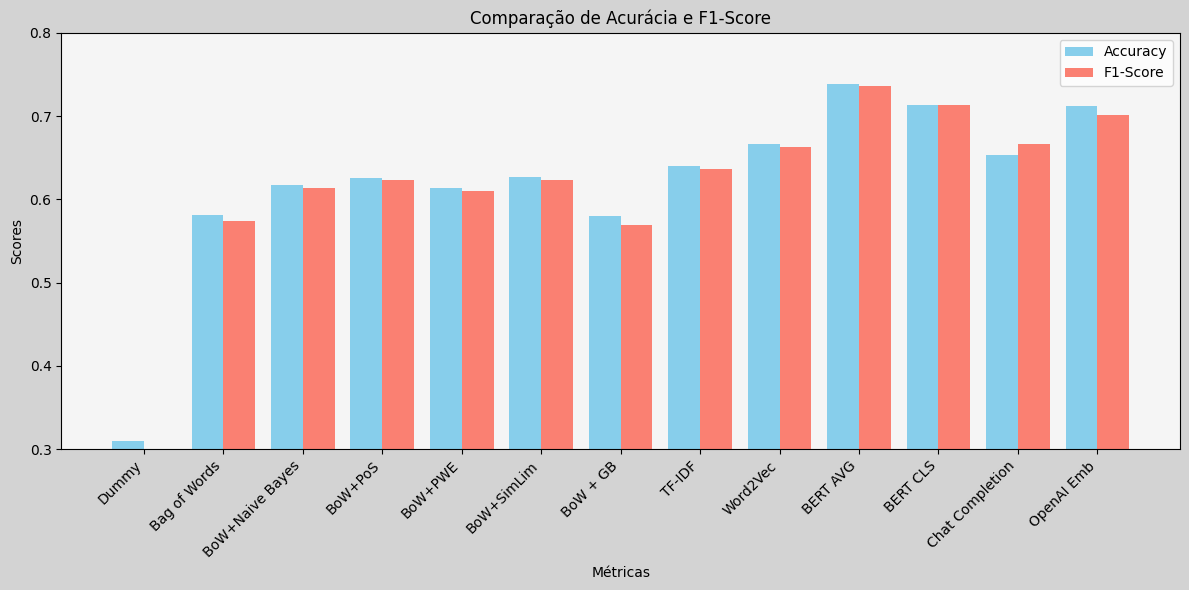

In [ ]:
namespace = globals()

accuracy_scores = []
f1_scores = []

descriptions = list(metrics_dict.values())  # Extraindo as descrições

# Extraindo métricas das variáveis
for metric_name in metrics_dict.keys():
    metric = namespace[metric_name]  # Acessa a variável pelo nome
    accuracy_scores.append(metric['accuracy'])  # Adiciona a acurácia
    f1_scores.append(metric['weighted avg']['f1-score'])  # Adiciona o F1-score ponderado

# Configurando o tamanho do gráfico
plt.figure(figsize=(12, 6))

plt.gcf().set_facecolor('lightgrey')
plt.gca().set_facecolor('whitesmoke')

# Criando o gráfico de barras
x = np.arange(len(metrics_dict))  # Índices das métricas
bar_width = 0.4  # Largura das barras

# Barras para acurácia
plt.bar(x - bar_width/2, accuracy_scores, width=bar_width, label="Accuracy", color='skyblue')

# Barras para F1-score
plt.bar(x + bar_width/2, f1_scores, width=bar_width, label="F1-Score", color='salmon')

# Configurações do gráfico
plt.xlabel("Métricas")
plt.ylabel("Scores")
plt.title("Comparação de Acurácia e F1-Score")
plt.xticks(x, descriptions, rotation=45, ha="right")  # Rotaciona os rótulos para melhor visualização
plt.ylim(0.3, 0.8)  # Limite do eixo Y
plt.legend()

# Exibindo o gráfico
plt.tight_layout()
plt.show()

#### Acurácia em ordem crescente

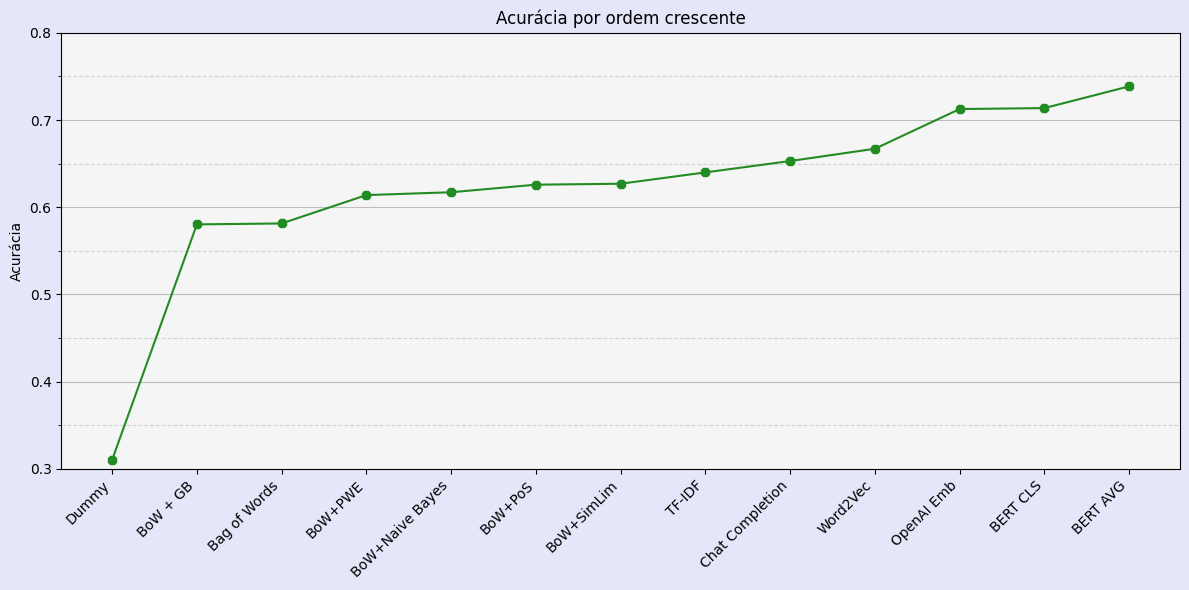

In [ ]:
# Ordenando as métricas por acurácia
sorted_indices = np.argsort(accuracy_scores)  # Índices ordenados pela acurácia
descriptions_sorted = [descriptions[i] for i in sorted_indices]  # Ordenando as descrições
accuracy_scores_sorted = [accuracy_scores[i] for i in sorted_indices]  # Ordenando os valores de acurácia

# Configurando o tamanho do gráfico
plt.figure(figsize=(12, 6))

plt.gcf().set_facecolor('lavender')
plt.gca().set_facecolor('whitesmoke')

plt.plot(descriptions_sorted, accuracy_scores_sorted, marker='8', color='forestgreen')

# Configurações do gráfico
plt.ylabel("Acurácia")
plt.title("Acurácia por ordem crescente")
plt.xticks(rotation=45, ha="right")  # Rotaciona os rótulos para melhor visualização
plt.ylim(0.3, 0.8)  # Limite do eixo Y

# Adicionando mais grades no eixo Y
major_ticks = np.arange(0.3, 0.81, 0.1)  # Ticks principais (com rótulos)
minor_ticks = np.arange(0.3, 0.81, 0.02)  # Ticks secundários (apenas grades)

plt.yticks(major_ticks)  # Define apenas os ticks principais como rótulos
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.05))  # Adiciona ticks menores
plt.grid(which='major', axis='y', linestyle='-', alpha=0.8)  # Grades principais
plt.grid(which='minor', axis='y', linestyle='--', alpha=0.5)  # Grades secundárias

# Exibindo o gráfico
plt.tight_layout()
plt.show()

### Função classificar()

In [ ]:
# @title Função única para classificação das frases de acordo com o modelo requerido

def classificar(frase, metodo, vectorizer=None, modelo=None, modelo_w2v=None, tokenizer=None, model=None, classifier=None, device="cpu"):
    """
    Classifica uma frase usando diferentes métodos de vetorização e modelos de classificação.

    Parâmetros:
        frase (str): Frase a ser classificada.
        metodo (str): Método de vetorização ('bow', 'tfidf', 'w2v', 'roberta').
        vectorizer: Vetorizador para 'bow' ou 'tfidf' (opcional).
        modelo: Modelo de classificação para 'bow' ou 'tfidf' (opcional).
        modelo_w2v: Modelo Word2Vec (opcional).
        tokenizer: Tokenizador para 'roberta' (opcional).
        model: Modelo RoBERTa para vetorização (opcional).
        classifier: Classificador para 'roberta' (opcional).
        device: Dispositivo para execução ('cpu' ou 'cuda', opcional).

    Retorna:
        Predição da frase.
    """
    if metodo == 'bow':
        # Vetorizar a frase usando o modelo Bag of Words
        vetor = vectorizer.transform([frase])
        # Fazer a previsão com o classificador treinado
        predicao = modelo.predict(vetor)
        return predicao[0]

    elif metodo == 'tfidf':
        # Vetorizar a frase usando o modelo TF-IDF
        vetor = vectorizer.transform([frase])
        # Fazer a previsão com o classificador treinado
        predicao = modelo.predict(vetor)
        return predicao[0]

    elif metodo == 'w2v':
        # Vetorizar a frase usando o modelo Word2Vec
        vetor = vectorize_w2v(frase, modelo_w2v).reshape(1, -1)
        # Fazer a previsão com o classificador treinado
        predicao = modelo.predict(vetor)
        return predicao[0]

    elif metodo == 'bert':
        # Vetorizar a frase usando o modelo BERT com suporte ao device
        vetor = vectorize_bert(frase, tokenizer, model, device).reshape(1, -1)
        # Fazer a previsão com o classificador treinado
        predicao = classifier.predict(vetor)
        return predicao[0]

    else:
        raise ValueError("Método de classificação inválido. Escolha entre 'bow', 'tfidf', 'w2v' ou 'bert'.")

### Matrizes de confusão e redução de dimensionalidade

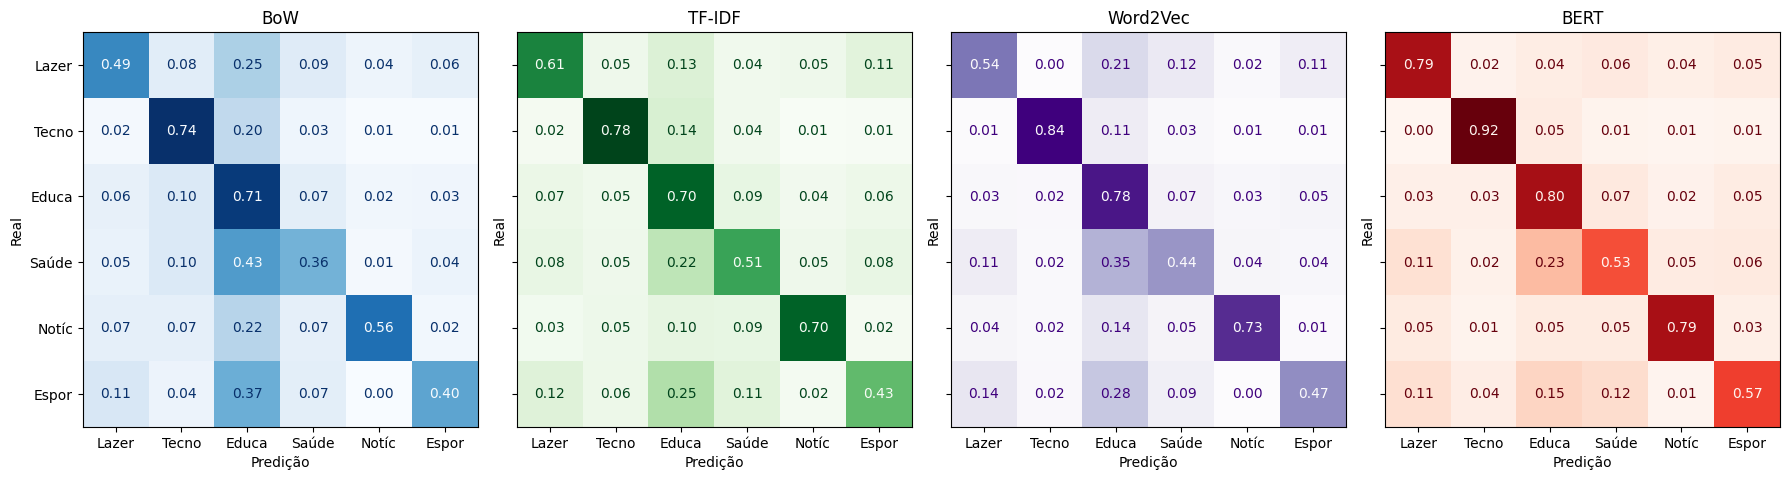

In [ ]:
# @title Matriz de confusão para os 4 modelos

label_mapping = {original: str(original)[:5] for original in y_test.unique()}

# Substituir os rótulos originais pelos novos rótulos
y_test_mapped = y_test.map(label_mapping)
y_pred_bow_mapped = [label_mapping[label] for label in y_pred_bow]
y_pred_tfidf_mapped = [label_mapping[label] for label in y_pred_tfidf]
y_pred_w2v_mapped = [label_mapping[label] for label in y_pred_w2v]
y_pred_bert_mapped = [label_mapping[label] for label in y_pred_bert]

# Função para plotar uma matriz de confusão normalizada
def plot_normalized_cm(y_true, y_preds, labels, ax, title, cmap):
    cm = confusion_matrix(y_true, y_preds, normalize="true")  # Matriz normalizada
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=cmap, values_format=".2f", ax=ax, colorbar=False)
    ax.set_title(title)
    ax.set_xlabel("Predição")
    ax.set_ylabel("Real")
    ax.tick_params(axis='y', rotation=0)  # Exibir os rótulos do eixo Y de forma vertical

# Criando subplots para as 3 matrizes
fig, axes = plt.subplots(1, 4, figsize=(18, 6), sharey=True)


plot_normalized_cm(y_test_mapped, y_pred_bow_mapped, list(label_mapping.values()), axes[0], "BoW", "Blues")
plot_normalized_cm(y_test_mapped, y_pred_tfidf_mapped, list(label_mapping.values()), axes[1], "TF-IDF", "Greens")
plot_normalized_cm(y_test_mapped, y_pred_w2v_mapped, list(label_mapping.values()), axes[2], "Word2Vec", "Purples")
plot_normalized_cm(y_test_mapped, y_pred_bert_mapped, list(label_mapping.values()), axes[3], "BERT", "Reds")


# Ajustar o layout
plt.tight_layout()
plt.show()

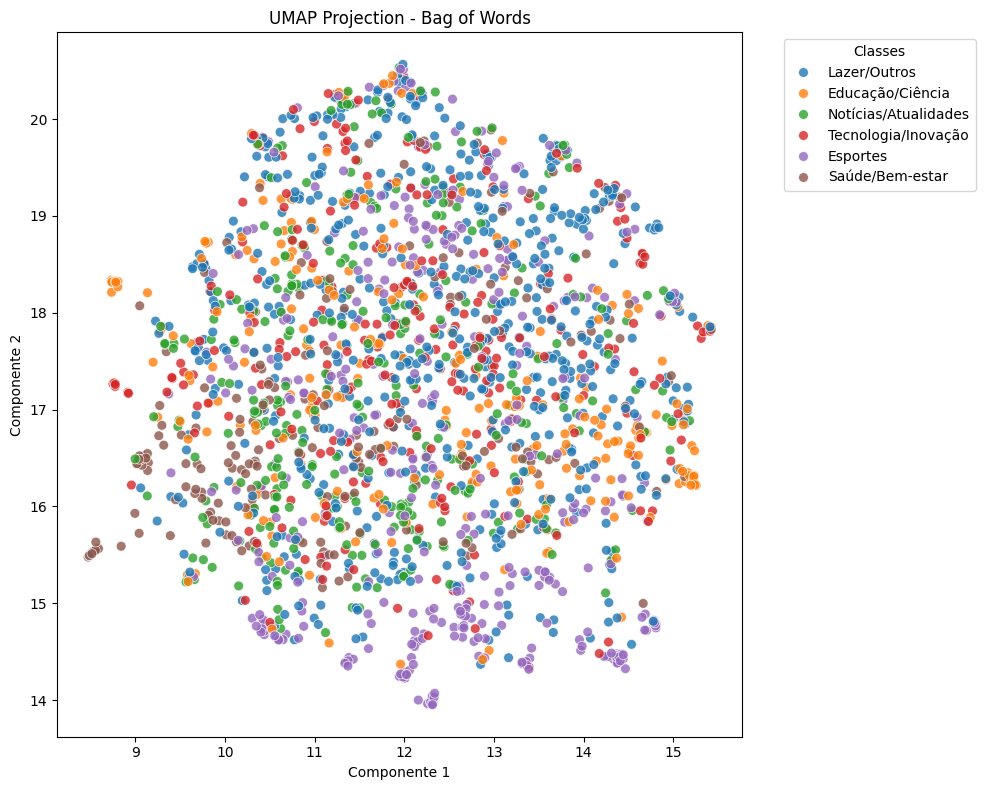

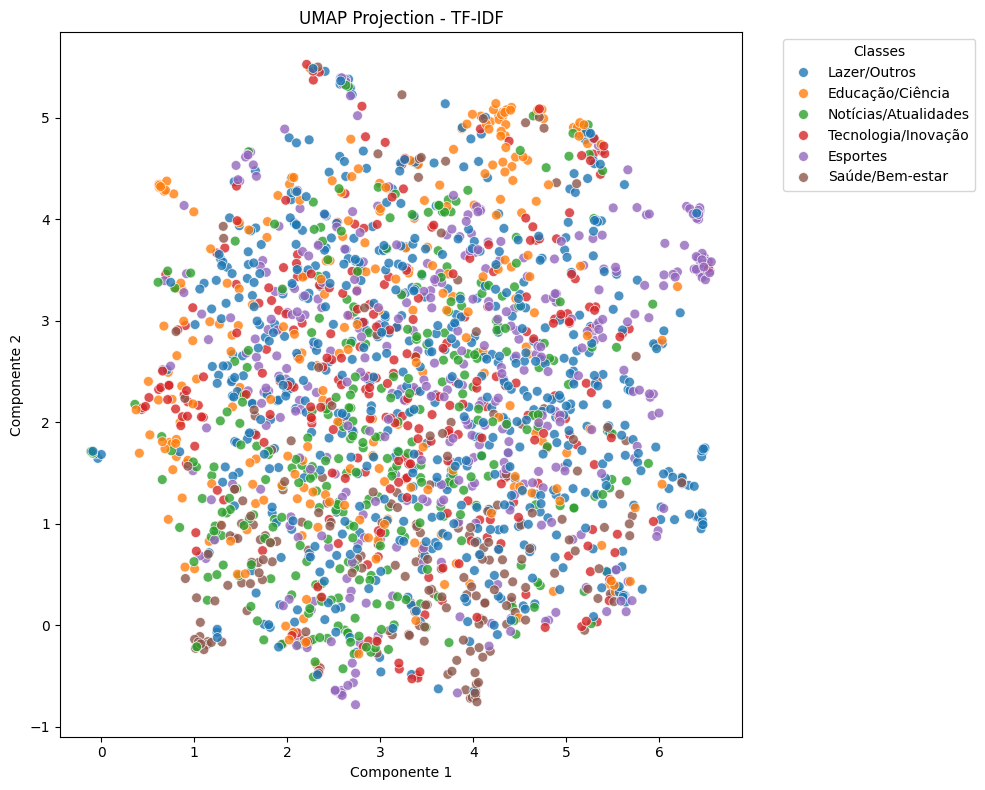

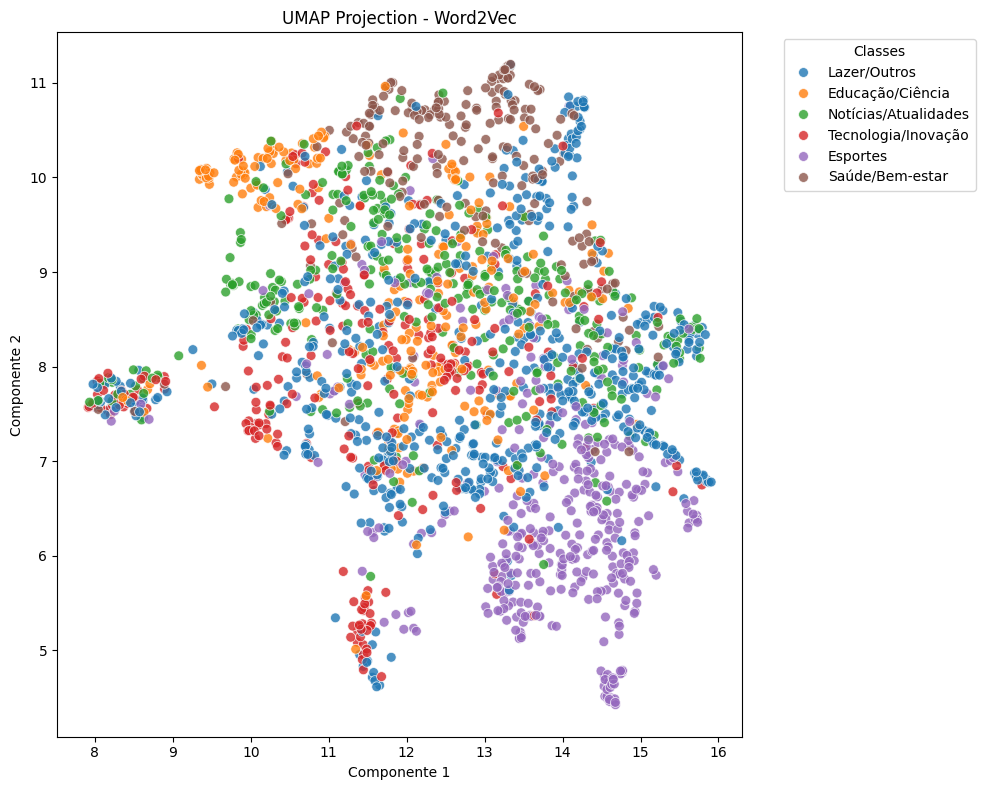

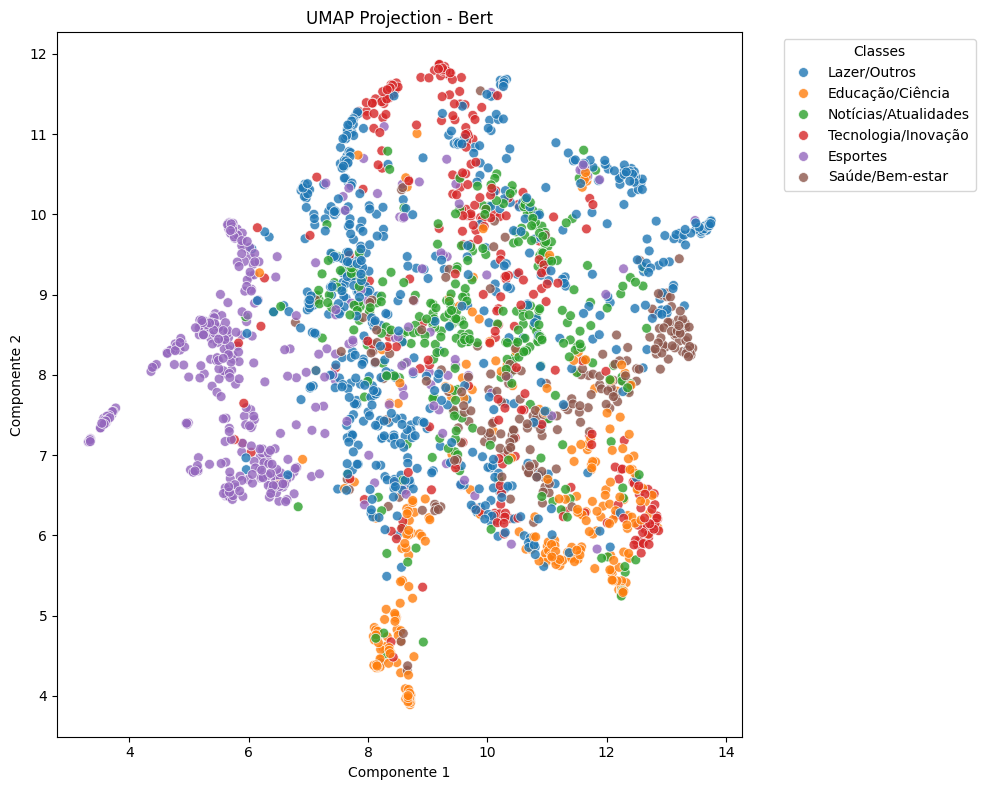

CPU times: user 4min 53s, sys: 4.09 s, total: 4min 57s
Wall time: 5min 6s


In [ ]:
%%time
# @title Reduzindo a dimensionalidade para exibição no plano

def plot_umap(X_train, y_train, title):
    # Escalar os dados para o intervalo [0, 1]
    X_scaled = MinMaxScaler().fit_transform(X_train.toarray() if hasattr(X_train, "toarray") else X_train)

    # Inicializar e ajustar o UMAP
    mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

    # Criar um DataFrame com as projeções 2D
    df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
    df_emb["label"] = y_train.reset_index(drop=True)

    # Plotar as projeções 2D
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df_emb, x="X", y="Y", hue="label", palette="tab10", s=50, alpha=0.8)
    plt.title(f"UMAP Projection - {title}")
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Aplicação para cada representação de texto
plot_umap(X_train_bow,     y_train, "Bag of Words")
plot_umap(X_train_tfidf,   y_train, "TF-IDF")
plot_umap(X_train_w2v,     y_train, "Word2Vec")
plot_umap(X_train_bert,    y_train, "Bert")



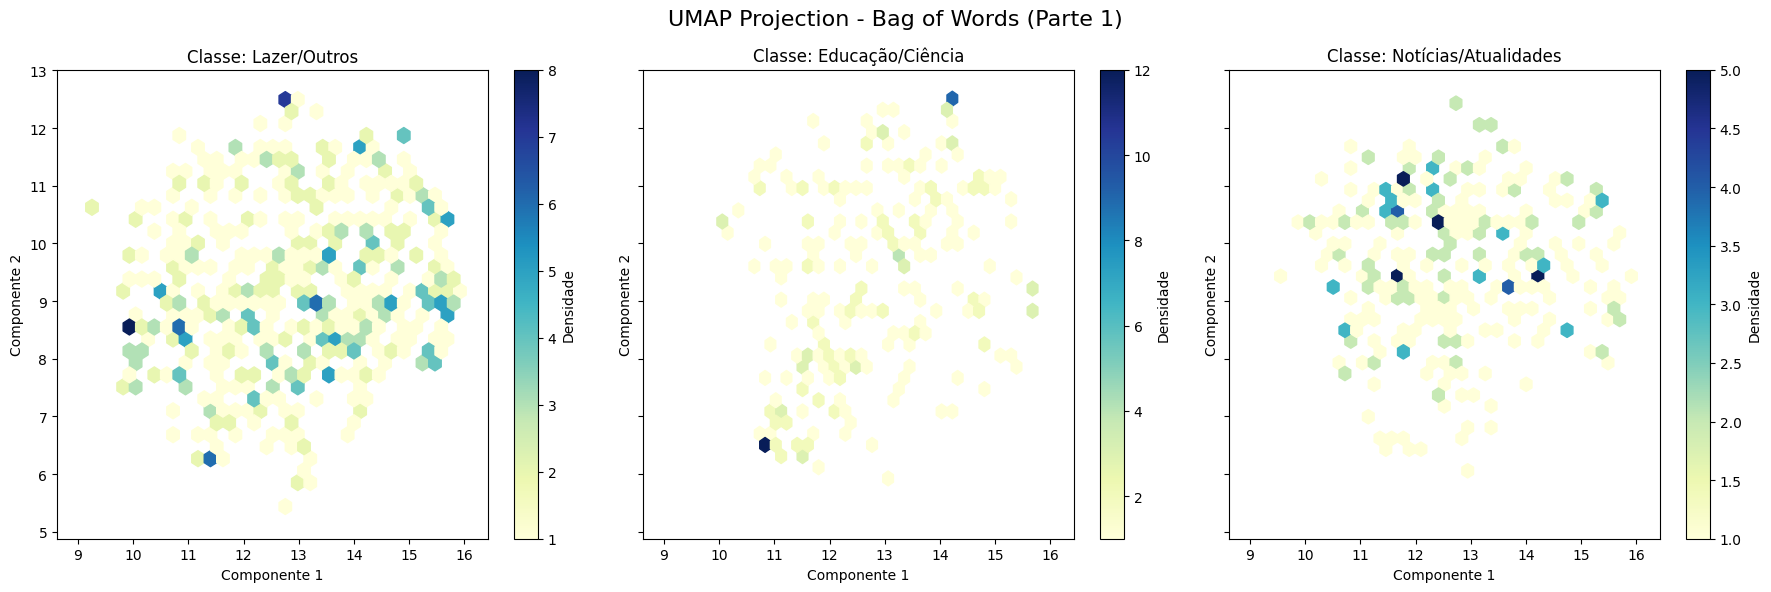

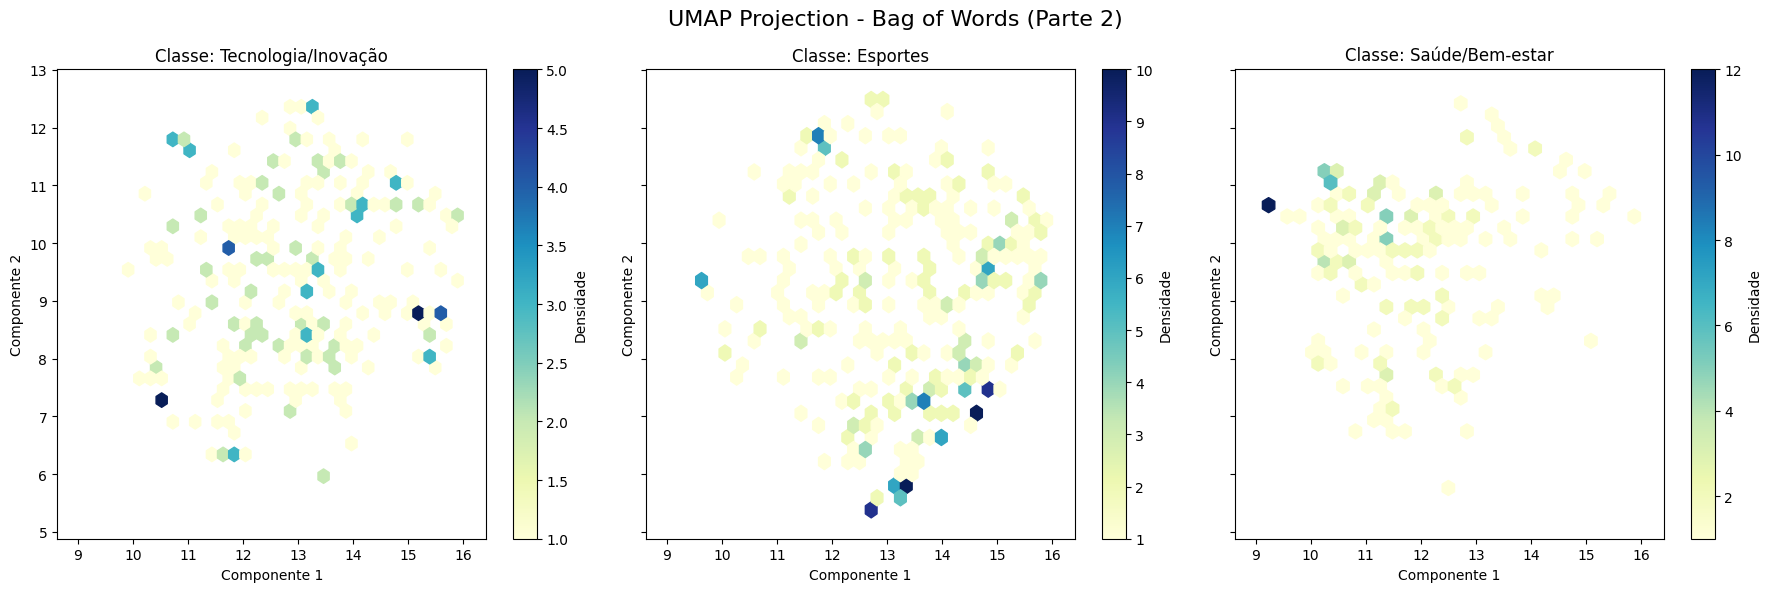

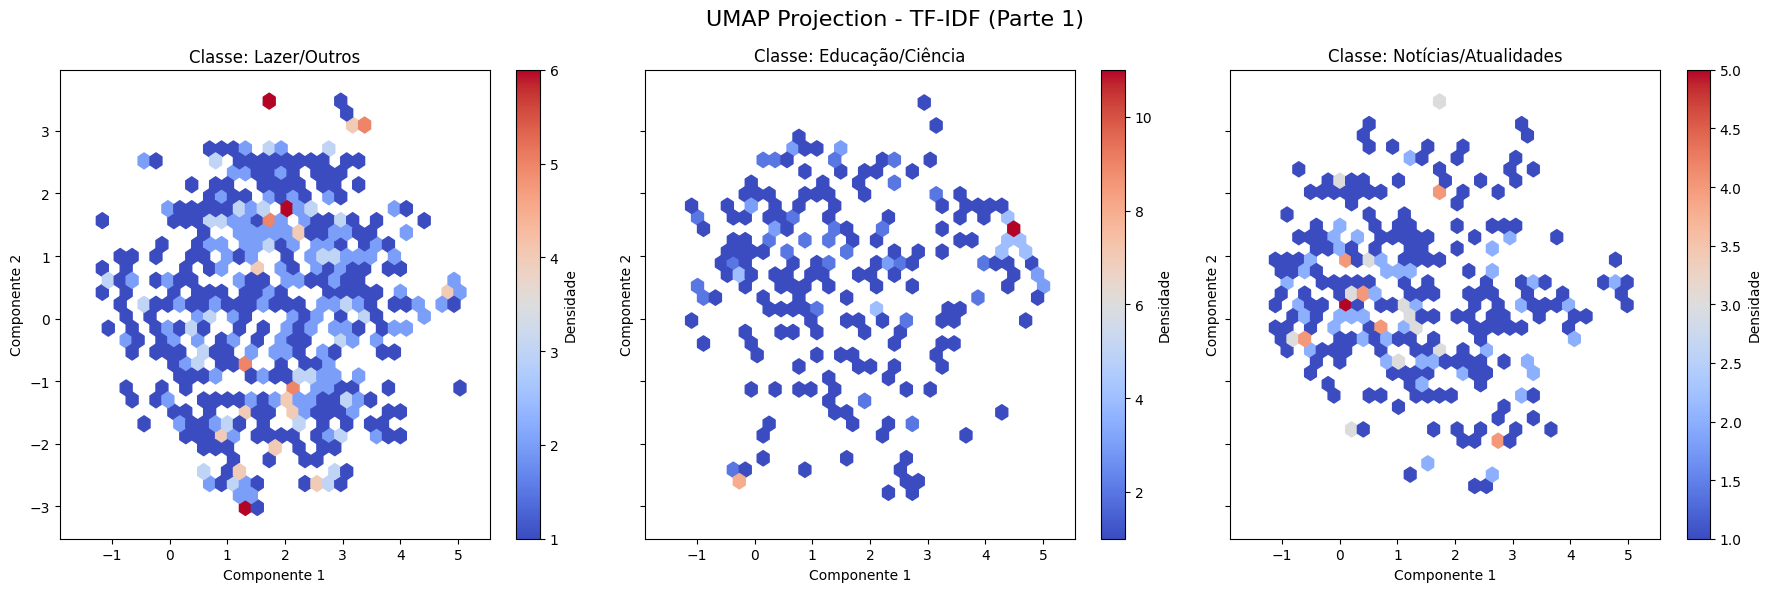

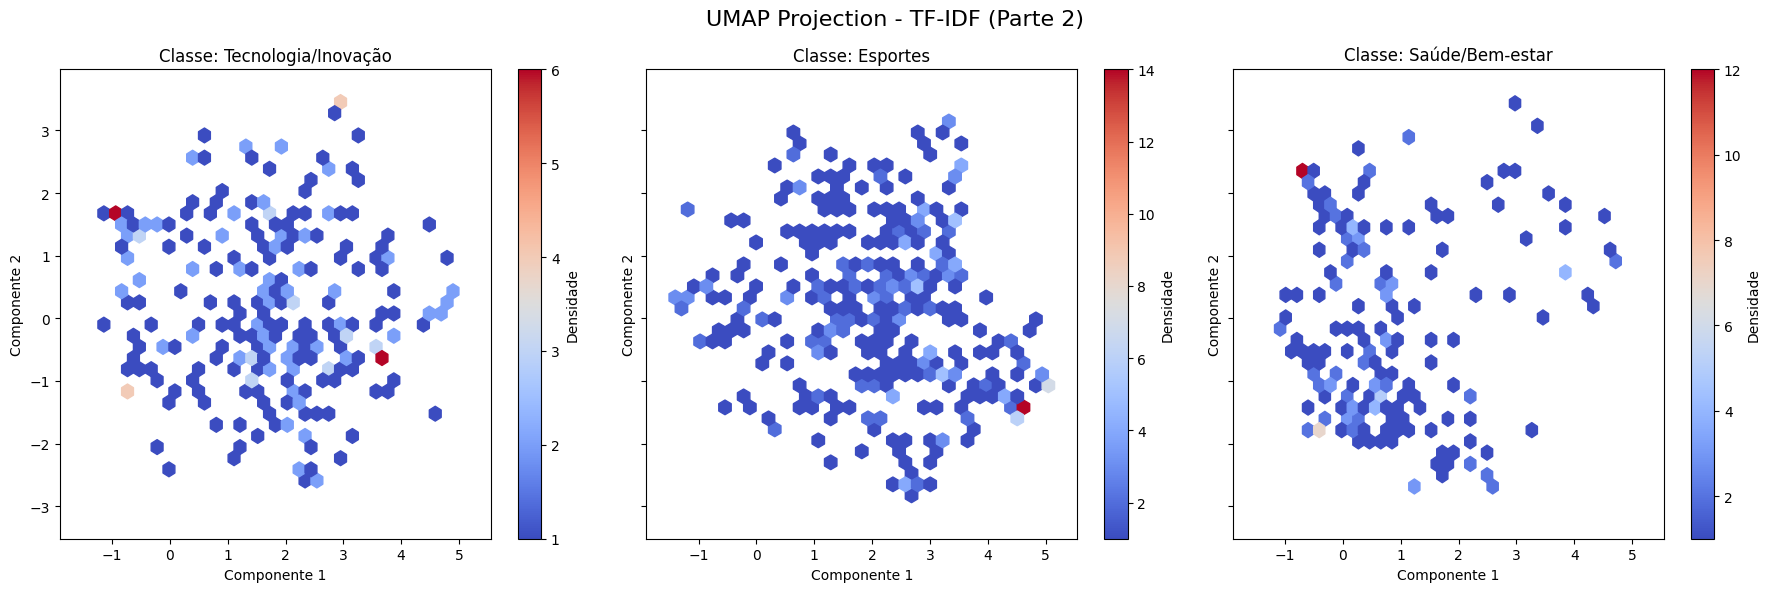

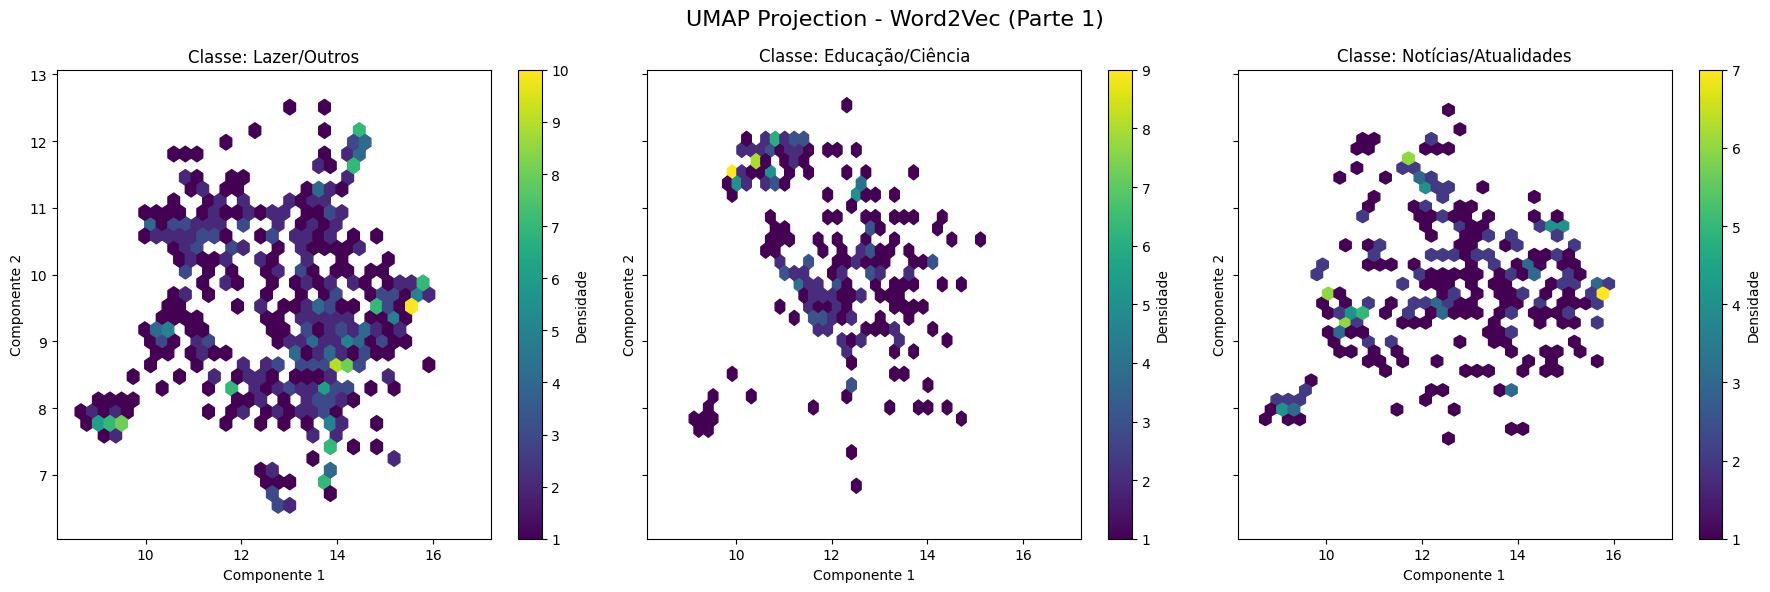

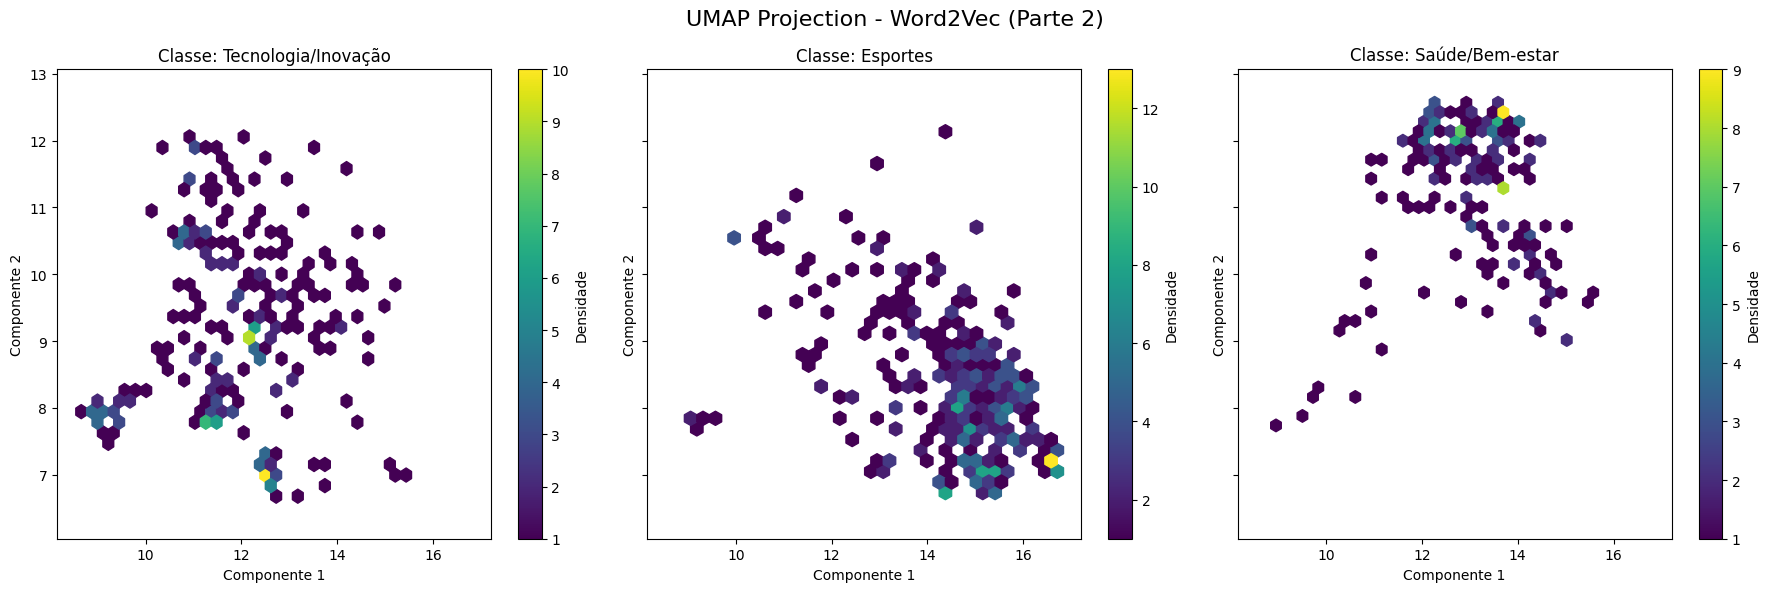

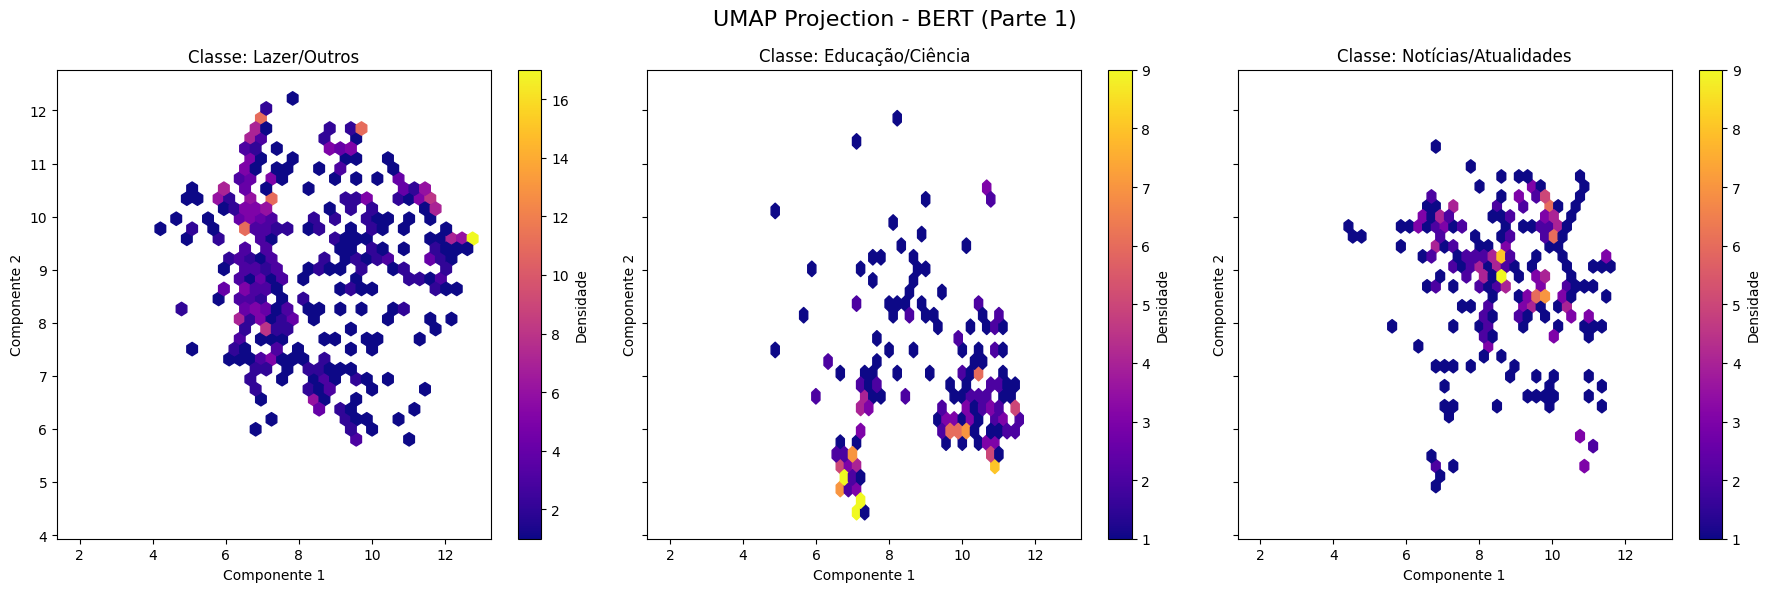

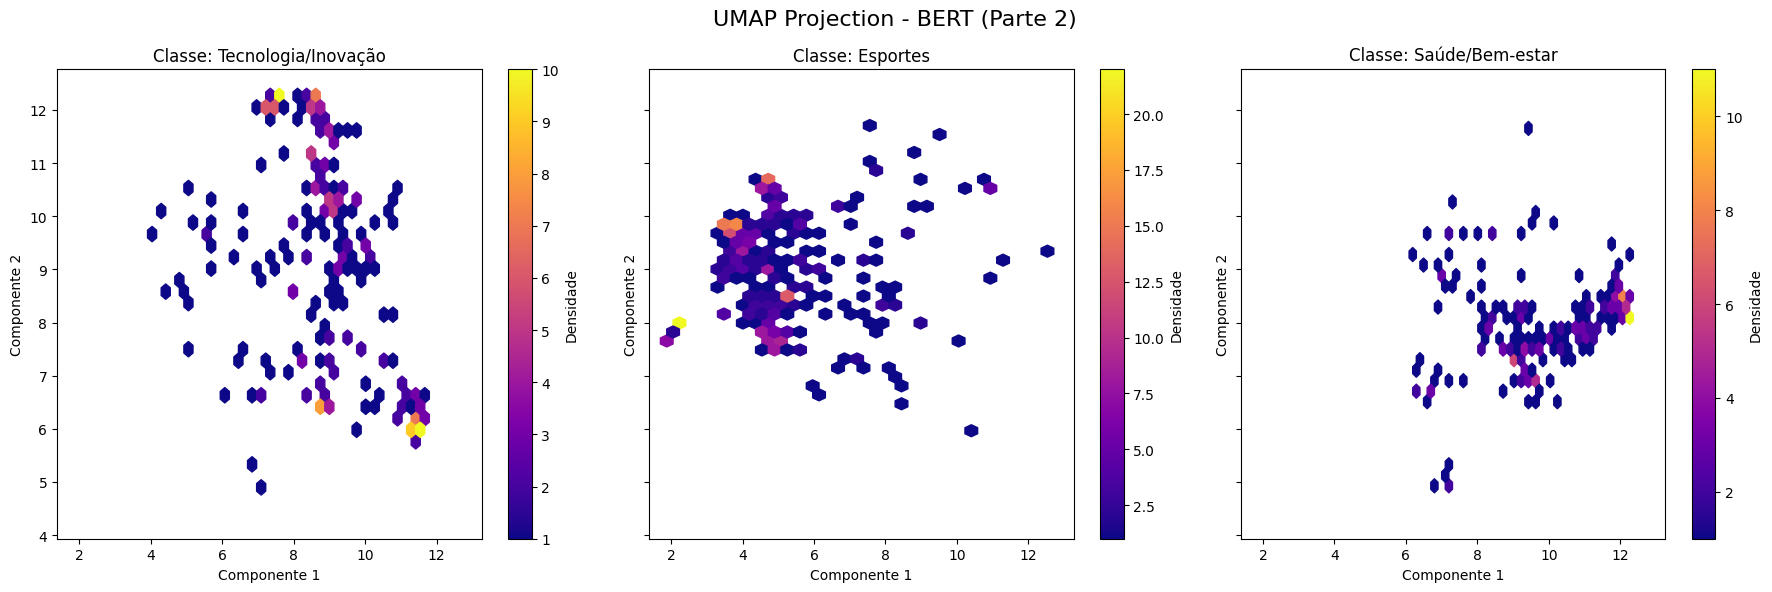

CPU times: user 4min 48s, sys: 3.21 s, total: 4min 51s
Wall time: 5min 22s


In [ ]:
%%time
def plot_umap_by_class(X_train, y_train, title, hexbin_cmap='Blues'):
    """
    Plota projeções UMAP de 2D para classes específicas, exibindo os gráficos em lotes fixos de 3 por vez.

    Parameters:
        X_train: Dados de treinamento.
        y_train: Rótulos de classe associados aos dados.
        title: Título geral do gráfico.
        hexbin_cmap: Mapa de cores para o hexbin.
    """
    # Escalar os dados para o intervalo [0, 1]
    X_scaled = MinMaxScaler().fit_transform(X_train.toarray() if hasattr(X_train, "toarray") else X_train)

    # Inicializar e ajustar o UMAP
    mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

    # Criar um DataFrame com as projeções 2D
    df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
    df_emb["label"] = y_train.reset_index(drop=True)

    # Identificar as classes únicas
    unique_labels = df_emb["label"].unique()

    # Dividir as classes em dois grupos de 3
    group_1 = unique_labels[:3]
    group_2 = unique_labels[3:]

    # Função auxiliar para plotar um grupo
    def plot_group(labels_subset, part_idx):
        fig, axes = plt.subplots(1, len(labels_subset), figsize=(6 * len(labels_subset), 6), sharex=True, sharey=True)

        # Garantir que axes seja iterável, mesmo com um gráfico
        if len(labels_subset) == 1:
            axes = [axes]

        for ax, label in zip(axes, labels_subset):
            # Filtrar os dados para a classe atual
            subset = df_emb[df_emb["label"] == label]

            # Plotar os dados com hexbin e cmap customizado
            hexbin = ax.hexbin(subset["X"], subset["Y"], gridsize=30, cmap=hexbin_cmap, mincnt=1)

            # Ajustar o título e eixos
            ax.set_title(f"Classe: {label}")
            ax.set_xlabel("Componente 1")
            ax.set_ylabel("Componente 2")
            ax.set_xlim(df_emb["X"].min() - 0.5, df_emb["X"].max() + 0.5)
            ax.set_ylim(df_emb["Y"].min() - 0.5, df_emb["Y"].max() + 0.5)

            # Adicionar uma legenda para o hexbin
            fig.colorbar(hexbin, ax=ax, label='Densidade')

        # Título geral
        fig.suptitle(f"UMAP Projection - {title} (Parte {part_idx})", fontsize=16)
        plt.tight_layout()
        plt.show()

    # Plotar o primeiro grupo
    plot_group(group_1, 1)

    # Plotar o segundo grupo
    plot_group(group_2, 2)

# Exemplo de aplicação para cada representação de texto com cmap customizado
plot_umap_by_class(X_train_bow,   y_train, "Bag of Words", hexbin_cmap='YlGnBu')
plot_umap_by_class(X_train_tfidf, y_train, "TF-IDF", hexbin_cmap='coolwarm')
plot_umap_by_class(X_train_w2v,   y_train, "Word2Vec", hexbin_cmap='viridis')
plot_umap_by_class(X_train_bert,  y_train, "BERT", hexbin_cmap='plasma')


### Salvando os modelos em joblib e pickle

In [ ]:
# @title Salvando o modelo BoW

import pickle
from joblib import dump, load

dump(vectorizer_bow, "vectorizer_bow.joblib")
dump(classifier_bow, "classifier_bow.joblib")

with open("classificar.pkl", "wb") as f:
    pickle.dump(classificar, f)

In [ ]:
# @title Carregando o modelo BoW

# Carregar os objetos salvos
vectorizer_bow = load("vectorizer_bow.joblib")
classifier_bow = load("classifier_bow.joblib")

# Carregar a função
with open("classificar.pkl", "rb") as f:
    classificar = pickle.load(f)

## Parte 3: Aplicando o treinamento nos dados do trabalho de LDA (Noticias do site opopular.com.br, de Goiânia)

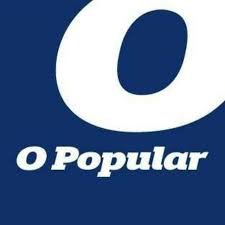

In [ ]:
# @title Resgatando o corpo de notícias do trabalho anterior

extracted_data = """title,description,published date,url,publisher
Nuvem de poeira: entenda fenômeno que encobriu cidades em Goiás - O Popular,Nuvem de poeira: entenda fenômeno que encobriu cidades em Goiás  O Popular,"Mon, 02 Dec 2024 22:35:45 GMT",https://news.google.com/rss/articles/CBMipwFBVV95cUxOYmw2OUFKOWFDUDZpdV9rNjU4cGc0TGpZakdod083dld5RnlmNUIybXo5Z2JQNXZ4MERUWUItZFFGRkkwbHpMOGpXVnloNHJVR2JRVVBacV9SSXhVMVFFZm40LWFkbENDWVBweXRHSGEtbDdyQjBvRU0xdVRyQVJVZ25zQ3QwbXBOelAwRTM3WklLMzJoUk5rM3Q4eF9GVlZEYWR3aFYydw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
MP pede intervenção na área da saúde - O Popular,MP pede intervenção na área da saúde  O Popular,"Fri, 06 Dec 2024 22:25:02 GMT",https://news.google.com/rss/articles/CBMid0FVX3lxTE13WGJJZTRhN3FxMFdxTkU3V3lkWk5xTEVodTJyRHk4WHlQMktpODFZbFRLdGtEM19iZmlob0ZkQWFVTk53NksxUTVWNnI5TzlwQUU4LU9RQWNibTZfS2dHV3o3OXdIY1A3dWZjNjltODE4cllDZVZN0gF3QVVfeXFMTXdYYkllNGE3cXEwV3FORTdXeWRaTnFMRWh1MnJEeThYeVAyS2k4MVlsVEt0a0QzX2JmaWhvRmRBYVVOTnc2SzFRNVY2cjlPOXBBRTgtT1FBY2JtNl9LZ0dXejc5d0hjUDd1ZmM2OW04MThyWUNlVk0?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://stories.opopular.com.br', 'title': 'O Popular'}"
"Incêndio destrói galpão de supermercado em Senador Canedo, e prejuízo é estimado em R$ 3 milhões; vídeo - O Popular","Incêndio destrói galpão de supermercado em Senador Canedo, e prejuízo é estimado em R$ 3 milhões; vídeo  O Popular","Sat, 30 Nov 2024 17:27:50 GMT",https://news.google.com/rss/articles/CBMi2gFBVV95cUxQQUpRUU9iczRDY2lLbXBWRnFMc2w1ZWt0djhvZ1BFNkZtWkcxRHZmUmp2TFJkeWFENF9VZkdZM1FQaVpmYy04UE9CRUcyakpWOVI0eTdFTi1XOFJPWUlZM21RVVlIS2VyeGVJSVJCTjBDVHVEWmxiMWk2MjhxZWtmZ1Zhc3A3akEwV0xDSHpKelZmS296UDFpLW1LbnY1WFhhM2FMMjZMUThkVWJWN1BZV0N6VENidUVXTE1qbVFQUTk5bUcwYUd1eFhQVkp2TmhBX3AwbXpIWVh6dw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Famílias descobrem 3 anos depois que filhos foram trocados na maternidade, em Inhumas - O Popular","Famílias descobrem 3 anos depois que filhos foram trocados na maternidade, em Inhumas  O Popular","Thu, 05 Dec 2024 23:37:30 GMT",https://news.google.com/rss/articles/CBMixAFBVV95cUxQM0UyR1VjRHpBdmwxTG83ZmZzWll3dmNCWXJzNGxEcUQ4Z1Z3YWk4X0JIOVlXMzdBS0p5RloyU3JOc1ZITU8zOGtJaDMxdUhnUTFFb1NSeGEtTHBjcVQxQ3d5UmpISkJDa09HcWFPSHVPalU5MkdTaUFDUVpRMFF6b0hWc1pfdFVvdFRYT2RCRWNsUlNXUGZNNnhjS2dtVE5lNndxU1B6WmtWMlg1WnBfZloxTUFZTk9vRUVBN0VZelpmOW1F?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Secretária de Saúde de Goiânia recém-empossada, Cynara Mathias pede demissão - O Popular","Secretária de Saúde de Goiânia recém-empossada, Cynara Mathias pede demissão  O Popular","Wed, 04 Dec 2024 19:12:12 GMT",https://news.google.com/rss/articles/CBMiuAFBVV95cUxOMDd1b25pdV9sbjdXOEkwNWpLVjBoSXJwVTVCRm0ycS12NjBqei03YmlBNzNpUndjQXZyVWlTVDFDbDlPV0pXcU8ySVM1VEx5dGNsaEdNS2ctZnJ2YjNxc2RlbDBmendHNDNSTkRVZWJ2ZkVkRGpkUkdWV3RTbVd2NnJ5c3pFWVNweDZHa21RTmVfYVB2aXVYUDV6SkRjUk1MckFVNWdPZE1jbmhTT2Nfb1V1bkxXcC1v?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
BACULEJO - O Popular,BACULEJO  O Popular,"Fri, 06 Dec 2024 02:09:14 GMT",https://news.google.com/rss/articles/CBMigAFBVV95cUxPTFZ1UW9qTWtlaUs1bUgzM3ZoMlRMMndQNWNnZTNyMjVDNmwwMldHb0ZUOHhtRDB3VFY5MkVXbjg4LXJ3ZTA1bWphRnhqc3Y5NzlnNmNGVG9Dalc0d0RVR1RqTVlzYUYxSUpvNTBMYmd1SmZ5QWZFLU9RRUphdGdGcQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Servidora pública da Prefeitura de Goiânia que morreu após procedimento estético deixa dois filhos - O Popular,Servidora pública da Prefeitura de Goiânia que morreu após procedimento estético deixa dois filhos  O Popular,"Wed, 04 Dec 2024 01:52:30 GMT",https://news.google.com/rss/articles/CBMi1wFBVV95cUxPUXlieWxua2tacndqSGwyNE1CZ0FFVF90cnQwX0hYSF9nWUVXdHZxUFBIcUwyRV9KN1FMRWhfMFFZbzhPVVdUMDliVjhfSXE5dWdPNDlLRktySmtPdi0weEY2TVAwT3Y0dU5mYXFyb3hBVV9TZHBhS3dtcjBVd2YxSGI1NFB3b3lETG1UbUtHZ3VleDk5Vzg2YjBadDlCMXM2Sk9KMkNZRFUwQ2VzbzR1QUxzWVpRNTRhMEJFQ0lTVWdkUzNMRjRXYnYzclB5TmNOMDJtNUZwVQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Alego promete R$ 41 milhões para Saúde na capital - O Popular,Alego promete R$ 41 milhões para Saúde na capital  O Popular,"Wed, 04 Dec 2024 14:15:40 GMT",https://news.google.com/rss/articles/CBMilgFBVV95cUxQelNJREV5Y0VaSldyNENpREdYXzBmNlJ0Y0d5VEhJQWU4QVMya09JUWhUYTJINF9Rcl9xWHZVVjV1SWtOSjFjTTQ0azBMSWlDR2RkVk9QQWVXT2NTSzZ3ZW1nMUkwNVk3eUxuMFpodldGSWV5Yl96a0FLS3k1ZXBhSTJQSVhIQ3gxMjlqZDBPVVR3eW9mMHc?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Ginásio vira abrigo temporário para população de rua - O Popular,Ginásio vira abrigo temporário para população de rua  O Popular,"Wed, 04 Dec 2024 13:53:04 GMT",https://news.google.com/rss/articles/CBMimgFBVV95cUxQeGgzMlhMRGszU0dIX3BpV0xmS3RuaVdEWkdvMGpXOWZSMkRVOXZ0a1B6QnNrVW1Yb1BDMGZCT2dfMUo1b3VDLVEzUm9NMnhXQVRWVi1idDBmYlhmUWtIOE9CaGNLaC1VYXc5TEt1SEdDNkJPRldPRV9pT3owclNOVFVkM1I4X2MyVWlkYUs0WlhfdklWaFR0NURR?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Transformação digital favorece governança e expansão de operações - O Popular,Transformação digital favorece governança e expansão de operações  O Popular,"Sat, 07 Dec 2024 02:25:21 GMT",https://news.google.com/rss/articles/CBMisgFBVV95cUxORHhCaUNWYW9heUJ6RWtJME5UT1lCVk9aSldMWUdaS0ZaU1hQVjNrZC1wWkJ2c3hzaUVvR29ja2F6YVRzLUNMVzZsc0xwUEsyQmNydGQzQkgxa1ZUM0dBQWlvdUx5a3B2VlJDbEZLamxNMUJQcGtUZ2xiM2k3amNqTVlJeXhjRncxYnZUeE5wVmtSWS1VZGdmWXhjVWVSN1BEbzZyMHJiQk5VcmZnM2NPa21n?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://www.opopular.com.br', 'title': 'O Popular'}"
Jackson Abrão entrevista Paulo Ortegal - O Popular,Jackson Abrão entrevista Paulo Ortegal  O Popular,"Mon, 02 Dec 2024 14:35:19 GMT",https://news.google.com/rss/articles/CBMiiAFBVV95cUxNN3hXOEVtUEMtU01NSm5MSzRnVHV6TkRaX0VaM1BLTW9CaF9ZaUlVR3dvZEY0S1laeUd5M2Q2MXVBSk5rMnBaTHE5Y1BkWUpsV2t3TmVOekpHTFRhbUVVdjgzTi1EMGFSZkxVS3MwQUJLYWlnSHRaTFhPem1XaVBhQTdzQ0xHQkc1?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Presidente de Israel discute com Musk libertação de reféns do Hamas, diz TV - O Popular","Presidente de Israel discute com Musk libertação de reféns do Hamas, diz TV  O Popular","Fri, 06 Dec 2024 18:30:23 GMT",https://news.google.com/rss/articles/CBMiugFBVV95cUxNYldESTlaZFh3RC1vN2ZucHFVWDMxZ0YxVm1kOFlYX3p0SXJkbE9HTFh6X2p5alhtY2pHVVV2d3pTOExVWlZKSW5nNVlwVWVFS21XREhRU0ZycU9tU3M4TTJ2LWE2NzRHeG92T1NwRkNQNi1OQ3FYaHJVdEN1LUFzWHgxaDZJOGVXenBqOU1IMGRGQ1p5UVlWUjRycGZ4NHVVZEFyc1VwcGowSTdyNkdQQUcxVGY1YnZ4b2c?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://www.opopular.com.br', 'title': 'O Popular'}"
Jurado do MasterChef vende por R$ 70 doce que imita arte de banana de R$ 36 milhões - O Popular,Jurado do MasterChef vende por R$ 70 doce que imita arte de banana de R$ 36 milhões  O Popular,"Thu, 05 Dec 2024 17:37:20 GMT",https://news.google.com/rss/articles/CBMiwgFBVV95cUxOMEhuRm5XLVBSc0xjalBkN1pfU3Ztb3NpUDJreFBCNkFGTkt0N19CekZXOTFIOC1kN2ZzaWN2U1FpZVgwOHdtdTVHMjlvRk5zMmU3Tl9uLUtsMUlMZHJ6UjQ1UWVrYVlBSmt0T1NOMHFTbUREU1dYMWhPdzZDRUMtX3E0V0MxdE1KLXpBZi1UV1FISXZ1QnJvd2xRbFhGZV9GN3RtejJiTXh3Q0I3ZTNzZ3pPbE44X0htQ2lZMi1ib2UtUQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Pedro Guilherme Gioia assume Secretaria Municipal de Saúde de Goiânia - O Popular,Pedro Guilherme Gioia assume Secretaria Municipal de Saúde de Goiânia  O Popular,"Wed, 04 Dec 2024 22:46:30 GMT",https://news.google.com/rss/articles/CBMisAFBVV95cUxPTnBQTzlRbVlrYzZYbGdtWVBybFNpd1dPeURTd21NWllyMm03ODNRMnFkYW9rNlRCVFNncGZ0RE1nY05NU0JNYUcyWWQ0TkNDRndsQVlfcWFpQmxTMUN4ZjdoNzduSmttYnlSMmprLUNMS1dfSExKTlkzWmhTS1pEeHpPM2Yyb0k5aTN4MElxaHM4LW5jVHJDUGprMjVzQ1huZGIzMElOMVJHM1BvMXItTQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Governo de Goiás vai assinar contrato para ter MotoGP a partir de 2026 - O Popular,Governo de Goiás vai assinar contrato para ter MotoGP a partir de 2026  O Popular,"Wed, 04 Dec 2024 23:17:01 GMT",https://news.google.com/rss/articles/CBMisgFBVV95cUxPQXkxd01SS3dZQTdLdHp3MldfSHAyLWFfNUFuZHFPd2VzNy1uQmtUeXE0S21NVjZ0WE9WcEpqYkkwOXlQRXI5OWMyWlhjblJNaDR2MkNBV0VRb1JITGkxeXNqdUdyTUNFOVdwU1FWTldNWUgyQ3ZNOWNKeFFKWk9fU1B5M3B5U2hwVFZOdnI2X2lnSDlBR2x4enZ1cHJaaGl6ZjQyTzl6TjY2d3VfcDhlM2Fn?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Goiânia sedia a 9ª e última etapa da Copa Truck 2024 - O Popular,Goiânia sedia a 9ª e última etapa da Copa Truck 2024  O Popular,"Wed, 04 Dec 2024 23:28:19 GMT",https://news.google.com/rss/articles/CBMimAFBVV95cUxNd0VId2VzMzBsUU41d1FSRnpjelJTMGVSY3NMTkprcWJBZ0NsWG00ZEl3VzFZQ21jUHF0MzJVZmJsSUwtenE3bnQ5QVlqbXFSbVlwV0toQVQzWmNSaUxJVUJ4bDI2WE1sQ1JwNGdiSzhvNVB0Vkc0TjkzSzJaMms5Wk9FR3N0VUlfRGFQQUdMZXBjaFVnMnJDSQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
O menino que sustenta o homem - O Popular,O menino que sustenta o homem  O Popular,"Sun, 01 Dec 2024 21:40:01 GMT",https://news.google.com/rss/articles/CBMiiAFBVV95cUxOMkVlcl9OUFZyaU9TY3RqclUzdEhQQ1ZYR0NBNDdNYVRPTE5fM2pYYlUwT2MtQVJrZW5zTmF1c181TGsxTldSMkNNT000ejd1cW1LR2NCTWxlMU4tcVo0TFozcmtaQUhsUGk3NkliX1Nfakx0dWVwMmRCNGhLdkVpbnlhamFwU05F?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Volta Por Cima: Madalena confronta Jão - O Popular,Volta Por Cima: Madalena confronta Jão  O Popular,"Sun, 01 Dec 2024 21:57:01 GMT",https://news.google.com/rss/articles/CBMihwFBVV95cUxOLVItSmg4YWxiWnpRdTJhUjVTWkszNnJ1Wi0teDFCTk5INUZLWTkxWGxHbExGVjZhbmltTnhEOFhVRGEtM0ZpbUxIcFVkamFTcU1NUXJBYjRmdUdFRkVKcTdaVWh0WVpzRkxYQ2FiVHl4bGJHempYX1NvZ3JXZmROd0I4aXp3cE0?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Primeiro museu de Goiânia e marco art déco da cidade, Museu Zoroastro Artiaga passa por restauro completo - O Popular","Primeiro museu de Goiânia e marco art déco da cidade, Museu Zoroastro Artiaga passa por restauro completo  O Popular","Tue, 03 Dec 2024 22:50:22 GMT",https://news.google.com/rss/articles/CBMi4AFBVV95cUxQYklESnBZT2x5SHNjMEtwOGF4YzJYcXc1MXZXX3dtUXpJUjFnejlFZUEzZDBWWFRUYWlHa0FFMWxXVlhWV0hLTVI4d05WemNoRzNxSHNBYUx4ck96QzRVOFNJcjlkd0FFSWM5NDlMRm9VWU5IcXFSSlJLWkZSLWliY3RkUXVnZGxWMG5zcVRRUXFYM0VrMFl4OW1aUjdpM0dTaUZQZkxOMU9adUZyZWNNem1hVnZRRmU4Z3doQmptM3QxU3JPdm1FbWhxSzNXSzFBU2x1aWtRM2VmU2FuX2Nfbg?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Profissionais do cinema feito em Goiás integram projeto de profissionalização - O Popular,Profissionais do cinema feito em Goiás integram projeto de profissionalização  O Popular,"Tue, 03 Dec 2024 22:57:08 GMT",https://news.google.com/rss/articles/CBMivAFBVV95cUxQRkVuSmJyNjROM3VubGZIemIyV3pBUk9ZVmlGcjg5WnAxUGhOODF4SEQwRTBma0t5MTNTWFp4T19mb2lnU1paNnFWS2owRV9aU1BhOFkyYnZRU3JUV2Nrc3ZyZ2FCMFJRVDRrS29kLU1sclRCOTFTMTJLbVRmV1MzOGI5Z29OTzR5ZnZ3SHVJT2Z6T0dYVW8zaVYzcFU5cXh0UmY5UUNfZnRsTmdyaElfRDRUMEtURmhFMFQ3UQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Grupo Ateliê do Gesto encerra temporada do espetáculo 'Fica Comigo' - O Popular,Grupo Ateliê do Gesto encerra temporada do espetáculo 'Fica Comigo'  O Popular,"Tue, 03 Dec 2024 21:46:10 GMT",https://news.google.com/rss/articles/CBMirAFBVV95cUxOZDl5eDdDOXZkRS1MU3lfYkI5VnZJbnBJWllEUGRjMXF5LVFaRXI2RjJJQ2xhTHExLWl3RURNYUZMMWVzanY1WDVJNnc3ZV84NnFTQjhySjRnS0lRS2thUVktS1dtUzlRb1ZSWUphM0JndnlRSElHallpYUhGWHppQ3J2MHRhUVhFcWozZGRzZW96b2t5UHA3YnpmdkxjOXYtdllheWtyaWs0UXRM?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
'Malvinas: O Diário de uma Guerra' e 'Kubrusly: Mistério Sempre Há de Pintar por Aí' estreiam no Globoplay - O Popular,'Malvinas: O Diário de uma Guerra' e 'Kubrusly: Mistério Sempre Há de Pintar por Aí' estreiam no Globoplay  O Popular,"Mon, 02 Dec 2024 23:30:58 GMT",https://news.google.com/rss/articles/CBMi2wFBVV95cUxPUFQ1clZpZ3ZZUWY3YjVqUWNaN29XUXZOeEF6UWhnemxNZ3FDS0thbVdGR3RMNTAwYnkteE9qZWJQQ1prejNDT3p2MG4yZTZMMDZPVG50b2dYYjBHMXoxUnUteU8tR2czdFFaeVhJSXRXa2hWLUxkX3ZMdG0tbkRiejRSVlBXMEVmMGVVcENJQi11ZVQ5UUdTTHduT0M0TTVLMXVQckhsaGNSanFmcnJvakZTaWNPLXlOWFJuYXNwQXNKWEdtZGNrbHFyNXozaGNDUjk1bGUyLTNZV1k?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Jovem morre em troca de tiros com a polícia durante operação contra organização criminosa - Daqui,Jovem morre em troca de tiros com a polícia durante operação contra organização criminosa  Daqui,"Fri, 06 Dec 2024 23:10:44 GMT",https://news.google.com/rss/articles/CBMi0AFBVV95cUxPTTNaOFlsQXJkVFNjR05ZcVNNcGVCMVFSd0tjR1RCZFZXQWdpYXk0TzFtcTRPMEhnVFNtUFZhNjVLd0JubjZvUklEZGZIMlNYb2RtRkNWLWYyYnRVdnNHQU5aa1NSWVNfVF9NM3Y4bHVySWFaZFM1STJaTGxPdnZlRHp2elNXYWRCZUVod05NWHdpX0FJb1owT1drdFlqdTBWV3FRLS1Zc0RIVjNlTjNKRURRUWJjR0l2VUtsNHBVLUZlMjRLRzFrcGdmRE40Ulpt?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://daqui.opopular.com.br', 'title': 'Daqui'}"
Seleção brasileira feminina de futebol vence Austrália em amistoso em Gold Coast - O Popular,Seleção brasileira feminina de futebol vence Austrália em amistoso em Gold Coast  O Popular,"Sun, 01 Dec 2024 21:33:30 GMT",https://news.google.com/rss/articles/CBMivwFBVV95cUxNRlJTQWxYX1ppYXVNc3hEZVFFazVwM0JjOUpsb2lIVnVibHpsVVN6Q0dWOEowRHRQcTdNRC1BWTktOHlqcHZRS1ZzY1Z3R2hPTkg1cHJfV0NxVS1mNjU4NXI1SndnMXJ4N3pKOUFsejZ6RDBIbWdmVDd6WVp4WFBrNHJSUTlHelFDUmRiaV9vRnhpMzQ1YWFBTmxlWVZVbmVFZ3pSRW1WcE1sbHphNEotR1pwNWJic3lQcDlVckZrWQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Funcionário consegue escapar poucos segundos antes de mulher invadir distribuidora com carro; veja vídeo - Daqui,Funcionário consegue escapar poucos segundos antes de mulher invadir distribuidora com carro; veja vídeo  Daqui,"Tue, 03 Dec 2024 22:06:05 GMT",https://news.google.com/rss/articles/CBMi4wFBVV95cUxNczFrcEVDclRPRy1iODhsWHltcUlLVFZLU19Ic0NUbm1ObF9SVzNuSnNFZ3huUmItaTJFbU5GOFJjUVpubVB6RkpnRW15TFJHRkg3WTZTVi13NUpvdkpVdVptSnBCbGdjd1FydjdiUHdyTDNQZnAxWi1FZk1iVy1pV3ktNkVWR19ITHpMVXIwMFhMZlFoelVKa3lzZDUyQTdKZkZTVWlkNWZyQmhvTm12dkJkY0pMdl94OHdlVlpVcmJtVHo2cU5qeUFhVVJ1a055azJ0dGh2eVB1VWFxYmF2VHRFZw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://daqui.opopular.com.br', 'title': 'Daqui'}"
Seu daqui agora também é digital - Daqui,Seu daqui agora também é digital  Daqui,"Thu, 10 Oct 2024 14:27:22 GMT",https://news.google.com/rss/articles/CBMiX0FVX3lxTE1kYngxUGRIcW1CLXVFN1VpZ3BybENxQnRJaU5SWXVtMng1bWZHMFFOOUpUSUR4eUFhdkxoNFpSM3NTdDQ5eEFRS1F5SXA2bi1obU9PenVfWTlzaUlvdkc0?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://daqui.opopular.com.br', 'title': 'Daqui'}"
Debate 2º turno O POPULAR/CBN Goiânia com candidatos a prefeito de Goiânia; assista - O Popular,Debate 2º turno O POPULAR/CBN Goiânia com candidatos a prefeito de Goiânia; assista  O Popular,"Wed, 23 Oct 2024 11:05:55 GMT",https://news.google.com/rss/articles/CBMiwgFBVV95cUxNY1hjdjFkb2RrZGV5WTBFNnRESEhpSnBPZXdEWFZIbnJXTmlxdFRGOVVuOUNYSEdVRjhiVHoyeGkwR3Y2YVc4alZPd3RUU1JBYzV2UnRiM2NtUTFJOE84bzBReFp1Z1dsOGhHY0llQ1YyZ01yRlE1VkJPdlZfM0c1SWtTNjlKSUREUk1sRmpQYnRDcjF3MXhfeUxhUXR2Tk1kTFVUNHdDWWxyM1VsRE04N2YxVGZOQWxLdDRkc01TZEY0UQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Assembleia abre sindicância para apurar nomeação de Fred Rodrigues em cargo que exigia diploma - O Popular,Assembleia abre sindicância para apurar nomeação de Fred Rodrigues em cargo que exigia diploma  O Popular,"Fri, 25 Oct 2024 00:54:07 GMT",https://news.google.com/rss/articles/CBMi8AFBVV95cUxPN1IwdFRFT2dVVTZtcWtYRkJJeUV5eHFPZmo1bS1jZ2Z2VmptWDExYkRHRUZyRThmNGNLcENKUWppLWVZd3d2VmJXY2Vvcmw3UHQwbEt2ZHNIUjBXLU9jaFc3VFVVTF9jYW40Skc5a3V1a2psWVhaLUc2YUluYUZuTkFLcVh0WlNqNEdKVnZSZjNfR0NBMFFQaGhFNThuUDdDZjBfUXB5WmZWSDRYZW1FRUEyOGpkejhaS0hnVGVmVUtMaWhJVHJ5RjBuRzdlTTNVTHZ3UnZBVWtfaVV6cHVHbjVPV0ZqZmRPTGhfUVh2U1o?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Crateras em Vila Propício indicam buracos maiores abaixo do solo, diz especialista - O Popular","Crateras em Vila Propício indicam buracos maiores abaixo do solo, diz especialista  O Popular","Fri, 10 Mar 2023 19:32:43 GMT",https://news.google.com/rss/articles/CBMiwAFBVV95cUxPYnVUc0ppVXdWNXF3T3VfZFpoa2Q5Q1NmMWQ5V3pGVnZxcTh2LWFSemhuY1NNVlpLaHhaNWpTRkE2RXlsekRyZjdJbjczTEVMalRKRm9UMTVkV1Nqenp1Rm0weENoaG51Vjg4Qi1vbWd1MW4yVWdzUFc0UDBZOE5qN2lZS0M2MFo4MW5wTG9qbU5XSkJsYWlGbWx4elpVNWVuMmZraURHM0ZLVzVnbTh0RjFaYjhOV2x0X1BqQWlhMHo?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Classificados O POPULAR: entre e anuncie! - O Popular,Classificados O POPULAR: entre e anuncie!  O Popular,"Thu, 14 Sep 2023 13:44:37 GMT",https://news.google.com/rss/articles/CBMiigFBVV95cUxOa3pNcnpwb1hxcGpEWE51aWJFTXlUdjhvNVZxVHU5N3Z2NWlmaGhzN0haNER2Z3N0ZlEwWjJ4dFhySVF2NWRXNEZoQktaZ0lhRDZndFhlR2JJeVBkaDN4MVp1NzU5ZmgzWGNCMGpIVUM2LU5Cd2s2X0Nmb3hLdW13MkJ0Sk1HWHlPNnc?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Especiais | O Popular - O Popular,Especiais | O Popular  O Popular,"Tue, 12 Sep 2017 17:51:37 GMT",https://news.google.com/rss/articles/CBMiaEFVX3lxTE9WNTZ3YjNfOFIzN1h3Vkw4dXQzaFJZU3NJN3I2elNmbUN0NGRLVnUycU01Q2dQMHJ5S1NyMS11aTdqUmYzUEZ4OFJjdkotZnJQcXJVTnVUYUNydV92aUFXdDMxRThNdWts?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://especiais.opopular.com.br', 'title': 'O Popular'}"
Especiais | O Popular - O Popular,Especiais | O Popular  O Popular,"Tue, 12 Sep 2017 17:36:00 GMT",https://news.google.com/rss/articles/CBMiYEFVX3lxTE9TWmd3cHRyaWNLUWZfQ0RtVTdaSXFraWxTV0xwX0dEemxJNEJ2TEM3SVVHeDlvdkNGb3J2c2RSMXNUUy1yNnM4RnhSYlhXVkk5Z3ZDQW8yRC1TWG1NeFB2cw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://especiais.opopular.com.br', 'title': 'O Popular'}"
Pesquisa DATA UFG/OPOPULAR Eleições 2024 - conteudo.opopular.com.br,Pesquisa DATA UFG/OPOPULAR Eleições 2024  conteudo.opopular.com.br,"Wed, 21 Aug 2024 21:08:56 GMT",https://news.google.com/rss/articles/CBMimAFBVV95cUxPU1NzYVJSdVBDM2tOeWt4WDE5aFJmb2R4ZWJaN2h2YVNqLUd6MUY0c2tISWhQM1NiY1NUMHZ4enA1T3R4bFBTb3U3NmJSN3NHalNtN01FM2FScHNBUEQ3R281TmV2S2NuWldDdVhrb2VGLVVKSGppbk9vSFFXUU9NcGdlLUZndWRteW1uNWxhS1ZxMzZ4QTg0dA?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://conteudo.opopular.com.br', 'title': 'conteudo.opopular.com.br'}"
Homem que dizia controlar crocodilos é morto por um ao mergulhar em lago; veja vídeo - O Popular,Homem que dizia controlar crocodilos é morto por um ao mergulhar em lago; veja vídeo  O Popular,"Wed, 30 Aug 2023 22:27:22 GMT",https://news.google.com/rss/articles/CBMiwAFBVV95cUxNb2k4Vi1LdjNMQUZYbXJ1eGUzTFBQdXJlUHltd2pDb21lWmxsaFZ5YVlGWWxSMEwzWUF2RlhCcFFDQjVTNVVONTQtT3c1LUZ4T2R4WEhTRE1wY2w4TEl3a0VPTk9DelRscjh2VnNIOU80dF9KUzIwUTBrUHpFTFJ4VURIdWVnUkhJZjA3UlhEWTRWY3h4S3NFRGZNSmlXamc3a3lQNlVEZ0p0NXRESXRwZGtCOE8yUUY3NEJZOEJLZ0s?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Depilação masculina vira tendência - O Popular,Depilação masculina vira tendência  O Popular,"Tue, 07 Mar 2023 21:33:08 GMT",https://news.google.com/rss/articles/CBMidkFVX3lxTE1aa09Hb1RWSm9ZeEMxamNLM2Y4X0JHV05lTnFETWRzeGVHOWJKUUwyZTZRdVgzY3RjZGt1d2tOVHFsNnRjZDBsS1pQSlNxWWc1bWRZNWRTS2lRSDJmVnJzUkZSRlhEZHJXTzQ0QkxmdjNMN0RHM0HSAXZBVV95cUxNWmtPR29UVkpvWXhDMWpjSzNmOF9CR1dOZU5xRE1kc3hlRzliSlFMMmU2UXVYM2N0Y2RrdXdrTlRxbDZ0Y2QwbEtaUEpTcVlnNW1kWTVkU0tpUUgyZlZyc1JGUkZYRGRyV080NEJMZnYzTDdERzNB?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://stories.opopular.com.br', 'title': 'O Popular'}"
TCE-GO vai apurar modelo de gestão e construção do Cora - O Popular,TCE-GO vai apurar modelo de gestão e construção do Cora  O Popular,"Wed, 04 Oct 2023 01:44:33 GMT",https://news.google.com/rss/articles/CBMinwFBVV95cUxPMGVGci1LS3FvdXZ0LUF0X3ltZHROVXFtSUxzd01DTXFGT0xqNmdxWXRUVlI3U2hmSjloMklyWDZLUUkyZ2szNTJHdHhCY1NlWDdQcE9GNWFxeUNpenBVYUFidnV5MTI4Snc1bVhFdmwwQjFpNkFzSnVITUMyWDJ3dGJtaWRfTkplUHpzMS01NnVEUVpGdGJpOHQyTG1Hb2c?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Exposição em bico de pena Goiás - O Popular,Exposição em bico de pena Goiás  O Popular,"Tue, 14 Feb 2023 08:04:50 GMT",https://news.google.com/rss/articles/CBMickFVX3lxTE9obXIwc2RveFJjVzY4VnJ2M1dWaExrclhjVnJHbGtDVE9kSnJiYUhaa3lTTUhlVmlRM3ZtUnhwMjZJOEUwU3lqUnFqU3hCN21NRUF0b3ItZmdQZnJ1ajYwUUN1RFZSYlJpTmEzWkhLNGZMZ9IBckFVX3lxTE9obXIwc2RveFJjVzY4VnJ2M1dWaExrclhjVnJHbGtDVE9kSnJiYUhaa3lTTUhlVmlRM3ZtUnhwMjZJOEUwU3lqUnFqU3hCN21NRUF0b3ItZmdQZnJ1ajYwUUN1RFZSYlJpTmEzWkhLNGZMZw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://stories.opopular.com.br', 'title': 'O Popular'}"
Estudante de veterinária é picado por cobra Naja em Brasília e está internado em estado grave - O Popular,Estudante de veterinária é picado por cobra Naja em Brasília e está internado em estado grave  O Popular,"Thu, 09 Mar 2023 21:44:39 GMT",https://news.google.com/rss/articles/CBMi0AFBVV95cUxQaDhkVU16RU5Ed2xYbDFpUy1EdmVsNnExQ0hJRF80dUN6THB1R214U2xRc0EwY09OT0pZQnVlYUdWZERQeHl4aFZZUUFSYjVVU2hVaTBqYktmUVEzNWZXU2xHT2JtR2VnOWs3eXFlbC1FSUdOS3QzaG16UWxvblBVZmVyRXJVbDdKa25XUllIRGMxdXBlaFdTX2hnQ3lnb1Z5X2ZoYndtVGI2M0Z5VGVmSmRHVHZBMHZLbmYzaU1heEdNeHlUd0hLcXRSZm1IR0FC?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Dois dias depois das eleições, Rogério Cruz exonera quase 2 mil comissionados - O Popular","Dois dias depois das eleições, Rogério Cruz exonera quase 2 mil comissionados  O Popular","Sat, 19 Oct 2024 13:46:59 GMT",https://news.google.com/rss/articles/CBMi2AFBVV95cUxOdFI5YjB3VGVtQmIwaUk2S1lPLVV0X21FYUY1bmRpYzc3UGx6ZjU0M0NvT01xOE1KOGQ2MklUZ1hVSnFaRG9uTG1yMUkzdm1ySFFRNGV4el9WYXhhU2xxZnVhVGJSTTludE1wSFhGVUZGZ0lBVndEcWM2eUZEd3U3MVU3R1RYY3lMV21JVTRpazRFa284aWVXTHpKc01TYTcyQnFhQXJES1ZYenE0cEk5Y3hMUGJxOUR2Y1JuQTIyQTR1S0lDRkx0RnU1S1N6WW5Ic2JhQUFhQ2I?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Reforma do Eixo Anhanguera em Goiânia vai até meados de 2024 - O Popular,Reforma do Eixo Anhanguera em Goiânia vai até meados de 2024  O Popular,"Tue, 02 May 2023 21:28:34 GMT",https://news.google.com/rss/articles/CBMipAFBVV95cUxQUDZLTEkzS0FFeS00NmU4cGVVQmFLMEU1MWxTbXhkbGlwUUxJb0E4Y0l0VHk2M0dJN1R1V2I1WGRDcWd0d2ppU3ZxOTh3Y3A3N1k1WU53eWpTdE5lMnJTNnNlVHVIc3BPTWJiNGhXdzhBelE2NVQtTVF2TndrS1RITnZRZXRnNDhDYUpWYVdLUTVlb1lkQ1QzZXppX1FqeHBEY3U3WQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Apenas 1,8% do lixo é reciclado em Goiânia - O Popular","Apenas 1,8% do lixo é reciclado em Goiânia  O Popular","Fri, 17 Mar 2023 07:50:07 GMT",https://news.google.com/rss/articles/CBMiiwFBVV95cUxPWUN3TnRPclVJM1JaWF8za1JxcjF3TlUxTW4tVUYxMUFxaWRkMFZBUGE3OVdQb1NDNE1ycVU5UUJRSkswOHBldFRQdy12VU4tU1lxbnRudUNXWkM1WDNPOGh1cXZlV0RwNk41Sl9PZmczRWpjQ05QX1R0WXlNc25CWlA4bkVBRk9ESThN?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Como evitar ressaca no Carnaval - O Popular,Como evitar ressaca no Carnaval  O Popular,"Wed, 08 Feb 2023 22:28:33 GMT",https://news.google.com/rss/articles/CBMickFVX3lxTFBoY2hUbm1WREJIa000ZjRhVElSSUFQYlgyNjBFV0UxVDAzNV9vd2xpWTNvb01jcHJvWkJRWTB3Tkh2d2xTWE10YjRJVUdQMTBJbUpDTmtJdmVpVGRVbm9BRzNuSVhSX1kwYi1KX3BxZmdRUdIBckFVX3lxTFBoY2hUbm1WREJIa000ZjRhVElSSUFQYlgyNjBFV0UxVDAzNV9vd2xpWTNvb01jcHJvWkJRWTB3Tkh2d2xTWE10YjRJVUdQMTBJbUpDTmtJdmVpVGRVbm9BRzNuSVhSX1kwYi1KX3BxZmdRUQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://stories.opopular.com.br', 'title': 'O Popular'}"
Áreas de ocupações irregulares da Grande Goiânia ganharam 2 mil moradores na pandemia - O Popular,Áreas de ocupações irregulares da Grande Goiânia ganharam 2 mil moradores na pandemia  O Popular,"Thu, 09 Mar 2023 17:37:06 GMT",https://news.google.com/rss/articles/CBMixgFBVV95cUxOZW11ajktMmhFbWd4bmdjX2RyTHBDTmFnMW1Wa0VNRjduYy1CUVZCdTZDS29xOHg0TTlZZkt0bTlxRlFuYlo4UkZWZl9jbmxMR1hDUDdhb1VMWXRHdW5aaXdYVWRwZ3Z4UVlZNWU3LUdhNnNtZEJDa2RRRWVMMU1ZQ3JITHF2ZjF4R3BHREk0UFBPZF93bW1qblFNdEVxbDV2cEVLdUY2ZGRVNHdRdlI1dzJzUS0xcUtrOWFyMjdZTXFhWGhDUVE?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Equatorial Goiás é a última colocada em ranking da Aneel - O Popular,Equatorial Goiás é a última colocada em ranking da Aneel  O Popular,"Tue, 19 Mar 2024 02:10:45 GMT",https://news.google.com/rss/articles/CBMioAFBVV95cUxQTU1Nd0pOTTF6SXRKaVZLWTVPdDVlNFloSnlremNva2FTalFrWU1SakFXaEgtbUszVHhKWjlGckJxYVFwNi1lbjVoM29QOHFuWDd4S3lPaUpKVHJncjdZaW1ScnBmQ1djUWo0RDRtRy0yWkp0YVhKTEtiNFdEUUhrZWhZWTVUMTl5Q2xYY2o5U1VWaHhYLUZHbFphV0hqcUNG?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Memorial do Cerrado - O Popular,Memorial do Cerrado  O Popular,"Thu, 23 May 2019 19:36:34 GMT",https://news.google.com/rss/articles/CBMic0FVX3lxTE13U3NPNzNMNzAzLXR3SGhjblk1MDhuRWtpOUdzaTJIWl9lbjRMME1ZVjNDMUdYSEE3a3RPX2pFX2tDeTNzS3VCcHhsXzhFaVdKdVR4a1A1OFJWRThkTDA4ek9iT2dXaTF5RmlBbHhoVjBMUGM?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://especiais.opopular.com.br', 'title': 'O Popular'}"
Árvore de 20 metros cai sobre brinquedo no Parque Mutirama durante chuva forte - O Popular,Árvore de 20 metros cai sobre brinquedo no Parque Mutirama durante chuva forte  O Popular,"Thu, 04 Jan 2024 20:32:44 GMT",https://news.google.com/rss/articles/CBMivAFBVV95cUxPaEhQZGY3UDhsR2hJZVJ2QW1tMUt5dGFGRVFzYWNSNDJQbnQ0RGplbTN1RzZHbG1ZOVNBLTZTVmlDNmFxTWYxQVBiTnlQU25tMmN6ZmFJYUVmS05zQ0VVMXMyb2o0ZmZGU0Q4NWx4eGRMUVRDcTk4Y0xfUlJIZ3h6NDFtbUZJZEJjQnpwNV9oSEdrcDRTWmpVZVgwS01pQlVxZW4xWEYxV3NWeFNKeTJJc1A4SzBOdTlaUU84Vg?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Escola demite professora após repercussão de frase em camiseta entre bolsonaristas - O Popular,Escola demite professora após repercussão de frase em camiseta entre bolsonaristas  O Popular,"Sat, 06 May 2023 03:14:32 GMT",https://news.google.com/rss/articles/CBMixwFBVV95cUxQb0xCaDRfRV9sLTN1UU1WZHZfeEl0WmQzZ19sQk1obDA2UmxXQ1FfNXRKYlVJaVJMT21NT284TXA4UVlQazZTVU9ILUdldzc5TWJmbTd3dFNWUlRacXFxRE1XX1huUHVwX09JMFF6OTk2aHo2MnhHODZQMW04NXdyWXFwcWtnc29odjkzUVZ2NVowTUtJVjBJaTNBeVJwRlFGaWx3M3VPbVdaX1REVmV6ZDdGUTlLV0d2X25jNDkzNGRuRjJtWEhR?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://www.opopular.com.br', 'title': 'O Popular'}"
Escola demite professora após repercussão de frase em camiseta entre bolsonaristas - O Popular,Escola demite professora após repercussão de frase em camiseta entre bolsonaristas  O Popular,"Sat, 06 May 2023 01:47:49 GMT",https://news.google.com/rss/articles/CBMiwgFBVV95cUxNZ19uQ0QyMU5XSUV3QzJ4NW04V3Y5b2thWVB5bW5MX2JEZTN1aUEwTFNlMVlXYzRud3JobFlUY3NTQUJmNGZHUjc3a3dINzNkd2hFRFhGTVEtNlp3TU9IeEc0dW9EM2E1NUlOOWxnTEh2SzJxZTBZOXMySnZodkUzYVA5bDRQSWp4VjdhSnV5eXZuNkNNZFJLYmNldzFXbFZocEVFdUF1cG40N2tpd1NzeGZjN2psTlJRcDhNZ3lfSFNRdw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Irmão de ex-secretário de Saúde, Daniel Alexandrino é preso - O Popular","Irmão de ex-secretário de Saúde, Daniel Alexandrino é preso  O Popular","Mon, 23 Sep 2024 01:08:36 GMT",https://news.google.com/rss/articles/CBMivgFBVV95cUxNaG9ZOTBCV3JTNl9YSFh2b3AxSTJkVmlDX2FWY01zRFVlTDVBXzZlMkpKeXYwMlB3OWc4Vl9ySmFJUFF3U1ZSaWdYMDRRRjA5Q0laZ3hROTNiOUdhVWhfMEo3WldUVlVQRjhFU1Q0Vk94SGp5N3Z5cnhnRHpxYzludmZNU3g3NHhWN1BhYWlneWYtREFQa0lraE1rZ2pKempLRWZrT2FOU2V1UG9qNUVLVHgzcHQwMGtUZk1vc0xn?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Rostos deformados e pacientes na UTI: especialistas alertam sobre os riscos e cuidados com cirurgias estéticas - O Popular,Rostos deformados e pacientes na UTI: especialistas alertam sobre os riscos e cuidados com cirurgias estéticas  O Popular,"Sun, 06 Aug 2023 18:28:03 GMT",https://news.google.com/rss/articles/CBMi5gFBVV95cUxQREJaUUl5NUlzWkxIZ3RtSkNWbWpmdFFienNhcUQzZklWTHVadjZCaWtwdUw3LUs5VTZQZHFDc2czcUpRVTlSU1N5blYtLXZkWGpmYTRYODNpbHpZWlpoUXZJblVBSTRjajZlbDM1OUo4OFpsRjBzYzltdUZKZDdGdkxCdFd5cjY5MGJjT19pTDhOazVVZUc5Z09nZUFjRVZUaE5ab2kxTEllSE9EX0w5bzRHQWNrQldqU0F4c21hdEFQcWV3dXF2QUVSU2pFR0dMZl9ZV19Za3dmQnlIcXo3cm9kV0IyQQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Apenas 1,2% dos candidatos receberam 80% dos fundos em Goiás - O Popular","Apenas 1,2% dos candidatos receberam 80% dos fundos em Goiás  O Popular","Wed, 15 Mar 2023 21:33:46 GMT",https://news.google.com/rss/articles/CBMiowFBVV95cUxOdktaNWlPWVo3bExIbDJtcHNaSUdIcGVtM2xERWV0dDNyMUdJaVo0eElLams2ZlAwaGZnbkY4cTk3RFZpeHE5N25pTzlWb3BWR3Z0OHM3aTNCTElGUkpkcGxNYnNwNHg0Q21KQTQ2OURBbml2RDNhdU94MTF6UzlLdWZxLXdyNmF1TjFRMWd4ajVxYVVBNVFWejY0RXVVdzZJTjJB?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Desmatamento em Goiás cresce 47% em 4 anos e muda perfil da derrubada - O Popular,Desmatamento em Goiás cresce 47% em 4 anos e muda perfil da derrubada  O Popular,"Thu, 09 Mar 2023 01:53:30 GMT",https://news.google.com/rss/articles/CBMirwFBVV95cUxOQ1VMVEI3LXNRcUsxZGhwUEIyWUh6VUhtckl1Y3VxenQ4VFdFVmhoUVQxdnBrdHQ5b25naTFEbkZJU2h6TWVGd05NNUliQlI2R2pTY2syVXo3NFNzN1NnMHVyZ25KLTZHRXVGbkVRZGRmSVRqUEh3d042dktDQlprb3JCb0FjRXB5SGZ3THNqZUZjSmktTFF5MzFONGRQSl9MQVFMZGZsQ1NJVHA2azZ3?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Testemunha do caso Fábio Escobar é morta em abordagem policial - O Popular,Testemunha do caso Fábio Escobar é morta em abordagem policial  O Popular,"Tue, 08 Oct 2024 00:50:03 GMT",https://news.google.com/rss/articles/CBMipwFBVV95cUxQeWFsRXRkR2ZvaldWUDJRM2FZcjl5ZVdwdFJBOEFpNlhHQmIyRXVFcGJaOFJ2dWYyc29jMkVVSG54YVp1eEVINXh5OUJOZER3T05oeUd0bmVMX3RnSlM3ODJ2d05xQW9SOGVDTHBib2NfZm9EVDBQYmI4YXA5enZaVGFjdEtibEFHYVBMYUR3ZTVzUm5YcDZtZ05PemxZaG1CM1lvVXYzYw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Podcasts - O Popular,Podcasts  O Popular,"Thu, 09 Mar 2023 16:39:58 GMT",https://news.google.com/rss/articles/CBMiR0FVX3lxTE5NZzI1QjRzZ0xQY1RvZmQ3Yk1VRjR2UE5WT0FpcU90blpGeDFLVzlKQ3hPUTRuS090b1o5SUlaQTJVZXk1dXNr?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Goiás usou menos da metade do dinheiro do Fundo de Segurança - O Popular,Goiás usou menos da metade do dinheiro do Fundo de Segurança  O Popular,"Wed, 19 Apr 2023 00:02:12 GMT",https://news.google.com/rss/articles/CBMipAFBVV95cUxNSG0tRWV2c2tzQWhSc3dDQjEySWJjTTVYUUJrczE5c3J1OVVCbThPdkNJSV80VUF6M3NXMlI5LWxaenJaRURwN2NwdHp1NnpQY0N3ekZMVUowRXVlOVNQTE5nTk10SnpTVXdWQWRXb0t0ckhaN19WeHdjNmVMdEJNMTRPQkYwRXNsNkMwZGk5dEM2ekpoS2ducDM0Nkd1NTVRd1NELQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
O POPULAR lista instituições que ajudam quem não tem o que comer - O Popular,O POPULAR lista instituições que ajudam quem não tem o que comer  O Popular,"Sun, 12 Mar 2023 15:53:34 GMT",https://news.google.com/rss/articles/CBMiqgFBVV95cUxPZXFubmlNYUp2ZTdGRTZjaVdlV1JiRXJUT1lrUDdPLTV4Ni1sa1pSR0xrUXZxM2o1eFVQUUIzb2ZhSHlpbnI4clZjbUw3dk50ODlHTi15M1BCTUY1RGxqcWtUU3pUTzdRbGYwOG54V2c3UE9IcGRReHpDWFZ4ZGM2cm9vN2pZejN4dkVNZ3ZRdUhfQVl4N2lnVlc5Y0t3VEdlQnR3WFNRQVkzQQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Recuperação judicial funciona como estratégia de retomada - O Popular,Recuperação judicial funciona como estratégia de retomada  O Popular,"Mon, 13 Nov 2023 01:54:52 GMT",https://news.google.com/rss/articles/CBMiogFBVV95cUxQaGxqdExhUVkwc3FYUldMdWlqSWZ6NjVlemx3aUExUnNGNXVWR2J6blM1MERFV3VXNWl6bExvSktjVmJsYWFjQkZzYzZIaEV3a0NlWjczb2lzS0d5Qm5Eb1dGSnRQc1FpQTh4aHFhWlNkSjBMNjYyY2xpS1FNVElwbWlLb1dUYW01OVIxWlNYallFYW9neFdQTHE4Z21INjIwbGc?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Cantor Jão é a aposta do ano - O Popular,Cantor Jão é a aposta do ano  O Popular,"Sun, 28 May 2023 20:23:31 GMT",https://news.google.com/rss/articles/CBMie0FVX3lxTE9IU3JuYll4ekdSYm9OMkJ6eXJUNEV2M05EUDh4MnF0Y253eGo0S0U2SHdMcjNWU3NGZzhacTEtelk0amNRTFR2aXFrdTJYYWZjdnJIWW5sOXFXa0FLUml2R295cHIzdndKd2NXMnQxeVZ5TWRrY0l3QTVPZw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
O POPULAR lança hoje pacote de assinatura digital - O Popular,O POPULAR lança hoje pacote de assinatura digital  O Popular,"Tue, 14 Mar 2023 21:24:23 GMT",https://news.google.com/rss/articles/CBMikwFBVV95cUxOUjkwMFRhTGZZT3d4VTZvYlJQVHRUaldQYTQwSDB2Y0pYLU00ZHhNNHhLVl9nSEx5R3k1Umc4b1hzSDRaTGRVZUhVY3Qta0FXaFl1T01xdWxJaFdPS2VSYWNURkFiX0p6cUkteHJfem00SXpwWTVrbnpMV3hNbTdYWG1nMzU2TU8ydWQ4ZXNiSHA3Wkk?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Pesquisa Eleitoral - Eleições 2024 - conteudo.opopular.com.br,Pesquisa Eleitoral - Eleições 2024  conteudo.opopular.com.br,"Fri, 19 Jul 2024 02:18:58 GMT",https://news.google.com/rss/articles/CBMie0FVX3lxTE5DemdoYkF6V3U3V25vVUdxckxVQmZNdTd6OElkNjZuY1VMT2dHYk55OHZMWF9zellmV0FnUUkyemUwWDdEZHVMMHNYVXNJVjlieDVDUElNZkJ6NGRsOHdQRVNTdDNfSUktQ09NemlicXUwT29MTTEtTnBmOA?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://conteudo.opopular.com.br', 'title': 'conteudo.opopular.com.br'}"
INSS libera extrato do Imposto de Renda 2023; veja como consultar - O Popular,INSS libera extrato do Imposto de Renda 2023; veja como consultar  O Popular,"Thu, 09 Mar 2023 02:26:35 GMT",https://news.google.com/rss/articles/CBMiqwFBVV95cUxNbE1PZmE5N2h6bENuLVJZMjh3cndTNnoyZkxOaURiYkRNZS13LWpabXhLZGR2RTNXWU5IZW0zTVdROVJXQ0RwY21NNFI5U2FnSjYzTU9pSzVlSE5EUEJYa3VFTFRzaGEyU1ZsZGpjQkpINDZ6ZVZTWVMwT2NKQW5WVUpRN1ZsWVgtemJhV2NRVFRCWW9fbW9LOW5DOVNFOFVQRUdnQWNMSXhjdU0?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
MP-GO denuncia Jorge Caiado pela morte de Escobar - O Popular,MP-GO denuncia Jorge Caiado pela morte de Escobar  O Popular,"Tue, 19 Mar 2024 20:00:07 GMT",https://news.google.com/rss/articles/CBMitAFBVV95cUxQUmtXWWktOC1TNzZQS20yVVEzR0M1bW1RQm91Rm1CYmk2UDh4eG5sUEY1anZpRUVheXF4cjV4WHJEREs0dWNRM0JILVpRdlZJczJDNVFvdHZXVDNsRWlTd3g5VmE5cDR3V21iMjdub2xwUFVYU3VSYmlYNGRKMkhqV1AyX2JVNXhuSWNKcVl6R0I0WGZrekp6QnFGWFE5SEIzZUNOWWlEcjBUUXo0RE5fUWI2UWs?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Em 2ª votação, Câmara confirma isenção do IPTU do Serra Dourada após concessão - O Popular","Em 2ª votação, Câmara confirma isenção do IPTU do Serra Dourada após concessão  O Popular","Tue, 12 Nov 2024 14:40:01 GMT",https://news.google.com/rss/articles/CBMiugFBVV95cUxNam9mcVBHT3FKcDJIQzZ5b3pKaUdsa0x4Z0J6LS0tQzdOQ2xISTZQTEdUN3p4cnNIMndjbzVMZ0FQOF8xSGpmdGJWMDFZSV9UaHFMRV9HYTQ0NUxqMFJhaWduS3E0ZlhNaUJSUFlVUkJpRXBfSmxiZl8yb2cxTVQ3NGpMeFdFNjBWTjJ6OERidURQR0J6Qnk0aXE5OXgwUFp4TzBORUZxelJ1eVFLUDBfZ3UxYlhNV1NrV1E?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Professora é demitida após queixa em live de secretária - O Popular,Professora é demitida após queixa em live de secretária  O Popular,"Tue, 29 Oct 2024 17:33:36 GMT",https://news.google.com/rss/articles/CBMingFBVV95cUxQSVdVc2ljeFlTYXh1LXNFOS02UU85RGZSZVl4MmFHdVJEaGFzWUV1cDZpQi1uWnhSeXFkbmhJNkQ2c19IY2I3dXRhZ0JGakhjN0d1ZzB0Q0FEYzBUNXJyYnpCR3hUa2VxV3BtLXI1bWZKZ2NvQV9jZUoxdGNIa201cDladk9LaHdMbnRNQUIyM2owZVRTcWFjRERIS1ZlQQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Debate O POPULAR/CBN Goiânia com candidatos a prefeito de Goiânia; assista - O Popular,Debate O POPULAR/CBN Goiânia com candidatos a prefeito de Goiânia; assista  O Popular,"Thu, 26 Sep 2024 12:15:41 GMT",https://news.google.com/rss/articles/CBMitwFBVV95cUxNNHlja1JjeVV1cXNvMXo0dVY3cEs1YzI3TklLamlCRm5aYUYwbXlsQURSc3Z5REluMF9QVnpqY2pfTWFGVlFLZy1kaUM4Wk5uOGM3Uzg4UE5iY1lkdXJLc0NYQ2xDV1BLalRiN1Q0aE1kOHkwNm1LMV9pMmo2TEtWRG5pVGxXNTFneWJ2aGxqVUppZnB0Z29CbExjdVE0R3JIMlhjVXQzdG0tR0hobWpKSi1mcUROa2s?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Meia Maratona de Goiânia: 14ª edição abre inscrições para comemorar 90 anos da capital e 85 anos do POPULAR - O Popular,Meia Maratona de Goiânia: 14ª edição abre inscrições para comemorar 90 anos da capital e 85 anos do POPULAR  O Popular,"Fri, 01 Sep 2023 23:23:04 GMT",https://news.google.com/rss/articles/CBMi4AFBVV95cUxPOW5jSFpmTmFIM25mbkxmSVJIVnBPa3ZGTmhVTzZMOTIxUWRvNDdZSzh2Q3RabzJDejUwWEY2dmxHSkVCQW5KOUdWbWItMHRtWlRRemJPcndsQTdKM1ZJTEMzVjdqeEhWNk10QzZjR09Xckl4dTRQeDFIYTYwUzRaeFBhU0RsZUZJbVlXOUJyOXpfSVVtNUpKamFUR3Z4a1JnbXE4RTdqc0E2cGhSbkdLU3h5aGFRMTFRRlhzbWRwTGI2QTEwdlhnSG9GYkpBSUplMGg4YUpJb0pnNm1xSzFnRA?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Mais de cem salas modulares em escolas infantis de Goiânia estão abandonadas - O Popular,Mais de cem salas modulares em escolas infantis de Goiânia estão abandonadas  O Popular,"Wed, 06 Nov 2024 08:03:00 GMT",https://news.google.com/rss/articles/CBMixwFBVV95cUxPUmJrTmRXOWNtbjZwNEIwNUlKQWk2b2pDY1JCQVhxTEh5dlpaLWZteVVFTml2WVlNN2lRQVFrWGwtdWF6NXNkc0QxeHpGdnVmQXJ1N09xMFNUTXVfWGp6czZwY1dxVGlJdE5sM1FPSDhjbEExZ2RLOG51eV81czN0blQ4Z0puYTliZTFaVGR5U2NZN3BneFEtLVdYb3N2OUhUOWQ5SGZoa3NmeHYtXzhWUTBQc29FVXdqdl8xNGtxY3ROclJBMzlr?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
PM-GO troca comando do COD após policiais simularem confronto em Goiânia - O Popular,PM-GO troca comando do COD após policiais simularem confronto em Goiânia  O Popular,"Wed, 03 Apr 2024 23:45:05 GMT",https://news.google.com/rss/articles/CBMi0wFBVV95cUxQVEZNb1ZRaU41aFotMklsTDM2ZWIxbEN5dWpNQTh4V1FhdU84ZWY0ai0yalpRUzV6aEx0QWhoNmhlWkZwMG4yN1dIM0ViMEtYTU8zYUtOUHhnWnE4SWJUODduOXVNNGE5Q3U3QUlwOFJNSTN5c19qMExYYnh4d3lubFRrTTNIRlpGNm5ldVFSZUhoWk14YnZraWlRZUFBTDNpUmMxX2NmbFZlaFZMSjJZS20tZ3FQOXhiQXNKOG9rMG5QSzNFLTZTSS1GQ0JVXzdmNmIw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
JORNAL DAQUI GOIÁS - Daqui,JORNAL DAQUI GOIÁS  Daqui,"Mon, 21 Mar 2022 15:15:09 GMT",https://news.google.com/rss/articles/CBMiiwFBVV95cUxPb1V5bmRWRk1IZndOTm9rOC01ODZfd2k5dmZ2NHRUUEV6eDRoOE01ek14aVM1ZndpQ0UxOVctdHYxeFdoXy1HXzNDVVJCaGFEX0xtWmdRdEd2TkdQTFo1QktidERpb0RrWFM2UE51cTF5bEFVY2NiMTA5Rk1YOGFKUGFacVgzZXA3dmRv?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://daqui.opopular.com.br', 'title': 'Daqui'}"
Problemas de saúde provocados pelo home office ficam mais evidentes após um ano de pandemia - O Popular,Problemas de saúde provocados pelo home office ficam mais evidentes após um ano de pandemia  O Popular,"Fri, 07 Apr 2023 08:08:26 GMT",https://news.google.com/rss/articles/CBMizwFBVV95cUxQZlhvQ2M4cVpiX0VRbUFxd2E3OGpTakhvdmFoUllFS21OX1VRcmFaaVJuMkJsX0hxMGxpRjBCU1pVSnMyZnpXeFdmazJQR2wwYmstalpMYnFhX2NFeWJOMU1VYmNtOERtSFFna0ticVlhU3JSNEFZNWg4ZlQ3OVg4SFFDOWx2cVRySkRKOXMzblpRdTBTLWxOX1VkYVlKbW12RjNuMEVyVndFTnVzYlRSck5KZkdweHFtQ1pEZktINXBiT3ZlSUlQVmI5c1QxNnc?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Galeria da FAV | O Popular - O Popular,Galeria da FAV | O Popular  O Popular,"Tue, 21 May 2019 16:29:11 GMT",https://news.google.com/rss/articles/CBMibEFVX3lxTE0zSGlQOS0wWGp5b01rOU9HXzk1Umlfb0RwQ2xpMnRjbFdkZVl0UnpSTTM1c1BvNHJvdmFQMTdzQUo5SFB6NUEtakZ3ZWNMdm5yTldKX2VQcVRhWUttQWFWUWhIVktQZXFlVHB1eA?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://especiais.opopular.com.br', 'title': 'O Popular'}"
MAC | O Popular - O Popular,MAC | O Popular  O Popular,"Tue, 21 May 2019 21:17:15 GMT",https://news.google.com/rss/articles/CBMiXkFVX3lxTE43WlFCcWY4QlJCQlhQUzNVa3p6ZU1tNGZDdWNHc196MW5qOFZfUXNwSTBRU0RLX05GMFlKMFRxcW9hVGl1TVlvZTRzUURJYm5MaS1KNkhnRS1vSGJqQUE?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://especiais.opopular.com.br', 'title': 'O Popular'}"
Sabatina com o candidato à Prefeitura de Goiânia Fred Rodrigues - O Popular,Sabatina com o candidato à Prefeitura de Goiânia Fred Rodrigues  O Popular,"Thu, 17 Oct 2024 13:37:36 GMT",https://news.google.com/rss/articles/CBMiqgFBVV95cUxPNzBtem9rbEhRZU5JbmRKNDV2RGVOLWxFREtFSnFuSlZuVDJ3X2dzTzVPQUcta2pNOTFZVUwwUmI1b1FxaTJKRHNrTTRDTEczOW43cV9VczF3ZUJaaTZtWHQ3OGRHLVQ5VzVzNm90WlhCN1FJd05TeEJpWmtYMmtweE5ndnZ5S0gyUEFKX3BOOGRQZ0NmUmtiZ0U0TFBGY1o1YWlHLXBJYmhVUQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Falta de energia afeta Hospital Anis Rassi, em Goiânia - O Popular","Falta de energia afeta Hospital Anis Rassi, em Goiânia  O Popular","Wed, 27 Nov 2024 03:58:38 GMT",https://news.google.com/rss/articles/CBMiogFBVV95cUxNRUxfV0pfam4tb0NmelRwLW5HakdtcGo5Nk1TNjE3dkhWVG05Nm5lWGVRZHN4UUphaFVISEx0VDB5X21GdUpHZzlXRXkzMXR2TTVuOHNsSm1UcnlwTUNOaVp2TWl5aXZYdDQ0bndjQ0NaTEtvSmVCUm5qWHVXS0Iwdl9jMmdmUTFYMnNJQWhYNTJLT2VzcTNIcElaMXl0NGFMYUE?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Divino Lemes toma posse sem garantia de mandato - O Popular,Divino Lemes toma posse sem garantia de mandato  O Popular,"Wed, 11 Oct 2023 16:28:53 GMT",https://news.google.com/rss/articles/CBMilAFBVV95cUxPZ0kyRFhKeFc5aFBTSDRYam1pVWtqdnZtalFpbHoxNmV1eGVQQzNWRXNEeGs2U2RUM00wRDJvMlIwNEFIeUVWLVhmVEVoTjhLTVdBYndCdVlQVGwzbG5HMVBaTXVEaXJPd2xONGVrQkZhX0N4d2hUakdyemprcXBIM3pUVy1iOHBBYWwxQm5xcHB3VUJW?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Câmara indica R$ 1,3 milhão a entidade ligada ao Vila Nova - O Popular","Câmara indica R$ 1,3 milhão a entidade ligada ao Vila Nova  O Popular","Mon, 19 Feb 2024 00:16:05 GMT",https://news.google.com/rss/articles/CBMiogFBVV95cUxNZ0xxRWtacDcyVnRBakNtZFJUYWNadnZTcV9MMmk2N21DbTVHT0FsVkVTZGJGcFVvaldkREV2VGdOLVk0ZVBQbzhDNFgtb2hreFpmV1QtcmJud2xBSFFKdTd4RDZ1bG00NFZqRWxhOTdxQjBmNHJhZU9YcGV6TGtockNYVlNUajA2a0NudGt1dTZjNU1WZlgtcTIxcW12bml5MHc?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Diretoria que Fred ocupou na Alego exige curso superior e ele declarou preencher requisito - O Popular,Diretoria que Fred ocupou na Alego exige curso superior e ele declarou preencher requisito  O Popular,"Wed, 23 Oct 2024 19:32:39 GMT",https://news.google.com/rss/articles/CBMi6wFBVV95cUxObFQyUnNTV2R6ZGl1QVZUYXI2SGN5a0JFaV9xZVNETTFmcG9IVU5Vd0txUVR2RkktRWtseUdKMEt3dWlLNHVhdlZTaktSWElVbFJ5eFh2NXI0b2xkRlpRZDJGT1BVVS1hUVhLeGVmOVlIa3k1d0ZucS1BOFpRY2ZrS2R6Q3lpamQ5aW1vY3RpMDJ2SFo4VGNxMUV2VzhKbURVX0V3N3lPRXk0dU9pT2pENG8zbUw3cGZ6Q1hTMDJ4SjBMWlEwWkhWWEdHVzdVRmJNcXllSGpsME5NQWFaRThZWDZsdm50dHQ4eXU4?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
A história narrada por meio das capas do jornal O Popular - O Popular,A história narrada por meio das capas do jornal O Popular  O Popular,"Wed, 03 Feb 2021 20:54:42 GMT",https://news.google.com/rss/articles/CBMia0FVX3lxTFBVT2w5eXBVQmUyZkRtVlJHWlhBeGlSWjNQME9RZy14a0xValBibzZsdzhyMHN3Q1N4SF9CQkdnSnBZeG9VZjB3b1NxNWtKWVNpNTV4aW9wRGE2cHAxajdaQ0lBdlpfdjViaUpJ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://especiais.opopular.com.br', 'title': 'O Popular'}"
"Starbucks cancela loja em Goiânia, após pedir recuperação judicial - O Popular","Starbucks cancela loja em Goiânia, após pedir recuperação judicial  O Popular","Tue, 07 Nov 2023 02:17:14 GMT",https://news.google.com/rss/articles/CBMirAFBVV95cUxPWmgwZnJPSk1kZmFQRWQyb2dLNEZFNURXUlZzSFp3dGJucmY1S1R5SFR1N0liUFZJal8wWXVtcFpVMnAyQUZ2bHdLbjU1Zi1zb3FqYWt0LXpUY1pnN05hemtqRzZBbDZ6dVBWTGFLNHNrUmVmOGUtU2lLeU9xVk9zMGoybl9yVUpveDQ1MzBmb2RYVE1kVlFpM1hMcXA1MXRaM1VaYUhxVkwwVzZO?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Em torneio de futebol, crianças brincam de competir - O Popular","Em torneio de futebol, crianças brincam de competir  O Popular","Sun, 24 Sep 2023 03:34:39 GMT",https://news.google.com/rss/articles/CBMilwFBVV95cUxQSWVDZUhzVkJzZDNvU2ZpSmJGX2cwYkVXQU1WRkt1X1loci1iR2haV19xRnNnakpQUTFEN3UyaGhpVjk4dUZ4MGc2eXhuUFN2ZmM4VFY4ZkdtcnVWbUJPang2YUtyZVM3WVdHajl4d015aE9ESmRnZGNMc0s0TG1VZ2IxajF0SGthYjdyVGN6NGVoMGQ3UEJ3?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Técnico do Vila Nova é um dos que fizeram campanhas completas na Série B nos últimos anos - O Popular,Técnico do Vila Nova é um dos que fizeram campanhas completas na Série B nos últimos anos  O Popular,"Mon, 25 Nov 2024 14:10:46 GMT",https://news.google.com/rss/articles/CBMi5gFBVV95cUxPOVBvdWY0c1V6ZHlpdlBCaDl1RUh3Y2pHVnlSbUVWNHJKMktvLXhJMjZodGxMbjRaSVRsUmZLTXF6bHpsdHZDT0llekhSQ0x2UlJhcVNpSUN0dmNKLUFOMEhZc0hMNlE1T2U1UlRheUdMOTlXNDBRalNwbkRqY2xTNWs4X1M0a0lmY2pUMVRJRnQ5bkxwRHhoZHhsWE1veGxGcmNZaGpZMVk3cVRab1k1cE9mZllwZjVUV0d1ZE1yVWx3RHl1R3VBTWVkRndJZGRoZWF1b1ZSN1NzeXduT1JSMFJmZzJBZw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Cacai Toledo tem prisão preventiva decretada em inquérito do caso Fábio Escobar - O Popular,Cacai Toledo tem prisão preventiva decretada em inquérito do caso Fábio Escobar  O Popular,"Thu, 16 Nov 2023 19:27:48 GMT",https://news.google.com/rss/articles/CBMi3AFBVV95cUxNaTF6OXpHUEhWQ1pGUHcyREF5UlJ3QTM1YVlBOV8xY3VobHhIeGJSanhJQmVvVE5HbkNPTFhTOVM4SGV3eWR5TFhGTU1Za3Z4R3ZGWHpsZVFYWVAyZTVyenpSU2xCbEswVlpLcXZxVm9hcFpMWDRkUWVUZzd5bUVibTF2QXYxaGNEaFRFWElNX1JUa2ptRlZaZGFGc01jX3hEU0M1Qk5FU0VqX1RHN2dQdzl5T0Q0RWJjM3hZaFlsbEp1QzlXdEx4QmMxY1UtWEt2TV94QVBnX3I1Z3ZK?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Crianças aprendem mais rápido que os adultos: valores sociais devem integrar desenvolvimento infantil - O Popular,Crianças aprendem mais rápido que os adultos: valores sociais devem integrar desenvolvimento infantil  O Popular,"Sat, 28 Oct 2023 07:00:00 GMT",https://news.google.com/rss/articles/CBMi3wFBVV95cUxNdDR1NmZ1WUM1ZnNvTkZ4NlpKdjd0NVRwY2xqcElWTDU4aVpFZWgyckFVdFRVSmxCUG5SNlZzTXNNcmVqSzRWZ0VrZE5fRWhnVjU5QTJzUnluMUhFQ09MUnpuY2ltOEJha0xkYXJUeFotbWU1ZmpqTHlTQk9YUTJtVlRGXzNSRTNRQzZ0OUc4YXM4dTBEa2VOcENyTUFlZzBjU0FNekZkajZkV2RGYzlLSjVFODZscnBENTdoMU01NGUyVFVQZjRVZWZDbTg5S25CZWM5Vi1jbHc5a1B1TThz?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Biblioteca | O Popular - O Popular,Biblioteca | O Popular  O Popular,"Fri, 22 Jan 2021 16:18:31 GMT",https://news.google.com/rss/articles/CBMiZEFVX3lxTE1TUWt3WWVYMV9YamlOeVNENFZ3T3ZheHJzZG9KNTdiZE5kSUxYcTZjaG9JclhxVlhUdkpRamN0MGUwQjVobnRxV0hrMTlIa3hZNkcwN29YZmo2UWxZY0ZUVE94MkE?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://especiais.opopular.com.br', 'title': 'O Popular'}"
"Política pública precisa ser democrática, diz nova secretária de Cultura de Goiás - O Popular","Política pública precisa ser democrática, diz nova secretária de Cultura de Goiás  O Popular","Mon, 08 May 2023 21:59:57 GMT",https://news.google.com/rss/articles/CBMiwAFBVV95cUxORkRXN0lLQmliZ1FHXzBtd3dHQkNOQ0dnODBSd2M3eTl6am8zVThQQlhZdHJPQS1HYVBTNlJFUTBzRTRFYThaS2tZSHRBQkFyUlVUY3gxSUxzRWpLc3VLVW9sb085Mlg1S1QwejFHenFlcGlLRGM5OEVYRXU2VXZ3RXYyd18xa1pyTWhOa21TVUNnSlAwMHdkaXhnUmJ2dDhzQ2RkOTdVQ3VhbHh3MlZ2ZkVVRVRkeEVsRkVkdU9UVTE?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Apenas 17% dos municípios de Goiás possuem aterro sanitário para despejo de lixo - O Popular,Apenas 17% dos municípios de Goiás possuem aterro sanitário para despejo de lixo  O Popular,"Thu, 08 Jun 2023 22:17:27 GMT",https://news.google.com/rss/articles/CBMivgFBVV95cUxOTkJfSGM4TC1PRmtxd1FtTUMxbnBMSjA2WElYeDRBaGhWQXlabDVocVA1c1h3SzlqSDUyYWcwS2MtNjFVazljRENlTUJtY1FPbGtnZkphZWprcU5RVFJmQUcxRjJZbnlMbnRpVEY1Q2RwTlc4Q3JPZGwwMHh0a0JPWTFXS0tNeHdpOHNWcUFtT3pKZEZ3SnJ4TExPekhoY3lfT21DUHBwc0ttbTR2MzZNTHFKVjJHSVJyYllIR3dn?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Torcedores do Vila Nova fazem loucuras por viagem e promessas pelo acesso - O Popular,Torcedores do Vila Nova fazem loucuras por viagem e promessas pelo acesso  O Popular,"Mon, 20 Nov 2023 23:52:55 GMT",https://news.google.com/rss/articles/CBMitgFBVV95cUxNTzFodmR4ZkF4YU05M0IteGZ5TXpiZ2Q4X1dRYkZSM09ZWlpkc21pNFdueTN4a2Qzdl93Vl9BaG9kQjIzNmk0VmlZX25TMXVLeUFxdlhETDI5Tnlpd090NF9QQWVmT0ZRU1JoX041U0MwRzNna0tERzVYaUNnazdjRW5FTjg3Q09nMGVxYndsb2VYeXd6NmZ3STVzTWtjcmpzcDJRdUlaUGxrdEdaaGgyclpfMnpMZw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Great Place to Work premiou 55 empresas no Centro-Oeste com excelentes ambientes de trabalho - O Popular,Great Place to Work premiou 55 empresas no Centro-Oeste com excelentes ambientes de trabalho  O Popular,"Thu, 09 Mar 2023 14:48:27 GMT",https://news.google.com/rss/articles/CBMi0AFBVV95cUxNTkdiR01qSnMyTnRJbmJtTVZZOU9WZ2d5UmtJWEVsSUFjRWFkWl9FcDI0TTZiQnJUQWFCcDNYWGVVQzdsNFg0ODV6cGxQVm9qdDhVUlY2eU14N1NaWlF4NGxNQ3E0c2JDNXRMaVdESTBqa0JWbkxtbm5NSzgwTmhsUHNNbWNyTHJjV3Rqc2lDRkRMWTNHT1IyWVk5eFJOSjNydEtZamU5LVQ5OEFYMG80V2sxbEt3MDhhZGl6LVdaenBRMF9oSkZNRFhLMkE3OXVU?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Sítios de recreio proliferam e mais de 200 são investigados - O Popular,Sítios de recreio proliferam e mais de 200 são investigados  O Popular,"Sat, 16 Mar 2024 02:17:04 GMT",https://news.google.com/rss/articles/CBMiowFBVV95cUxNSFV6U05IT3ZudmxsQUw5WndXTTVMOEt3VklCZEktblFWQWtSN3Q0SzhwRFZIYjJtZmRzaEVfSlZtUWdKeE5rNFVwSWJjRTgxMm9QcTJnUzhxQm4xSWVrREtOaFZRRVowNmJvcWgwM3J4UFZOQTlQUm1KMlVxMThoQV9MZWE4T3IwM1gwb1FORDZDYWdTZWI1S2tqWHgzSnktN1M4?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Marqueteiros iniciam atuação a um ano das eleições municipais - O Popular,Marqueteiros iniciam atuação a um ano das eleições municipais  O Popular,"Sat, 30 Sep 2023 01:37:14 GMT",https://news.google.com/rss/articles/CBMipgFBVV95cUxQc042TnlHTVN2SHAwQ1YxTFJ0ZGdoV1JsV05aQkZSSl9McXVxQXF3SWlHTWZuaUhLaGpPeDl5M3dfZ1ljWGYydHl2eHVLVTNaNTVVbHl4XzZWNkJzUWpjY1NmejVFcU1wS2JMdTZpOG11WWFsMC1Pcm5PZzZPWkd3MWZkVGVVUVFCNWxucTQ2Wk0xTUdmVU5uek1BSUx5dzJXN0JQanV3?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Presidente da Amma diz que fica até 5 de abril - O Popular,Presidente da Amma diz que fica até 5 de abril  O Popular,"Thu, 21 Mar 2024 02:12:24 GMT",https://news.google.com/rss/articles/CBMikwFBVV95cUxNVWk5ZkZsb0ZxWnA5aEVtUVVVd2tLenc3R200Ujc3cjM5eHlVWHBmd0xWX0k1V3h6OVhhZG1JX2gxd1ZLcFVQRmF5Ml8xUEJ1WUpmeHhiQ0dRWTZ4UVBVSllMQVMxNEEybTF5OWpxMFJpVEpTbWY4ckZsNVBLZ1JfYU5POF9YUEllNmRGUG5hZzlVYW8?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Como o fenômeno da segunda tela mudou os hábitos de consumo do telespectador - O Popular,Como o fenômeno da segunda tela mudou os hábitos de consumo do telespectador  O Popular,"Mon, 31 Oct 2016 07:00:00 GMT",https://news.google.com/rss/articles/CBMiWkFVX3lxTE5fNGlFWlh4YXlYMWotQWMxNHRjeTd3TU5sYUo4N2pWNUlLeW41WkhRQ0J2NTB5bzJBa3JBNkxrbV9xemtpVW1jZzhFSUpnRU5NTXFuLWwzQ095dw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://uaiz.opopular.com.br', 'title': 'O Popular'}"
Motorista viraliza ao parar o trânsito e 'cantar' a própria noiva: 'Vou casar com você'; veja vídeo - O Popular,Motorista viraliza ao parar o trânsito e 'cantar' a própria noiva: 'Vou casar com você'; veja vídeo  O Popular,"Wed, 18 Sep 2024 17:37:09 GMT",https://news.google.com/rss/articles/CBMi0gFBVV95cUxQVlU2eXNhZTRGMTBXdnZ5X1JyN0lpWmJDNXN5RkdXeXJyRnFLQUoybDFvZXpKdV9WZHdjUXlOYUlUbFpTNVZaRzVBOEFSQVVVYlpieGNiTU1iQnh6M0UxVUkyM0hjZXJpbFpkZzA3VXZvMkZfcFR5dDdSQnpvU3Joc1B1OUx2bjVtUXVaSTEtZ1U2YnhhNHhmbjA1c1FmZGY5QUtDaGgwcmFTZlpfSU9XT0VlV0h4TkVST3dKRmJWMV9BUU1JUk8zR29rcl81WWx4c3c?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Sabatina com o candidato à Prefeitura de Goiânia Matheus Ribeiro - O Popular,Sabatina com o candidato à Prefeitura de Goiânia Matheus Ribeiro  O Popular,"Tue, 10 Sep 2024 12:55:08 GMT",https://news.google.com/rss/articles/CBMiqwFBVV95cUxNSV9DUGdoNEQ1bEd3MmNYZXdiNG9oQXJaenh3Mm1XN1I2YXFZczJFb0tWVkdNTDh1Q19qbGZoUDA3OHJQT05TSktnMElNSGwyemdVZm13LTdOWWN1RkNFeExoODN2ejBjT2NaYmhLbEJQS09LUDBlWm9CYTRRZGVPQ0tTYmRZUHpfRWJ0OENoVVlZSXlzdHBvZ3g2Ri1ORndYajVFaFJxMkx1TDQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Nay Porttela: conheça a nova cara da MPB feita em Goiás - O Popular,Nay Porttela: conheça a nova cara da MPB feita em Goiás  O Popular,"Fri, 24 Nov 2023 22:55:56 GMT",https://news.google.com/rss/articles/CBMingFBVV95cUxNS09vc2NDOFBwMWw2Ymp3Q0EtYnM4RVNsa2JmS1NxT1J4N2I3T3JuR2lsa3lsS1QwdXJ5M3hSQkp5NFFhY1l6YXJvWnZFNUFsbTZHVWJDbHJzb3JqWERrNkxibGc4aURVemxTeDJPMEVvV0t1MnliRHdXTzFXdG5zWVktSEZfUlcxTm5rdGJRUGQ1cDIxR0ZndFJLWTl2UQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Paulo Daher apresenta renúncia a candidatura a vice de Vanderlan - O Popular,Paulo Daher apresenta renúncia a candidatura a vice de Vanderlan  O Popular,"Thu, 12 Sep 2024 15:05:16 GMT",https://news.google.com/rss/articles/CBMivwFBVV95cUxNSDFRQ2pqYXZmMmpnUElfUkhYaEdrLThGaXp1cDg0UEIxYlZkUW1YbHRRMzNlQTVTd0Z3aXVXT0VHNWVnZFo2X2VVWUNaLV9tYVZvLTJseGR0X2NjblRsdzZxZ3N6T1JaNkJQNnFUQkR6blotZHVadjREYTRRNjAtTEY3XzdVRGpWZWFzWlYxd3ZSZHpUWmZVYkVIYUdFclFyQ09Ga20zWlRfWUF0WlFSX0xrU0JoVGJYU3M3UWZ3aw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://www.opopular.com.br', 'title': 'O Popular'}"
Anápolis: pesquisa Serpes mostra que Gomide lidera com folga todos os cenários - O Popular,Anápolis: pesquisa Serpes mostra que Gomide lidera com folga todos os cenários  O Popular,"Fri, 23 Feb 2024 22:33:46 GMT",https://news.google.com/rss/articles/CBMiywFBVV95cUxQUW5YU2tGRkg5ODU2RnFIeldlSDJWcjNUcEhudV80QlVXVGcxLU5PVGNFV25zOWFGbk9GNG11d0xxbzF0NzlVUy1XMGtPZjRsbmxlNlpfRy02cFZQNEtfeGRCOWZSaWp2SHpfNEFkanBRUU8zOFRMWWRPemNLeEhMMzJBaC1FMnlmQXU0OU1PYjJvdHlPZThwUjAyWFVXbG1XWUtBQ25ESGtzNDY4eHdUbWt4ekpLaXB2OUVFNmdjQ1BCekhhOWM2dWw2SQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"MPE denuncia empresária que prometeu festa, dinheiro e coagiu funcionárias a votar em Bolsonaro - O Popular","MPE denuncia empresária que prometeu festa, dinheiro e coagiu funcionárias a votar em Bolsonaro  O Popular","Sat, 23 Nov 2024 15:21:35 GMT",https://news.google.com/rss/articles/CBMi4AFBVV95cUxQdkpDUjA4Qm9zOVpJOHNpNFRHZ1Q4NVgtZE5SUHllZnRFb2Z0UzNMS0R1eGtXWjcyMVhheFh6VEhzck93UnhuWi14b3duTjBUblhqOE5Ya3F2Q3p1dzB5Q19LN2wtSUVhN1dCa1FDQnRZNTVodXVLZTkwakJVV3o2OVZzZmpLTUhYN2tET2I5U0cwLW1Jd1JhdnJzTzM3SWIzd2trQkgtMl96d2VBdV8yOERMSzB3di1TdmIzZ3ZGckZRTTh4QzdoWjJLUXlNOV9TbFhNazFoZF9aU0ljZlpqUg?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Projeto de restauração mira rota religiosa do turismo em Goiás - O Popular,Projeto de restauração mira rota religiosa do turismo em Goiás  O Popular,"Thu, 09 Mar 2023 01:45:35 GMT",https://news.google.com/rss/articles/CBMiqAFBVV95cUxQQTJvUUg4cjhJcGRUQ2RyOFEwcWdYNWlDeE1ubV91VE1FckJnY3BGMHh3OU1xUEhiZDFKVWYzVWdwOGJZR2VCa0hPakpGY005SHhwQzlJR0RiMHAyR1h0aFloYmJBcENha1EzZlgyRFNQTHFHMGlNOUFNMzdXNGEzTDhydWxfWkxtY1dsZmxQM202SHo4THotdmotWWpBSWtmdFhBNWowUjg?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Nuvem de poeira: entenda fenômeno que encobriu cidades em Goiás - O Popular,Nuvem de poeira: entenda fenômeno que encobriu cidades em Goiás  O Popular,"Mon, 02 Dec 2024 22:35:45 GMT",https://news.google.com/rss/articles/CBMipwFBVV95cUxOYmw2OUFKOWFDUDZpdV9rNjU4cGc0TGpZakdod083dld5RnlmNUIybXo5Z2JQNXZ4MERUWUItZFFGRkkwbHpMOGpXVnloNHJVR2JRVVBacV9SSXhVMVFFZm40LWFkbENDWVBweXRHSGEtbDdyQjBvRU0xdVRyQVJVZ25zQ3QwbXBOelAwRTM3WklLMzJoUk5rM3Q4eF9GVlZEYWR3aFYydw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
MP pede intervenção na área da saúde - O Popular,MP pede intervenção na área da saúde  O Popular,"Fri, 06 Dec 2024 22:25:02 GMT",https://news.google.com/rss/articles/CBMid0FVX3lxTE13WGJJZTRhN3FxMFdxTkU3V3lkWk5xTEVodTJyRHk4WHlQMktpODFZbFRLdGtEM19iZmlob0ZkQWFVTk53NksxUTVWNnI5TzlwQUU4LU9RQWNibTZfS2dHV3o3OXdIY1A3dWZjNjltODE4cllDZVZN0gF3QVVfeXFMTXdYYkllNGE3cXEwV3FORTdXeWRaTnFMRWh1MnJEeThYeVAyS2k4MVlsVEt0a0QzX2JmaWhvRmRBYVVOTnc2SzFRNVY2cjlPOXBBRTgtT1FBY2JtNl9LZ0dXejc5d0hjUDd1ZmM2OW04MThyWUNlVk0?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://stories.opopular.com.br', 'title': 'O Popular'}"
"Incêndio destrói galpão de supermercado em Senador Canedo, e prejuízo é estimado em R$ 3 milhões; vídeo - O Popular","Incêndio destrói galpão de supermercado em Senador Canedo, e prejuízo é estimado em R$ 3 milhões; vídeo  O Popular","Sat, 30 Nov 2024 17:27:50 GMT",https://news.google.com/rss/articles/CBMi2gFBVV95cUxQQUpRUU9iczRDY2lLbXBWRnFMc2w1ZWt0djhvZ1BFNkZtWkcxRHZmUmp2TFJkeWFENF9VZkdZM1FQaVpmYy04UE9CRUcyakpWOVI0eTdFTi1XOFJPWUlZM21RVVlIS2VyeGVJSVJCTjBDVHVEWmxiMWk2MjhxZWtmZ1Zhc3A3akEwV0xDSHpKelZmS296UDFpLW1LbnY1WFhhM2FMMjZMUThkVWJWN1BZV0N6VENidUVXTE1qbVFQUTk5bUcwYUd1eFhQVkp2TmhBX3AwbXpIWVh6dw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Famílias descobrem 3 anos depois que filhos foram trocados na maternidade, em Inhumas - O Popular","Famílias descobrem 3 anos depois que filhos foram trocados na maternidade, em Inhumas  O Popular","Thu, 05 Dec 2024 23:37:30 GMT",https://news.google.com/rss/articles/CBMixAFBVV95cUxQM0UyR1VjRHpBdmwxTG83ZmZzWll3dmNCWXJzNGxEcUQ4Z1Z3YWk4X0JIOVlXMzdBS0p5RloyU3JOc1ZITU8zOGtJaDMxdUhnUTFFb1NSeGEtTHBjcVQxQ3d5UmpISkJDa09HcWFPSHVPalU5MkdTaUFDUVpRMFF6b0hWc1pfdFVvdFRYT2RCRWNsUlNXUGZNNnhjS2dtVE5lNndxU1B6WmtWMlg1WnBfZloxTUFZTk9vRUVBN0VZelpmOW1F?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Secretária de Saúde de Goiânia recém-empossada, Cynara Mathias pede demissão - O Popular","Secretária de Saúde de Goiânia recém-empossada, Cynara Mathias pede demissão  O Popular","Wed, 04 Dec 2024 19:12:12 GMT",https://news.google.com/rss/articles/CBMiuAFBVV95cUxOMDd1b25pdV9sbjdXOEkwNWpLVjBoSXJwVTVCRm0ycS12NjBqei03YmlBNzNpUndjQXZyVWlTVDFDbDlPV0pXcU8ySVM1VEx5dGNsaEdNS2ctZnJ2YjNxc2RlbDBmendHNDNSTkRVZWJ2ZkVkRGpkUkdWV3RTbVd2NnJ5c3pFWVNweDZHa21RTmVfYVB2aXVYUDV6SkRjUk1MckFVNWdPZE1jbmhTT2Nfb1V1bkxXcC1v?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
BACULEJO - O Popular,BACULEJO  O Popular,"Fri, 06 Dec 2024 02:09:14 GMT",https://news.google.com/rss/articles/CBMigAFBVV95cUxPTFZ1UW9qTWtlaUs1bUgzM3ZoMlRMMndQNWNnZTNyMjVDNmwwMldHb0ZUOHhtRDB3VFY5MkVXbjg4LXJ3ZTA1bWphRnhqc3Y5NzlnNmNGVG9Dalc0d0RVR1RqTVlzYUYxSUpvNTBMYmd1SmZ5QWZFLU9RRUphdGdGcQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Servidora pública da Prefeitura de Goiânia que morreu após procedimento estético deixa dois filhos - O Popular,Servidora pública da Prefeitura de Goiânia que morreu após procedimento estético deixa dois filhos  O Popular,"Wed, 04 Dec 2024 01:52:30 GMT",https://news.google.com/rss/articles/CBMi1wFBVV95cUxPUXlieWxua2tacndqSGwyNE1CZ0FFVF90cnQwX0hYSF9nWUVXdHZxUFBIcUwyRV9KN1FMRWhfMFFZbzhPVVdUMDliVjhfSXE5dWdPNDlLRktySmtPdi0weEY2TVAwT3Y0dU5mYXFyb3hBVV9TZHBhS3dtcjBVd2YxSGI1NFB3b3lETG1UbUtHZ3VleDk5Vzg2YjBadDlCMXM2Sk9KMkNZRFUwQ2VzbzR1QUxzWVpRNTRhMEJFQ0lTVWdkUzNMRjRXYnYzclB5TmNOMDJtNUZwVQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Alego promete R$ 41 milhões para Saúde na capital - O Popular,Alego promete R$ 41 milhões para Saúde na capital  O Popular,"Wed, 04 Dec 2024 14:15:40 GMT",https://news.google.com/rss/articles/CBMilgFBVV95cUxQelNJREV5Y0VaSldyNENpREdYXzBmNlJ0Y0d5VEhJQWU4QVMya09JUWhUYTJINF9Rcl9xWHZVVjV1SWtOSjFjTTQ0azBMSWlDR2RkVk9QQWVXT2NTSzZ3ZW1nMUkwNVk3eUxuMFpodldGSWV5Yl96a0FLS3k1ZXBhSTJQSVhIQ3gxMjlqZDBPVVR3eW9mMHc?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Ginásio vira abrigo temporário para população de rua - O Popular,Ginásio vira abrigo temporário para população de rua  O Popular,"Wed, 04 Dec 2024 13:53:04 GMT",https://news.google.com/rss/articles/CBMimgFBVV95cUxQeGgzMlhMRGszU0dIX3BpV0xmS3RuaVdEWkdvMGpXOWZSMkRVOXZ0a1B6QnNrVW1Yb1BDMGZCT2dfMUo1b3VDLVEzUm9NMnhXQVRWVi1idDBmYlhmUWtIOE9CaGNLaC1VYXc5TEt1SEdDNkJPRldPRV9pT3owclNOVFVkM1I4X2MyVWlkYUs0WlhfdklWaFR0NURR?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Transformação digital favorece governança e expansão de operações - O Popular,Transformação digital favorece governança e expansão de operações  O Popular,"Sat, 07 Dec 2024 02:25:21 GMT",https://news.google.com/rss/articles/CBMisgFBVV95cUxORHhCaUNWYW9heUJ6RWtJME5UT1lCVk9aSldMWUdaS0ZaU1hQVjNrZC1wWkJ2c3hzaUVvR29ja2F6YVRzLUNMVzZsc0xwUEsyQmNydGQzQkgxa1ZUM0dBQWlvdUx5a3B2VlJDbEZLamxNMUJQcGtUZ2xiM2k3amNqTVlJeXhjRncxYnZUeE5wVmtSWS1VZGdmWXhjVWVSN1BEbzZyMHJiQk5VcmZnM2NPa21n?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://www.opopular.com.br', 'title': 'O Popular'}"
Jackson Abrão entrevista Paulo Ortegal - O Popular,Jackson Abrão entrevista Paulo Ortegal  O Popular,"Mon, 02 Dec 2024 14:35:19 GMT",https://news.google.com/rss/articles/CBMiiAFBVV95cUxNN3hXOEVtUEMtU01NSm5MSzRnVHV6TkRaX0VaM1BLTW9CaF9ZaUlVR3dvZEY0S1laeUd5M2Q2MXVBSk5rMnBaTHE5Y1BkWUpsV2t3TmVOekpHTFRhbUVVdjgzTi1EMGFSZkxVS3MwQUJLYWlnSHRaTFhPem1XaVBhQTdzQ0xHQkc1?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Presidente de Israel discute com Musk libertação de reféns do Hamas, diz TV - O Popular","Presidente de Israel discute com Musk libertação de reféns do Hamas, diz TV  O Popular","Fri, 06 Dec 2024 18:30:23 GMT",https://news.google.com/rss/articles/CBMiugFBVV95cUxNYldESTlaZFh3RC1vN2ZucHFVWDMxZ0YxVm1kOFlYX3p0SXJkbE9HTFh6X2p5alhtY2pHVVV2d3pTOExVWlZKSW5nNVlwVWVFS21XREhRU0ZycU9tU3M4TTJ2LWE2NzRHeG92T1NwRkNQNi1OQ3FYaHJVdEN1LUFzWHgxaDZJOGVXenBqOU1IMGRGQ1p5UVlWUjRycGZ4NHVVZEFyc1VwcGowSTdyNkdQQUcxVGY1YnZ4b2c?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://www.opopular.com.br', 'title': 'O Popular'}"
Jurado do MasterChef vende por R$ 70 doce que imita arte de banana de R$ 36 milhões - O Popular,Jurado do MasterChef vende por R$ 70 doce que imita arte de banana de R$ 36 milhões  O Popular,"Thu, 05 Dec 2024 17:37:20 GMT",https://news.google.com/rss/articles/CBMiwgFBVV95cUxOMEhuRm5XLVBSc0xjalBkN1pfU3Ztb3NpUDJreFBCNkFGTkt0N19CekZXOTFIOC1kN2ZzaWN2U1FpZVgwOHdtdTVHMjlvRk5zMmU3Tl9uLUtsMUlMZHJ6UjQ1UWVrYVlBSmt0T1NOMHFTbUREU1dYMWhPdzZDRUMtX3E0V0MxdE1KLXpBZi1UV1FISXZ1QnJvd2xRbFhGZV9GN3RtejJiTXh3Q0I3ZTNzZ3pPbE44X0htQ2lZMi1ib2UtUQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Pedro Guilherme Gioia assume Secretaria Municipal de Saúde de Goiânia - O Popular,Pedro Guilherme Gioia assume Secretaria Municipal de Saúde de Goiânia  O Popular,"Wed, 04 Dec 2024 22:46:30 GMT",https://news.google.com/rss/articles/CBMisAFBVV95cUxPTnBQTzlRbVlrYzZYbGdtWVBybFNpd1dPeURTd21NWllyMm03ODNRMnFkYW9rNlRCVFNncGZ0RE1nY05NU0JNYUcyWWQ0TkNDRndsQVlfcWFpQmxTMUN4ZjdoNzduSmttYnlSMmprLUNMS1dfSExKTlkzWmhTS1pEeHpPM2Yyb0k5aTN4MElxaHM4LW5jVHJDUGprMjVzQ1huZGIzMElOMVJHM1BvMXItTQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Governo de Goiás vai assinar contrato para ter MotoGP a partir de 2026 - O Popular,Governo de Goiás vai assinar contrato para ter MotoGP a partir de 2026  O Popular,"Wed, 04 Dec 2024 23:17:01 GMT",https://news.google.com/rss/articles/CBMisgFBVV95cUxPQXkxd01SS3dZQTdLdHp3MldfSHAyLWFfNUFuZHFPd2VzNy1uQmtUeXE0S21NVjZ0WE9WcEpqYkkwOXlQRXI5OWMyWlhjblJNaDR2MkNBV0VRb1JITGkxeXNqdUdyTUNFOVdwU1FWTldNWUgyQ3ZNOWNKeFFKWk9fU1B5M3B5U2hwVFZOdnI2X2lnSDlBR2x4enZ1cHJaaGl6ZjQyTzl6TjY2d3VfcDhlM2Fn?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Goiânia sedia a 9ª e última etapa da Copa Truck 2024 - O Popular,Goiânia sedia a 9ª e última etapa da Copa Truck 2024  O Popular,"Wed, 04 Dec 2024 23:28:19 GMT",https://news.google.com/rss/articles/CBMimAFBVV95cUxNd0VId2VzMzBsUU41d1FSRnpjelJTMGVSY3NMTkprcWJBZ0NsWG00ZEl3VzFZQ21jUHF0MzJVZmJsSUwtenE3bnQ5QVlqbXFSbVlwV0toQVQzWmNSaUxJVUJ4bDI2WE1sQ1JwNGdiSzhvNVB0Vkc0TjkzSzJaMms5Wk9FR3N0VUlfRGFQQUdMZXBjaFVnMnJDSQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
O menino que sustenta o homem - O Popular,O menino que sustenta o homem  O Popular,"Sun, 01 Dec 2024 21:40:01 GMT",https://news.google.com/rss/articles/CBMiiAFBVV95cUxOMkVlcl9OUFZyaU9TY3RqclUzdEhQQ1ZYR0NBNDdNYVRPTE5fM2pYYlUwT2MtQVJrZW5zTmF1c181TGsxTldSMkNNT000ejd1cW1LR2NCTWxlMU4tcVo0TFozcmtaQUhsUGk3NkliX1Nfakx0dWVwMmRCNGhLdkVpbnlhamFwU05F?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Volta Por Cima: Madalena confronta Jão - O Popular,Volta Por Cima: Madalena confronta Jão  O Popular,"Sun, 01 Dec 2024 21:57:01 GMT",https://news.google.com/rss/articles/CBMihwFBVV95cUxOLVItSmg4YWxiWnpRdTJhUjVTWkszNnJ1Wi0teDFCTk5INUZLWTkxWGxHbExGVjZhbmltTnhEOFhVRGEtM0ZpbUxIcFVkamFTcU1NUXJBYjRmdUdFRkVKcTdaVWh0WVpzRkxYQ2FiVHl4bGJHempYX1NvZ3JXZmROd0I4aXp3cE0?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Primeiro museu de Goiânia e marco art déco da cidade, Museu Zoroastro Artiaga passa por restauro completo - O Popular","Primeiro museu de Goiânia e marco art déco da cidade, Museu Zoroastro Artiaga passa por restauro completo  O Popular","Tue, 03 Dec 2024 22:50:22 GMT",https://news.google.com/rss/articles/CBMi4AFBVV95cUxQYklESnBZT2x5SHNjMEtwOGF4YzJYcXc1MXZXX3dtUXpJUjFnejlFZUEzZDBWWFRUYWlHa0FFMWxXVlhWV0hLTVI4d05WemNoRzNxSHNBYUx4ck96QzRVOFNJcjlkd0FFSWM5NDlMRm9VWU5IcXFSSlJLWkZSLWliY3RkUXVnZGxWMG5zcVRRUXFYM0VrMFl4OW1aUjdpM0dTaUZQZkxOMU9adUZyZWNNem1hVnZRRmU4Z3doQmptM3QxU3JPdm1FbWhxSzNXSzFBU2x1aWtRM2VmU2FuX2Nfbg?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Profissionais do cinema feito em Goiás integram projeto de profissionalização - O Popular,Profissionais do cinema feito em Goiás integram projeto de profissionalização  O Popular,"Tue, 03 Dec 2024 22:57:08 GMT",https://news.google.com/rss/articles/CBMivAFBVV95cUxQRkVuSmJyNjROM3VubGZIemIyV3pBUk9ZVmlGcjg5WnAxUGhOODF4SEQwRTBma0t5MTNTWFp4T19mb2lnU1paNnFWS2owRV9aU1BhOFkyYnZRU3JUV2Nrc3ZyZ2FCMFJRVDRrS29kLU1sclRCOTFTMTJLbVRmV1MzOGI5Z29OTzR5ZnZ3SHVJT2Z6T0dYVW8zaVYzcFU5cXh0UmY5UUNfZnRsTmdyaElfRDRUMEtURmhFMFQ3UQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Grupo Ateliê do Gesto encerra temporada do espetáculo 'Fica Comigo' - O Popular,Grupo Ateliê do Gesto encerra temporada do espetáculo 'Fica Comigo'  O Popular,"Tue, 03 Dec 2024 21:46:10 GMT",https://news.google.com/rss/articles/CBMirAFBVV95cUxOZDl5eDdDOXZkRS1MU3lfYkI5VnZJbnBJWllEUGRjMXF5LVFaRXI2RjJJQ2xhTHExLWl3RURNYUZMMWVzanY1WDVJNnc3ZV84NnFTQjhySjRnS0lRS2thUVktS1dtUzlRb1ZSWUphM0JndnlRSElHallpYUhGWHppQ3J2MHRhUVhFcWozZGRzZW96b2t5UHA3YnpmdkxjOXYtdllheWtyaWs0UXRM?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
'Malvinas: O Diário de uma Guerra' e 'Kubrusly: Mistério Sempre Há de Pintar por Aí' estreiam no Globoplay - O Popular,'Malvinas: O Diário de uma Guerra' e 'Kubrusly: Mistério Sempre Há de Pintar por Aí' estreiam no Globoplay  O Popular,"Mon, 02 Dec 2024 23:30:58 GMT",https://news.google.com/rss/articles/CBMi2wFBVV95cUxPUFQ1clZpZ3ZZUWY3YjVqUWNaN29XUXZOeEF6UWhnemxNZ3FDS0thbVdGR3RMNTAwYnkteE9qZWJQQ1prejNDT3p2MG4yZTZMMDZPVG50b2dYYjBHMXoxUnUteU8tR2czdFFaeVhJSXRXa2hWLUxkX3ZMdG0tbkRiejRSVlBXMEVmMGVVcENJQi11ZVQ5UUdTTHduT0M0TTVLMXVQckhsaGNSanFmcnJvakZTaWNPLXlOWFJuYXNwQXNKWEdtZGNrbHFyNXozaGNDUjk1bGUyLTNZV1k?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Jovem morre em troca de tiros com a polícia durante operação contra organização criminosa - Daqui,Jovem morre em troca de tiros com a polícia durante operação contra organização criminosa  Daqui,"Fri, 06 Dec 2024 23:10:44 GMT",https://news.google.com/rss/articles/CBMi0AFBVV95cUxPTTNaOFlsQXJkVFNjR05ZcVNNcGVCMVFSd0tjR1RCZFZXQWdpYXk0TzFtcTRPMEhnVFNtUFZhNjVLd0JubjZvUklEZGZIMlNYb2RtRkNWLWYyYnRVdnNHQU5aa1NSWVNfVF9NM3Y4bHVySWFaZFM1STJaTGxPdnZlRHp2elNXYWRCZUVod05NWHdpX0FJb1owT1drdFlqdTBWV3FRLS1Zc0RIVjNlTjNKRURRUWJjR0l2VUtsNHBVLUZlMjRLRzFrcGdmRE40Ulpt?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://daqui.opopular.com.br', 'title': 'Daqui'}"
Seleção brasileira feminina de futebol vence Austrália em amistoso em Gold Coast - O Popular,Seleção brasileira feminina de futebol vence Austrália em amistoso em Gold Coast  O Popular,"Sun, 01 Dec 2024 21:33:30 GMT",https://news.google.com/rss/articles/CBMivwFBVV95cUxNRlJTQWxYX1ppYXVNc3hEZVFFazVwM0JjOUpsb2lIVnVibHpsVVN6Q0dWOEowRHRQcTdNRC1BWTktOHlqcHZRS1ZzY1Z3R2hPTkg1cHJfV0NxVS1mNjU4NXI1SndnMXJ4N3pKOUFsejZ6RDBIbWdmVDd6WVp4WFBrNHJSUTlHelFDUmRiaV9vRnhpMzQ1YWFBTmxlWVZVbmVFZ3pSRW1WcE1sbHphNEotR1pwNWJic3lQcDlVckZrWQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Funcionário consegue escapar poucos segundos antes de mulher invadir distribuidora com carro; veja vídeo - Daqui,Funcionário consegue escapar poucos segundos antes de mulher invadir distribuidora com carro; veja vídeo  Daqui,"Tue, 03 Dec 2024 22:06:05 GMT",https://news.google.com/rss/articles/CBMi4wFBVV95cUxNczFrcEVDclRPRy1iODhsWHltcUlLVFZLU19Ic0NUbm1ObF9SVzNuSnNFZ3huUmItaTJFbU5GOFJjUVpubVB6RkpnRW15TFJHRkg3WTZTVi13NUpvdkpVdVptSnBCbGdjd1FydjdiUHdyTDNQZnAxWi1FZk1iVy1pV3ktNkVWR19ITHpMVXIwMFhMZlFoelVKa3lzZDUyQTdKZkZTVWlkNWZyQmhvTm12dkJkY0pMdl94OHdlVlpVcmJtVHo2cU5qeUFhVVJ1a055azJ0dGh2eVB1VWFxYmF2VHRFZw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://daqui.opopular.com.br', 'title': 'Daqui'}"
Seu daqui agora também é digital - Daqui,Seu daqui agora também é digital  Daqui,"Thu, 10 Oct 2024 14:27:22 GMT",https://news.google.com/rss/articles/CBMiX0FVX3lxTE1kYngxUGRIcW1CLXVFN1VpZ3BybENxQnRJaU5SWXVtMng1bWZHMFFOOUpUSUR4eUFhdkxoNFpSM3NTdDQ5eEFRS1F5SXA2bi1obU9PenVfWTlzaUlvdkc0?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://daqui.opopular.com.br', 'title': 'Daqui'}"
Debate 2º turno O POPULAR/CBN Goiânia com candidatos a prefeito de Goiânia; assista - O Popular,Debate 2º turno O POPULAR/CBN Goiânia com candidatos a prefeito de Goiânia; assista  O Popular,"Wed, 23 Oct 2024 11:05:55 GMT",https://news.google.com/rss/articles/CBMiwgFBVV95cUxNY1hjdjFkb2RrZGV5WTBFNnRESEhpSnBPZXdEWFZIbnJXTmlxdFRGOVVuOUNYSEdVRjhiVHoyeGkwR3Y2YVc4alZPd3RUU1JBYzV2UnRiM2NtUTFJOE84bzBReFp1Z1dsOGhHY0llQ1YyZ01yRlE1VkJPdlZfM0c1SWtTNjlKSUREUk1sRmpQYnRDcjF3MXhfeUxhUXR2Tk1kTFVUNHdDWWxyM1VsRE04N2YxVGZOQWxLdDRkc01TZEY0UQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Assembleia abre sindicância para apurar nomeação de Fred Rodrigues em cargo que exigia diploma - O Popular,Assembleia abre sindicância para apurar nomeação de Fred Rodrigues em cargo que exigia diploma  O Popular,"Fri, 25 Oct 2024 00:54:07 GMT",https://news.google.com/rss/articles/CBMi8AFBVV95cUxPN1IwdFRFT2dVVTZtcWtYRkJJeUV5eHFPZmo1bS1jZ2Z2VmptWDExYkRHRUZyRThmNGNLcENKUWppLWVZd3d2VmJXY2Vvcmw3UHQwbEt2ZHNIUjBXLU9jaFc3VFVVTF9jYW40Skc5a3V1a2psWVhaLUc2YUluYUZuTkFLcVh0WlNqNEdKVnZSZjNfR0NBMFFQaGhFNThuUDdDZjBfUXB5WmZWSDRYZW1FRUEyOGpkejhaS0hnVGVmVUtMaWhJVHJ5RjBuRzdlTTNVTHZ3UnZBVWtfaVV6cHVHbjVPV0ZqZmRPTGhfUVh2U1o?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Crateras em Vila Propício indicam buracos maiores abaixo do solo, diz especialista - O Popular","Crateras em Vila Propício indicam buracos maiores abaixo do solo, diz especialista  O Popular","Fri, 10 Mar 2023 19:32:43 GMT",https://news.google.com/rss/articles/CBMiwAFBVV95cUxPYnVUc0ppVXdWNXF3T3VfZFpoa2Q5Q1NmMWQ5V3pGVnZxcTh2LWFSemhuY1NNVlpLaHhaNWpTRkE2RXlsekRyZjdJbjczTEVMalRKRm9UMTVkV1Nqenp1Rm0weENoaG51Vjg4Qi1vbWd1MW4yVWdzUFc0UDBZOE5qN2lZS0M2MFo4MW5wTG9qbU5XSkJsYWlGbWx4elpVNWVuMmZraURHM0ZLVzVnbTh0RjFaYjhOV2x0X1BqQWlhMHo?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Classificados O POPULAR: entre e anuncie! - O Popular,Classificados O POPULAR: entre e anuncie!  O Popular,"Thu, 14 Sep 2023 13:44:37 GMT",https://news.google.com/rss/articles/CBMiigFBVV95cUxOa3pNcnpwb1hxcGpEWE51aWJFTXlUdjhvNVZxVHU5N3Z2NWlmaGhzN0haNER2Z3N0ZlEwWjJ4dFhySVF2NWRXNEZoQktaZ0lhRDZndFhlR2JJeVBkaDN4MVp1NzU5ZmgzWGNCMGpIVUM2LU5Cd2s2X0Nmb3hLdW13MkJ0Sk1HWHlPNnc?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Especiais | O Popular - O Popular,Especiais | O Popular  O Popular,"Tue, 12 Sep 2017 17:51:37 GMT",https://news.google.com/rss/articles/CBMiaEFVX3lxTE9WNTZ3YjNfOFIzN1h3Vkw4dXQzaFJZU3NJN3I2elNmbUN0NGRLVnUycU01Q2dQMHJ5S1NyMS11aTdqUmYzUEZ4OFJjdkotZnJQcXJVTnVUYUNydV92aUFXdDMxRThNdWts?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://especiais.opopular.com.br', 'title': 'O Popular'}"
Especiais | O Popular - O Popular,Especiais | O Popular  O Popular,"Tue, 12 Sep 2017 17:36:00 GMT",https://news.google.com/rss/articles/CBMiYEFVX3lxTE9TWmd3cHRyaWNLUWZfQ0RtVTdaSXFraWxTV0xwX0dEemxJNEJ2TEM3SVVHeDlvdkNGb3J2c2RSMXNUUy1yNnM4RnhSYlhXVkk5Z3ZDQW8yRC1TWG1NeFB2cw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://especiais.opopular.com.br', 'title': 'O Popular'}"
Pesquisa DATA UFG/OPOPULAR Eleições 2024 - conteudo.opopular.com.br,Pesquisa DATA UFG/OPOPULAR Eleições 2024  conteudo.opopular.com.br,"Wed, 21 Aug 2024 21:08:56 GMT",https://news.google.com/rss/articles/CBMimAFBVV95cUxPU1NzYVJSdVBDM2tOeWt4WDE5aFJmb2R4ZWJaN2h2YVNqLUd6MUY0c2tISWhQM1NiY1NUMHZ4enA1T3R4bFBTb3U3NmJSN3NHalNtN01FM2FScHNBUEQ3R281TmV2S2NuWldDdVhrb2VGLVVKSGppbk9vSFFXUU9NcGdlLUZndWRteW1uNWxhS1ZxMzZ4QTg0dA?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://conteudo.opopular.com.br', 'title': 'conteudo.opopular.com.br'}"
Homem que dizia controlar crocodilos é morto por um ao mergulhar em lago; veja vídeo - O Popular,Homem que dizia controlar crocodilos é morto por um ao mergulhar em lago; veja vídeo  O Popular,"Wed, 30 Aug 2023 22:27:22 GMT",https://news.google.com/rss/articles/CBMiwAFBVV95cUxNb2k4Vi1LdjNMQUZYbXJ1eGUzTFBQdXJlUHltd2pDb21lWmxsaFZ5YVlGWWxSMEwzWUF2RlhCcFFDQjVTNVVONTQtT3c1LUZ4T2R4WEhTRE1wY2w4TEl3a0VPTk9DelRscjh2VnNIOU80dF9KUzIwUTBrUHpFTFJ4VURIdWVnUkhJZjA3UlhEWTRWY3h4S3NFRGZNSmlXamc3a3lQNlVEZ0p0NXRESXRwZGtCOE8yUUY3NEJZOEJLZ0s?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Depilação masculina vira tendência - O Popular,Depilação masculina vira tendência  O Popular,"Tue, 07 Mar 2023 21:33:08 GMT",https://news.google.com/rss/articles/CBMidkFVX3lxTE1aa09Hb1RWSm9ZeEMxamNLM2Y4X0JHV05lTnFETWRzeGVHOWJKUUwyZTZRdVgzY3RjZGt1d2tOVHFsNnRjZDBsS1pQSlNxWWc1bWRZNWRTS2lRSDJmVnJzUkZSRlhEZHJXTzQ0QkxmdjNMN0RHM0HSAXZBVV95cUxNWmtPR29UVkpvWXhDMWpjSzNmOF9CR1dOZU5xRE1kc3hlRzliSlFMMmU2UXVYM2N0Y2RrdXdrTlRxbDZ0Y2QwbEtaUEpTcVlnNW1kWTVkU0tpUUgyZlZyc1JGUkZYRGRyV080NEJMZnYzTDdERzNB?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://stories.opopular.com.br', 'title': 'O Popular'}"
TCE-GO vai apurar modelo de gestão e construção do Cora - O Popular,TCE-GO vai apurar modelo de gestão e construção do Cora  O Popular,"Wed, 04 Oct 2023 01:44:33 GMT",https://news.google.com/rss/articles/CBMinwFBVV95cUxPMGVGci1LS3FvdXZ0LUF0X3ltZHROVXFtSUxzd01DTXFGT0xqNmdxWXRUVlI3U2hmSjloMklyWDZLUUkyZ2szNTJHdHhCY1NlWDdQcE9GNWFxeUNpenBVYUFidnV5MTI4Snc1bVhFdmwwQjFpNkFzSnVITUMyWDJ3dGJtaWRfTkplUHpzMS01NnVEUVpGdGJpOHQyTG1Hb2c?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Exposição em bico de pena Goiás - O Popular,Exposição em bico de pena Goiás  O Popular,"Tue, 14 Feb 2023 08:04:50 GMT",https://news.google.com/rss/articles/CBMickFVX3lxTE9obXIwc2RveFJjVzY4VnJ2M1dWaExrclhjVnJHbGtDVE9kSnJiYUhaa3lTTUhlVmlRM3ZtUnhwMjZJOEUwU3lqUnFqU3hCN21NRUF0b3ItZmdQZnJ1ajYwUUN1RFZSYlJpTmEzWkhLNGZMZ9IBckFVX3lxTE9obXIwc2RveFJjVzY4VnJ2M1dWaExrclhjVnJHbGtDVE9kSnJiYUhaa3lTTUhlVmlRM3ZtUnhwMjZJOEUwU3lqUnFqU3hCN21NRUF0b3ItZmdQZnJ1ajYwUUN1RFZSYlJpTmEzWkhLNGZMZw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://stories.opopular.com.br', 'title': 'O Popular'}"
Estudante de veterinária é picado por cobra Naja em Brasília e está internado em estado grave - O Popular,Estudante de veterinária é picado por cobra Naja em Brasília e está internado em estado grave  O Popular,"Thu, 09 Mar 2023 21:44:39 GMT",https://news.google.com/rss/articles/CBMi0AFBVV95cUxQaDhkVU16RU5Ed2xYbDFpUy1EdmVsNnExQ0hJRF80dUN6THB1R214U2xRc0EwY09OT0pZQnVlYUdWZERQeHl4aFZZUUFSYjVVU2hVaTBqYktmUVEzNWZXU2xHT2JtR2VnOWs3eXFlbC1FSUdOS3QzaG16UWxvblBVZmVyRXJVbDdKa25XUllIRGMxdXBlaFdTX2hnQ3lnb1Z5X2ZoYndtVGI2M0Z5VGVmSmRHVHZBMHZLbmYzaU1heEdNeHlUd0hLcXRSZm1IR0FC?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Dois dias depois das eleições, Rogério Cruz exonera quase 2 mil comissionados - O Popular","Dois dias depois das eleições, Rogério Cruz exonera quase 2 mil comissionados  O Popular","Sat, 19 Oct 2024 13:46:59 GMT",https://news.google.com/rss/articles/CBMi2AFBVV95cUxOdFI5YjB3VGVtQmIwaUk2S1lPLVV0X21FYUY1bmRpYzc3UGx6ZjU0M0NvT01xOE1KOGQ2MklUZ1hVSnFaRG9uTG1yMUkzdm1ySFFRNGV4el9WYXhhU2xxZnVhVGJSTTludE1wSFhGVUZGZ0lBVndEcWM2eUZEd3U3MVU3R1RYY3lMV21JVTRpazRFa284aWVXTHpKc01TYTcyQnFhQXJES1ZYenE0cEk5Y3hMUGJxOUR2Y1JuQTIyQTR1S0lDRkx0RnU1S1N6WW5Ic2JhQUFhQ2I?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Reforma do Eixo Anhanguera em Goiânia vai até meados de 2024 - O Popular,Reforma do Eixo Anhanguera em Goiânia vai até meados de 2024  O Popular,"Tue, 02 May 2023 21:28:34 GMT",https://news.google.com/rss/articles/CBMipAFBVV95cUxQUDZLTEkzS0FFeS00NmU4cGVVQmFLMEU1MWxTbXhkbGlwUUxJb0E4Y0l0VHk2M0dJN1R1V2I1WGRDcWd0d2ppU3ZxOTh3Y3A3N1k1WU53eWpTdE5lMnJTNnNlVHVIc3BPTWJiNGhXdzhBelE2NVQtTVF2TndrS1RITnZRZXRnNDhDYUpWYVdLUTVlb1lkQ1QzZXppX1FqeHBEY3U3WQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Apenas 1,8% do lixo é reciclado em Goiânia - O Popular","Apenas 1,8% do lixo é reciclado em Goiânia  O Popular","Fri, 17 Mar 2023 07:50:07 GMT",https://news.google.com/rss/articles/CBMiiwFBVV95cUxPWUN3TnRPclVJM1JaWF8za1JxcjF3TlUxTW4tVUYxMUFxaWRkMFZBUGE3OVdQb1NDNE1ycVU5UUJRSkswOHBldFRQdy12VU4tU1lxbnRudUNXWkM1WDNPOGh1cXZlV0RwNk41Sl9PZmczRWpjQ05QX1R0WXlNc25CWlA4bkVBRk9ESThN?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Como evitar ressaca no Carnaval - O Popular,Como evitar ressaca no Carnaval  O Popular,"Wed, 08 Feb 2023 22:28:33 GMT",https://news.google.com/rss/articles/CBMickFVX3lxTFBoY2hUbm1WREJIa000ZjRhVElSSUFQYlgyNjBFV0UxVDAzNV9vd2xpWTNvb01jcHJvWkJRWTB3Tkh2d2xTWE10YjRJVUdQMTBJbUpDTmtJdmVpVGRVbm9BRzNuSVhSX1kwYi1KX3BxZmdRUdIBckFVX3lxTFBoY2hUbm1WREJIa000ZjRhVElSSUFQYlgyNjBFV0UxVDAzNV9vd2xpWTNvb01jcHJvWkJRWTB3Tkh2d2xTWE10YjRJVUdQMTBJbUpDTmtJdmVpVGRVbm9BRzNuSVhSX1kwYi1KX3BxZmdRUQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://stories.opopular.com.br', 'title': 'O Popular'}"
Áreas de ocupações irregulares da Grande Goiânia ganharam 2 mil moradores na pandemia - O Popular,Áreas de ocupações irregulares da Grande Goiânia ganharam 2 mil moradores na pandemia  O Popular,"Thu, 09 Mar 2023 17:37:06 GMT",https://news.google.com/rss/articles/CBMixgFBVV95cUxOZW11ajktMmhFbWd4bmdjX2RyTHBDTmFnMW1Wa0VNRjduYy1CUVZCdTZDS29xOHg0TTlZZkt0bTlxRlFuYlo4UkZWZl9jbmxMR1hDUDdhb1VMWXRHdW5aaXdYVWRwZ3Z4UVlZNWU3LUdhNnNtZEJDa2RRRWVMMU1ZQ3JITHF2ZjF4R3BHREk0UFBPZF93bW1qblFNdEVxbDV2cEVLdUY2ZGRVNHdRdlI1dzJzUS0xcUtrOWFyMjdZTXFhWGhDUVE?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Equatorial Goiás é a última colocada em ranking da Aneel - O Popular,Equatorial Goiás é a última colocada em ranking da Aneel  O Popular,"Tue, 19 Mar 2024 02:10:45 GMT",https://news.google.com/rss/articles/CBMioAFBVV95cUxQTU1Nd0pOTTF6SXRKaVZLWTVPdDVlNFloSnlremNva2FTalFrWU1SakFXaEgtbUszVHhKWjlGckJxYVFwNi1lbjVoM29QOHFuWDd4S3lPaUpKVHJncjdZaW1ScnBmQ1djUWo0RDRtRy0yWkp0YVhKTEtiNFdEUUhrZWhZWTVUMTl5Q2xYY2o5U1VWaHhYLUZHbFphV0hqcUNG?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Memorial do Cerrado - O Popular,Memorial do Cerrado  O Popular,"Thu, 23 May 2019 19:36:34 GMT",https://news.google.com/rss/articles/CBMic0FVX3lxTE13U3NPNzNMNzAzLXR3SGhjblk1MDhuRWtpOUdzaTJIWl9lbjRMME1ZVjNDMUdYSEE3a3RPX2pFX2tDeTNzS3VCcHhsXzhFaVdKdVR4a1A1OFJWRThkTDA4ek9iT2dXaTF5RmlBbHhoVjBMUGM?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://especiais.opopular.com.br', 'title': 'O Popular'}"
Árvore de 20 metros cai sobre brinquedo no Parque Mutirama durante chuva forte - O Popular,Árvore de 20 metros cai sobre brinquedo no Parque Mutirama durante chuva forte  O Popular,"Thu, 04 Jan 2024 20:32:44 GMT",https://news.google.com/rss/articles/CBMivAFBVV95cUxPaEhQZGY3UDhsR2hJZVJ2QW1tMUt5dGFGRVFzYWNSNDJQbnQ0RGplbTN1RzZHbG1ZOVNBLTZTVmlDNmFxTWYxQVBiTnlQU25tMmN6ZmFJYUVmS05zQ0VVMXMyb2o0ZmZGU0Q4NWx4eGRMUVRDcTk4Y0xfUlJIZ3h6NDFtbUZJZEJjQnpwNV9oSEdrcDRTWmpVZVgwS01pQlVxZW4xWEYxV3NWeFNKeTJJc1A4SzBOdTlaUU84Vg?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Escola demite professora após repercussão de frase em camiseta entre bolsonaristas - O Popular,Escola demite professora após repercussão de frase em camiseta entre bolsonaristas  O Popular,"Sat, 06 May 2023 03:14:32 GMT",https://news.google.com/rss/articles/CBMixwFBVV95cUxQb0xCaDRfRV9sLTN1UU1WZHZfeEl0WmQzZ19sQk1obDA2UmxXQ1FfNXRKYlVJaVJMT21NT284TXA4UVlQazZTVU9ILUdldzc5TWJmbTd3dFNWUlRacXFxRE1XX1huUHVwX09JMFF6OTk2aHo2MnhHODZQMW04NXdyWXFwcWtnc29odjkzUVZ2NVowTUtJVjBJaTNBeVJwRlFGaWx3M3VPbVdaX1REVmV6ZDdGUTlLV0d2X25jNDkzNGRuRjJtWEhR?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://www.opopular.com.br', 'title': 'O Popular'}"
Escola demite professora após repercussão de frase em camiseta entre bolsonaristas - O Popular,Escola demite professora após repercussão de frase em camiseta entre bolsonaristas  O Popular,"Sat, 06 May 2023 01:47:49 GMT",https://news.google.com/rss/articles/CBMiwgFBVV95cUxNZ19uQ0QyMU5XSUV3QzJ4NW04V3Y5b2thWVB5bW5MX2JEZTN1aUEwTFNlMVlXYzRud3JobFlUY3NTQUJmNGZHUjc3a3dINzNkd2hFRFhGTVEtNlp3TU9IeEc0dW9EM2E1NUlOOWxnTEh2SzJxZTBZOXMySnZodkUzYVA5bDRQSWp4VjdhSnV5eXZuNkNNZFJLYmNldzFXbFZocEVFdUF1cG40N2tpd1NzeGZjN2psTlJRcDhNZ3lfSFNRdw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Irmão de ex-secretário de Saúde, Daniel Alexandrino é preso - O Popular","Irmão de ex-secretário de Saúde, Daniel Alexandrino é preso  O Popular","Mon, 23 Sep 2024 01:08:36 GMT",https://news.google.com/rss/articles/CBMivgFBVV95cUxNaG9ZOTBCV3JTNl9YSFh2b3AxSTJkVmlDX2FWY01zRFVlTDVBXzZlMkpKeXYwMlB3OWc4Vl9ySmFJUFF3U1ZSaWdYMDRRRjA5Q0laZ3hROTNiOUdhVWhfMEo3WldUVlVQRjhFU1Q0Vk94SGp5N3Z5cnhnRHpxYzludmZNU3g3NHhWN1BhYWlneWYtREFQa0lraE1rZ2pKempLRWZrT2FOU2V1UG9qNUVLVHgzcHQwMGtUZk1vc0xn?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Rostos deformados e pacientes na UTI: especialistas alertam sobre os riscos e cuidados com cirurgias estéticas - O Popular,Rostos deformados e pacientes na UTI: especialistas alertam sobre os riscos e cuidados com cirurgias estéticas  O Popular,"Sun, 06 Aug 2023 18:28:03 GMT",https://news.google.com/rss/articles/CBMi5gFBVV95cUxQREJaUUl5NUlzWkxIZ3RtSkNWbWpmdFFienNhcUQzZklWTHVadjZCaWtwdUw3LUs5VTZQZHFDc2czcUpRVTlSU1N5blYtLXZkWGpmYTRYODNpbHpZWlpoUXZJblVBSTRjajZlbDM1OUo4OFpsRjBzYzltdUZKZDdGdkxCdFd5cjY5MGJjT19pTDhOazVVZUc5Z09nZUFjRVZUaE5ab2kxTEllSE9EX0w5bzRHQWNrQldqU0F4c21hdEFQcWV3dXF2QUVSU2pFR0dMZl9ZV19Za3dmQnlIcXo3cm9kV0IyQQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Apenas 1,2% dos candidatos receberam 80% dos fundos em Goiás - O Popular","Apenas 1,2% dos candidatos receberam 80% dos fundos em Goiás  O Popular","Wed, 15 Mar 2023 21:33:46 GMT",https://news.google.com/rss/articles/CBMiowFBVV95cUxOdktaNWlPWVo3bExIbDJtcHNaSUdIcGVtM2xERWV0dDNyMUdJaVo0eElLams2ZlAwaGZnbkY4cTk3RFZpeHE5N25pTzlWb3BWR3Z0OHM3aTNCTElGUkpkcGxNYnNwNHg0Q21KQTQ2OURBbml2RDNhdU94MTF6UzlLdWZxLXdyNmF1TjFRMWd4ajVxYVVBNVFWejY0RXVVdzZJTjJB?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Desmatamento em Goiás cresce 47% em 4 anos e muda perfil da derrubada - O Popular,Desmatamento em Goiás cresce 47% em 4 anos e muda perfil da derrubada  O Popular,"Thu, 09 Mar 2023 01:53:30 GMT",https://news.google.com/rss/articles/CBMirwFBVV95cUxOQ1VMVEI3LXNRcUsxZGhwUEIyWUh6VUhtckl1Y3VxenQ4VFdFVmhoUVQxdnBrdHQ5b25naTFEbkZJU2h6TWVGd05NNUliQlI2R2pTY2syVXo3NFNzN1NnMHVyZ25KLTZHRXVGbkVRZGRmSVRqUEh3d042dktDQlprb3JCb0FjRXB5SGZ3THNqZUZjSmktTFF5MzFONGRQSl9MQVFMZGZsQ1NJVHA2azZ3?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Testemunha do caso Fábio Escobar é morta em abordagem policial - O Popular,Testemunha do caso Fábio Escobar é morta em abordagem policial  O Popular,"Tue, 08 Oct 2024 00:50:03 GMT",https://news.google.com/rss/articles/CBMipwFBVV95cUxQeWFsRXRkR2ZvaldWUDJRM2FZcjl5ZVdwdFJBOEFpNlhHQmIyRXVFcGJaOFJ2dWYyc29jMkVVSG54YVp1eEVINXh5OUJOZER3T05oeUd0bmVMX3RnSlM3ODJ2d05xQW9SOGVDTHBib2NfZm9EVDBQYmI4YXA5enZaVGFjdEtibEFHYVBMYUR3ZTVzUm5YcDZtZ05PemxZaG1CM1lvVXYzYw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Podcasts - O Popular,Podcasts  O Popular,"Thu, 09 Mar 2023 16:39:58 GMT",https://news.google.com/rss/articles/CBMiR0FVX3lxTE5NZzI1QjRzZ0xQY1RvZmQ3Yk1VRjR2UE5WT0FpcU90blpGeDFLVzlKQ3hPUTRuS090b1o5SUlaQTJVZXk1dXNr?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Goiás usou menos da metade do dinheiro do Fundo de Segurança - O Popular,Goiás usou menos da metade do dinheiro do Fundo de Segurança  O Popular,"Wed, 19 Apr 2023 00:02:12 GMT",https://news.google.com/rss/articles/CBMipAFBVV95cUxNSG0tRWV2c2tzQWhSc3dDQjEySWJjTTVYUUJrczE5c3J1OVVCbThPdkNJSV80VUF6M3NXMlI5LWxaenJaRURwN2NwdHp1NnpQY0N3ekZMVUowRXVlOVNQTE5nTk10SnpTVXdWQWRXb0t0ckhaN19WeHdjNmVMdEJNMTRPQkYwRXNsNkMwZGk5dEM2ekpoS2ducDM0Nkd1NTVRd1NELQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
O POPULAR lista instituições que ajudam quem não tem o que comer - O Popular,O POPULAR lista instituições que ajudam quem não tem o que comer  O Popular,"Sun, 12 Mar 2023 15:53:34 GMT",https://news.google.com/rss/articles/CBMiqgFBVV95cUxPZXFubmlNYUp2ZTdGRTZjaVdlV1JiRXJUT1lrUDdPLTV4Ni1sa1pSR0xrUXZxM2o1eFVQUUIzb2ZhSHlpbnI4clZjbUw3dk50ODlHTi15M1BCTUY1RGxqcWtUU3pUTzdRbGYwOG54V2c3UE9IcGRReHpDWFZ4ZGM2cm9vN2pZejN4dkVNZ3ZRdUhfQVl4N2lnVlc5Y0t3VEdlQnR3WFNRQVkzQQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Recuperação judicial funciona como estratégia de retomada - O Popular,Recuperação judicial funciona como estratégia de retomada  O Popular,"Mon, 13 Nov 2023 01:54:52 GMT",https://news.google.com/rss/articles/CBMiogFBVV95cUxQaGxqdExhUVkwc3FYUldMdWlqSWZ6NjVlemx3aUExUnNGNXVWR2J6blM1MERFV3VXNWl6bExvSktjVmJsYWFjQkZzYzZIaEV3a0NlWjczb2lzS0d5Qm5Eb1dGSnRQc1FpQTh4aHFhWlNkSjBMNjYyY2xpS1FNVElwbWlLb1dUYW01OVIxWlNYallFYW9neFdQTHE4Z21INjIwbGc?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Cantor Jão é a aposta do ano - O Popular,Cantor Jão é a aposta do ano  O Popular,"Sun, 28 May 2023 20:23:31 GMT",https://news.google.com/rss/articles/CBMie0FVX3lxTE9IU3JuYll4ekdSYm9OMkJ6eXJUNEV2M05EUDh4MnF0Y253eGo0S0U2SHdMcjNWU3NGZzhacTEtelk0amNRTFR2aXFrdTJYYWZjdnJIWW5sOXFXa0FLUml2R295cHIzdndKd2NXMnQxeVZ5TWRrY0l3QTVPZw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
O POPULAR lança hoje pacote de assinatura digital - O Popular,O POPULAR lança hoje pacote de assinatura digital  O Popular,"Tue, 14 Mar 2023 21:24:23 GMT",https://news.google.com/rss/articles/CBMikwFBVV95cUxOUjkwMFRhTGZZT3d4VTZvYlJQVHRUaldQYTQwSDB2Y0pYLU00ZHhNNHhLVl9nSEx5R3k1Umc4b1hzSDRaTGRVZUhVY3Qta0FXaFl1T01xdWxJaFdPS2VSYWNURkFiX0p6cUkteHJfem00SXpwWTVrbnpMV3hNbTdYWG1nMzU2TU8ydWQ4ZXNiSHA3Wkk?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Pesquisa Eleitoral - Eleições 2024 - conteudo.opopular.com.br,Pesquisa Eleitoral - Eleições 2024  conteudo.opopular.com.br,"Fri, 19 Jul 2024 02:18:58 GMT",https://news.google.com/rss/articles/CBMie0FVX3lxTE5DemdoYkF6V3U3V25vVUdxckxVQmZNdTd6OElkNjZuY1VMT2dHYk55OHZMWF9zellmV0FnUUkyemUwWDdEZHVMMHNYVXNJVjlieDVDUElNZkJ6NGRsOHdQRVNTdDNfSUktQ09NemlicXUwT29MTTEtTnBmOA?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://conteudo.opopular.com.br', 'title': 'conteudo.opopular.com.br'}"
INSS libera extrato do Imposto de Renda 2023; veja como consultar - O Popular,INSS libera extrato do Imposto de Renda 2023; veja como consultar  O Popular,"Thu, 09 Mar 2023 02:26:35 GMT",https://news.google.com/rss/articles/CBMiqwFBVV95cUxNbE1PZmE5N2h6bENuLVJZMjh3cndTNnoyZkxOaURiYkRNZS13LWpabXhLZGR2RTNXWU5IZW0zTVdROVJXQ0RwY21NNFI5U2FnSjYzTU9pSzVlSE5EUEJYa3VFTFRzaGEyU1ZsZGpjQkpINDZ6ZVZTWVMwT2NKQW5WVUpRN1ZsWVgtemJhV2NRVFRCWW9fbW9LOW5DOVNFOFVQRUdnQWNMSXhjdU0?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
MP-GO denuncia Jorge Caiado pela morte de Escobar - O Popular,MP-GO denuncia Jorge Caiado pela morte de Escobar  O Popular,"Tue, 19 Mar 2024 20:00:07 GMT",https://news.google.com/rss/articles/CBMitAFBVV95cUxQUmtXWWktOC1TNzZQS20yVVEzR0M1bW1RQm91Rm1CYmk2UDh4eG5sUEY1anZpRUVheXF4cjV4WHJEREs0dWNRM0JILVpRdlZJczJDNVFvdHZXVDNsRWlTd3g5VmE5cDR3V21iMjdub2xwUFVYU3VSYmlYNGRKMkhqV1AyX2JVNXhuSWNKcVl6R0I0WGZrekp6QnFGWFE5SEIzZUNOWWlEcjBUUXo0RE5fUWI2UWs?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Em 2ª votação, Câmara confirma isenção do IPTU do Serra Dourada após concessão - O Popular","Em 2ª votação, Câmara confirma isenção do IPTU do Serra Dourada após concessão  O Popular","Tue, 12 Nov 2024 14:40:01 GMT",https://news.google.com/rss/articles/CBMiugFBVV95cUxNam9mcVBHT3FKcDJIQzZ5b3pKaUdsa0x4Z0J6LS0tQzdOQ2xISTZQTEdUN3p4cnNIMndjbzVMZ0FQOF8xSGpmdGJWMDFZSV9UaHFMRV9HYTQ0NUxqMFJhaWduS3E0ZlhNaUJSUFlVUkJpRXBfSmxiZl8yb2cxTVQ3NGpMeFdFNjBWTjJ6OERidURQR0J6Qnk0aXE5OXgwUFp4TzBORUZxelJ1eVFLUDBfZ3UxYlhNV1NrV1E?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Professora é demitida após queixa em live de secretária - O Popular,Professora é demitida após queixa em live de secretária  O Popular,"Tue, 29 Oct 2024 17:33:36 GMT",https://news.google.com/rss/articles/CBMingFBVV95cUxQSVdVc2ljeFlTYXh1LXNFOS02UU85RGZSZVl4MmFHdVJEaGFzWUV1cDZpQi1uWnhSeXFkbmhJNkQ2c19IY2I3dXRhZ0JGakhjN0d1ZzB0Q0FEYzBUNXJyYnpCR3hUa2VxV3BtLXI1bWZKZ2NvQV9jZUoxdGNIa201cDladk9LaHdMbnRNQUIyM2owZVRTcWFjRERIS1ZlQQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Debate O POPULAR/CBN Goiânia com candidatos a prefeito de Goiânia; assista - O Popular,Debate O POPULAR/CBN Goiânia com candidatos a prefeito de Goiânia; assista  O Popular,"Thu, 26 Sep 2024 12:15:41 GMT",https://news.google.com/rss/articles/CBMitwFBVV95cUxNNHlja1JjeVV1cXNvMXo0dVY3cEs1YzI3TklLamlCRm5aYUYwbXlsQURSc3Z5REluMF9QVnpqY2pfTWFGVlFLZy1kaUM4Wk5uOGM3Uzg4UE5iY1lkdXJLc0NYQ2xDV1BLalRiN1Q0aE1kOHkwNm1LMV9pMmo2TEtWRG5pVGxXNTFneWJ2aGxqVUppZnB0Z29CbExjdVE0R3JIMlhjVXQzdG0tR0hobWpKSi1mcUROa2s?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Meia Maratona de Goiânia: 14ª edição abre inscrições para comemorar 90 anos da capital e 85 anos do POPULAR - O Popular,Meia Maratona de Goiânia: 14ª edição abre inscrições para comemorar 90 anos da capital e 85 anos do POPULAR  O Popular,"Fri, 01 Sep 2023 23:23:04 GMT",https://news.google.com/rss/articles/CBMi4AFBVV95cUxPOW5jSFpmTmFIM25mbkxmSVJIVnBPa3ZGTmhVTzZMOTIxUWRvNDdZSzh2Q3RabzJDejUwWEY2dmxHSkVCQW5KOUdWbWItMHRtWlRRemJPcndsQTdKM1ZJTEMzVjdqeEhWNk10QzZjR09Xckl4dTRQeDFIYTYwUzRaeFBhU0RsZUZJbVlXOUJyOXpfSVVtNUpKamFUR3Z4a1JnbXE4RTdqc0E2cGhSbkdLU3h5aGFRMTFRRlhzbWRwTGI2QTEwdlhnSG9GYkpBSUplMGg4YUpJb0pnNm1xSzFnRA?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Mais de cem salas modulares em escolas infantis de Goiânia estão abandonadas - O Popular,Mais de cem salas modulares em escolas infantis de Goiânia estão abandonadas  O Popular,"Wed, 06 Nov 2024 08:03:00 GMT",https://news.google.com/rss/articles/CBMixwFBVV95cUxPUmJrTmRXOWNtbjZwNEIwNUlKQWk2b2pDY1JCQVhxTEh5dlpaLWZteVVFTml2WVlNN2lRQVFrWGwtdWF6NXNkc0QxeHpGdnVmQXJ1N09xMFNUTXVfWGp6czZwY1dxVGlJdE5sM1FPSDhjbEExZ2RLOG51eV81czN0blQ4Z0puYTliZTFaVGR5U2NZN3BneFEtLVdYb3N2OUhUOWQ5SGZoa3NmeHYtXzhWUTBQc29FVXdqdl8xNGtxY3ROclJBMzlr?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
PM-GO troca comando do COD após policiais simularem confronto em Goiânia - O Popular,PM-GO troca comando do COD após policiais simularem confronto em Goiânia  O Popular,"Wed, 03 Apr 2024 23:45:05 GMT",https://news.google.com/rss/articles/CBMi0wFBVV95cUxQVEZNb1ZRaU41aFotMklsTDM2ZWIxbEN5dWpNQTh4V1FhdU84ZWY0ai0yalpRUzV6aEx0QWhoNmhlWkZwMG4yN1dIM0ViMEtYTU8zYUtOUHhnWnE4SWJUODduOXVNNGE5Q3U3QUlwOFJNSTN5c19qMExYYnh4d3lubFRrTTNIRlpGNm5ldVFSZUhoWk14YnZraWlRZUFBTDNpUmMxX2NmbFZlaFZMSjJZS20tZ3FQOXhiQXNKOG9rMG5QSzNFLTZTSS1GQ0JVXzdmNmIw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
JORNAL DAQUI GOIÁS - Daqui,JORNAL DAQUI GOIÁS  Daqui,"Mon, 21 Mar 2022 15:15:09 GMT",https://news.google.com/rss/articles/CBMiiwFBVV95cUxPb1V5bmRWRk1IZndOTm9rOC01ODZfd2k5dmZ2NHRUUEV6eDRoOE01ek14aVM1ZndpQ0UxOVctdHYxeFdoXy1HXzNDVVJCaGFEX0xtWmdRdEd2TkdQTFo1QktidERpb0RrWFM2UE51cTF5bEFVY2NiMTA5Rk1YOGFKUGFacVgzZXA3dmRv?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://daqui.opopular.com.br', 'title': 'Daqui'}"
Problemas de saúde provocados pelo home office ficam mais evidentes após um ano de pandemia - O Popular,Problemas de saúde provocados pelo home office ficam mais evidentes após um ano de pandemia  O Popular,"Fri, 07 Apr 2023 08:08:26 GMT",https://news.google.com/rss/articles/CBMizwFBVV95cUxQZlhvQ2M4cVpiX0VRbUFxd2E3OGpTakhvdmFoUllFS21OX1VRcmFaaVJuMkJsX0hxMGxpRjBCU1pVSnMyZnpXeFdmazJQR2wwYmstalpMYnFhX2NFeWJOMU1VYmNtOERtSFFna0ticVlhU3JSNEFZNWg4ZlQ3OVg4SFFDOWx2cVRySkRKOXMzblpRdTBTLWxOX1VkYVlKbW12RjNuMEVyVndFTnVzYlRSck5KZkdweHFtQ1pEZktINXBiT3ZlSUlQVmI5c1QxNnc?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Galeria da FAV | O Popular - O Popular,Galeria da FAV | O Popular  O Popular,"Tue, 21 May 2019 16:29:11 GMT",https://news.google.com/rss/articles/CBMibEFVX3lxTE0zSGlQOS0wWGp5b01rOU9HXzk1Umlfb0RwQ2xpMnRjbFdkZVl0UnpSTTM1c1BvNHJvdmFQMTdzQUo5SFB6NUEtakZ3ZWNMdm5yTldKX2VQcVRhWUttQWFWUWhIVktQZXFlVHB1eA?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://especiais.opopular.com.br', 'title': 'O Popular'}"
MAC | O Popular - O Popular,MAC | O Popular  O Popular,"Tue, 21 May 2019 21:17:15 GMT",https://news.google.com/rss/articles/CBMiXkFVX3lxTE43WlFCcWY4QlJCQlhQUzNVa3p6ZU1tNGZDdWNHc196MW5qOFZfUXNwSTBRU0RLX05GMFlKMFRxcW9hVGl1TVlvZTRzUURJYm5MaS1KNkhnRS1vSGJqQUE?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://especiais.opopular.com.br', 'title': 'O Popular'}"
Sabatina com o candidato à Prefeitura de Goiânia Fred Rodrigues - O Popular,Sabatina com o candidato à Prefeitura de Goiânia Fred Rodrigues  O Popular,"Thu, 17 Oct 2024 13:37:36 GMT",https://news.google.com/rss/articles/CBMiqgFBVV95cUxPNzBtem9rbEhRZU5JbmRKNDV2RGVOLWxFREtFSnFuSlZuVDJ3X2dzTzVPQUcta2pNOTFZVUwwUmI1b1FxaTJKRHNrTTRDTEczOW43cV9VczF3ZUJaaTZtWHQ3OGRHLVQ5VzVzNm90WlhCN1FJd05TeEJpWmtYMmtweE5ndnZ5S0gyUEFKX3BOOGRQZ0NmUmtiZ0U0TFBGY1o1YWlHLXBJYmhVUQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Falta de energia afeta Hospital Anis Rassi, em Goiânia - O Popular","Falta de energia afeta Hospital Anis Rassi, em Goiânia  O Popular","Wed, 27 Nov 2024 03:58:38 GMT",https://news.google.com/rss/articles/CBMiogFBVV95cUxNRUxfV0pfam4tb0NmelRwLW5HakdtcGo5Nk1TNjE3dkhWVG05Nm5lWGVRZHN4UUphaFVISEx0VDB5X21GdUpHZzlXRXkzMXR2TTVuOHNsSm1UcnlwTUNOaVp2TWl5aXZYdDQ0bndjQ0NaTEtvSmVCUm5qWHVXS0Iwdl9jMmdmUTFYMnNJQWhYNTJLT2VzcTNIcElaMXl0NGFMYUE?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Divino Lemes toma posse sem garantia de mandato - O Popular,Divino Lemes toma posse sem garantia de mandato  O Popular,"Wed, 11 Oct 2023 16:28:53 GMT",https://news.google.com/rss/articles/CBMilAFBVV95cUxPZ0kyRFhKeFc5aFBTSDRYam1pVWtqdnZtalFpbHoxNmV1eGVQQzNWRXNEeGs2U2RUM00wRDJvMlIwNEFIeUVWLVhmVEVoTjhLTVdBYndCdVlQVGwzbG5HMVBaTXVEaXJPd2xONGVrQkZhX0N4d2hUakdyemprcXBIM3pUVy1iOHBBYWwxQm5xcHB3VUJW?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Câmara indica R$ 1,3 milhão a entidade ligada ao Vila Nova - O Popular","Câmara indica R$ 1,3 milhão a entidade ligada ao Vila Nova  O Popular","Mon, 19 Feb 2024 00:16:05 GMT",https://news.google.com/rss/articles/CBMiogFBVV95cUxNZ0xxRWtacDcyVnRBakNtZFJUYWNadnZTcV9MMmk2N21DbTVHT0FsVkVTZGJGcFVvaldkREV2VGdOLVk0ZVBQbzhDNFgtb2hreFpmV1QtcmJud2xBSFFKdTd4RDZ1bG00NFZqRWxhOTdxQjBmNHJhZU9YcGV6TGtockNYVlNUajA2a0NudGt1dTZjNU1WZlgtcTIxcW12bml5MHc?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Diretoria que Fred ocupou na Alego exige curso superior e ele declarou preencher requisito - O Popular,Diretoria que Fred ocupou na Alego exige curso superior e ele declarou preencher requisito  O Popular,"Wed, 23 Oct 2024 19:32:39 GMT",https://news.google.com/rss/articles/CBMi6wFBVV95cUxObFQyUnNTV2R6ZGl1QVZUYXI2SGN5a0JFaV9xZVNETTFmcG9IVU5Vd0txUVR2RkktRWtseUdKMEt3dWlLNHVhdlZTaktSWElVbFJ5eFh2NXI0b2xkRlpRZDJGT1BVVS1hUVhLeGVmOVlIa3k1d0ZucS1BOFpRY2ZrS2R6Q3lpamQ5aW1vY3RpMDJ2SFo4VGNxMUV2VzhKbURVX0V3N3lPRXk0dU9pT2pENG8zbUw3cGZ6Q1hTMDJ4SjBMWlEwWkhWWEdHVzdVRmJNcXllSGpsME5NQWFaRThZWDZsdm50dHQ4eXU4?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
A história narrada por meio das capas do jornal O Popular - O Popular,A história narrada por meio das capas do jornal O Popular  O Popular,"Wed, 03 Feb 2021 20:54:42 GMT",https://news.google.com/rss/articles/CBMia0FVX3lxTFBVT2w5eXBVQmUyZkRtVlJHWlhBeGlSWjNQME9RZy14a0xValBibzZsdzhyMHN3Q1N4SF9CQkdnSnBZeG9VZjB3b1NxNWtKWVNpNTV4aW9wRGE2cHAxajdaQ0lBdlpfdjViaUpJ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://especiais.opopular.com.br', 'title': 'O Popular'}"
"Starbucks cancela loja em Goiânia, após pedir recuperação judicial - O Popular","Starbucks cancela loja em Goiânia, após pedir recuperação judicial  O Popular","Tue, 07 Nov 2023 02:17:14 GMT",https://news.google.com/rss/articles/CBMirAFBVV95cUxPWmgwZnJPSk1kZmFQRWQyb2dLNEZFNURXUlZzSFp3dGJucmY1S1R5SFR1N0liUFZJal8wWXVtcFpVMnAyQUZ2bHdLbjU1Zi1zb3FqYWt0LXpUY1pnN05hemtqRzZBbDZ6dVBWTGFLNHNrUmVmOGUtU2lLeU9xVk9zMGoybl9yVUpveDQ1MzBmb2RYVE1kVlFpM1hMcXA1MXRaM1VaYUhxVkwwVzZO?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Em torneio de futebol, crianças brincam de competir - O Popular","Em torneio de futebol, crianças brincam de competir  O Popular","Sun, 24 Sep 2023 03:34:39 GMT",https://news.google.com/rss/articles/CBMilwFBVV95cUxQSWVDZUhzVkJzZDNvU2ZpSmJGX2cwYkVXQU1WRkt1X1loci1iR2haV19xRnNnakpQUTFEN3UyaGhpVjk4dUZ4MGc2eXhuUFN2ZmM4VFY4ZkdtcnVWbUJPang2YUtyZVM3WVdHajl4d015aE9ESmRnZGNMc0s0TG1VZ2IxajF0SGthYjdyVGN6NGVoMGQ3UEJ3?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Técnico do Vila Nova é um dos que fizeram campanhas completas na Série B nos últimos anos - O Popular,Técnico do Vila Nova é um dos que fizeram campanhas completas na Série B nos últimos anos  O Popular,"Mon, 25 Nov 2024 14:10:46 GMT",https://news.google.com/rss/articles/CBMi5gFBVV95cUxPOVBvdWY0c1V6ZHlpdlBCaDl1RUh3Y2pHVnlSbUVWNHJKMktvLXhJMjZodGxMbjRaSVRsUmZLTXF6bHpsdHZDT0llekhSQ0x2UlJhcVNpSUN0dmNKLUFOMEhZc0hMNlE1T2U1UlRheUdMOTlXNDBRalNwbkRqY2xTNWs4X1M0a0lmY2pUMVRJRnQ5bkxwRHhoZHhsWE1veGxGcmNZaGpZMVk3cVRab1k1cE9mZllwZjVUV0d1ZE1yVWx3RHl1R3VBTWVkRndJZGRoZWF1b1ZSN1NzeXduT1JSMFJmZzJBZw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Cacai Toledo tem prisão preventiva decretada em inquérito do caso Fábio Escobar - O Popular,Cacai Toledo tem prisão preventiva decretada em inquérito do caso Fábio Escobar  O Popular,"Thu, 16 Nov 2023 19:27:48 GMT",https://news.google.com/rss/articles/CBMi3AFBVV95cUxNaTF6OXpHUEhWQ1pGUHcyREF5UlJ3QTM1YVlBOV8xY3VobHhIeGJSanhJQmVvVE5HbkNPTFhTOVM4SGV3eWR5TFhGTU1Za3Z4R3ZGWHpsZVFYWVAyZTVyenpSU2xCbEswVlpLcXZxVm9hcFpMWDRkUWVUZzd5bUVibTF2QXYxaGNEaFRFWElNX1JUa2ptRlZaZGFGc01jX3hEU0M1Qk5FU0VqX1RHN2dQdzl5T0Q0RWJjM3hZaFlsbEp1QzlXdEx4QmMxY1UtWEt2TV94QVBnX3I1Z3ZK?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Crianças aprendem mais rápido que os adultos: valores sociais devem integrar desenvolvimento infantil - O Popular,Crianças aprendem mais rápido que os adultos: valores sociais devem integrar desenvolvimento infantil  O Popular,"Sat, 28 Oct 2023 07:00:00 GMT",https://news.google.com/rss/articles/CBMi3wFBVV95cUxNdDR1NmZ1WUM1ZnNvTkZ4NlpKdjd0NVRwY2xqcElWTDU4aVpFZWgyckFVdFRVSmxCUG5SNlZzTXNNcmVqSzRWZ0VrZE5fRWhnVjU5QTJzUnluMUhFQ09MUnpuY2ltOEJha0xkYXJUeFotbWU1ZmpqTHlTQk9YUTJtVlRGXzNSRTNRQzZ0OUc4YXM4dTBEa2VOcENyTUFlZzBjU0FNekZkajZkV2RGYzlLSjVFODZscnBENTdoMU01NGUyVFVQZjRVZWZDbTg5S25CZWM5Vi1jbHc5a1B1TThz?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Biblioteca | O Popular - O Popular,Biblioteca | O Popular  O Popular,"Fri, 22 Jan 2021 16:18:31 GMT",https://news.google.com/rss/articles/CBMiZEFVX3lxTE1TUWt3WWVYMV9YamlOeVNENFZ3T3ZheHJzZG9KNTdiZE5kSUxYcTZjaG9JclhxVlhUdkpRamN0MGUwQjVobnRxV0hrMTlIa3hZNkcwN29YZmo2UWxZY0ZUVE94MkE?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://especiais.opopular.com.br', 'title': 'O Popular'}"
"Política pública precisa ser democrática, diz nova secretária de Cultura de Goiás - O Popular","Política pública precisa ser democrática, diz nova secretária de Cultura de Goiás  O Popular","Mon, 08 May 2023 21:59:57 GMT",https://news.google.com/rss/articles/CBMiwAFBVV95cUxORkRXN0lLQmliZ1FHXzBtd3dHQkNOQ0dnODBSd2M3eTl6am8zVThQQlhZdHJPQS1HYVBTNlJFUTBzRTRFYThaS2tZSHRBQkFyUlVUY3gxSUxzRWpLc3VLVW9sb085Mlg1S1QwejFHenFlcGlLRGM5OEVYRXU2VXZ3RXYyd18xa1pyTWhOa21TVUNnSlAwMHdkaXhnUmJ2dDhzQ2RkOTdVQ3VhbHh3MlZ2ZkVVRVRkeEVsRkVkdU9UVTE?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Apenas 17% dos municípios de Goiás possuem aterro sanitário para despejo de lixo - O Popular,Apenas 17% dos municípios de Goiás possuem aterro sanitário para despejo de lixo  O Popular,"Thu, 08 Jun 2023 22:17:27 GMT",https://news.google.com/rss/articles/CBMivgFBVV95cUxOTkJfSGM4TC1PRmtxd1FtTUMxbnBMSjA2WElYeDRBaGhWQXlabDVocVA1c1h3SzlqSDUyYWcwS2MtNjFVazljRENlTUJtY1FPbGtnZkphZWprcU5RVFJmQUcxRjJZbnlMbnRpVEY1Q2RwTlc4Q3JPZGwwMHh0a0JPWTFXS0tNeHdpOHNWcUFtT3pKZEZ3SnJ4TExPekhoY3lfT21DUHBwc0ttbTR2MzZNTHFKVjJHSVJyYllIR3dn?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Torcedores do Vila Nova fazem loucuras por viagem e promessas pelo acesso - O Popular,Torcedores do Vila Nova fazem loucuras por viagem e promessas pelo acesso  O Popular,"Mon, 20 Nov 2023 23:52:55 GMT",https://news.google.com/rss/articles/CBMitgFBVV95cUxNTzFodmR4ZkF4YU05M0IteGZ5TXpiZ2Q4X1dRYkZSM09ZWlpkc21pNFdueTN4a2Qzdl93Vl9BaG9kQjIzNmk0VmlZX25TMXVLeUFxdlhETDI5Tnlpd090NF9QQWVmT0ZRU1JoX041U0MwRzNna0tERzVYaUNnazdjRW5FTjg3Q09nMGVxYndsb2VYeXd6NmZ3STVzTWtjcmpzcDJRdUlaUGxrdEdaaGgyclpfMnpMZw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Great Place to Work premiou 55 empresas no Centro-Oeste com excelentes ambientes de trabalho - O Popular,Great Place to Work premiou 55 empresas no Centro-Oeste com excelentes ambientes de trabalho  O Popular,"Thu, 09 Mar 2023 14:48:27 GMT",https://news.google.com/rss/articles/CBMi0AFBVV95cUxNTkdiR01qSnMyTnRJbmJtTVZZOU9WZ2d5UmtJWEVsSUFjRWFkWl9FcDI0TTZiQnJUQWFCcDNYWGVVQzdsNFg0ODV6cGxQVm9qdDhVUlY2eU14N1NaWlF4NGxNQ3E0c2JDNXRMaVdESTBqa0JWbkxtbm5NSzgwTmhsUHNNbWNyTHJjV3Rqc2lDRkRMWTNHT1IyWVk5eFJOSjNydEtZamU5LVQ5OEFYMG80V2sxbEt3MDhhZGl6LVdaenBRMF9oSkZNRFhLMkE3OXVU?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Sítios de recreio proliferam e mais de 200 são investigados - O Popular,Sítios de recreio proliferam e mais de 200 são investigados  O Popular,"Sat, 16 Mar 2024 02:17:04 GMT",https://news.google.com/rss/articles/CBMiowFBVV95cUxNSFV6U05IT3ZudmxsQUw5WndXTTVMOEt3VklCZEktblFWQWtSN3Q0SzhwRFZIYjJtZmRzaEVfSlZtUWdKeE5rNFVwSWJjRTgxMm9QcTJnUzhxQm4xSWVrREtOaFZRRVowNmJvcWgwM3J4UFZOQTlQUm1KMlVxMThoQV9MZWE4T3IwM1gwb1FORDZDYWdTZWI1S2tqWHgzSnktN1M4?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Marqueteiros iniciam atuação a um ano das eleições municipais - O Popular,Marqueteiros iniciam atuação a um ano das eleições municipais  O Popular,"Sat, 30 Sep 2023 01:37:14 GMT",https://news.google.com/rss/articles/CBMipgFBVV95cUxQc042TnlHTVN2SHAwQ1YxTFJ0ZGdoV1JsV05aQkZSSl9McXVxQXF3SWlHTWZuaUhLaGpPeDl5M3dfZ1ljWGYydHl2eHVLVTNaNTVVbHl4XzZWNkJzUWpjY1NmejVFcU1wS2JMdTZpOG11WWFsMC1Pcm5PZzZPWkd3MWZkVGVVUVFCNWxucTQ2Wk0xTUdmVU5uek1BSUx5dzJXN0JQanV3?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Presidente da Amma diz que fica até 5 de abril - O Popular,Presidente da Amma diz que fica até 5 de abril  O Popular,"Thu, 21 Mar 2024 02:12:24 GMT",https://news.google.com/rss/articles/CBMikwFBVV95cUxNVWk5ZkZsb0ZxWnA5aEVtUVVVd2tLenc3R200Ujc3cjM5eHlVWHBmd0xWX0k1V3h6OVhhZG1JX2gxd1ZLcFVQRmF5Ml8xUEJ1WUpmeHhiQ0dRWTZ4UVBVSllMQVMxNEEybTF5OWpxMFJpVEpTbWY4ckZsNVBLZ1JfYU5POF9YUEllNmRGUG5hZzlVYW8?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Como o fenômeno da segunda tela mudou os hábitos de consumo do telespectador - O Popular,Como o fenômeno da segunda tela mudou os hábitos de consumo do telespectador  O Popular,"Mon, 31 Oct 2016 07:00:00 GMT",https://news.google.com/rss/articles/CBMiWkFVX3lxTE5fNGlFWlh4YXlYMWotQWMxNHRjeTd3TU5sYUo4N2pWNUlLeW41WkhRQ0J2NTB5bzJBa3JBNkxrbV9xemtpVW1jZzhFSUpnRU5NTXFuLWwzQ095dw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://uaiz.opopular.com.br', 'title': 'O Popular'}"
Motorista viraliza ao parar o trânsito e 'cantar' a própria noiva: 'Vou casar com você'; veja vídeo - O Popular,Motorista viraliza ao parar o trânsito e 'cantar' a própria noiva: 'Vou casar com você'; veja vídeo  O Popular,"Wed, 18 Sep 2024 17:37:09 GMT",https://news.google.com/rss/articles/CBMi0gFBVV95cUxQVlU2eXNhZTRGMTBXdnZ5X1JyN0lpWmJDNXN5RkdXeXJyRnFLQUoybDFvZXpKdV9WZHdjUXlOYUlUbFpTNVZaRzVBOEFSQVVVYlpieGNiTU1iQnh6M0UxVUkyM0hjZXJpbFpkZzA3VXZvMkZfcFR5dDdSQnpvU3Joc1B1OUx2bjVtUXVaSTEtZ1U2YnhhNHhmbjA1c1FmZGY5QUtDaGgwcmFTZlpfSU9XT0VlV0h4TkVST3dKRmJWMV9BUU1JUk8zR29rcl81WWx4c3c?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Sabatina com o candidato à Prefeitura de Goiânia Matheus Ribeiro - O Popular,Sabatina com o candidato à Prefeitura de Goiânia Matheus Ribeiro  O Popular,"Tue, 10 Sep 2024 12:55:08 GMT",https://news.google.com/rss/articles/CBMiqwFBVV95cUxNSV9DUGdoNEQ1bEd3MmNYZXdiNG9oQXJaenh3Mm1XN1I2YXFZczJFb0tWVkdNTDh1Q19qbGZoUDA3OHJQT05TSktnMElNSGwyemdVZm13LTdOWWN1RkNFeExoODN2ejBjT2NaYmhLbEJQS09LUDBlWm9CYTRRZGVPQ0tTYmRZUHpfRWJ0OENoVVlZSXlzdHBvZ3g2Ri1ORndYajVFaFJxMkx1TDQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Nay Porttela: conheça a nova cara da MPB feita em Goiás - O Popular,Nay Porttela: conheça a nova cara da MPB feita em Goiás  O Popular,"Fri, 24 Nov 2023 22:55:56 GMT",https://news.google.com/rss/articles/CBMingFBVV95cUxNS09vc2NDOFBwMWw2Ymp3Q0EtYnM4RVNsa2JmS1NxT1J4N2I3T3JuR2lsa3lsS1QwdXJ5M3hSQkp5NFFhY1l6YXJvWnZFNUFsbTZHVWJDbHJzb3JqWERrNkxibGc4aURVemxTeDJPMEVvV0t1MnliRHdXTzFXdG5zWVktSEZfUlcxTm5rdGJRUGQ1cDIxR0ZndFJLWTl2UQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Paulo Daher apresenta renúncia a candidatura a vice de Vanderlan - O Popular,Paulo Daher apresenta renúncia a candidatura a vice de Vanderlan  O Popular,"Thu, 12 Sep 2024 15:05:16 GMT",https://news.google.com/rss/articles/CBMivwFBVV95cUxNSDFRQ2pqYXZmMmpnUElfUkhYaEdrLThGaXp1cDg0UEIxYlZkUW1YbHRRMzNlQTVTd0Z3aXVXT0VHNWVnZFo2X2VVWUNaLV9tYVZvLTJseGR0X2NjblRsdzZxZ3N6T1JaNkJQNnFUQkR6blotZHVadjREYTRRNjAtTEY3XzdVRGpWZWFzWlYxd3ZSZHpUWmZVYkVIYUdFclFyQ09Ga20zWlRfWUF0WlFSX0xrU0JoVGJYU3M3UWZ3aw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://www.opopular.com.br', 'title': 'O Popular'}"
Anápolis: pesquisa Serpes mostra que Gomide lidera com folga todos os cenários - O Popular,Anápolis: pesquisa Serpes mostra que Gomide lidera com folga todos os cenários  O Popular,"Fri, 23 Feb 2024 22:33:46 GMT",https://news.google.com/rss/articles/CBMiywFBVV95cUxQUW5YU2tGRkg5ODU2RnFIeldlSDJWcjNUcEhudV80QlVXVGcxLU5PVGNFV25zOWFGbk9GNG11d0xxbzF0NzlVUy1XMGtPZjRsbmxlNlpfRy02cFZQNEtfeGRCOWZSaWp2SHpfNEFkanBRUU8zOFRMWWRPemNLeEhMMzJBaC1FMnlmQXU0OU1PYjJvdHlPZThwUjAyWFVXbG1XWUtBQ25ESGtzNDY4eHdUbWt4ekpLaXB2OUVFNmdjQ1BCekhhOWM2dWw2SQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"MPE denuncia empresária que prometeu festa, dinheiro e coagiu funcionárias a votar em Bolsonaro - O Popular","MPE denuncia empresária que prometeu festa, dinheiro e coagiu funcionárias a votar em Bolsonaro  O Popular","Sat, 23 Nov 2024 15:21:35 GMT",https://news.google.com/rss/articles/CBMi4AFBVV95cUxQdkpDUjA4Qm9zOVpJOHNpNFRHZ1Q4NVgtZE5SUHllZnRFb2Z0UzNMS0R1eGtXWjcyMVhheFh6VEhzck93UnhuWi14b3duTjBUblhqOE5Ya3F2Q3p1dzB5Q19LN2wtSUVhN1dCa1FDQnRZNTVodXVLZTkwakJVV3o2OVZzZmpLTUhYN2tET2I5U0cwLW1Jd1JhdnJzTzM3SWIzd2trQkgtMl96d2VBdV8yOERMSzB3di1TdmIzZ3ZGckZRTTh4QzdoWjJLUXlNOV9TbFhNazFoZF9aU0ljZlpqUg?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Projeto de restauração mira rota religiosa do turismo em Goiás - O Popular,Projeto de restauração mira rota religiosa do turismo em Goiás  O Popular,"Thu, 09 Mar 2023 01:45:35 GMT",https://news.google.com/rss/articles/CBMiqAFBVV95cUxQQTJvUUg4cjhJcGRUQ2RyOFEwcWdYNWlDeE1ubV91VE1FckJnY3BGMHh3OU1xUEhiZDFKVWYzVWdwOGJZR2VCa0hPakpGY005SHhwQzlJR0RiMHAyR1h0aFloYmJBcENha1EzZlgyRFNQTHFHMGlNOUFNMzdXNGEzTDhydWxfWkxtY1dsZmxQM202SHo4THotdmotWWpBSWtmdFhBNWowUjg?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Nuvem de poeira: entenda fenômeno que encobriu cidades em Goiás - O Popular,Nuvem de poeira: entenda fenômeno que encobriu cidades em Goiás  O Popular,"Mon, 02 Dec 2024 22:35:45 GMT",https://news.google.com/rss/articles/CBMipwFBVV95cUxOYmw2OUFKOWFDUDZpdV9rNjU4cGc0TGpZakdod083dld5RnlmNUIybXo5Z2JQNXZ4MERUWUItZFFGRkkwbHpMOGpXVnloNHJVR2JRVVBacV9SSXhVMVFFZm40LWFkbENDWVBweXRHSGEtbDdyQjBvRU0xdVRyQVJVZ25zQ3QwbXBOelAwRTM3WklLMzJoUk5rM3Q4eF9GVlZEYWR3aFYydw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
MP pede intervenção na área da saúde - O Popular,MP pede intervenção na área da saúde  O Popular,"Fri, 06 Dec 2024 22:25:02 GMT",https://news.google.com/rss/articles/CBMid0FVX3lxTE13WGJJZTRhN3FxMFdxTkU3V3lkWk5xTEVodTJyRHk4WHlQMktpODFZbFRLdGtEM19iZmlob0ZkQWFVTk53NksxUTVWNnI5TzlwQUU4LU9RQWNibTZfS2dHV3o3OXdIY1A3dWZjNjltODE4cllDZVZN0gF3QVVfeXFMTXdYYkllNGE3cXEwV3FORTdXeWRaTnFMRWh1MnJEeThYeVAyS2k4MVlsVEt0a0QzX2JmaWhvRmRBYVVOTnc2SzFRNVY2cjlPOXBBRTgtT1FBY2JtNl9LZ0dXejc5d0hjUDd1ZmM2OW04MThyWUNlVk0?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://stories.opopular.com.br', 'title': 'O Popular'}"
"Incêndio destrói galpão de supermercado em Senador Canedo, e prejuízo é estimado em R$ 3 milhões; vídeo - O Popular","Incêndio destrói galpão de supermercado em Senador Canedo, e prejuízo é estimado em R$ 3 milhões; vídeo  O Popular","Sat, 30 Nov 2024 17:27:50 GMT",https://news.google.com/rss/articles/CBMi2gFBVV95cUxQQUpRUU9iczRDY2lLbXBWRnFMc2w1ZWt0djhvZ1BFNkZtWkcxRHZmUmp2TFJkeWFENF9VZkdZM1FQaVpmYy04UE9CRUcyakpWOVI0eTdFTi1XOFJPWUlZM21RVVlIS2VyeGVJSVJCTjBDVHVEWmxiMWk2MjhxZWtmZ1Zhc3A3akEwV0xDSHpKelZmS296UDFpLW1LbnY1WFhhM2FMMjZMUThkVWJWN1BZV0N6VENidUVXTE1qbVFQUTk5bUcwYUd1eFhQVkp2TmhBX3AwbXpIWVh6dw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Famílias descobrem 3 anos depois que filhos foram trocados na maternidade, em Inhumas - O Popular","Famílias descobrem 3 anos depois que filhos foram trocados na maternidade, em Inhumas  O Popular","Thu, 05 Dec 2024 23:37:30 GMT",https://news.google.com/rss/articles/CBMixAFBVV95cUxQM0UyR1VjRHpBdmwxTG83ZmZzWll3dmNCWXJzNGxEcUQ4Z1Z3YWk4X0JIOVlXMzdBS0p5RloyU3JOc1ZITU8zOGtJaDMxdUhnUTFFb1NSeGEtTHBjcVQxQ3d5UmpISkJDa09HcWFPSHVPalU5MkdTaUFDUVpRMFF6b0hWc1pfdFVvdFRYT2RCRWNsUlNXUGZNNnhjS2dtVE5lNndxU1B6WmtWMlg1WnBfZloxTUFZTk9vRUVBN0VZelpmOW1F?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Secretária de Saúde de Goiânia recém-empossada, Cynara Mathias pede demissão - O Popular","Secretária de Saúde de Goiânia recém-empossada, Cynara Mathias pede demissão  O Popular","Wed, 04 Dec 2024 19:12:12 GMT",https://news.google.com/rss/articles/CBMiuAFBVV95cUxOMDd1b25pdV9sbjdXOEkwNWpLVjBoSXJwVTVCRm0ycS12NjBqei03YmlBNzNpUndjQXZyVWlTVDFDbDlPV0pXcU8ySVM1VEx5dGNsaEdNS2ctZnJ2YjNxc2RlbDBmendHNDNSTkRVZWJ2ZkVkRGpkUkdWV3RTbVd2NnJ5c3pFWVNweDZHa21RTmVfYVB2aXVYUDV6SkRjUk1MckFVNWdPZE1jbmhTT2Nfb1V1bkxXcC1v?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
BACULEJO - O Popular,BACULEJO  O Popular,"Fri, 06 Dec 2024 02:09:14 GMT",https://news.google.com/rss/articles/CBMigAFBVV95cUxPTFZ1UW9qTWtlaUs1bUgzM3ZoMlRMMndQNWNnZTNyMjVDNmwwMldHb0ZUOHhtRDB3VFY5MkVXbjg4LXJ3ZTA1bWphRnhqc3Y5NzlnNmNGVG9Dalc0d0RVR1RqTVlzYUYxSUpvNTBMYmd1SmZ5QWZFLU9RRUphdGdGcQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Servidora pública da Prefeitura de Goiânia que morreu após procedimento estético deixa dois filhos - O Popular,Servidora pública da Prefeitura de Goiânia que morreu após procedimento estético deixa dois filhos  O Popular,"Wed, 04 Dec 2024 01:52:30 GMT",https://news.google.com/rss/articles/CBMi1wFBVV95cUxPUXlieWxua2tacndqSGwyNE1CZ0FFVF90cnQwX0hYSF9nWUVXdHZxUFBIcUwyRV9KN1FMRWhfMFFZbzhPVVdUMDliVjhfSXE5dWdPNDlLRktySmtPdi0weEY2TVAwT3Y0dU5mYXFyb3hBVV9TZHBhS3dtcjBVd2YxSGI1NFB3b3lETG1UbUtHZ3VleDk5Vzg2YjBadDlCMXM2Sk9KMkNZRFUwQ2VzbzR1QUxzWVpRNTRhMEJFQ0lTVWdkUzNMRjRXYnYzclB5TmNOMDJtNUZwVQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Alego promete R$ 41 milhões para Saúde na capital - O Popular,Alego promete R$ 41 milhões para Saúde na capital  O Popular,"Wed, 04 Dec 2024 14:15:40 GMT",https://news.google.com/rss/articles/CBMilgFBVV95cUxQelNJREV5Y0VaSldyNENpREdYXzBmNlJ0Y0d5VEhJQWU4QVMya09JUWhUYTJINF9Rcl9xWHZVVjV1SWtOSjFjTTQ0azBMSWlDR2RkVk9QQWVXT2NTSzZ3ZW1nMUkwNVk3eUxuMFpodldGSWV5Yl96a0FLS3k1ZXBhSTJQSVhIQ3gxMjlqZDBPVVR3eW9mMHc?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Ginásio vira abrigo temporário para população de rua - O Popular,Ginásio vira abrigo temporário para população de rua  O Popular,"Wed, 04 Dec 2024 13:53:04 GMT",https://news.google.com/rss/articles/CBMimgFBVV95cUxQeGgzMlhMRGszU0dIX3BpV0xmS3RuaVdEWkdvMGpXOWZSMkRVOXZ0a1B6QnNrVW1Yb1BDMGZCT2dfMUo1b3VDLVEzUm9NMnhXQVRWVi1idDBmYlhmUWtIOE9CaGNLaC1VYXc5TEt1SEdDNkJPRldPRV9pT3owclNOVFVkM1I4X2MyVWlkYUs0WlhfdklWaFR0NURR?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Transformação digital favorece governança e expansão de operações - O Popular,Transformação digital favorece governança e expansão de operações  O Popular,"Sat, 07 Dec 2024 02:25:21 GMT",https://news.google.com/rss/articles/CBMisgFBVV95cUxORHhCaUNWYW9heUJ6RWtJME5UT1lCVk9aSldMWUdaS0ZaU1hQVjNrZC1wWkJ2c3hzaUVvR29ja2F6YVRzLUNMVzZsc0xwUEsyQmNydGQzQkgxa1ZUM0dBQWlvdUx5a3B2VlJDbEZLamxNMUJQcGtUZ2xiM2k3amNqTVlJeXhjRncxYnZUeE5wVmtSWS1VZGdmWXhjVWVSN1BEbzZyMHJiQk5VcmZnM2NPa21n?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://www.opopular.com.br', 'title': 'O Popular'}"
Jackson Abrão entrevista Paulo Ortegal - O Popular,Jackson Abrão entrevista Paulo Ortegal  O Popular,"Mon, 02 Dec 2024 14:35:19 GMT",https://news.google.com/rss/articles/CBMiiAFBVV95cUxNN3hXOEVtUEMtU01NSm5MSzRnVHV6TkRaX0VaM1BLTW9CaF9ZaUlVR3dvZEY0S1laeUd5M2Q2MXVBSk5rMnBaTHE5Y1BkWUpsV2t3TmVOekpHTFRhbUVVdjgzTi1EMGFSZkxVS3MwQUJLYWlnSHRaTFhPem1XaVBhQTdzQ0xHQkc1?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Presidente de Israel discute com Musk libertação de reféns do Hamas, diz TV - O Popular","Presidente de Israel discute com Musk libertação de reféns do Hamas, diz TV  O Popular","Fri, 06 Dec 2024 18:30:23 GMT",https://news.google.com/rss/articles/CBMiugFBVV95cUxNYldESTlaZFh3RC1vN2ZucHFVWDMxZ0YxVm1kOFlYX3p0SXJkbE9HTFh6X2p5alhtY2pHVVV2d3pTOExVWlZKSW5nNVlwVWVFS21XREhRU0ZycU9tU3M4TTJ2LWE2NzRHeG92T1NwRkNQNi1OQ3FYaHJVdEN1LUFzWHgxaDZJOGVXenBqOU1IMGRGQ1p5UVlWUjRycGZ4NHVVZEFyc1VwcGowSTdyNkdQQUcxVGY1YnZ4b2c?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://www.opopular.com.br', 'title': 'O Popular'}"
Jurado do MasterChef vende por R$ 70 doce que imita arte de banana de R$ 36 milhões - O Popular,Jurado do MasterChef vende por R$ 70 doce que imita arte de banana de R$ 36 milhões  O Popular,"Thu, 05 Dec 2024 17:37:20 GMT",https://news.google.com/rss/articles/CBMiwgFBVV95cUxOMEhuRm5XLVBSc0xjalBkN1pfU3Ztb3NpUDJreFBCNkFGTkt0N19CekZXOTFIOC1kN2ZzaWN2U1FpZVgwOHdtdTVHMjlvRk5zMmU3Tl9uLUtsMUlMZHJ6UjQ1UWVrYVlBSmt0T1NOMHFTbUREU1dYMWhPdzZDRUMtX3E0V0MxdE1KLXpBZi1UV1FISXZ1QnJvd2xRbFhGZV9GN3RtejJiTXh3Q0I3ZTNzZ3pPbE44X0htQ2lZMi1ib2UtUQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Pedro Guilherme Gioia assume Secretaria Municipal de Saúde de Goiânia - O Popular,Pedro Guilherme Gioia assume Secretaria Municipal de Saúde de Goiânia  O Popular,"Wed, 04 Dec 2024 22:46:30 GMT",https://news.google.com/rss/articles/CBMisAFBVV95cUxPTnBQTzlRbVlrYzZYbGdtWVBybFNpd1dPeURTd21NWllyMm03ODNRMnFkYW9rNlRCVFNncGZ0RE1nY05NU0JNYUcyWWQ0TkNDRndsQVlfcWFpQmxTMUN4ZjdoNzduSmttYnlSMmprLUNMS1dfSExKTlkzWmhTS1pEeHpPM2Yyb0k5aTN4MElxaHM4LW5jVHJDUGprMjVzQ1huZGIzMElOMVJHM1BvMXItTQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Governo de Goiás vai assinar contrato para ter MotoGP a partir de 2026 - O Popular,Governo de Goiás vai assinar contrato para ter MotoGP a partir de 2026  O Popular,"Wed, 04 Dec 2024 23:17:01 GMT",https://news.google.com/rss/articles/CBMisgFBVV95cUxPQXkxd01SS3dZQTdLdHp3MldfSHAyLWFfNUFuZHFPd2VzNy1uQmtUeXE0S21NVjZ0WE9WcEpqYkkwOXlQRXI5OWMyWlhjblJNaDR2MkNBV0VRb1JITGkxeXNqdUdyTUNFOVdwU1FWTldNWUgyQ3ZNOWNKeFFKWk9fU1B5M3B5U2hwVFZOdnI2X2lnSDlBR2x4enZ1cHJaaGl6ZjQyTzl6TjY2d3VfcDhlM2Fn?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Goiânia sedia a 9ª e última etapa da Copa Truck 2024 - O Popular,Goiânia sedia a 9ª e última etapa da Copa Truck 2024  O Popular,"Wed, 04 Dec 2024 23:28:19 GMT",https://news.google.com/rss/articles/CBMimAFBVV95cUxNd0VId2VzMzBsUU41d1FSRnpjelJTMGVSY3NMTkprcWJBZ0NsWG00ZEl3VzFZQ21jUHF0MzJVZmJsSUwtenE3bnQ5QVlqbXFSbVlwV0toQVQzWmNSaUxJVUJ4bDI2WE1sQ1JwNGdiSzhvNVB0Vkc0TjkzSzJaMms5Wk9FR3N0VUlfRGFQQUdMZXBjaFVnMnJDSQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
O menino que sustenta o homem - O Popular,O menino que sustenta o homem  O Popular,"Sun, 01 Dec 2024 21:40:01 GMT",https://news.google.com/rss/articles/CBMiiAFBVV95cUxOMkVlcl9OUFZyaU9TY3RqclUzdEhQQ1ZYR0NBNDdNYVRPTE5fM2pYYlUwT2MtQVJrZW5zTmF1c181TGsxTldSMkNNT000ejd1cW1LR2NCTWxlMU4tcVo0TFozcmtaQUhsUGk3NkliX1Nfakx0dWVwMmRCNGhLdkVpbnlhamFwU05F?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Volta Por Cima: Madalena confronta Jão - O Popular,Volta Por Cima: Madalena confronta Jão  O Popular,"Sun, 01 Dec 2024 21:57:01 GMT",https://news.google.com/rss/articles/CBMihwFBVV95cUxOLVItSmg4YWxiWnpRdTJhUjVTWkszNnJ1Wi0teDFCTk5INUZLWTkxWGxHbExGVjZhbmltTnhEOFhVRGEtM0ZpbUxIcFVkamFTcU1NUXJBYjRmdUdFRkVKcTdaVWh0WVpzRkxYQ2FiVHl4bGJHempYX1NvZ3JXZmROd0I4aXp3cE0?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Primeiro museu de Goiânia e marco art déco da cidade, Museu Zoroastro Artiaga passa por restauro completo - O Popular","Primeiro museu de Goiânia e marco art déco da cidade, Museu Zoroastro Artiaga passa por restauro completo  O Popular","Tue, 03 Dec 2024 22:50:22 GMT",https://news.google.com/rss/articles/CBMi4AFBVV95cUxQYklESnBZT2x5SHNjMEtwOGF4YzJYcXc1MXZXX3dtUXpJUjFnejlFZUEzZDBWWFRUYWlHa0FFMWxXVlhWV0hLTVI4d05WemNoRzNxSHNBYUx4ck96QzRVOFNJcjlkd0FFSWM5NDlMRm9VWU5IcXFSSlJLWkZSLWliY3RkUXVnZGxWMG5zcVRRUXFYM0VrMFl4OW1aUjdpM0dTaUZQZkxOMU9adUZyZWNNem1hVnZRRmU4Z3doQmptM3QxU3JPdm1FbWhxSzNXSzFBU2x1aWtRM2VmU2FuX2Nfbg?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Profissionais do cinema feito em Goiás integram projeto de profissionalização - O Popular,Profissionais do cinema feito em Goiás integram projeto de profissionalização  O Popular,"Tue, 03 Dec 2024 22:57:08 GMT",https://news.google.com/rss/articles/CBMivAFBVV95cUxQRkVuSmJyNjROM3VubGZIemIyV3pBUk9ZVmlGcjg5WnAxUGhOODF4SEQwRTBma0t5MTNTWFp4T19mb2lnU1paNnFWS2owRV9aU1BhOFkyYnZRU3JUV2Nrc3ZyZ2FCMFJRVDRrS29kLU1sclRCOTFTMTJLbVRmV1MzOGI5Z29OTzR5ZnZ3SHVJT2Z6T0dYVW8zaVYzcFU5cXh0UmY5UUNfZnRsTmdyaElfRDRUMEtURmhFMFQ3UQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Grupo Ateliê do Gesto encerra temporada do espetáculo 'Fica Comigo' - O Popular,Grupo Ateliê do Gesto encerra temporada do espetáculo 'Fica Comigo'  O Popular,"Tue, 03 Dec 2024 21:46:10 GMT",https://news.google.com/rss/articles/CBMirAFBVV95cUxOZDl5eDdDOXZkRS1MU3lfYkI5VnZJbnBJWllEUGRjMXF5LVFaRXI2RjJJQ2xhTHExLWl3RURNYUZMMWVzanY1WDVJNnc3ZV84NnFTQjhySjRnS0lRS2thUVktS1dtUzlRb1ZSWUphM0JndnlRSElHallpYUhGWHppQ3J2MHRhUVhFcWozZGRzZW96b2t5UHA3YnpmdkxjOXYtdllheWtyaWs0UXRM?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
'Malvinas: O Diário de uma Guerra' e 'Kubrusly: Mistério Sempre Há de Pintar por Aí' estreiam no Globoplay - O Popular,'Malvinas: O Diário de uma Guerra' e 'Kubrusly: Mistério Sempre Há de Pintar por Aí' estreiam no Globoplay  O Popular,"Mon, 02 Dec 2024 23:30:58 GMT",https://news.google.com/rss/articles/CBMi2wFBVV95cUxPUFQ1clZpZ3ZZUWY3YjVqUWNaN29XUXZOeEF6UWhnemxNZ3FDS0thbVdGR3RMNTAwYnkteE9qZWJQQ1prejNDT3p2MG4yZTZMMDZPVG50b2dYYjBHMXoxUnUteU8tR2czdFFaeVhJSXRXa2hWLUxkX3ZMdG0tbkRiejRSVlBXMEVmMGVVcENJQi11ZVQ5UUdTTHduT0M0TTVLMXVQckhsaGNSanFmcnJvakZTaWNPLXlOWFJuYXNwQXNKWEdtZGNrbHFyNXozaGNDUjk1bGUyLTNZV1k?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Jovem morre em troca de tiros com a polícia durante operação contra organização criminosa - Daqui,Jovem morre em troca de tiros com a polícia durante operação contra organização criminosa  Daqui,"Fri, 06 Dec 2024 23:10:44 GMT",https://news.google.com/rss/articles/CBMi0AFBVV95cUxPTTNaOFlsQXJkVFNjR05ZcVNNcGVCMVFSd0tjR1RCZFZXQWdpYXk0TzFtcTRPMEhnVFNtUFZhNjVLd0JubjZvUklEZGZIMlNYb2RtRkNWLWYyYnRVdnNHQU5aa1NSWVNfVF9NM3Y4bHVySWFaZFM1STJaTGxPdnZlRHp2elNXYWRCZUVod05NWHdpX0FJb1owT1drdFlqdTBWV3FRLS1Zc0RIVjNlTjNKRURRUWJjR0l2VUtsNHBVLUZlMjRLRzFrcGdmRE40Ulpt?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://daqui.opopular.com.br', 'title': 'Daqui'}"
Seleção brasileira feminina de futebol vence Austrália em amistoso em Gold Coast - O Popular,Seleção brasileira feminina de futebol vence Austrália em amistoso em Gold Coast  O Popular,"Sun, 01 Dec 2024 21:33:30 GMT",https://news.google.com/rss/articles/CBMivwFBVV95cUxNRlJTQWxYX1ppYXVNc3hEZVFFazVwM0JjOUpsb2lIVnVibHpsVVN6Q0dWOEowRHRQcTdNRC1BWTktOHlqcHZRS1ZzY1Z3R2hPTkg1cHJfV0NxVS1mNjU4NXI1SndnMXJ4N3pKOUFsejZ6RDBIbWdmVDd6WVp4WFBrNHJSUTlHelFDUmRiaV9vRnhpMzQ1YWFBTmxlWVZVbmVFZ3pSRW1WcE1sbHphNEotR1pwNWJic3lQcDlVckZrWQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Funcionário consegue escapar poucos segundos antes de mulher invadir distribuidora com carro; veja vídeo - Daqui,Funcionário consegue escapar poucos segundos antes de mulher invadir distribuidora com carro; veja vídeo  Daqui,"Tue, 03 Dec 2024 22:06:05 GMT",https://news.google.com/rss/articles/CBMi4wFBVV95cUxNczFrcEVDclRPRy1iODhsWHltcUlLVFZLU19Ic0NUbm1ObF9SVzNuSnNFZ3huUmItaTJFbU5GOFJjUVpubVB6RkpnRW15TFJHRkg3WTZTVi13NUpvdkpVdVptSnBCbGdjd1FydjdiUHdyTDNQZnAxWi1FZk1iVy1pV3ktNkVWR19ITHpMVXIwMFhMZlFoelVKa3lzZDUyQTdKZkZTVWlkNWZyQmhvTm12dkJkY0pMdl94OHdlVlpVcmJtVHo2cU5qeUFhVVJ1a055azJ0dGh2eVB1VWFxYmF2VHRFZw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://daqui.opopular.com.br', 'title': 'Daqui'}"
Seu daqui agora também é digital - Daqui,Seu daqui agora também é digital  Daqui,"Thu, 10 Oct 2024 14:27:22 GMT",https://news.google.com/rss/articles/CBMiX0FVX3lxTE1kYngxUGRIcW1CLXVFN1VpZ3BybENxQnRJaU5SWXVtMng1bWZHMFFOOUpUSUR4eUFhdkxoNFpSM3NTdDQ5eEFRS1F5SXA2bi1obU9PenVfWTlzaUlvdkc0?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://daqui.opopular.com.br', 'title': 'Daqui'}"
Debate 2º turno O POPULAR/CBN Goiânia com candidatos a prefeito de Goiânia; assista - O Popular,Debate 2º turno O POPULAR/CBN Goiânia com candidatos a prefeito de Goiânia; assista  O Popular,"Wed, 23 Oct 2024 11:05:55 GMT",https://news.google.com/rss/articles/CBMiwgFBVV95cUxNY1hjdjFkb2RrZGV5WTBFNnRESEhpSnBPZXdEWFZIbnJXTmlxdFRGOVVuOUNYSEdVRjhiVHoyeGkwR3Y2YVc4alZPd3RUU1JBYzV2UnRiM2NtUTFJOE84bzBReFp1Z1dsOGhHY0llQ1YyZ01yRlE1VkJPdlZfM0c1SWtTNjlKSUREUk1sRmpQYnRDcjF3MXhfeUxhUXR2Tk1kTFVUNHdDWWxyM1VsRE04N2YxVGZOQWxLdDRkc01TZEY0UQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Assembleia abre sindicância para apurar nomeação de Fred Rodrigues em cargo que exigia diploma - O Popular,Assembleia abre sindicância para apurar nomeação de Fred Rodrigues em cargo que exigia diploma  O Popular,"Fri, 25 Oct 2024 00:54:07 GMT",https://news.google.com/rss/articles/CBMi8AFBVV95cUxPN1IwdFRFT2dVVTZtcWtYRkJJeUV5eHFPZmo1bS1jZ2Z2VmptWDExYkRHRUZyRThmNGNLcENKUWppLWVZd3d2VmJXY2Vvcmw3UHQwbEt2ZHNIUjBXLU9jaFc3VFVVTF9jYW40Skc5a3V1a2psWVhaLUc2YUluYUZuTkFLcVh0WlNqNEdKVnZSZjNfR0NBMFFQaGhFNThuUDdDZjBfUXB5WmZWSDRYZW1FRUEyOGpkejhaS0hnVGVmVUtMaWhJVHJ5RjBuRzdlTTNVTHZ3UnZBVWtfaVV6cHVHbjVPV0ZqZmRPTGhfUVh2U1o?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Crateras em Vila Propício indicam buracos maiores abaixo do solo, diz especialista - O Popular","Crateras em Vila Propício indicam buracos maiores abaixo do solo, diz especialista  O Popular","Fri, 10 Mar 2023 19:32:43 GMT",https://news.google.com/rss/articles/CBMiwAFBVV95cUxPYnVUc0ppVXdWNXF3T3VfZFpoa2Q5Q1NmMWQ5V3pGVnZxcTh2LWFSemhuY1NNVlpLaHhaNWpTRkE2RXlsekRyZjdJbjczTEVMalRKRm9UMTVkV1Nqenp1Rm0weENoaG51Vjg4Qi1vbWd1MW4yVWdzUFc0UDBZOE5qN2lZS0M2MFo4MW5wTG9qbU5XSkJsYWlGbWx4elpVNWVuMmZraURHM0ZLVzVnbTh0RjFaYjhOV2x0X1BqQWlhMHo?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Classificados O POPULAR: entre e anuncie! - O Popular,Classificados O POPULAR: entre e anuncie!  O Popular,"Thu, 14 Sep 2023 13:44:37 GMT",https://news.google.com/rss/articles/CBMiigFBVV95cUxOa3pNcnpwb1hxcGpEWE51aWJFTXlUdjhvNVZxVHU5N3Z2NWlmaGhzN0haNER2Z3N0ZlEwWjJ4dFhySVF2NWRXNEZoQktaZ0lhRDZndFhlR2JJeVBkaDN4MVp1NzU5ZmgzWGNCMGpIVUM2LU5Cd2s2X0Nmb3hLdW13MkJ0Sk1HWHlPNnc?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Especiais | O Popular - O Popular,Especiais | O Popular  O Popular,"Tue, 12 Sep 2017 17:51:37 GMT",https://news.google.com/rss/articles/CBMiaEFVX3lxTE9WNTZ3YjNfOFIzN1h3Vkw4dXQzaFJZU3NJN3I2elNmbUN0NGRLVnUycU01Q2dQMHJ5S1NyMS11aTdqUmYzUEZ4OFJjdkotZnJQcXJVTnVUYUNydV92aUFXdDMxRThNdWts?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://especiais.opopular.com.br', 'title': 'O Popular'}"
Especiais | O Popular - O Popular,Especiais | O Popular  O Popular,"Tue, 12 Sep 2017 17:36:00 GMT",https://news.google.com/rss/articles/CBMiYEFVX3lxTE9TWmd3cHRyaWNLUWZfQ0RtVTdaSXFraWxTV0xwX0dEemxJNEJ2TEM3SVVHeDlvdkNGb3J2c2RSMXNUUy1yNnM4RnhSYlhXVkk5Z3ZDQW8yRC1TWG1NeFB2cw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://especiais.opopular.com.br', 'title': 'O Popular'}"
Pesquisa DATA UFG/OPOPULAR Eleições 2024 - conteudo.opopular.com.br,Pesquisa DATA UFG/OPOPULAR Eleições 2024  conteudo.opopular.com.br,"Wed, 21 Aug 2024 21:08:56 GMT",https://news.google.com/rss/articles/CBMimAFBVV95cUxPU1NzYVJSdVBDM2tOeWt4WDE5aFJmb2R4ZWJaN2h2YVNqLUd6MUY0c2tISWhQM1NiY1NUMHZ4enA1T3R4bFBTb3U3NmJSN3NHalNtN01FM2FScHNBUEQ3R281TmV2S2NuWldDdVhrb2VGLVVKSGppbk9vSFFXUU9NcGdlLUZndWRteW1uNWxhS1ZxMzZ4QTg0dA?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://conteudo.opopular.com.br', 'title': 'conteudo.opopular.com.br'}"
Homem que dizia controlar crocodilos é morto por um ao mergulhar em lago; veja vídeo - O Popular,Homem que dizia controlar crocodilos é morto por um ao mergulhar em lago; veja vídeo  O Popular,"Wed, 30 Aug 2023 22:27:22 GMT",https://news.google.com/rss/articles/CBMiwAFBVV95cUxNb2k4Vi1LdjNMQUZYbXJ1eGUzTFBQdXJlUHltd2pDb21lWmxsaFZ5YVlGWWxSMEwzWUF2RlhCcFFDQjVTNVVONTQtT3c1LUZ4T2R4WEhTRE1wY2w4TEl3a0VPTk9DelRscjh2VnNIOU80dF9KUzIwUTBrUHpFTFJ4VURIdWVnUkhJZjA3UlhEWTRWY3h4S3NFRGZNSmlXamc3a3lQNlVEZ0p0NXRESXRwZGtCOE8yUUY3NEJZOEJLZ0s?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Depilação masculina vira tendência - O Popular,Depilação masculina vira tendência  O Popular,"Tue, 07 Mar 2023 21:33:08 GMT",https://news.google.com/rss/articles/CBMidkFVX3lxTE1aa09Hb1RWSm9ZeEMxamNLM2Y4X0JHV05lTnFETWRzeGVHOWJKUUwyZTZRdVgzY3RjZGt1d2tOVHFsNnRjZDBsS1pQSlNxWWc1bWRZNWRTS2lRSDJmVnJzUkZSRlhEZHJXTzQ0QkxmdjNMN0RHM0HSAXZBVV95cUxNWmtPR29UVkpvWXhDMWpjSzNmOF9CR1dOZU5xRE1kc3hlRzliSlFMMmU2UXVYM2N0Y2RrdXdrTlRxbDZ0Y2QwbEtaUEpTcVlnNW1kWTVkU0tpUUgyZlZyc1JGUkZYRGRyV080NEJMZnYzTDdERzNB?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://stories.opopular.com.br', 'title': 'O Popular'}"
TCE-GO vai apurar modelo de gestão e construção do Cora - O Popular,TCE-GO vai apurar modelo de gestão e construção do Cora  O Popular,"Wed, 04 Oct 2023 01:44:33 GMT",https://news.google.com/rss/articles/CBMinwFBVV95cUxPMGVGci1LS3FvdXZ0LUF0X3ltZHROVXFtSUxzd01DTXFGT0xqNmdxWXRUVlI3U2hmSjloMklyWDZLUUkyZ2szNTJHdHhCY1NlWDdQcE9GNWFxeUNpenBVYUFidnV5MTI4Snc1bVhFdmwwQjFpNkFzSnVITUMyWDJ3dGJtaWRfTkplUHpzMS01NnVEUVpGdGJpOHQyTG1Hb2c?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Exposição em bico de pena Goiás - O Popular,Exposição em bico de pena Goiás  O Popular,"Tue, 14 Feb 2023 08:04:50 GMT",https://news.google.com/rss/articles/CBMickFVX3lxTE9obXIwc2RveFJjVzY4VnJ2M1dWaExrclhjVnJHbGtDVE9kSnJiYUhaa3lTTUhlVmlRM3ZtUnhwMjZJOEUwU3lqUnFqU3hCN21NRUF0b3ItZmdQZnJ1ajYwUUN1RFZSYlJpTmEzWkhLNGZMZ9IBckFVX3lxTE9obXIwc2RveFJjVzY4VnJ2M1dWaExrclhjVnJHbGtDVE9kSnJiYUhaa3lTTUhlVmlRM3ZtUnhwMjZJOEUwU3lqUnFqU3hCN21NRUF0b3ItZmdQZnJ1ajYwUUN1RFZSYlJpTmEzWkhLNGZMZw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://stories.opopular.com.br', 'title': 'O Popular'}"
Estudante de veterinária é picado por cobra Naja em Brasília e está internado em estado grave - O Popular,Estudante de veterinária é picado por cobra Naja em Brasília e está internado em estado grave  O Popular,"Thu, 09 Mar 2023 21:44:39 GMT",https://news.google.com/rss/articles/CBMi0AFBVV95cUxQaDhkVU16RU5Ed2xYbDFpUy1EdmVsNnExQ0hJRF80dUN6THB1R214U2xRc0EwY09OT0pZQnVlYUdWZERQeHl4aFZZUUFSYjVVU2hVaTBqYktmUVEzNWZXU2xHT2JtR2VnOWs3eXFlbC1FSUdOS3QzaG16UWxvblBVZmVyRXJVbDdKa25XUllIRGMxdXBlaFdTX2hnQ3lnb1Z5X2ZoYndtVGI2M0Z5VGVmSmRHVHZBMHZLbmYzaU1heEdNeHlUd0hLcXRSZm1IR0FC?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Dois dias depois das eleições, Rogério Cruz exonera quase 2 mil comissionados - O Popular","Dois dias depois das eleições, Rogério Cruz exonera quase 2 mil comissionados  O Popular","Sat, 19 Oct 2024 13:46:59 GMT",https://news.google.com/rss/articles/CBMi2AFBVV95cUxOdFI5YjB3VGVtQmIwaUk2S1lPLVV0X21FYUY1bmRpYzc3UGx6ZjU0M0NvT01xOE1KOGQ2MklUZ1hVSnFaRG9uTG1yMUkzdm1ySFFRNGV4el9WYXhhU2xxZnVhVGJSTTludE1wSFhGVUZGZ0lBVndEcWM2eUZEd3U3MVU3R1RYY3lMV21JVTRpazRFa284aWVXTHpKc01TYTcyQnFhQXJES1ZYenE0cEk5Y3hMUGJxOUR2Y1JuQTIyQTR1S0lDRkx0RnU1S1N6WW5Ic2JhQUFhQ2I?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Reforma do Eixo Anhanguera em Goiânia vai até meados de 2024 - O Popular,Reforma do Eixo Anhanguera em Goiânia vai até meados de 2024  O Popular,"Tue, 02 May 2023 21:28:34 GMT",https://news.google.com/rss/articles/CBMipAFBVV95cUxQUDZLTEkzS0FFeS00NmU4cGVVQmFLMEU1MWxTbXhkbGlwUUxJb0E4Y0l0VHk2M0dJN1R1V2I1WGRDcWd0d2ppU3ZxOTh3Y3A3N1k1WU53eWpTdE5lMnJTNnNlVHVIc3BPTWJiNGhXdzhBelE2NVQtTVF2TndrS1RITnZRZXRnNDhDYUpWYVdLUTVlb1lkQ1QzZXppX1FqeHBEY3U3WQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Apenas 1,8% do lixo é reciclado em Goiânia - O Popular","Apenas 1,8% do lixo é reciclado em Goiânia  O Popular","Fri, 17 Mar 2023 07:50:07 GMT",https://news.google.com/rss/articles/CBMiiwFBVV95cUxPWUN3TnRPclVJM1JaWF8za1JxcjF3TlUxTW4tVUYxMUFxaWRkMFZBUGE3OVdQb1NDNE1ycVU5UUJRSkswOHBldFRQdy12VU4tU1lxbnRudUNXWkM1WDNPOGh1cXZlV0RwNk41Sl9PZmczRWpjQ05QX1R0WXlNc25CWlA4bkVBRk9ESThN?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Como evitar ressaca no Carnaval - O Popular,Como evitar ressaca no Carnaval  O Popular,"Wed, 08 Feb 2023 22:28:33 GMT",https://news.google.com/rss/articles/CBMickFVX3lxTFBoY2hUbm1WREJIa000ZjRhVElSSUFQYlgyNjBFV0UxVDAzNV9vd2xpWTNvb01jcHJvWkJRWTB3Tkh2d2xTWE10YjRJVUdQMTBJbUpDTmtJdmVpVGRVbm9BRzNuSVhSX1kwYi1KX3BxZmdRUdIBckFVX3lxTFBoY2hUbm1WREJIa000ZjRhVElSSUFQYlgyNjBFV0UxVDAzNV9vd2xpWTNvb01jcHJvWkJRWTB3Tkh2d2xTWE10YjRJVUdQMTBJbUpDTmtJdmVpVGRVbm9BRzNuSVhSX1kwYi1KX3BxZmdRUQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://stories.opopular.com.br', 'title': 'O Popular'}"
Áreas de ocupações irregulares da Grande Goiânia ganharam 2 mil moradores na pandemia - O Popular,Áreas de ocupações irregulares da Grande Goiânia ganharam 2 mil moradores na pandemia  O Popular,"Thu, 09 Mar 2023 17:37:06 GMT",https://news.google.com/rss/articles/CBMixgFBVV95cUxOZW11ajktMmhFbWd4bmdjX2RyTHBDTmFnMW1Wa0VNRjduYy1CUVZCdTZDS29xOHg0TTlZZkt0bTlxRlFuYlo4UkZWZl9jbmxMR1hDUDdhb1VMWXRHdW5aaXdYVWRwZ3Z4UVlZNWU3LUdhNnNtZEJDa2RRRWVMMU1ZQ3JITHF2ZjF4R3BHREk0UFBPZF93bW1qblFNdEVxbDV2cEVLdUY2ZGRVNHdRdlI1dzJzUS0xcUtrOWFyMjdZTXFhWGhDUVE?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Equatorial Goiás é a última colocada em ranking da Aneel - O Popular,Equatorial Goiás é a última colocada em ranking da Aneel  O Popular,"Tue, 19 Mar 2024 02:10:45 GMT",https://news.google.com/rss/articles/CBMioAFBVV95cUxQTU1Nd0pOTTF6SXRKaVZLWTVPdDVlNFloSnlremNva2FTalFrWU1SakFXaEgtbUszVHhKWjlGckJxYVFwNi1lbjVoM29QOHFuWDd4S3lPaUpKVHJncjdZaW1ScnBmQ1djUWo0RDRtRy0yWkp0YVhKTEtiNFdEUUhrZWhZWTVUMTl5Q2xYY2o5U1VWaHhYLUZHbFphV0hqcUNG?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Memorial do Cerrado - O Popular,Memorial do Cerrado  O Popular,"Thu, 23 May 2019 19:36:34 GMT",https://news.google.com/rss/articles/CBMic0FVX3lxTE13U3NPNzNMNzAzLXR3SGhjblk1MDhuRWtpOUdzaTJIWl9lbjRMME1ZVjNDMUdYSEE3a3RPX2pFX2tDeTNzS3VCcHhsXzhFaVdKdVR4a1A1OFJWRThkTDA4ek9iT2dXaTF5RmlBbHhoVjBMUGM?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://especiais.opopular.com.br', 'title': 'O Popular'}"
Árvore de 20 metros cai sobre brinquedo no Parque Mutirama durante chuva forte - O Popular,Árvore de 20 metros cai sobre brinquedo no Parque Mutirama durante chuva forte  O Popular,"Thu, 04 Jan 2024 20:32:44 GMT",https://news.google.com/rss/articles/CBMivAFBVV95cUxPaEhQZGY3UDhsR2hJZVJ2QW1tMUt5dGFGRVFzYWNSNDJQbnQ0RGplbTN1RzZHbG1ZOVNBLTZTVmlDNmFxTWYxQVBiTnlQU25tMmN6ZmFJYUVmS05zQ0VVMXMyb2o0ZmZGU0Q4NWx4eGRMUVRDcTk4Y0xfUlJIZ3h6NDFtbUZJZEJjQnpwNV9oSEdrcDRTWmpVZVgwS01pQlVxZW4xWEYxV3NWeFNKeTJJc1A4SzBOdTlaUU84Vg?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Escola demite professora após repercussão de frase em camiseta entre bolsonaristas - O Popular,Escola demite professora após repercussão de frase em camiseta entre bolsonaristas  O Popular,"Sat, 06 May 2023 03:14:32 GMT",https://news.google.com/rss/articles/CBMixwFBVV95cUxQb0xCaDRfRV9sLTN1UU1WZHZfeEl0WmQzZ19sQk1obDA2UmxXQ1FfNXRKYlVJaVJMT21NT284TXA4UVlQazZTVU9ILUdldzc5TWJmbTd3dFNWUlRacXFxRE1XX1huUHVwX09JMFF6OTk2aHo2MnhHODZQMW04NXdyWXFwcWtnc29odjkzUVZ2NVowTUtJVjBJaTNBeVJwRlFGaWx3M3VPbVdaX1REVmV6ZDdGUTlLV0d2X25jNDkzNGRuRjJtWEhR?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://www.opopular.com.br', 'title': 'O Popular'}"
Escola demite professora após repercussão de frase em camiseta entre bolsonaristas - O Popular,Escola demite professora após repercussão de frase em camiseta entre bolsonaristas  O Popular,"Sat, 06 May 2023 01:47:49 GMT",https://news.google.com/rss/articles/CBMiwgFBVV95cUxNZ19uQ0QyMU5XSUV3QzJ4NW04V3Y5b2thWVB5bW5MX2JEZTN1aUEwTFNlMVlXYzRud3JobFlUY3NTQUJmNGZHUjc3a3dINzNkd2hFRFhGTVEtNlp3TU9IeEc0dW9EM2E1NUlOOWxnTEh2SzJxZTBZOXMySnZodkUzYVA5bDRQSWp4VjdhSnV5eXZuNkNNZFJLYmNldzFXbFZocEVFdUF1cG40N2tpd1NzeGZjN2psTlJRcDhNZ3lfSFNRdw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Irmão de ex-secretário de Saúde, Daniel Alexandrino é preso - O Popular","Irmão de ex-secretário de Saúde, Daniel Alexandrino é preso  O Popular","Mon, 23 Sep 2024 01:08:36 GMT",https://news.google.com/rss/articles/CBMivgFBVV95cUxNaG9ZOTBCV3JTNl9YSFh2b3AxSTJkVmlDX2FWY01zRFVlTDVBXzZlMkpKeXYwMlB3OWc4Vl9ySmFJUFF3U1ZSaWdYMDRRRjA5Q0laZ3hROTNiOUdhVWhfMEo3WldUVlVQRjhFU1Q0Vk94SGp5N3Z5cnhnRHpxYzludmZNU3g3NHhWN1BhYWlneWYtREFQa0lraE1rZ2pKempLRWZrT2FOU2V1UG9qNUVLVHgzcHQwMGtUZk1vc0xn?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Rostos deformados e pacientes na UTI: especialistas alertam sobre os riscos e cuidados com cirurgias estéticas - O Popular,Rostos deformados e pacientes na UTI: especialistas alertam sobre os riscos e cuidados com cirurgias estéticas  O Popular,"Sun, 06 Aug 2023 18:28:03 GMT",https://news.google.com/rss/articles/CBMi5gFBVV95cUxQREJaUUl5NUlzWkxIZ3RtSkNWbWpmdFFienNhcUQzZklWTHVadjZCaWtwdUw3LUs5VTZQZHFDc2czcUpRVTlSU1N5blYtLXZkWGpmYTRYODNpbHpZWlpoUXZJblVBSTRjajZlbDM1OUo4OFpsRjBzYzltdUZKZDdGdkxCdFd5cjY5MGJjT19pTDhOazVVZUc5Z09nZUFjRVZUaE5ab2kxTEllSE9EX0w5bzRHQWNrQldqU0F4c21hdEFQcWV3dXF2QUVSU2pFR0dMZl9ZV19Za3dmQnlIcXo3cm9kV0IyQQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Apenas 1,2% dos candidatos receberam 80% dos fundos em Goiás - O Popular","Apenas 1,2% dos candidatos receberam 80% dos fundos em Goiás  O Popular","Wed, 15 Mar 2023 21:33:46 GMT",https://news.google.com/rss/articles/CBMiowFBVV95cUxOdktaNWlPWVo3bExIbDJtcHNaSUdIcGVtM2xERWV0dDNyMUdJaVo0eElLams2ZlAwaGZnbkY4cTk3RFZpeHE5N25pTzlWb3BWR3Z0OHM3aTNCTElGUkpkcGxNYnNwNHg0Q21KQTQ2OURBbml2RDNhdU94MTF6UzlLdWZxLXdyNmF1TjFRMWd4ajVxYVVBNVFWejY0RXVVdzZJTjJB?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Desmatamento em Goiás cresce 47% em 4 anos e muda perfil da derrubada - O Popular,Desmatamento em Goiás cresce 47% em 4 anos e muda perfil da derrubada  O Popular,"Thu, 09 Mar 2023 01:53:30 GMT",https://news.google.com/rss/articles/CBMirwFBVV95cUxOQ1VMVEI3LXNRcUsxZGhwUEIyWUh6VUhtckl1Y3VxenQ4VFdFVmhoUVQxdnBrdHQ5b25naTFEbkZJU2h6TWVGd05NNUliQlI2R2pTY2syVXo3NFNzN1NnMHVyZ25KLTZHRXVGbkVRZGRmSVRqUEh3d042dktDQlprb3JCb0FjRXB5SGZ3THNqZUZjSmktTFF5MzFONGRQSl9MQVFMZGZsQ1NJVHA2azZ3?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Testemunha do caso Fábio Escobar é morta em abordagem policial - O Popular,Testemunha do caso Fábio Escobar é morta em abordagem policial  O Popular,"Tue, 08 Oct 2024 00:50:03 GMT",https://news.google.com/rss/articles/CBMipwFBVV95cUxQeWFsRXRkR2ZvaldWUDJRM2FZcjl5ZVdwdFJBOEFpNlhHQmIyRXVFcGJaOFJ2dWYyc29jMkVVSG54YVp1eEVINXh5OUJOZER3T05oeUd0bmVMX3RnSlM3ODJ2d05xQW9SOGVDTHBib2NfZm9EVDBQYmI4YXA5enZaVGFjdEtibEFHYVBMYUR3ZTVzUm5YcDZtZ05PemxZaG1CM1lvVXYzYw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Podcasts - O Popular,Podcasts  O Popular,"Thu, 09 Mar 2023 16:39:58 GMT",https://news.google.com/rss/articles/CBMiR0FVX3lxTE5NZzI1QjRzZ0xQY1RvZmQ3Yk1VRjR2UE5WT0FpcU90blpGeDFLVzlKQ3hPUTRuS090b1o5SUlaQTJVZXk1dXNr?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Goiás usou menos da metade do dinheiro do Fundo de Segurança - O Popular,Goiás usou menos da metade do dinheiro do Fundo de Segurança  O Popular,"Wed, 19 Apr 2023 00:02:12 GMT",https://news.google.com/rss/articles/CBMipAFBVV95cUxNSG0tRWV2c2tzQWhSc3dDQjEySWJjTTVYUUJrczE5c3J1OVVCbThPdkNJSV80VUF6M3NXMlI5LWxaenJaRURwN2NwdHp1NnpQY0N3ekZMVUowRXVlOVNQTE5nTk10SnpTVXdWQWRXb0t0ckhaN19WeHdjNmVMdEJNMTRPQkYwRXNsNkMwZGk5dEM2ekpoS2ducDM0Nkd1NTVRd1NELQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
O POPULAR lista instituições que ajudam quem não tem o que comer - O Popular,O POPULAR lista instituições que ajudam quem não tem o que comer  O Popular,"Sun, 12 Mar 2023 15:53:34 GMT",https://news.google.com/rss/articles/CBMiqgFBVV95cUxPZXFubmlNYUp2ZTdGRTZjaVdlV1JiRXJUT1lrUDdPLTV4Ni1sa1pSR0xrUXZxM2o1eFVQUUIzb2ZhSHlpbnI4clZjbUw3dk50ODlHTi15M1BCTUY1RGxqcWtUU3pUTzdRbGYwOG54V2c3UE9IcGRReHpDWFZ4ZGM2cm9vN2pZejN4dkVNZ3ZRdUhfQVl4N2lnVlc5Y0t3VEdlQnR3WFNRQVkzQQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Recuperação judicial funciona como estratégia de retomada - O Popular,Recuperação judicial funciona como estratégia de retomada  O Popular,"Mon, 13 Nov 2023 01:54:52 GMT",https://news.google.com/rss/articles/CBMiogFBVV95cUxQaGxqdExhUVkwc3FYUldMdWlqSWZ6NjVlemx3aUExUnNGNXVWR2J6blM1MERFV3VXNWl6bExvSktjVmJsYWFjQkZzYzZIaEV3a0NlWjczb2lzS0d5Qm5Eb1dGSnRQc1FpQTh4aHFhWlNkSjBMNjYyY2xpS1FNVElwbWlLb1dUYW01OVIxWlNYallFYW9neFdQTHE4Z21INjIwbGc?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Cantor Jão é a aposta do ano - O Popular,Cantor Jão é a aposta do ano  O Popular,"Sun, 28 May 2023 20:23:31 GMT",https://news.google.com/rss/articles/CBMie0FVX3lxTE9IU3JuYll4ekdSYm9OMkJ6eXJUNEV2M05EUDh4MnF0Y253eGo0S0U2SHdMcjNWU3NGZzhacTEtelk0amNRTFR2aXFrdTJYYWZjdnJIWW5sOXFXa0FLUml2R295cHIzdndKd2NXMnQxeVZ5TWRrY0l3QTVPZw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
O POPULAR lança hoje pacote de assinatura digital - O Popular,O POPULAR lança hoje pacote de assinatura digital  O Popular,"Tue, 14 Mar 2023 21:24:23 GMT",https://news.google.com/rss/articles/CBMikwFBVV95cUxOUjkwMFRhTGZZT3d4VTZvYlJQVHRUaldQYTQwSDB2Y0pYLU00ZHhNNHhLVl9nSEx5R3k1Umc4b1hzSDRaTGRVZUhVY3Qta0FXaFl1T01xdWxJaFdPS2VSYWNURkFiX0p6cUkteHJfem00SXpwWTVrbnpMV3hNbTdYWG1nMzU2TU8ydWQ4ZXNiSHA3Wkk?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Pesquisa Eleitoral - Eleições 2024 - conteudo.opopular.com.br,Pesquisa Eleitoral - Eleições 2024  conteudo.opopular.com.br,"Fri, 19 Jul 2024 02:18:58 GMT",https://news.google.com/rss/articles/CBMie0FVX3lxTE5DemdoYkF6V3U3V25vVUdxckxVQmZNdTd6OElkNjZuY1VMT2dHYk55OHZMWF9zellmV0FnUUkyemUwWDdEZHVMMHNYVXNJVjlieDVDUElNZkJ6NGRsOHdQRVNTdDNfSUktQ09NemlicXUwT29MTTEtTnBmOA?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://conteudo.opopular.com.br', 'title': 'conteudo.opopular.com.br'}"
INSS libera extrato do Imposto de Renda 2023; veja como consultar - O Popular,INSS libera extrato do Imposto de Renda 2023; veja como consultar  O Popular,"Thu, 09 Mar 2023 02:26:35 GMT",https://news.google.com/rss/articles/CBMiqwFBVV95cUxNbE1PZmE5N2h6bENuLVJZMjh3cndTNnoyZkxOaURiYkRNZS13LWpabXhLZGR2RTNXWU5IZW0zTVdROVJXQ0RwY21NNFI5U2FnSjYzTU9pSzVlSE5EUEJYa3VFTFRzaGEyU1ZsZGpjQkpINDZ6ZVZTWVMwT2NKQW5WVUpRN1ZsWVgtemJhV2NRVFRCWW9fbW9LOW5DOVNFOFVQRUdnQWNMSXhjdU0?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
MP-GO denuncia Jorge Caiado pela morte de Escobar - O Popular,MP-GO denuncia Jorge Caiado pela morte de Escobar  O Popular,"Tue, 19 Mar 2024 20:00:07 GMT",https://news.google.com/rss/articles/CBMitAFBVV95cUxQUmtXWWktOC1TNzZQS20yVVEzR0M1bW1RQm91Rm1CYmk2UDh4eG5sUEY1anZpRUVheXF4cjV4WHJEREs0dWNRM0JILVpRdlZJczJDNVFvdHZXVDNsRWlTd3g5VmE5cDR3V21iMjdub2xwUFVYU3VSYmlYNGRKMkhqV1AyX2JVNXhuSWNKcVl6R0I0WGZrekp6QnFGWFE5SEIzZUNOWWlEcjBUUXo0RE5fUWI2UWs?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Em 2ª votação, Câmara confirma isenção do IPTU do Serra Dourada após concessão - O Popular","Em 2ª votação, Câmara confirma isenção do IPTU do Serra Dourada após concessão  O Popular","Tue, 12 Nov 2024 14:40:01 GMT",https://news.google.com/rss/articles/CBMiugFBVV95cUxNam9mcVBHT3FKcDJIQzZ5b3pKaUdsa0x4Z0J6LS0tQzdOQ2xISTZQTEdUN3p4cnNIMndjbzVMZ0FQOF8xSGpmdGJWMDFZSV9UaHFMRV9HYTQ0NUxqMFJhaWduS3E0ZlhNaUJSUFlVUkJpRXBfSmxiZl8yb2cxTVQ3NGpMeFdFNjBWTjJ6OERidURQR0J6Qnk0aXE5OXgwUFp4TzBORUZxelJ1eVFLUDBfZ3UxYlhNV1NrV1E?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Professora é demitida após queixa em live de secretária - O Popular,Professora é demitida após queixa em live de secretária  O Popular,"Tue, 29 Oct 2024 17:33:36 GMT",https://news.google.com/rss/articles/CBMingFBVV95cUxQSVdVc2ljeFlTYXh1LXNFOS02UU85RGZSZVl4MmFHdVJEaGFzWUV1cDZpQi1uWnhSeXFkbmhJNkQ2c19IY2I3dXRhZ0JGakhjN0d1ZzB0Q0FEYzBUNXJyYnpCR3hUa2VxV3BtLXI1bWZKZ2NvQV9jZUoxdGNIa201cDladk9LaHdMbnRNQUIyM2owZVRTcWFjRERIS1ZlQQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Debate O POPULAR/CBN Goiânia com candidatos a prefeito de Goiânia; assista - O Popular,Debate O POPULAR/CBN Goiânia com candidatos a prefeito de Goiânia; assista  O Popular,"Thu, 26 Sep 2024 12:15:41 GMT",https://news.google.com/rss/articles/CBMitwFBVV95cUxNNHlja1JjeVV1cXNvMXo0dVY3cEs1YzI3TklLamlCRm5aYUYwbXlsQURSc3Z5REluMF9QVnpqY2pfTWFGVlFLZy1kaUM4Wk5uOGM3Uzg4UE5iY1lkdXJLc0NYQ2xDV1BLalRiN1Q0aE1kOHkwNm1LMV9pMmo2TEtWRG5pVGxXNTFneWJ2aGxqVUppZnB0Z29CbExjdVE0R3JIMlhjVXQzdG0tR0hobWpKSi1mcUROa2s?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Meia Maratona de Goiânia: 14ª edição abre inscrições para comemorar 90 anos da capital e 85 anos do POPULAR - O Popular,Meia Maratona de Goiânia: 14ª edição abre inscrições para comemorar 90 anos da capital e 85 anos do POPULAR  O Popular,"Fri, 01 Sep 2023 23:23:04 GMT",https://news.google.com/rss/articles/CBMi4AFBVV95cUxPOW5jSFpmTmFIM25mbkxmSVJIVnBPa3ZGTmhVTzZMOTIxUWRvNDdZSzh2Q3RabzJDejUwWEY2dmxHSkVCQW5KOUdWbWItMHRtWlRRemJPcndsQTdKM1ZJTEMzVjdqeEhWNk10QzZjR09Xckl4dTRQeDFIYTYwUzRaeFBhU0RsZUZJbVlXOUJyOXpfSVVtNUpKamFUR3Z4a1JnbXE4RTdqc0E2cGhSbkdLU3h5aGFRMTFRRlhzbWRwTGI2QTEwdlhnSG9GYkpBSUplMGg4YUpJb0pnNm1xSzFnRA?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Mais de cem salas modulares em escolas infantis de Goiânia estão abandonadas - O Popular,Mais de cem salas modulares em escolas infantis de Goiânia estão abandonadas  O Popular,"Wed, 06 Nov 2024 08:03:00 GMT",https://news.google.com/rss/articles/CBMixwFBVV95cUxPUmJrTmRXOWNtbjZwNEIwNUlKQWk2b2pDY1JCQVhxTEh5dlpaLWZteVVFTml2WVlNN2lRQVFrWGwtdWF6NXNkc0QxeHpGdnVmQXJ1N09xMFNUTXVfWGp6czZwY1dxVGlJdE5sM1FPSDhjbEExZ2RLOG51eV81czN0blQ4Z0puYTliZTFaVGR5U2NZN3BneFEtLVdYb3N2OUhUOWQ5SGZoa3NmeHYtXzhWUTBQc29FVXdqdl8xNGtxY3ROclJBMzlr?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
PM-GO troca comando do COD após policiais simularem confronto em Goiânia - O Popular,PM-GO troca comando do COD após policiais simularem confronto em Goiânia  O Popular,"Wed, 03 Apr 2024 23:45:05 GMT",https://news.google.com/rss/articles/CBMi0wFBVV95cUxQVEZNb1ZRaU41aFotMklsTDM2ZWIxbEN5dWpNQTh4V1FhdU84ZWY0ai0yalpRUzV6aEx0QWhoNmhlWkZwMG4yN1dIM0ViMEtYTU8zYUtOUHhnWnE4SWJUODduOXVNNGE5Q3U3QUlwOFJNSTN5c19qMExYYnh4d3lubFRrTTNIRlpGNm5ldVFSZUhoWk14YnZraWlRZUFBTDNpUmMxX2NmbFZlaFZMSjJZS20tZ3FQOXhiQXNKOG9rMG5QSzNFLTZTSS1GQ0JVXzdmNmIw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
JORNAL DAQUI GOIÁS - Daqui,JORNAL DAQUI GOIÁS  Daqui,"Mon, 21 Mar 2022 15:15:09 GMT",https://news.google.com/rss/articles/CBMiiwFBVV95cUxPb1V5bmRWRk1IZndOTm9rOC01ODZfd2k5dmZ2NHRUUEV6eDRoOE01ek14aVM1ZndpQ0UxOVctdHYxeFdoXy1HXzNDVVJCaGFEX0xtWmdRdEd2TkdQTFo1QktidERpb0RrWFM2UE51cTF5bEFVY2NiMTA5Rk1YOGFKUGFacVgzZXA3dmRv?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://daqui.opopular.com.br', 'title': 'Daqui'}"
Problemas de saúde provocados pelo home office ficam mais evidentes após um ano de pandemia - O Popular,Problemas de saúde provocados pelo home office ficam mais evidentes após um ano de pandemia  O Popular,"Fri, 07 Apr 2023 08:08:26 GMT",https://news.google.com/rss/articles/CBMizwFBVV95cUxQZlhvQ2M4cVpiX0VRbUFxd2E3OGpTakhvdmFoUllFS21OX1VRcmFaaVJuMkJsX0hxMGxpRjBCU1pVSnMyZnpXeFdmazJQR2wwYmstalpMYnFhX2NFeWJOMU1VYmNtOERtSFFna0ticVlhU3JSNEFZNWg4ZlQ3OVg4SFFDOWx2cVRySkRKOXMzblpRdTBTLWxOX1VkYVlKbW12RjNuMEVyVndFTnVzYlRSck5KZkdweHFtQ1pEZktINXBiT3ZlSUlQVmI5c1QxNnc?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Galeria da FAV | O Popular - O Popular,Galeria da FAV | O Popular  O Popular,"Tue, 21 May 2019 16:29:11 GMT",https://news.google.com/rss/articles/CBMibEFVX3lxTE0zSGlQOS0wWGp5b01rOU9HXzk1Umlfb0RwQ2xpMnRjbFdkZVl0UnpSTTM1c1BvNHJvdmFQMTdzQUo5SFB6NUEtakZ3ZWNMdm5yTldKX2VQcVRhWUttQWFWUWhIVktQZXFlVHB1eA?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://especiais.opopular.com.br', 'title': 'O Popular'}"
MAC | O Popular - O Popular,MAC | O Popular  O Popular,"Tue, 21 May 2019 21:17:15 GMT",https://news.google.com/rss/articles/CBMiXkFVX3lxTE43WlFCcWY4QlJCQlhQUzNVa3p6ZU1tNGZDdWNHc196MW5qOFZfUXNwSTBRU0RLX05GMFlKMFRxcW9hVGl1TVlvZTRzUURJYm5MaS1KNkhnRS1vSGJqQUE?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://especiais.opopular.com.br', 'title': 'O Popular'}"
Sabatina com o candidato à Prefeitura de Goiânia Fred Rodrigues - O Popular,Sabatina com o candidato à Prefeitura de Goiânia Fred Rodrigues  O Popular,"Thu, 17 Oct 2024 13:37:36 GMT",https://news.google.com/rss/articles/CBMiqgFBVV95cUxPNzBtem9rbEhRZU5JbmRKNDV2RGVOLWxFREtFSnFuSlZuVDJ3X2dzTzVPQUcta2pNOTFZVUwwUmI1b1FxaTJKRHNrTTRDTEczOW43cV9VczF3ZUJaaTZtWHQ3OGRHLVQ5VzVzNm90WlhCN1FJd05TeEJpWmtYMmtweE5ndnZ5S0gyUEFKX3BOOGRQZ0NmUmtiZ0U0TFBGY1o1YWlHLXBJYmhVUQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Falta de energia afeta Hospital Anis Rassi, em Goiânia - O Popular","Falta de energia afeta Hospital Anis Rassi, em Goiânia  O Popular","Wed, 27 Nov 2024 03:58:38 GMT",https://news.google.com/rss/articles/CBMiogFBVV95cUxNRUxfV0pfam4tb0NmelRwLW5HakdtcGo5Nk1TNjE3dkhWVG05Nm5lWGVRZHN4UUphaFVISEx0VDB5X21GdUpHZzlXRXkzMXR2TTVuOHNsSm1UcnlwTUNOaVp2TWl5aXZYdDQ0bndjQ0NaTEtvSmVCUm5qWHVXS0Iwdl9jMmdmUTFYMnNJQWhYNTJLT2VzcTNIcElaMXl0NGFMYUE?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Divino Lemes toma posse sem garantia de mandato - O Popular,Divino Lemes toma posse sem garantia de mandato  O Popular,"Wed, 11 Oct 2023 16:28:53 GMT",https://news.google.com/rss/articles/CBMilAFBVV95cUxPZ0kyRFhKeFc5aFBTSDRYam1pVWtqdnZtalFpbHoxNmV1eGVQQzNWRXNEeGs2U2RUM00wRDJvMlIwNEFIeUVWLVhmVEVoTjhLTVdBYndCdVlQVGwzbG5HMVBaTXVEaXJPd2xONGVrQkZhX0N4d2hUakdyemprcXBIM3pUVy1iOHBBYWwxQm5xcHB3VUJW?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Câmara indica R$ 1,3 milhão a entidade ligada ao Vila Nova - O Popular","Câmara indica R$ 1,3 milhão a entidade ligada ao Vila Nova  O Popular","Mon, 19 Feb 2024 00:16:05 GMT",https://news.google.com/rss/articles/CBMiogFBVV95cUxNZ0xxRWtacDcyVnRBakNtZFJUYWNadnZTcV9MMmk2N21DbTVHT0FsVkVTZGJGcFVvaldkREV2VGdOLVk0ZVBQbzhDNFgtb2hreFpmV1QtcmJud2xBSFFKdTd4RDZ1bG00NFZqRWxhOTdxQjBmNHJhZU9YcGV6TGtockNYVlNUajA2a0NudGt1dTZjNU1WZlgtcTIxcW12bml5MHc?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Diretoria que Fred ocupou na Alego exige curso superior e ele declarou preencher requisito - O Popular,Diretoria que Fred ocupou na Alego exige curso superior e ele declarou preencher requisito  O Popular,"Wed, 23 Oct 2024 19:32:39 GMT",https://news.google.com/rss/articles/CBMi6wFBVV95cUxObFQyUnNTV2R6ZGl1QVZUYXI2SGN5a0JFaV9xZVNETTFmcG9IVU5Vd0txUVR2RkktRWtseUdKMEt3dWlLNHVhdlZTaktSWElVbFJ5eFh2NXI0b2xkRlpRZDJGT1BVVS1hUVhLeGVmOVlIa3k1d0ZucS1BOFpRY2ZrS2R6Q3lpamQ5aW1vY3RpMDJ2SFo4VGNxMUV2VzhKbURVX0V3N3lPRXk0dU9pT2pENG8zbUw3cGZ6Q1hTMDJ4SjBMWlEwWkhWWEdHVzdVRmJNcXllSGpsME5NQWFaRThZWDZsdm50dHQ4eXU4?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
A história narrada por meio das capas do jornal O Popular - O Popular,A história narrada por meio das capas do jornal O Popular  O Popular,"Wed, 03 Feb 2021 20:54:42 GMT",https://news.google.com/rss/articles/CBMia0FVX3lxTFBVT2w5eXBVQmUyZkRtVlJHWlhBeGlSWjNQME9RZy14a0xValBibzZsdzhyMHN3Q1N4SF9CQkdnSnBZeG9VZjB3b1NxNWtKWVNpNTV4aW9wRGE2cHAxajdaQ0lBdlpfdjViaUpJ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://especiais.opopular.com.br', 'title': 'O Popular'}"
"Starbucks cancela loja em Goiânia, após pedir recuperação judicial - O Popular","Starbucks cancela loja em Goiânia, após pedir recuperação judicial  O Popular","Tue, 07 Nov 2023 02:17:14 GMT",https://news.google.com/rss/articles/CBMirAFBVV95cUxPWmgwZnJPSk1kZmFQRWQyb2dLNEZFNURXUlZzSFp3dGJucmY1S1R5SFR1N0liUFZJal8wWXVtcFpVMnAyQUZ2bHdLbjU1Zi1zb3FqYWt0LXpUY1pnN05hemtqRzZBbDZ6dVBWTGFLNHNrUmVmOGUtU2lLeU9xVk9zMGoybl9yVUpveDQ1MzBmb2RYVE1kVlFpM1hMcXA1MXRaM1VaYUhxVkwwVzZO?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"Em torneio de futebol, crianças brincam de competir - O Popular","Em torneio de futebol, crianças brincam de competir  O Popular","Sun, 24 Sep 2023 03:34:39 GMT",https://news.google.com/rss/articles/CBMilwFBVV95cUxQSWVDZUhzVkJzZDNvU2ZpSmJGX2cwYkVXQU1WRkt1X1loci1iR2haV19xRnNnakpQUTFEN3UyaGhpVjk4dUZ4MGc2eXhuUFN2ZmM4VFY4ZkdtcnVWbUJPang2YUtyZVM3WVdHajl4d015aE9ESmRnZGNMc0s0TG1VZ2IxajF0SGthYjdyVGN6NGVoMGQ3UEJ3?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Técnico do Vila Nova é um dos que fizeram campanhas completas na Série B nos últimos anos - O Popular,Técnico do Vila Nova é um dos que fizeram campanhas completas na Série B nos últimos anos  O Popular,"Mon, 25 Nov 2024 14:10:46 GMT",https://news.google.com/rss/articles/CBMi5gFBVV95cUxPOVBvdWY0c1V6ZHlpdlBCaDl1RUh3Y2pHVnlSbUVWNHJKMktvLXhJMjZodGxMbjRaSVRsUmZLTXF6bHpsdHZDT0llekhSQ0x2UlJhcVNpSUN0dmNKLUFOMEhZc0hMNlE1T2U1UlRheUdMOTlXNDBRalNwbkRqY2xTNWs4X1M0a0lmY2pUMVRJRnQ5bkxwRHhoZHhsWE1veGxGcmNZaGpZMVk3cVRab1k1cE9mZllwZjVUV0d1ZE1yVWx3RHl1R3VBTWVkRndJZGRoZWF1b1ZSN1NzeXduT1JSMFJmZzJBZw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Cacai Toledo tem prisão preventiva decretada em inquérito do caso Fábio Escobar - O Popular,Cacai Toledo tem prisão preventiva decretada em inquérito do caso Fábio Escobar  O Popular,"Thu, 16 Nov 2023 19:27:48 GMT",https://news.google.com/rss/articles/CBMi3AFBVV95cUxNaTF6OXpHUEhWQ1pGUHcyREF5UlJ3QTM1YVlBOV8xY3VobHhIeGJSanhJQmVvVE5HbkNPTFhTOVM4SGV3eWR5TFhGTU1Za3Z4R3ZGWHpsZVFYWVAyZTVyenpSU2xCbEswVlpLcXZxVm9hcFpMWDRkUWVUZzd5bUVibTF2QXYxaGNEaFRFWElNX1JUa2ptRlZaZGFGc01jX3hEU0M1Qk5FU0VqX1RHN2dQdzl5T0Q0RWJjM3hZaFlsbEp1QzlXdEx4QmMxY1UtWEt2TV94QVBnX3I1Z3ZK?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Crianças aprendem mais rápido que os adultos: valores sociais devem integrar desenvolvimento infantil - O Popular,Crianças aprendem mais rápido que os adultos: valores sociais devem integrar desenvolvimento infantil  O Popular,"Sat, 28 Oct 2023 07:00:00 GMT",https://news.google.com/rss/articles/CBMi3wFBVV95cUxNdDR1NmZ1WUM1ZnNvTkZ4NlpKdjd0NVRwY2xqcElWTDU4aVpFZWgyckFVdFRVSmxCUG5SNlZzTXNNcmVqSzRWZ0VrZE5fRWhnVjU5QTJzUnluMUhFQ09MUnpuY2ltOEJha0xkYXJUeFotbWU1ZmpqTHlTQk9YUTJtVlRGXzNSRTNRQzZ0OUc4YXM4dTBEa2VOcENyTUFlZzBjU0FNekZkajZkV2RGYzlLSjVFODZscnBENTdoMU01NGUyVFVQZjRVZWZDbTg5S25CZWM5Vi1jbHc5a1B1TThz?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Biblioteca | O Popular - O Popular,Biblioteca | O Popular  O Popular,"Fri, 22 Jan 2021 16:18:31 GMT",https://news.google.com/rss/articles/CBMiZEFVX3lxTE1TUWt3WWVYMV9YamlOeVNENFZ3T3ZheHJzZG9KNTdiZE5kSUxYcTZjaG9JclhxVlhUdkpRamN0MGUwQjVobnRxV0hrMTlIa3hZNkcwN29YZmo2UWxZY0ZUVE94MkE?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://especiais.opopular.com.br', 'title': 'O Popular'}"
"Política pública precisa ser democrática, diz nova secretária de Cultura de Goiás - O Popular","Política pública precisa ser democrática, diz nova secretária de Cultura de Goiás  O Popular","Mon, 08 May 2023 21:59:57 GMT",https://news.google.com/rss/articles/CBMiwAFBVV95cUxORkRXN0lLQmliZ1FHXzBtd3dHQkNOQ0dnODBSd2M3eTl6am8zVThQQlhZdHJPQS1HYVBTNlJFUTBzRTRFYThaS2tZSHRBQkFyUlVUY3gxSUxzRWpLc3VLVW9sb085Mlg1S1QwejFHenFlcGlLRGM5OEVYRXU2VXZ3RXYyd18xa1pyTWhOa21TVUNnSlAwMHdkaXhnUmJ2dDhzQ2RkOTdVQ3VhbHh3MlZ2ZkVVRVRkeEVsRkVkdU9UVTE?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Apenas 17% dos municípios de Goiás possuem aterro sanitário para despejo de lixo - O Popular,Apenas 17% dos municípios de Goiás possuem aterro sanitário para despejo de lixo  O Popular,"Thu, 08 Jun 2023 22:17:27 GMT",https://news.google.com/rss/articles/CBMivgFBVV95cUxOTkJfSGM4TC1PRmtxd1FtTUMxbnBMSjA2WElYeDRBaGhWQXlabDVocVA1c1h3SzlqSDUyYWcwS2MtNjFVazljRENlTUJtY1FPbGtnZkphZWprcU5RVFJmQUcxRjJZbnlMbnRpVEY1Q2RwTlc4Q3JPZGwwMHh0a0JPWTFXS0tNeHdpOHNWcUFtT3pKZEZ3SnJ4TExPekhoY3lfT21DUHBwc0ttbTR2MzZNTHFKVjJHSVJyYllIR3dn?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Torcedores do Vila Nova fazem loucuras por viagem e promessas pelo acesso - O Popular,Torcedores do Vila Nova fazem loucuras por viagem e promessas pelo acesso  O Popular,"Mon, 20 Nov 2023 23:52:55 GMT",https://news.google.com/rss/articles/CBMitgFBVV95cUxNTzFodmR4ZkF4YU05M0IteGZ5TXpiZ2Q4X1dRYkZSM09ZWlpkc21pNFdueTN4a2Qzdl93Vl9BaG9kQjIzNmk0VmlZX25TMXVLeUFxdlhETDI5Tnlpd090NF9QQWVmT0ZRU1JoX041U0MwRzNna0tERzVYaUNnazdjRW5FTjg3Q09nMGVxYndsb2VYeXd6NmZ3STVzTWtjcmpzcDJRdUlaUGxrdEdaaGgyclpfMnpMZw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Great Place to Work premiou 55 empresas no Centro-Oeste com excelentes ambientes de trabalho - O Popular,Great Place to Work premiou 55 empresas no Centro-Oeste com excelentes ambientes de trabalho  O Popular,"Thu, 09 Mar 2023 14:48:27 GMT",https://news.google.com/rss/articles/CBMi0AFBVV95cUxNTkdiR01qSnMyTnRJbmJtTVZZOU9WZ2d5UmtJWEVsSUFjRWFkWl9FcDI0TTZiQnJUQWFCcDNYWGVVQzdsNFg0ODV6cGxQVm9qdDhVUlY2eU14N1NaWlF4NGxNQ3E0c2JDNXRMaVdESTBqa0JWbkxtbm5NSzgwTmhsUHNNbWNyTHJjV3Rqc2lDRkRMWTNHT1IyWVk5eFJOSjNydEtZamU5LVQ5OEFYMG80V2sxbEt3MDhhZGl6LVdaenBRMF9oSkZNRFhLMkE3OXVU?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Sítios de recreio proliferam e mais de 200 são investigados - O Popular,Sítios de recreio proliferam e mais de 200 são investigados  O Popular,"Sat, 16 Mar 2024 02:17:04 GMT",https://news.google.com/rss/articles/CBMiowFBVV95cUxNSFV6U05IT3ZudmxsQUw5WndXTTVMOEt3VklCZEktblFWQWtSN3Q0SzhwRFZIYjJtZmRzaEVfSlZtUWdKeE5rNFVwSWJjRTgxMm9QcTJnUzhxQm4xSWVrREtOaFZRRVowNmJvcWgwM3J4UFZOQTlQUm1KMlVxMThoQV9MZWE4T3IwM1gwb1FORDZDYWdTZWI1S2tqWHgzSnktN1M4?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Marqueteiros iniciam atuação a um ano das eleições municipais - O Popular,Marqueteiros iniciam atuação a um ano das eleições municipais  O Popular,"Sat, 30 Sep 2023 01:37:14 GMT",https://news.google.com/rss/articles/CBMipgFBVV95cUxQc042TnlHTVN2SHAwQ1YxTFJ0ZGdoV1JsV05aQkZSSl9McXVxQXF3SWlHTWZuaUhLaGpPeDl5M3dfZ1ljWGYydHl2eHVLVTNaNTVVbHl4XzZWNkJzUWpjY1NmejVFcU1wS2JMdTZpOG11WWFsMC1Pcm5PZzZPWkd3MWZkVGVVUVFCNWxucTQ2Wk0xTUdmVU5uek1BSUx5dzJXN0JQanV3?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Presidente da Amma diz que fica até 5 de abril - O Popular,Presidente da Amma diz que fica até 5 de abril  O Popular,"Thu, 21 Mar 2024 02:12:24 GMT",https://news.google.com/rss/articles/CBMikwFBVV95cUxNVWk5ZkZsb0ZxWnA5aEVtUVVVd2tLenc3R200Ujc3cjM5eHlVWHBmd0xWX0k1V3h6OVhhZG1JX2gxd1ZLcFVQRmF5Ml8xUEJ1WUpmeHhiQ0dRWTZ4UVBVSllMQVMxNEEybTF5OWpxMFJpVEpTbWY4ckZsNVBLZ1JfYU5POF9YUEllNmRGUG5hZzlVYW8?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Como o fenômeno da segunda tela mudou os hábitos de consumo do telespectador - O Popular,Como o fenômeno da segunda tela mudou os hábitos de consumo do telespectador  O Popular,"Mon, 31 Oct 2016 07:00:00 GMT",https://news.google.com/rss/articles/CBMiWkFVX3lxTE5fNGlFWlh4YXlYMWotQWMxNHRjeTd3TU5sYUo4N2pWNUlLeW41WkhRQ0J2NTB5bzJBa3JBNkxrbV9xemtpVW1jZzhFSUpnRU5NTXFuLWwzQ095dw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://uaiz.opopular.com.br', 'title': 'O Popular'}"
Motorista viraliza ao parar o trânsito e 'cantar' a própria noiva: 'Vou casar com você'; veja vídeo - O Popular,Motorista viraliza ao parar o trânsito e 'cantar' a própria noiva: 'Vou casar com você'; veja vídeo  O Popular,"Wed, 18 Sep 2024 17:37:09 GMT",https://news.google.com/rss/articles/CBMi0gFBVV95cUxQVlU2eXNhZTRGMTBXdnZ5X1JyN0lpWmJDNXN5RkdXeXJyRnFLQUoybDFvZXpKdV9WZHdjUXlOYUlUbFpTNVZaRzVBOEFSQVVVYlpieGNiTU1iQnh6M0UxVUkyM0hjZXJpbFpkZzA3VXZvMkZfcFR5dDdSQnpvU3Joc1B1OUx2bjVtUXVaSTEtZ1U2YnhhNHhmbjA1c1FmZGY5QUtDaGgwcmFTZlpfSU9XT0VlV0h4TkVST3dKRmJWMV9BUU1JUk8zR29rcl81WWx4c3c?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Sabatina com o candidato à Prefeitura de Goiânia Matheus Ribeiro - O Popular,Sabatina com o candidato à Prefeitura de Goiânia Matheus Ribeiro  O Popular,"Tue, 10 Sep 2024 12:55:08 GMT",https://news.google.com/rss/articles/CBMiqwFBVV95cUxNSV9DUGdoNEQ1bEd3MmNYZXdiNG9oQXJaenh3Mm1XN1I2YXFZczJFb0tWVkdNTDh1Q19qbGZoUDA3OHJQT05TSktnMElNSGwyemdVZm13LTdOWWN1RkNFeExoODN2ejBjT2NaYmhLbEJQS09LUDBlWm9CYTRRZGVPQ0tTYmRZUHpfRWJ0OENoVVlZSXlzdHBvZ3g2Ri1ORndYajVFaFJxMkx1TDQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Nay Porttela: conheça a nova cara da MPB feita em Goiás - O Popular,Nay Porttela: conheça a nova cara da MPB feita em Goiás  O Popular,"Fri, 24 Nov 2023 22:55:56 GMT",https://news.google.com/rss/articles/CBMingFBVV95cUxNS09vc2NDOFBwMWw2Ymp3Q0EtYnM4RVNsa2JmS1NxT1J4N2I3T3JuR2lsa3lsS1QwdXJ5M3hSQkp5NFFhY1l6YXJvWnZFNUFsbTZHVWJDbHJzb3JqWERrNkxibGc4aURVemxTeDJPMEVvV0t1MnliRHdXTzFXdG5zWVktSEZfUlcxTm5rdGJRUGQ1cDIxR0ZndFJLWTl2UQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Paulo Daher apresenta renúncia a candidatura a vice de Vanderlan - O Popular,Paulo Daher apresenta renúncia a candidatura a vice de Vanderlan  O Popular,"Thu, 12 Sep 2024 15:05:16 GMT",https://news.google.com/rss/articles/CBMivwFBVV95cUxNSDFRQ2pqYXZmMmpnUElfUkhYaEdrLThGaXp1cDg0UEIxYlZkUW1YbHRRMzNlQTVTd0Z3aXVXT0VHNWVnZFo2X2VVWUNaLV9tYVZvLTJseGR0X2NjblRsdzZxZ3N6T1JaNkJQNnFUQkR6blotZHVadjREYTRRNjAtTEY3XzdVRGpWZWFzWlYxd3ZSZHpUWmZVYkVIYUdFclFyQ09Ga20zWlRfWUF0WlFSX0xrU0JoVGJYU3M3UWZ3aw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://www.opopular.com.br', 'title': 'O Popular'}"
Anápolis: pesquisa Serpes mostra que Gomide lidera com folga todos os cenários - O Popular,Anápolis: pesquisa Serpes mostra que Gomide lidera com folga todos os cenários  O Popular,"Fri, 23 Feb 2024 22:33:46 GMT",https://news.google.com/rss/articles/CBMiywFBVV95cUxQUW5YU2tGRkg5ODU2RnFIeldlSDJWcjNUcEhudV80QlVXVGcxLU5PVGNFV25zOWFGbk9GNG11d0xxbzF0NzlVUy1XMGtPZjRsbmxlNlpfRy02cFZQNEtfeGRCOWZSaWp2SHpfNEFkanBRUU8zOFRMWWRPemNLeEhMMzJBaC1FMnlmQXU0OU1PYjJvdHlPZThwUjAyWFVXbG1XWUtBQ25ESGtzNDY4eHdUbWt4ekpLaXB2OUVFNmdjQ1BCekhhOWM2dWw2SQ?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"MPE denuncia empresária que prometeu festa, dinheiro e coagiu funcionárias a votar em Bolsonaro - O Popular","MPE denuncia empresária que prometeu festa, dinheiro e coagiu funcionárias a votar em Bolsonaro  O Popular","Sat, 23 Nov 2024 15:21:35 GMT",https://news.google.com/rss/articles/CBMi4AFBVV95cUxQdkpDUjA4Qm9zOVpJOHNpNFRHZ1Q4NVgtZE5SUHllZnRFb2Z0UzNMS0R1eGtXWjcyMVhheFh6VEhzck93UnhuWi14b3duTjBUblhqOE5Ya3F2Q3p1dzB5Q19LN2wtSUVhN1dCa1FDQnRZNTVodXVLZTkwakJVV3o2OVZzZmpLTUhYN2tET2I5U0cwLW1Jd1JhdnJzTzM3SWIzd2trQkgtMl96d2VBdV8yOERMSzB3di1TdmIzZ3ZGckZRTTh4QzdoWjJLUXlNOV9TbFhNazFoZF9aU0ljZlpqUg?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Projeto de restauração mira rota religiosa do turismo em Goiás - O Popular,Projeto de restauração mira rota religiosa do turismo em Goiás  O Popular,"Thu, 09 Mar 2023 01:45:35 GMT",https://news.google.com/rss/articles/CBMiqAFBVV95cUxQQTJvUUg4cjhJcGRUQ2RyOFEwcWdYNWlDeE1ubV91VE1FckJnY3BGMHh3OU1xUEhiZDFKVWYzVWdwOGJZR2VCa0hPakpGY005SHhwQzlJR0RiMHAyR1h0aFloYmJBcENha1EzZlgyRFNQTHFHMGlNOUFNMzdXNGEzTDhydWxfWkxtY1dsZmxQM202SHo4THotdmotWWpBSWtmdFhBNWowUjg?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
Nuvem de poeira: entenda fenômeno que encobriu cidades em Goiás - O Popular,Nuvem de poeira: entenda fenômeno que encobriu cidades em Goiás  O Popular,"Mon, 02 Dec 2024 22:35:45 GMT",https://news.google.com/rss/articles/CBMipwFBVV95cUxOYmw2OUFKOWFDUDZpdV9rNjU4cGc0TGpZakdod083dld5RnlmNUIybXo5Z2JQNXZ4MERUWUItZFFGRkkwbHpMOGpXVnloNHJVR2JRVVBacV9SSXhVMVFFZm40LWFkbENDWVBweXRHSGEtbDdyQjBvRU0xdVRyQVJVZ25zQ3QwbXBOelAwRTM3WklLMzJoUk5rM3Q4eF9GVlZEYWR3aFYydw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
MP pede intervenção na área da saúde - O Popular,MP pede intervenção na área da saúde  O Popular,"Fri, 06 Dec 2024 22:25:02 GMT",https://news.google.com/rss/articles/CBMid0FVX3lxTE13WGJJZTRhN3FxMFdxTkU3V3lkWk5xTEVodTJyRHk4WHlQMktpODFZbFRLdGtEM19iZmlob0ZkQWFVTk53NksxUTVWNnI5TzlwQUU4LU9RQWNibTZfS2dHV3o3OXdIY1A3dWZjNjltODE4cllDZVZN0gF3QVVfeXFMTXdYYkllNGE3cXEwV3FORTdXeWRaTnFMRWh1MnJEeThYeVAyS2k4MVlsVEt0a0QzX2JmaWhvRmRBYVVOTnc2SzFRNVY2cjlPOXBBRTgtT1FBY2JtNl9LZ0dXejc5d0hjUDd1ZmM2OW04MThyWUNlVk0?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://stories.opopular.com.br', 'title': 'O Popular'}"
"Incêndio destrói galpão de supermercado em Senador Canedo, e prejuízo é estimado em R$ 3 milhões; vídeo - O Popular","Incêndio destrói galpão de supermercado em Senador Canedo, e prejuízo é estimado em R$ 3 milhões; vídeo  O Popular","Sat, 30 Nov 2024 17:27:50 GMT",https://news.google.com/rss/articles/CBMi2gFBVV95cUxQQUpRUU9iczRDY2lLbXBWRnFMc2w1ZWt0djhvZ1BFNkZtWkcxRHZmUmp2TFJkeWFENF9VZkdZM1FQaVpmYy04UE9CRUcyakpWOVI0eTdFTi1XOFJPWUlZM21RVVlIS2VyeGVJSVJCTjBDVHVEWmxiMWk2MjhxZWtmZ1Zhc3A3akEwV0xDSHpKelZmS296UDFpLW1LbnY1WFhhM2FMMjZMUThkVWJWN1BZV0N6VENidUVXTE1qbVFQUTk5bUcwYUd1eFhQVkp2TmhBX3AwbXpIWVh6dw?oc=5&hl=en-US&gl=US&ceid=US:en,"{'href': 'https://opopular.com.br', 'title': 'O Popular'}"
"""

with open("opopular_300.csv", mode="w", encoding="utf-8") as arquivo:
    arquivo.write(extracted_data.replace("\\", "\\\\"))

In [ ]:
data_go = pd.read_csv("opopular_300.csv")

In [ ]:
data_go.drop_duplicates(subset='description', inplace=True)

In [ ]:
data_go = data_go.drop(columns = ['description', 'published date' , 'url', 'publisher'])

In [ ]:
data_go.rename(columns={'title': 'noticia'}, inplace=True)

In [ ]:
def remove_source_from_news(text):
    return re.sub(r' - (.+?)( - \1)?$', '', text, flags=re.IGNORECASE)

data_go['noticia'] = data_go['noticia'].apply(remove_source_from_news)

In [ ]:
data_go['classificacao_bow']   = data_go['noticia'].apply(lambda x: classificar(x, 'bow', vectorizer=vectorizer_bow, modelo=classifier_bow))
data_go['classificacao_tfidf'] = data_go['noticia'].apply(lambda x: classificar(x, 'tfidf', vectorizer=vectorizer_tfidf, modelo=classifier_tfidf))
data_go['classificacao_w2v']   = data_go['noticia'].apply(lambda x: classificar(x, 'w2v', modelo_w2v=model_w2v, modelo=classifier_w2v))
data_go['classificacao_bert']  = data_go['noticia'].apply(lambda x: classificar(x, 'bert', tokenizer=tokenizer_bert, model=model_bert, classifier=classifier_bert, device='cuda'))

In [ ]:
# @title Dataset com as classificações pelos 4 modelos
pd.set_option("max_colwidth", 90)
data_go

noticia  \
0                             Nuvem de poeira: entenda fenômeno que encobriu cidades em Goiás   
1                                                        MP pede intervenção na área da saúde   
2   Incêndio destrói galpão de supermercado em Senador Canedo, e prejuízo é estimado em R$...   
3       Famílias descobrem 3 anos depois que filhos foram trocados na maternidade, em Inhumas   
4                Secretária de Saúde de Goiânia recém-empossada, Cynara Mathias pede demissão   
..                                                                                        ...   
94                                    Nay Porttela: conheça a nova cara da MPB feita em Goiás   
95                           Paulo Daher apresenta renúncia a candidatura a vice de Vanderlan   
96             Anápolis: pesquisa Serpes mostra que Gomide lidera com folga todos os cenários   
97  MPE denuncia empresária que prometeu festa, dinheiro e coagiu funcionárias a votar em ...   
98                             Projeto de restauração mira rota religiosa do turismo em Goiás   

       classificacao_bow   classificacao_tfidf     classificacao_w2v  \
0           Lazer/Outros      Educação/Ciência      Educação/Ciência   
1        Saúde/Bem-estar       Saúde/Bem-estar       Saúde/Bem-estar   
2           Lazer/Outros      Educação/Ciência   Tecnologia/Inovação   
3       Educação/Ciência      Educação/Ciência  Notícias/Atualidades   
4        Saúde/Bem-estar       Saúde/Bem-estar       Saúde/Bem-estar   
..                   ...                   ...                   ...   
94          Lazer/Outros          Lazer/Outros          Lazer/Outros   
95          Lazer/Outros          Lazer/Outros  Notícias/Atualidades   
96          Lazer/Outros          Lazer/Outros  Notícias/Atualidades   
97  Notícias/Atualidades  Notícias/Atualidades  Notícias/Atualidades   
98          Lazer/Outros          Lazer/Outros          Lazer/Outros   

      classificacao_bert  
0    Tecnologia/Inovação  
1        Saúde/Bem-estar  
2    Tecnologia/Inovação  
3   Notícias/Atualidades  
4        Saúde/Bem-estar  
..                   ...  
94          Lazer/Outros  
95  Notícias/Atualidades  
96  Notícias/Atualidades  
97          Lazer/Outros  
98          Lazer/Outros  

[97 rows x 5 columns]

In [ ]:
same   = data_go[data_go['classificacao_bow'] == data_go['classificacao_tfidf']]
same   = same   [same ['classificacao_tfidf'] == same['classificacao_w2v']]
same   = same   [same['classificacao_w2v'] == same['classificacao_bert']]

same_percent = (same.shape[0] / data_go.shape[0]) * 100
print(f"Existem {same.shape[0]} notícias com a mesma classificação pelos modelos ({same_percent:.2f}%)")
same

Existem 32 notícias com a mesma classificação pelos modelos (32.99%)


noticia  \
1                                                        MP pede intervenção na área da saúde   
4                Secretária de Saúde de Goiânia recém-empossada, Cynara Mathias pede demissão   
6   Servidora pública da Prefeitura de Goiânia que morreu após procedimento estético deixa...   
11                Presidente de Israel discute com Musk libertação de reféns do Hamas, diz TV   
12        Jurado do MasterChef vende por R$ 70 doce que imita arte de banana de R$ 36 milhões   
13                      Pedro Guilherme Gioia assume Secretaria Municipal de Saúde de Goiânia   
15                                       Goiânia sedia a 9ª e última etapa da Copa Truck 2024   
17                                                     Volta Por Cima: Madalena confronta Jão   
18  Primeiro museu de Goiânia e marco art déco da cidade, Museu Zoroastro Artiaga passa po...   
23           Seleção brasileira feminina de futebol vence Austrália em amistoso em Gold Coast   
24  Funcionário consegue escapar poucos segundos antes de mulher invadir distribuidora com...   
27  Assembleia abre sindicância para apurar nomeação de Fred Rodrigues em cargo que exigia...   
30                                                                      Especiais | O Popular   
34                                                         Depilação masculina vira tendência   
36                                                            Exposição em bico de pena Goiás   
42      Áreas de ocupações irregulares da Grande Goiânia ganharam 2 mil moradores na pandemia   
48                                Irmão de ex-secretário de Saúde, Daniel Alexandrino é preso   
50                               Apenas 1,2% dos candidatos receberam 80% dos fundos em Goiás   
52                             Testemunha do caso Fábio Escobar é morta em abordagem policial   
54                               Goiás usou menos da metade do dinheiro do Fundo de Segurança   
57                                                               Cantor Jão é a aposta do ano   
60                          INSS libera extrato do Imposto de Renda 2023; veja como consultar   
62             Em 2ª votação, Câmara confirma isenção do IPTU do Serra Dourada após concessão   
66               Mais de cem salas modulares em escolas infantis de Goiânia estão abandonadas   
67                   PM-GO troca comando do COD após policiais simularem confronto em Goiânia   
69  Problemas de saúde provocados pelo home office ficam mais evidentes após um ano de pan...   
71                                                                            MAC | O Popular   
77                                  A história narrada por meio das capas do jornal O Popular   
81            Cacai Toledo tem prisão preventiva decretada em inquérito do caso Fábio Escobar   
92  Motorista viraliza ao parar o trânsito e 'cantar' a própria noiva: 'Vou casar com você...   
94                                    Nay Porttela: conheça a nova cara da MPB feita em Goiás   
98                             Projeto de restauração mira rota religiosa do turismo em Goiás   

       classificacao_bow   classificacao_tfidf     classificacao_w2v  \
1        Saúde/Bem-estar       Saúde/Bem-estar       Saúde/Bem-estar   
4        Saúde/Bem-estar       Saúde/Bem-estar       Saúde/Bem-estar   
6   Notícias/Atualidades  Notícias/Atualidades  Notícias/Atualidades   
11  Notícias/Atualidades  Notícias/Atualidades  Notícias/Atualidades   
12          Lazer/Outros          Lazer/Outros          Lazer/Outros   
13       Saúde/Bem-estar       Saúde/Bem-estar       Saúde/Bem-estar   
15              Esportes              Esportes              Esportes   
17          Lazer/Outros          Lazer/Outros          Lazer/Outros   
18          Lazer/Outros          Lazer/Outros          Lazer/Outros   
23              Esportes              Esportes              Esportes   
24          Lazer/Outros          Lazer/Outros          Lazer/Outros   
27      Educação/Ciê

In [ ]:
diverg = data_go[data_go['classificacao_bow'] != data_go['classificacao_bert']]
diverg_percent = (diverg.shape[0] / data_go.shape[0]) * 100
print(f"Em {diverg.shape[0]} noticias existem divergências entre o BoW e o Bert, em um percentual de {diverg_percent:.2f}%")

Em 52 noticias existem divergências entre o BoW e o Bert, em um percentual de 53.61%


In [ ]:
diverg[['noticia', 'classificacao_bow', 'classificacao_bert']]

noticia  \
0                             Nuvem de poeira: entenda fenômeno que encobriu cidades em Goiás   
2   Incêndio destrói galpão de supermercado em Senador Canedo, e prejuízo é estimado em R$...   
3       Famílias descobrem 3 anos depois que filhos foram trocados na maternidade, em Inhumas   
5                                                                                    BACULEJO   
8                                        Ginásio vira abrigo temporário para população de rua   
9                           Transformação digital favorece governança e expansão de operações   
10                                                     Jackson Abrão entrevista Paulo Ortegal   
14                     Governo de Goiás vai assinar contrato para ter MotoGP a partir de 2026   
16                                                              O menino que sustenta o homem   
19              Profissionais do cinema feito em Goiás integram projeto de profissionalização   
20                        Grupo Ateliê do Gesto encerra temporada do espetáculo 'Fica Comigo'   
25                                                           Seu daqui agora também é digital   
26        Debate 2º turno O POPULAR/CBN Goiânia com candidatos a prefeito de Goiânia; assista   
28         Crateras em Vila Propício indicam buracos maiores abaixo do solo, diz especialista   
29                                                  Classificados O POPULAR: entre e anuncie!   
32                                                   Pesquisa DATA UFG/OPOPULAR Eleições 2024   
33       Homem que dizia controlar crocodilos é morto por um ao mergulhar em lago; veja vídeo   
35                                    TCE-GO vai apurar modelo de gestão e construção do Cora   
38              Dois dias depois das eleições, Rogério Cruz exonera quase 2 mil comissionados   
41                                                            Como evitar ressaca no Carnaval   
43                                   Equatorial Goiás é a última colocada em ranking da Aneel   
44                                                                        Memorial do Cerrado   
45             Árvore de 20 metros cai sobre brinquedo no Parque Mutirama durante chuva forte   
46         Escola demite professora após repercussão de frase em camiseta entre bolsonaristas   
51                      Desmatamento em Goiás cresce 47% em 4 anos e muda perfil da derrubada   
55                           O POPULAR lista instituições que ajudam quem não tem o que comer   
56                                  Recuperação judicial funciona como estratégia de retomada   
58                                          O POPULAR lança hoje pacote de assinatura digital   
59                                                                         Pesquisa Eleitoral   
61                                          MP-GO denuncia Jorge Caiado pela morte de Escobar   
64                 Debate O POPULAR/CBN Goiânia com candidatos a prefeito de Goiânia; assista   
65  Meia Maratona de Goiânia: 14ª edição abre inscrições para comemorar 90 anos da capital...   
68                                                                         JORNAL DAQUI GOIÁS   
70                                                                 Galeria da FAV | O Popular   
72                            Sabatina com o candidato à Prefeitura de Goiânia Fred Rodrigues   
74                                            Divino Lemes toma posse sem garantia de mandato   
75                                 Câmara indica R$ 1,3 milhão a entidade ligada ao Vila Nova   
76  Diretoria que Fred ocupou na Alego exige curso superior e ele declarou preencher requi...   
79                                        Em torneio de futebol, crianças brincam de competir   
80  Técnico do Vila Nova é um dos que fizeram campanhas completas na Série B nos últimos anos   
82  Crianças aprendem mais rápido que os adultos: valores sociais devem integrar desenvolv...   
83          